In [2]:
import pickle
import tensorflow
import numpy as np
from numpy.linalg import norm
from tensorflow.keras.preprocessing import image
from tensorflow.keras.layers import GlobalMaxPooling2D
from tensorflow.keras.applications.resnet50 import ResNet50,preprocess_input
from sklearn.neighbors import NearestNeighbors
import cv2
import os
from tqdm import tqdm
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

In [3]:
# analyse style dataset
df = pd.read_csv('D:\PYTHON\Data science\projects/recommendation system/product recommendation system/archive/data/fashion.csv')

In [4]:
df.head()

,ProductId,Gender,Category,SubCategory,ProductType,Colour,Usage,ProductTitle,Image,ImageURL
0,42419,Girls,Apparel,Topwear,Tops,White,Casual,Gini and Jony Girls Knit White Top,42419.jpg,http://assets.myntassets.com/v1/images/style/p...
1,34009,Girls,Apparel,Topwear,Tops,Black,Casual,Gini and Jony Girls Black Top,34009.jpg,http://assets.myntassets.com/v1/images/style/p...
2,40143,Girls,Apparel,Topwear,Tops,Blue,Casual,Gini and Jony Girls Pretty Blossom Blue Top,40143.jpg,http://assets.myntassets.com/v1/images/style/p...
3,23623,Girls,Apparel,Topwear,Tops,Pink,Casual,Doodle Kids Girls Pink I love Shopping Top,23623.jpg,http://assets.myntassets.com/v1/images/style/p...
4,47154,Girls,Apparel,Bottomwear,Capris,Black,Casual,Gini and Jony Girls Black Capris,47154.jpg,http://assets.myntassets.com/v1/images/style/p...


id is common in image and fashon.csv dataset

In [5]:
df.isnull().sum()

ProductId       0
Gender          0
Category        0
SubCategory     0
ProductType     0
Colour          0
Usage           0
ProductTitle    0
Image           0
ImageURL        0
dtype: int64

for us only id column and images are important.so,we will not workout on null values

In [6]:
df.shape

(2906, 10)

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2906 entries, 0 to 2905
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   ProductId     2906 non-null   int64 
 1   Gender        2906 non-null   object
 2   Category      2906 non-null   object
 3   SubCategory   2906 non-null   object
 4   ProductType   2906 non-null   object
 5   Colour        2906 non-null   object
 6   Usage         2906 non-null   object
 7   ProductTitle  2906 non-null   object
 8   Image         2906 non-null   object
 9   ImageURL      2906 non-null   object
dtypes: int64(1), object(9)
memory usage: 227.2+ KB


In [8]:
catvars = df.select_dtypes(include=['object']).columns

In [9]:
def uniquevals(col):
    print(f'Details of the particular col {col} is : {df[col].unique()}')
    
def valuecounts(col):
    print(f'Valuecounts of the particular col {col} is : {df[col].value_counts()}')
    
    
for col in catvars:
    uniquevals(col)
    valuecounts(col)
    print("-"*75)

Details of the particular col Gender is : ['Girls' 'Boys' 'Men' 'Women']
Valuecounts of the particular col Gender is : Men      811
Women    769
Boys     759
Girls    567
Name: Gender, dtype: int64
---------------------------------------------------------------------------
Details of the particular col Category is : ['Apparel' 'Footwear']
Valuecounts of the particular col Category is : Footwear    1580
Apparel     1326
Name: Category, dtype: int64
---------------------------------------------------------------------------
Details of the particular col SubCategory is : ['Topwear' 'Bottomwear' 'Dress' 'Innerwear' 'Socks' 'Apparel Set' 'Shoes'
 'Flip Flops' 'Sandal']
Valuecounts of the particular col SubCategory is : Shoes          1306
Topwear         977
Bottomwear      242
Flip Flops      150
Sandal          124
Dress            74
Socks            12
Apparel Set      12
Innerwear         9
Name: SubCategory, dtype: int64
----------------------------------------------------------------

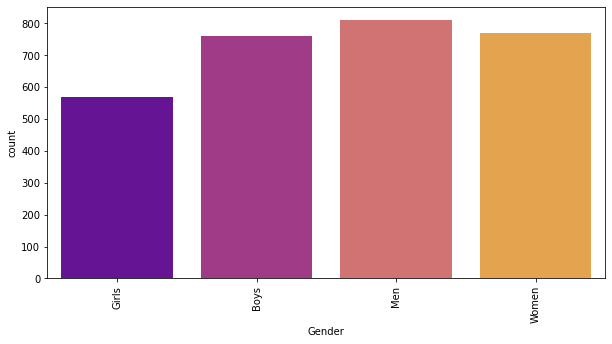

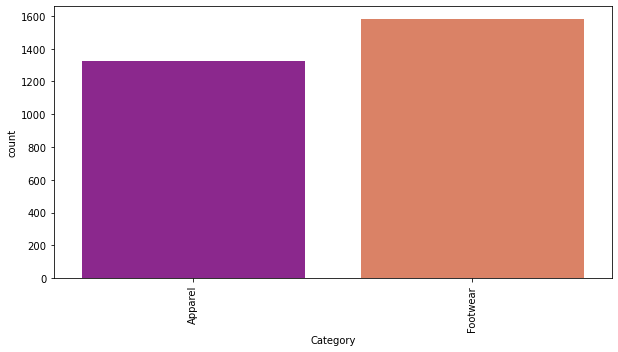

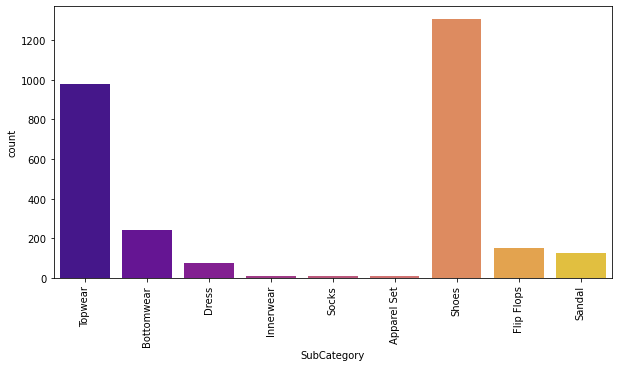

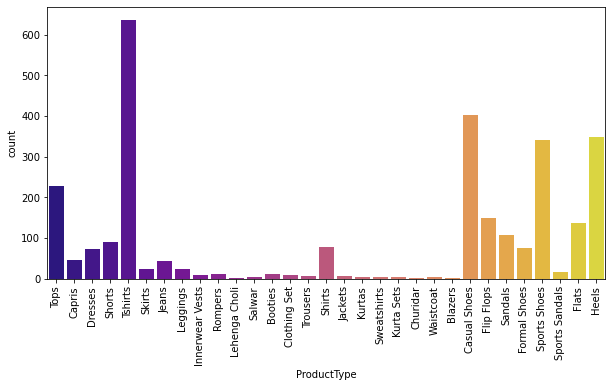

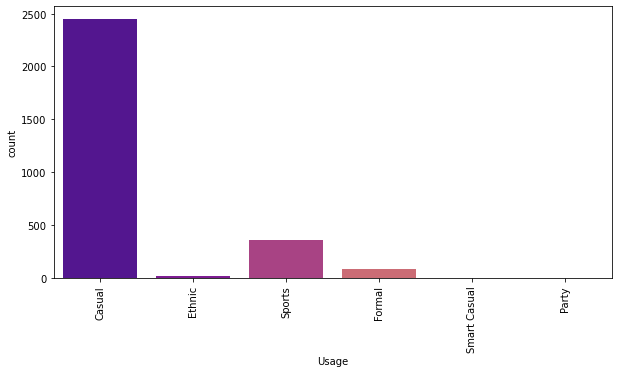

In [10]:
## plotting countplots for the categorical variables

def drawplot(col):
    plt.figure(figsize=(10,5))
    sns.countplot(df[col],palette='plasma')
    plt.xticks(rotation='vertical')
    
toview = ['Gender', 'Category','SubCategory','ProductType','Usage']
for col in toview:
    drawplot(col)

### Now after data analysis we know which products our dataset consist of.now we will build our model with the help of pretrainer resnet model.resnet is trained on 'imagenet' dataset.we can train model using our own cnn model.but it will take more time to train model and also our model will not perform as good as resnet.

In [11]:
model = ResNet50(weights='imagenet',include_top=False,input_shape=(224,224,3))
model.trainable = False

model = tensorflow.keras.Sequential([
    model,
    GlobalMaxPooling2D()
])

here,we are not training model.we are only taking trained model weights.

In [12]:
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 global_max_pooling2d (Globa  (None, 2048)             0         
 lMaxPooling2D)                                                  
                                                                 
Total params: 23,587,712
Trainable params: 0
Non-trainable params: 23,587,712
_________________________________________________________________
None


first we will use one image and extract its featurs and then create it as a function

In [13]:
img = image.load_img('D:\PYTHON\Data science\projects/recommendation system/product recommendation system/tiger.jpg',target_size=(224,224))

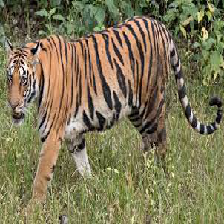

In [14]:
img

In [15]:
# to convert our image into array
img_array = image.img_to_array(img)

In [16]:
img_array

array([[[118., 141., 121.],
        [131., 150., 131.],
        [ 86., 103.,  85.],
        ...,
        [  6.,  17.,   3.],
        [ 65.,  80.,  59.],
        [ 64.,  90.,  55.]],

       [[101., 122., 103.],
        [131., 150., 131.],
        [126., 143., 125.],
        ...,
        [  2.,  13.,   0.],
        [ 49.,  64.,  43.],
        [ 70.,  96.,  61.]],

       [[101., 122., 103.],
        [131., 150., 131.],
        [126., 143., 125.],
        ...,
        [  2.,  13.,   0.],
        [ 49.,  64.,  43.],
        [ 70.,  96.,  61.]],

       ...,

       [[152., 151., 107.],
        [123., 122.,  76.],
        [131., 130.,  82.],
        ...,
        [124., 125.,  81.],
        [131., 133.,  86.],
        [157., 161., 110.]],

       [[152., 151., 107.],
        [123., 122.,  76.],
        [131., 130.,  82.],
        ...,
        [124., 125.,  81.],
        [131., 133.,  86.],
        [157., 161., 110.]],

       [[147., 146., 102.],
        [129., 128.,  82.],
        [108., 1

In [17]:
img_array.shape

(224, 224, 3)

In [18]:
# as keras takes batch of images,to send our images in batch we use expand_dims function.though we have only one image we have to send it in batch format

expanded_img_array = np.expand_dims(img_array, axis=0)

In [19]:
print(expanded_img_array.shape)

(1, 224, 224, 3)


In [20]:
expanded_img_array

array([[[[118., 141., 121.],
         [131., 150., 131.],
         [ 86., 103.,  85.],
         ...,
         [  6.,  17.,   3.],
         [ 65.,  80.,  59.],
         [ 64.,  90.,  55.]],

        [[101., 122., 103.],
         [131., 150., 131.],
         [126., 143., 125.],
         ...,
         [  2.,  13.,   0.],
         [ 49.,  64.,  43.],
         [ 70.,  96.,  61.]],

        [[101., 122., 103.],
         [131., 150., 131.],
         [126., 143., 125.],
         ...,
         [  2.,  13.,   0.],
         [ 49.,  64.,  43.],
         [ 70.,  96.,  61.]],

        ...,

        [[152., 151., 107.],
         [123., 122.,  76.],
         [131., 130.,  82.],
         ...,
         [124., 125.,  81.],
         [131., 133.,  86.],
         [157., 161., 110.]],

        [[152., 151., 107.],
         [123., 122.,  76.],
         [131., 130.,  82.],
         ...,
         [124., 125.,  81.],
         [131., 133.,  86.],
         [157., 161., 110.]],

        [[147., 146., 102.],
       

In [21]:
# to preprocess our images in resnet's imagenet dataset image format

preprocessed_img = preprocess_input(expanded_img_array)

In [22]:
preprocessed_img

array([[[[  17.060997 ,   24.221    ,   -5.6800003],
         [  27.060997 ,   33.221    ,    7.3199997],
         [ -18.939003 ,  -13.778999 ,  -37.68     ],
         ...,
         [-100.939    ,  -99.779    , -117.68     ],
         [ -44.939003 ,  -36.779    ,  -58.68     ],
         [ -48.939003 ,  -26.779    ,  -59.68     ]],

        [[  -0.939003 ,    5.2210007,  -22.68     ],
         [  27.060997 ,   33.221    ,    7.3199997],
         [  21.060997 ,   26.221    ,    2.3199997],
         ...,
         [-103.939    , -103.779    , -121.68     ],
         [ -60.939003 ,  -52.779    ,  -74.68     ],
         [ -42.939003 ,  -20.779    ,  -53.68     ]],

        [[  -0.939003 ,    5.2210007,  -22.68     ],
         [  27.060997 ,   33.221    ,    7.3199997],
         [  21.060997 ,   26.221    ,    2.3199997],
         ...,
         [-103.939    , -103.779    , -121.68     ],
         [ -60.939003 ,  -52.779    ,  -74.68     ],
         [ -42.939003 ,  -20.779    ,  -53.68     ]],

In [23]:
preprocessed_img.shape

(1, 224, 224, 3)

In [24]:
result = model.predict(preprocessed_img)

1/1 [==============================] - 1s 1s/step


In [25]:
result

array([[0.3165081 , 1.1470608 , 1.952385  , ..., 2.1214433 , 0.46121526,
        0.4784398 ]], dtype=float32)

In [26]:
result.shape

(1, 2048)

In [27]:
result = model.predict(preprocessed_img).flatten()

1/1 [==============================] - 0s 179ms/step


In [28]:
result

array([0.3165081 , 1.1470608 , 1.952385  , ..., 2.1214433 , 0.46121526,
       0.4784398 ], dtype=float32)

In [29]:
result.shape

(2048,)

In [30]:
# to normalise image in 0-1

normalized_result = result / norm(result)

In [31]:
normalized_result

array([0.00135677, 0.00491708, 0.00836925, ..., 0.00909395, 0.00197708,
       0.00205092], dtype=float32)

In [32]:
norm(result)

233.28072

### now we create one function to extract feature from images of our dataset on basis of above steps

In [33]:
def extract_features(img_path,model):
    img = image.load_img(img_path,target_size=(224,224))
    img_array = image.img_to_array(img)
    expanded_img_array = np.expand_dims(img_array, axis=0)
    preprocessed_img = preprocess_input(expanded_img_array)
    result = model.predict(preprocessed_img).flatten()
    normalized_result = result / norm(result)

    return normalized_result

In [34]:
# to collect all images filename or id 

filenames = []

for file in os.listdir('images'):
    filenames.append(os.path.join('images',file))

In [35]:
feature_list = []

for file in tqdm(filenames):
    feature_list.append(extract_features(file,model))

  0%|                                                                                         | 0/2906 [00:00<?, ?it/s]

1/1 [==============================] - 0s 172ms/step


  0%|                                                                                 | 1/2906 [00:00<19:58,  2.42it/s]

1/1 [==============================] - 0s 157ms/step


  0%|                                                                                 | 2/2906 [00:00<18:00,  2.69it/s]

1/1 [==============================] - 0s 171ms/step


  0%|                                                                                 | 3/2906 [00:01<17:12,  2.81it/s]

1/1 [==============================] - 0s 162ms/step


  0%|                                                                                 | 4/2906 [00:01<15:43,  3.08it/s]

1/1 [==============================] - 0s 157ms/step


  0%|▏                                                                                | 5/2906 [00:01<18:43,  2.58it/s]

1/1 [==============================] - 0s 156ms/step


  0%|▏                                                                                | 6/2906 [00:02<16:24,  2.95it/s]

1/1 [==============================] - 0s 173ms/step


  0%|▏                                                                                | 7/2906 [00:02<16:19,  2.96it/s]

1/1 [==============================] - 0s 166ms/step


  0%|▏                                                                                | 8/2906 [00:02<16:02,  3.01it/s]

1/1 [==============================] - 0s 176ms/step


  0%|▎                                                                                | 9/2906 [00:03<15:52,  3.04it/s]

1/1 [==============================] - 0s 167ms/step


  0%|▎                                                                               | 10/2906 [00:03<15:00,  3.22it/s]

1/1 [==============================] - 0s 176ms/step


  0%|▎                                                                               | 11/2906 [00:03<15:00,  3.21it/s]

1/1 [==============================] - 0s 164ms/step


  0%|▎                                                                               | 12/2906 [00:03<14:37,  3.30it/s]

1/1 [==============================] - 0s 169ms/step


  0%|▎                                                                               | 13/2906 [00:04<14:04,  3.42it/s]

1/1 [==============================] - 0s 177ms/step


  0%|▍                                                                               | 14/2906 [00:04<14:45,  3.27it/s]

1/1 [==============================] - 0s 184ms/step


  1%|▍                                                                               | 15/2906 [00:04<15:25,  3.12it/s]

1/1 [==============================] - 0s 176ms/step


  1%|▍                                                                               | 16/2906 [00:05<15:29,  3.11it/s]

1/1 [==============================] - 0s 171ms/step


  1%|▍                                                                               | 17/2906 [00:05<15:42,  3.06it/s]

1/1 [==============================] - 0s 173ms/step


  1%|▍                                                                               | 18/2906 [00:05<15:32,  3.10it/s]

1/1 [==============================] - 0s 173ms/step


  1%|▌                                                                               | 19/2906 [00:06<14:56,  3.22it/s]

1/1 [==============================] - 0s 172ms/step


  1%|▌                                                                               | 20/2906 [00:06<15:14,  3.16it/s]

1/1 [==============================] - 0s 173ms/step


  1%|▌                                                                               | 21/2906 [00:06<15:41,  3.06it/s]

1/1 [==============================] - 0s 189ms/step


  1%|▌                                                                               | 22/2906 [00:07<15:50,  3.03it/s]

1/1 [==============================] - 0s 186ms/step


  1%|▋                                                                               | 23/2906 [00:07<18:42,  2.57it/s]

1/1 [==============================] - 0s 172ms/step


  1%|▋                                                                               | 24/2906 [00:08<18:48,  2.55it/s]

1/1 [==============================] - 0s 199ms/step


  1%|▋                                                                               | 25/2906 [00:08<18:56,  2.53it/s]

1/1 [==============================] - 0s 169ms/step


  1%|▋                                                                               | 26/2906 [00:08<18:46,  2.56it/s]

1/1 [==============================] - 0s 164ms/step


  1%|▋                                                                               | 27/2906 [00:09<17:58,  2.67it/s]

1/1 [==============================] - 0s 173ms/step


  1%|▊                                                                               | 28/2906 [00:09<17:28,  2.74it/s]

1/1 [==============================] - 0s 173ms/step


  1%|▊                                                                               | 29/2906 [00:09<17:59,  2.66it/s]

1/1 [==============================] - 0s 172ms/step


  1%|▊                                                                               | 30/2906 [00:10<17:40,  2.71it/s]

1/1 [==============================] - 0s 188ms/step


  1%|▊                                                                               | 31/2906 [00:10<17:18,  2.77it/s]

1/1 [==============================] - 0s 173ms/step


  1%|▉                                                                               | 32/2906 [00:11<17:20,  2.76it/s]

1/1 [==============================] - 0s 172ms/step


  1%|▉                                                                               | 33/2906 [00:11<17:41,  2.71it/s]

1/1 [==============================] - 0s 188ms/step


  1%|▉                                                                               | 34/2906 [00:11<17:55,  2.67it/s]

1/1 [==============================] - 0s 173ms/step


  1%|▉                                                                               | 35/2906 [00:12<17:19,  2.76it/s]

1/1 [==============================] - 0s 192ms/step


  1%|▉                                                                               | 36/2906 [00:12<17:12,  2.78it/s]

1/1 [==============================] - 0s 193ms/step


  1%|█                                                                               | 37/2906 [00:12<18:30,  2.58it/s]

1/1 [==============================] - 0s 162ms/step


  1%|█                                                                               | 38/2906 [00:13<18:54,  2.53it/s]

1/1 [==============================] - 0s 234ms/step


  1%|█                                                                               | 39/2906 [00:13<18:59,  2.52it/s]

1/1 [==============================] - 0s 179ms/step


  1%|█                                                                               | 40/2906 [00:14<18:42,  2.55it/s]

1/1 [==============================] - 0s 172ms/step


  1%|█▏                                                                              | 41/2906 [00:14<16:59,  2.81it/s]

1/1 [==============================] - 0s 185ms/step


  1%|█▏                                                                              | 42/2906 [00:14<18:53,  2.53it/s]

1/1 [==============================] - 0s 186ms/step


  1%|█▏                                                                              | 43/2906 [00:15<18:56,  2.52it/s]

1/1 [==============================] - 0s 176ms/step


  2%|█▏                                                                              | 44/2906 [00:15<18:18,  2.60it/s]

1/1 [==============================] - 0s 188ms/step


  2%|█▏                                                                              | 45/2906 [00:15<17:24,  2.74it/s]

1/1 [==============================] - 0s 172ms/step


  2%|█▎                                                                              | 46/2906 [00:16<17:09,  2.78it/s]

1/1 [==============================] - 0s 170ms/step


  2%|█▎                                                                              | 47/2906 [00:16<18:06,  2.63it/s]

1/1 [==============================] - 0s 181ms/step


  2%|█▎                                                                              | 48/2906 [00:17<18:09,  2.62it/s]

1/1 [==============================] - 0s 173ms/step


  2%|█▎                                                                              | 49/2906 [00:17<18:20,  2.59it/s]

1/1 [==============================] - 0s 203ms/step


  2%|█▍                                                                              | 50/2906 [00:17<18:44,  2.54it/s]

1/1 [==============================] - 0s 173ms/step


  2%|█▍                                                                              | 51/2906 [00:18<18:13,  2.61it/s]

1/1 [==============================] - 0s 172ms/step


  2%|█▍                                                                              | 52/2906 [00:18<16:41,  2.85it/s]

1/1 [==============================] - 0s 195ms/step


  2%|█▍                                                                              | 53/2906 [00:18<16:27,  2.89it/s]

1/1 [==============================] - 0s 173ms/step


  2%|█▍                                                                              | 54/2906 [00:19<16:24,  2.90it/s]

1/1 [==============================] - 0s 217ms/step


  2%|█▌                                                                              | 55/2906 [00:19<16:56,  2.81it/s]

1/1 [==============================] - 0s 176ms/step


  2%|█▌                                                                              | 56/2906 [00:20<19:04,  2.49it/s]

1/1 [==============================] - 0s 217ms/step


  2%|█▌                                                                              | 57/2906 [00:20<18:44,  2.53it/s]

1/1 [==============================] - 0s 195ms/step


  2%|█▌                                                                              | 58/2906 [00:20<19:01,  2.49it/s]

1/1 [==============================] - 0s 193ms/step


  2%|█▌                                                                              | 59/2906 [00:21<18:58,  2.50it/s]

1/1 [==============================] - 0s 207ms/step


  2%|█▋                                                                              | 60/2906 [00:21<19:51,  2.39it/s]

1/1 [==============================] - 0s 194ms/step


  2%|█▋                                                                              | 61/2906 [00:22<19:13,  2.47it/s]

1/1 [==============================] - 0s 188ms/step


  2%|█▋                                                                              | 62/2906 [00:22<19:41,  2.41it/s]

1/1 [==============================] - 0s 175ms/step


  2%|█▋                                                                              | 63/2906 [00:23<19:54,  2.38it/s]

1/1 [==============================] - 0s 194ms/step


  2%|█▊                                                                              | 64/2906 [00:23<20:14,  2.34it/s]

1/1 [==============================] - 0s 234ms/step


  2%|█▊                                                                              | 65/2906 [00:23<19:49,  2.39it/s]

1/1 [==============================] - 0s 188ms/step


  2%|█▊                                                                              | 66/2906 [00:24<18:55,  2.50it/s]

1/1 [==============================] - 0s 173ms/step


  2%|█▊                                                                              | 67/2906 [00:24<18:32,  2.55it/s]

1/1 [==============================] - 0s 183ms/step


  2%|█▊                                                                              | 68/2906 [00:25<18:23,  2.57it/s]

1/1 [==============================] - 0s 176ms/step


  2%|█▉                                                                              | 69/2906 [00:25<17:46,  2.66it/s]

1/1 [==============================] - 0s 173ms/step


  2%|█▉                                                                              | 70/2906 [00:25<18:00,  2.62it/s]

1/1 [==============================] - 0s 197ms/step


  2%|█▉                                                                              | 71/2906 [00:26<18:56,  2.49it/s]

1/1 [==============================] - 0s 172ms/step


  2%|█▉                                                                              | 72/2906 [00:26<18:10,  2.60it/s]

1/1 [==============================] - 0s 190ms/step


  3%|██                                                                              | 73/2906 [00:26<18:35,  2.54it/s]

1/1 [==============================] - 0s 172ms/step


  3%|██                                                                              | 74/2906 [00:27<18:38,  2.53it/s]

1/1 [==============================] - 0s 189ms/step


  3%|██                                                                              | 75/2906 [00:27<18:08,  2.60it/s]

1/1 [==============================] - 0s 200ms/step


  3%|██                                                                              | 76/2906 [00:28<17:33,  2.69it/s]

1/1 [==============================] - 0s 173ms/step


  3%|██                                                                              | 77/2906 [00:28<17:31,  2.69it/s]

1/1 [==============================] - 0s 157ms/step


  3%|██▏                                                                             | 78/2906 [00:28<18:57,  2.49it/s]

1/1 [==============================] - 0s 188ms/step


  3%|██▏                                                                             | 79/2906 [00:29<18:35,  2.53it/s]

1/1 [==============================] - 0s 171ms/step


  3%|██▏                                                                             | 80/2906 [00:29<19:38,  2.40it/s]

1/1 [==============================] - 0s 188ms/step


  3%|██▏                                                                             | 81/2906 [00:30<18:46,  2.51it/s]

1/1 [==============================] - 0s 188ms/step


  3%|██▎                                                                             | 82/2906 [00:30<19:05,  2.47it/s]

1/1 [==============================] - 0s 180ms/step


  3%|██▎                                                                             | 83/2906 [00:30<18:12,  2.58it/s]

1/1 [==============================] - 0s 188ms/step


  3%|██▎                                                                             | 84/2906 [00:31<19:00,  2.47it/s]

1/1 [==============================] - 0s 173ms/step


  3%|██▎                                                                             | 85/2906 [00:31<18:59,  2.48it/s]

1/1 [==============================] - 0s 173ms/step


  3%|██▎                                                                             | 86/2906 [00:32<19:25,  2.42it/s]

1/1 [==============================] - 0s 173ms/step


  3%|██▍                                                                             | 87/2906 [00:32<18:56,  2.48it/s]

1/1 [==============================] - 0s 173ms/step


  3%|██▍                                                                             | 88/2906 [00:32<19:46,  2.37it/s]

1/1 [==============================] - 0s 168ms/step


  3%|██▍                                                                             | 89/2906 [00:33<18:50,  2.49it/s]

1/1 [==============================] - 0s 172ms/step


  3%|██▍                                                                             | 90/2906 [00:33<17:43,  2.65it/s]

1/1 [==============================] - 0s 173ms/step


  3%|██▌                                                                             | 91/2906 [00:33<16:51,  2.78it/s]

1/1 [==============================] - 0s 173ms/step


  3%|██▌                                                                             | 92/2906 [00:34<17:32,  2.67it/s]

1/1 [==============================] - 0s 159ms/step


  3%|██▌                                                                             | 93/2906 [00:34<17:46,  2.64it/s]

1/1 [==============================] - 0s 173ms/step


  3%|██▌                                                                             | 94/2906 [00:35<17:14,  2.72it/s]

1/1 [==============================] - 0s 173ms/step


  3%|██▌                                                                             | 95/2906 [00:35<17:16,  2.71it/s]

1/1 [==============================] - 0s 173ms/step


  3%|██▋                                                                             | 96/2906 [00:35<16:56,  2.76it/s]

1/1 [==============================] - 0s 174ms/step


  3%|██▋                                                                             | 97/2906 [00:36<16:36,  2.82it/s]

1/1 [==============================] - 0s 172ms/step


  3%|██▋                                                                             | 98/2906 [00:36<16:44,  2.80it/s]

1/1 [==============================] - 0s 173ms/step


  3%|██▋                                                                             | 99/2906 [00:36<16:52,  2.77it/s]

1/1 [==============================] - 0s 188ms/step


  3%|██▋                                                                            | 100/2906 [00:37<16:47,  2.78it/s]

1/1 [==============================] - 0s 173ms/step


  3%|██▋                                                                            | 101/2906 [00:37<16:50,  2.78it/s]

1/1 [==============================] - 0s 173ms/step


  4%|██▊                                                                            | 102/2906 [00:38<17:25,  2.68it/s]

1/1 [==============================] - 0s 173ms/step


  4%|██▊                                                                            | 103/2906 [00:38<17:48,  2.62it/s]

1/1 [==============================] - 0s 172ms/step


  4%|██▊                                                                            | 104/2906 [00:38<17:10,  2.72it/s]

1/1 [==============================] - 0s 173ms/step


  4%|██▊                                                                            | 105/2906 [00:39<18:04,  2.58it/s]

1/1 [==============================] - 0s 173ms/step


  4%|██▉                                                                            | 106/2906 [00:39<18:19,  2.55it/s]

1/1 [==============================] - 0s 173ms/step


  4%|██▉                                                                            | 107/2906 [00:39<18:12,  2.56it/s]

1/1 [==============================] - 0s 188ms/step


  4%|██▉                                                                            | 108/2906 [00:40<17:44,  2.63it/s]

1/1 [==============================] - 0s 172ms/step


  4%|██▉                                                                            | 109/2906 [00:40<16:44,  2.78it/s]

1/1 [==============================] - 0s 177ms/step


  4%|██▉                                                                            | 110/2906 [00:41<17:39,  2.64it/s]

1/1 [==============================] - 0s 181ms/step


  4%|███                                                                            | 111/2906 [00:41<17:40,  2.64it/s]

1/1 [==============================] - 0s 173ms/step


  4%|███                                                                            | 112/2906 [00:41<18:01,  2.58it/s]

1/1 [==============================] - 0s 173ms/step


  4%|███                                                                            | 113/2906 [00:42<17:33,  2.65it/s]

1/1 [==============================] - 0s 173ms/step


  4%|███                                                                            | 114/2906 [00:42<17:43,  2.63it/s]

1/1 [==============================] - 0s 179ms/step


  4%|███▏                                                                           | 115/2906 [00:42<17:33,  2.65it/s]

1/1 [==============================] - 0s 188ms/step


  4%|███▏                                                                           | 116/2906 [00:43<17:07,  2.72it/s]

1/1 [==============================] - 0s 173ms/step


  4%|███▏                                                                           | 117/2906 [00:43<17:28,  2.66it/s]

1/1 [==============================] - 0s 188ms/step


  4%|███▏                                                                           | 118/2906 [00:43<16:03,  2.89it/s]

1/1 [==============================] - 0s 173ms/step


  4%|███▏                                                                           | 119/2906 [00:44<15:23,  3.02it/s]

1/1 [==============================] - 0s 172ms/step


  4%|███▎                                                                           | 120/2906 [00:44<16:06,  2.88it/s]

1/1 [==============================] - 0s 188ms/step


  4%|███▎                                                                           | 121/2906 [00:45<16:46,  2.77it/s]

1/1 [==============================] - 0s 189ms/step


  4%|███▎                                                                           | 122/2906 [00:45<16:39,  2.79it/s]

1/1 [==============================] - 0s 173ms/step


  4%|███▎                                                                           | 123/2906 [00:45<16:49,  2.76it/s]

1/1 [==============================] - 0s 173ms/step


  4%|███▎                                                                           | 124/2906 [00:46<17:44,  2.61it/s]

1/1 [==============================] - 0s 173ms/step


  4%|███▍                                                                           | 125/2906 [00:46<17:57,  2.58it/s]

1/1 [==============================] - 0s 173ms/step


  4%|███▍                                                                           | 126/2906 [00:47<18:09,  2.55it/s]

1/1 [==============================] - 0s 173ms/step


  4%|███▍                                                                           | 127/2906 [00:47<16:59,  2.73it/s]

1/1 [==============================] - 0s 173ms/step


  4%|███▍                                                                           | 128/2906 [00:47<17:40,  2.62it/s]

1/1 [==============================] - 0s 172ms/step


  4%|███▌                                                                           | 129/2906 [00:48<16:57,  2.73it/s]

1/1 [==============================] - 0s 172ms/step


  4%|███▌                                                                           | 130/2906 [00:48<16:28,  2.81it/s]

1/1 [==============================] - 0s 176ms/step


  5%|███▌                                                                           | 131/2906 [00:48<16:49,  2.75it/s]

1/1 [==============================] - 0s 188ms/step


  5%|███▌                                                                           | 132/2906 [00:49<17:10,  2.69it/s]

1/1 [==============================] - 0s 188ms/step


  5%|███▌                                                                           | 133/2906 [00:49<18:05,  2.55it/s]

1/1 [==============================] - 0s 173ms/step


  5%|███▋                                                                           | 134/2906 [00:50<18:35,  2.48it/s]

1/1 [==============================] - 0s 178ms/step


  5%|███▋                                                                           | 135/2906 [00:50<17:48,  2.59it/s]

1/1 [==============================] - 0s 188ms/step


  5%|███▋                                                                           | 136/2906 [00:50<17:03,  2.71it/s]

1/1 [==============================] - 0s 172ms/step


  5%|███▋                                                                           | 137/2906 [00:51<16:44,  2.76it/s]

1/1 [==============================] - 0s 173ms/step


  5%|███▊                                                                           | 138/2906 [00:51<16:31,  2.79it/s]

1/1 [==============================] - 0s 168ms/step


  5%|███▊                                                                           | 139/2906 [00:51<17:42,  2.60it/s]

1/1 [==============================] - 0s 188ms/step


  5%|███▊                                                                           | 140/2906 [00:52<17:10,  2.68it/s]

1/1 [==============================] - 0s 188ms/step


  5%|███▊                                                                           | 141/2906 [00:52<16:48,  2.74it/s]

1/1 [==============================] - 0s 173ms/step


  5%|███▊                                                                           | 142/2906 [00:52<17:15,  2.67it/s]

1/1 [==============================] - 0s 172ms/step


  5%|███▉                                                                           | 143/2906 [00:53<16:29,  2.79it/s]

1/1 [==============================] - 0s 188ms/step


  5%|███▉                                                                           | 144/2906 [00:53<16:34,  2.78it/s]

1/1 [==============================] - 0s 173ms/step


  5%|███▉                                                                           | 145/2906 [00:54<16:57,  2.71it/s]

1/1 [==============================] - 0s 157ms/step


  5%|███▉                                                                           | 146/2906 [00:54<17:41,  2.60it/s]

1/1 [==============================] - 0s 173ms/step


  5%|███▉                                                                           | 147/2906 [00:54<17:42,  2.60it/s]

1/1 [==============================] - 0s 157ms/step


  5%|████                                                                           | 148/2906 [00:55<18:20,  2.51it/s]

1/1 [==============================] - 0s 173ms/step


  5%|████                                                                           | 149/2906 [00:55<17:41,  2.60it/s]

1/1 [==============================] - 0s 173ms/step


  5%|████                                                                           | 150/2906 [00:55<16:57,  2.71it/s]

1/1 [==============================] - 0s 177ms/step


  5%|████                                                                           | 151/2906 [00:56<16:41,  2.75it/s]

1/1 [==============================] - 0s 204ms/step


  5%|████▏                                                                          | 152/2906 [00:56<16:51,  2.72it/s]

1/1 [==============================] - 0s 173ms/step


  5%|████▏                                                                          | 153/2906 [00:57<16:58,  2.70it/s]

1/1 [==============================] - 0s 173ms/step


  5%|████▏                                                                          | 154/2906 [00:57<17:16,  2.65it/s]

1/1 [==============================] - 0s 173ms/step


  5%|████▏                                                                          | 155/2906 [00:57<17:38,  2.60it/s]

1/1 [==============================] - 0s 172ms/step


  5%|████▏                                                                          | 156/2906 [00:58<16:59,  2.70it/s]

1/1 [==============================] - 0s 173ms/step


  5%|████▎                                                                          | 157/2906 [00:58<15:48,  2.90it/s]

1/1 [==============================] - 0s 172ms/step


  5%|████▎                                                                          | 158/2906 [00:58<15:23,  2.98it/s]

1/1 [==============================] - 0s 173ms/step


  5%|████▎                                                                          | 159/2906 [00:59<15:26,  2.96it/s]

1/1 [==============================] - 0s 173ms/step


  6%|████▎                                                                          | 160/2906 [00:59<15:17,  2.99it/s]

1/1 [==============================] - 0s 173ms/step


  6%|████▍                                                                          | 161/2906 [00:59<16:04,  2.85it/s]

1/1 [==============================] - 0s 185ms/step


  6%|████▍                                                                          | 162/2906 [01:00<15:57,  2.87it/s]

1/1 [==============================] - 0s 188ms/step


  6%|████▍                                                                          | 163/2906 [01:00<15:51,  2.88it/s]

1/1 [==============================] - 0s 188ms/step


  6%|████▍                                                                          | 164/2906 [01:00<16:38,  2.75it/s]

1/1 [==============================] - 0s 173ms/step


  6%|████▍                                                                          | 165/2906 [01:01<16:12,  2.82it/s]

1/1 [==============================] - 0s 177ms/step


  6%|████▌                                                                          | 166/2906 [01:01<17:14,  2.65it/s]

1/1 [==============================] - 0s 204ms/step


  6%|████▌                                                                          | 167/2906 [01:02<17:40,  2.58it/s]

1/1 [==============================] - 0s 188ms/step


  6%|████▌                                                                          | 168/2906 [01:02<17:18,  2.64it/s]

1/1 [==============================] - 0s 188ms/step


  6%|████▌                                                                          | 169/2906 [01:02<17:54,  2.55it/s]

1/1 [==============================] - 0s 173ms/step


  6%|████▌                                                                          | 170/2906 [01:03<17:21,  2.63it/s]

1/1 [==============================] - 0s 188ms/step


  6%|████▋                                                                          | 171/2906 [01:03<17:21,  2.63it/s]

1/1 [==============================] - 0s 204ms/step


  6%|████▋                                                                          | 172/2906 [01:04<17:48,  2.56it/s]

1/1 [==============================] - 0s 172ms/step


  6%|████▋                                                                          | 173/2906 [01:04<17:25,  2.61it/s]

1/1 [==============================] - 0s 188ms/step


  6%|████▋                                                                          | 174/2906 [01:04<18:04,  2.52it/s]

1/1 [==============================] - 0s 188ms/step


  6%|████▊                                                                          | 175/2906 [01:05<17:19,  2.63it/s]

1/1 [==============================] - 0s 173ms/step


  6%|████▊                                                                          | 176/2906 [01:05<17:19,  2.63it/s]

1/1 [==============================] - 0s 188ms/step


  6%|████▊                                                                          | 177/2906 [01:05<17:28,  2.60it/s]

1/1 [==============================] - 0s 173ms/step


  6%|████▊                                                                          | 178/2906 [01:06<17:18,  2.63it/s]

1/1 [==============================] - 0s 188ms/step


  6%|████▊                                                                          | 179/2906 [01:06<16:55,  2.69it/s]

1/1 [==============================] - 0s 173ms/step


  6%|████▉                                                                          | 180/2906 [01:07<17:05,  2.66it/s]

1/1 [==============================] - 0s 173ms/step


  6%|████▉                                                                          | 181/2906 [01:07<17:40,  2.57it/s]

1/1 [==============================] - 0s 188ms/step


  6%|████▉                                                                          | 182/2906 [01:07<17:51,  2.54it/s]

1/1 [==============================] - 0s 176ms/step


  6%|████▉                                                                          | 183/2906 [01:08<17:08,  2.65it/s]

1/1 [==============================] - 0s 173ms/step


  6%|█████                                                                          | 184/2906 [01:08<16:40,  2.72it/s]

1/1 [==============================] - 0s 173ms/step


  6%|█████                                                                          | 185/2906 [01:08<17:08,  2.65it/s]

1/1 [==============================] - 0s 179ms/step


  6%|█████                                                                          | 186/2906 [01:09<16:46,  2.70it/s]

1/1 [==============================] - 0s 188ms/step


  6%|█████                                                                          | 187/2906 [01:09<17:31,  2.59it/s]

1/1 [==============================] - 0s 173ms/step


  6%|█████                                                                          | 188/2906 [01:10<17:28,  2.59it/s]

1/1 [==============================] - 0s 173ms/step


  7%|█████▏                                                                         | 189/2906 [01:10<17:43,  2.55it/s]

1/1 [==============================] - 0s 188ms/step


  7%|█████▏                                                                         | 190/2906 [01:10<17:56,  2.52it/s]

1/1 [==============================] - 0s 166ms/step


  7%|█████▏                                                                         | 191/2906 [01:11<18:44,  2.41it/s]

1/1 [==============================] - 0s 188ms/step


  7%|█████▏                                                                         | 192/2906 [01:11<18:14,  2.48it/s]

1/1 [==============================] - 0s 173ms/step


  7%|█████▏                                                                         | 193/2906 [01:12<18:11,  2.49it/s]

1/1 [==============================] - 0s 173ms/step


  7%|█████▎                                                                         | 194/2906 [01:12<17:43,  2.55it/s]

1/1 [==============================] - 0s 172ms/step


  7%|█████▎                                                                         | 195/2906 [01:13<18:45,  2.41it/s]

1/1 [==============================] - 0s 173ms/step


  7%|█████▎                                                                         | 196/2906 [01:13<17:47,  2.54it/s]

1/1 [==============================] - 0s 173ms/step


  7%|█████▎                                                                         | 197/2906 [01:13<17:04,  2.64it/s]

1/1 [==============================] - 0s 173ms/step


  7%|█████▍                                                                         | 198/2906 [01:14<17:21,  2.60it/s]

1/1 [==============================] - 0s 173ms/step


  7%|█████▍                                                                         | 199/2906 [01:14<17:19,  2.61it/s]

1/1 [==============================] - 0s 188ms/step


  7%|█████▍                                                                         | 200/2906 [01:14<16:54,  2.67it/s]

1/1 [==============================] - 0s 173ms/step


  7%|█████▍                                                                         | 201/2906 [01:15<17:22,  2.59it/s]

1/1 [==============================] - 0s 189ms/step


  7%|█████▍                                                                         | 202/2906 [01:15<17:29,  2.58it/s]

1/1 [==============================] - 0s 188ms/step


  7%|█████▌                                                                         | 203/2906 [01:16<18:02,  2.50it/s]

1/1 [==============================] - 0s 172ms/step


  7%|█████▌                                                                         | 204/2906 [01:16<17:16,  2.61it/s]

1/1 [==============================] - 0s 169ms/step


  7%|█████▌                                                                         | 205/2906 [01:16<17:02,  2.64it/s]

1/1 [==============================] - 0s 173ms/step


  7%|█████▌                                                                         | 206/2906 [01:17<17:10,  2.62it/s]

1/1 [==============================] - 0s 157ms/step


  7%|█████▋                                                                         | 207/2906 [01:17<18:34,  2.42it/s]

1/1 [==============================] - 0s 187ms/step


  7%|█████▋                                                                         | 208/2906 [01:18<18:02,  2.49it/s]

1/1 [==============================] - 0s 164ms/step


  7%|█████▋                                                                         | 209/2906 [01:18<19:03,  2.36it/s]

1/1 [==============================] - 0s 188ms/step


  7%|█████▋                                                                         | 210/2906 [01:18<17:55,  2.51it/s]

1/1 [==============================] - 0s 174ms/step


  7%|█████▋                                                                         | 211/2906 [01:19<17:55,  2.51it/s]

1/1 [==============================] - 0s 175ms/step


  7%|█████▊                                                                         | 212/2906 [01:19<17:51,  2.51it/s]

1/1 [==============================] - 0s 188ms/step


  7%|█████▊                                                                         | 213/2906 [01:20<18:08,  2.47it/s]

1/1 [==============================] - 0s 173ms/step


  7%|█████▊                                                                         | 214/2906 [01:20<17:13,  2.60it/s]

1/1 [==============================] - 0s 173ms/step


  7%|█████▊                                                                         | 215/2906 [01:20<16:07,  2.78it/s]

1/1 [==============================] - 0s 173ms/step


  7%|█████▊                                                                         | 216/2906 [01:21<15:18,  2.93it/s]

1/1 [==============================] - 0s 188ms/step


  7%|█████▉                                                                         | 217/2906 [01:21<15:43,  2.85it/s]

1/1 [==============================] - 0s 173ms/step


  8%|█████▉                                                                         | 218/2906 [01:21<16:38,  2.69it/s]

1/1 [==============================] - 0s 188ms/step


  8%|█████▉                                                                         | 219/2906 [01:22<16:06,  2.78it/s]

1/1 [==============================] - 0s 201ms/step


  8%|█████▉                                                                         | 220/2906 [01:22<16:53,  2.65it/s]

1/1 [==============================] - 0s 188ms/step


  8%|██████                                                                         | 221/2906 [01:23<18:09,  2.47it/s]

1/1 [==============================] - 0s 182ms/step


  8%|██████                                                                         | 222/2906 [01:23<17:44,  2.52it/s]

1/1 [==============================] - 0s 188ms/step


  8%|██████                                                                         | 223/2906 [01:23<17:51,  2.50it/s]

1/1 [==============================] - 0s 188ms/step


  8%|██████                                                                         | 224/2906 [01:24<17:46,  2.51it/s]

1/1 [==============================] - 0s 174ms/step


  8%|██████                                                                         | 225/2906 [01:24<18:27,  2.42it/s]

1/1 [==============================] - 0s 188ms/step


  8%|██████▏                                                                        | 226/2906 [01:25<17:56,  2.49it/s]

1/1 [==============================] - 0s 173ms/step


  8%|██████▏                                                                        | 227/2906 [01:25<17:33,  2.54it/s]

1/1 [==============================] - 0s 173ms/step


  8%|██████▏                                                                        | 228/2906 [01:25<17:38,  2.53it/s]

1/1 [==============================] - 0s 189ms/step


  8%|██████▏                                                                        | 229/2906 [01:26<17:17,  2.58it/s]

1/1 [==============================] - 0s 174ms/step


  8%|██████▎                                                                        | 230/2906 [01:26<17:14,  2.59it/s]

1/1 [==============================] - 0s 173ms/step


  8%|██████▎                                                                        | 231/2906 [01:26<16:45,  2.66it/s]

1/1 [==============================] - 0s 173ms/step


  8%|██████▎                                                                        | 232/2906 [01:27<17:14,  2.58it/s]

1/1 [==============================] - 0s 174ms/step


  8%|██████▎                                                                        | 233/2906 [01:27<16:35,  2.69it/s]

1/1 [==============================] - 0s 188ms/step


  8%|██████▎                                                                        | 234/2906 [01:27<16:08,  2.76it/s]

1/1 [==============================] - 0s 173ms/step


  8%|██████▍                                                                        | 235/2906 [01:28<17:19,  2.57it/s]

1/1 [==============================] - 0s 188ms/step


  8%|██████▍                                                                        | 236/2906 [01:28<17:04,  2.61it/s]

1/1 [==============================] - 0s 188ms/step


  8%|██████▍                                                                        | 237/2906 [01:29<16:51,  2.64it/s]

1/1 [==============================] - 0s 188ms/step


  8%|██████▍                                                                        | 238/2906 [01:29<17:12,  2.58it/s]

1/1 [==============================] - 0s 159ms/step


  8%|██████▍                                                                        | 239/2906 [01:30<18:29,  2.40it/s]

1/1 [==============================] - 0s 172ms/step


  8%|██████▌                                                                        | 240/2906 [01:30<18:08,  2.45it/s]

1/1 [==============================] - 0s 172ms/step


  8%|██████▌                                                                        | 241/2906 [01:30<19:21,  2.30it/s]

1/1 [==============================] - 0s 173ms/step


  8%|██████▌                                                                        | 242/2906 [01:31<19:22,  2.29it/s]

1/1 [==============================] - 0s 172ms/step


  8%|██████▌                                                                        | 243/2906 [01:31<20:19,  2.18it/s]

1/1 [==============================] - 0s 188ms/step


  8%|██████▋                                                                        | 244/2906 [01:32<19:15,  2.30it/s]

1/1 [==============================] - 0s 184ms/step


  8%|██████▋                                                                        | 245/2906 [01:32<18:20,  2.42it/s]

1/1 [==============================] - 0s 173ms/step


  8%|██████▋                                                                        | 246/2906 [01:33<17:33,  2.52it/s]

1/1 [==============================] - 0s 204ms/step


  8%|██████▋                                                                        | 247/2906 [01:33<17:11,  2.58it/s]

1/1 [==============================] - 0s 173ms/step


  9%|██████▋                                                                        | 248/2906 [01:33<16:09,  2.74it/s]

1/1 [==============================] - 0s 173ms/step


  9%|██████▊                                                                        | 249/2906 [01:34<15:50,  2.80it/s]

1/1 [==============================] - 0s 173ms/step


  9%|██████▊                                                                        | 250/2906 [01:34<16:11,  2.73it/s]

1/1 [==============================] - 0s 173ms/step


  9%|██████▊                                                                        | 251/2906 [01:34<16:57,  2.61it/s]

1/1 [==============================] - 0s 173ms/step


  9%|██████▊                                                                        | 252/2906 [01:35<15:43,  2.81it/s]

1/1 [==============================] - 0s 157ms/step


  9%|██████▉                                                                        | 253/2906 [01:35<16:15,  2.72it/s]

1/1 [==============================] - 0s 172ms/step


  9%|██████▉                                                                        | 254/2906 [01:35<16:14,  2.72it/s]

1/1 [==============================] - 0s 188ms/step


  9%|██████▉                                                                        | 255/2906 [01:36<17:11,  2.57it/s]

1/1 [==============================] - 0s 188ms/step


  9%|██████▉                                                                        | 256/2906 [01:36<16:55,  2.61it/s]

1/1 [==============================] - 0s 173ms/step


  9%|██████▉                                                                        | 257/2906 [01:37<17:19,  2.55it/s]

1/1 [==============================] - 0s 188ms/step


  9%|███████                                                                        | 258/2906 [01:37<17:29,  2.52it/s]

1/1 [==============================] - 0s 169ms/step


  9%|███████                                                                        | 259/2906 [01:37<17:55,  2.46it/s]

1/1 [==============================] - 0s 188ms/step


  9%|███████                                                                        | 260/2906 [01:38<17:08,  2.57it/s]

1/1 [==============================] - 0s 172ms/step


  9%|███████                                                                        | 261/2906 [01:38<16:58,  2.60it/s]

1/1 [==============================] - 0s 172ms/step


  9%|███████                                                                        | 262/2906 [01:39<17:11,  2.56it/s]

1/1 [==============================] - 0s 173ms/step


  9%|███████▏                                                                       | 263/2906 [01:39<16:36,  2.65it/s]

1/1 [==============================] - 0s 189ms/step


  9%|███████▏                                                                       | 264/2906 [01:39<16:40,  2.64it/s]

1/1 [==============================] - 0s 172ms/step


  9%|███████▏                                                                       | 265/2906 [01:40<17:04,  2.58it/s]

1/1 [==============================] - 0s 173ms/step


  9%|███████▏                                                                       | 266/2906 [01:40<15:54,  2.77it/s]

1/1 [==============================] - 0s 177ms/step


  9%|███████▎                                                                       | 267/2906 [01:40<15:53,  2.77it/s]

1/1 [==============================] - 0s 173ms/step


  9%|███████▎                                                                       | 268/2906 [01:41<16:45,  2.62it/s]

1/1 [==============================] - 0s 204ms/step


  9%|███████▎                                                                       | 269/2906 [01:41<17:11,  2.56it/s]

1/1 [==============================] - 0s 174ms/step


  9%|███████▎                                                                       | 270/2906 [01:42<18:45,  2.34it/s]

1/1 [==============================] - 0s 204ms/step


  9%|███████▎                                                                       | 271/2906 [01:42<18:02,  2.43it/s]

1/1 [==============================] - 0s 188ms/step


  9%|███████▍                                                                       | 272/2906 [01:43<17:59,  2.44it/s]

1/1 [==============================] - 0s 172ms/step


  9%|███████▍                                                                       | 273/2906 [01:43<17:07,  2.56it/s]

1/1 [==============================] - 0s 188ms/step


  9%|███████▍                                                                       | 274/2906 [01:43<17:06,  2.56it/s]

1/1 [==============================] - 0s 178ms/step


  9%|███████▍                                                                       | 275/2906 [01:44<17:08,  2.56it/s]

1/1 [==============================] - 0s 188ms/step


  9%|███████▌                                                                       | 276/2906 [01:44<16:19,  2.69it/s]

1/1 [==============================] - 0s 188ms/step


 10%|███████▌                                                                       | 277/2906 [01:44<16:21,  2.68it/s]

1/1 [==============================] - 0s 171ms/step


 10%|███████▌                                                                       | 278/2906 [01:45<15:43,  2.79it/s]

1/1 [==============================] - 0s 188ms/step


 10%|███████▌                                                                       | 279/2906 [01:45<15:25,  2.84it/s]

1/1 [==============================] - 0s 174ms/step


 10%|███████▌                                                                       | 280/2906 [01:45<15:57,  2.74it/s]

1/1 [==============================] - 0s 173ms/step


 10%|███████▋                                                                       | 281/2906 [01:46<15:48,  2.77it/s]

1/1 [==============================] - 0s 204ms/step


 10%|███████▋                                                                       | 282/2906 [01:46<15:44,  2.78it/s]

1/1 [==============================] - 0s 172ms/step


 10%|███████▋                                                                       | 283/2906 [01:46<15:43,  2.78it/s]

1/1 [==============================] - 0s 188ms/step


 10%|███████▋                                                                       | 284/2906 [01:47<15:44,  2.78it/s]

1/1 [==============================] - 0s 204ms/step


 10%|███████▋                                                                       | 285/2906 [01:47<15:57,  2.74it/s]

1/1 [==============================] - 0s 173ms/step


 10%|███████▊                                                                       | 286/2906 [01:48<15:41,  2.78it/s]

1/1 [==============================] - 0s 177ms/step


 10%|███████▊                                                                       | 287/2906 [01:48<15:34,  2.80it/s]

1/1 [==============================] - 0s 181ms/step


 10%|███████▊                                                                       | 288/2906 [01:48<16:08,  2.70it/s]

1/1 [==============================] - 0s 185ms/step


 10%|███████▊                                                                       | 289/2906 [01:49<14:50,  2.94it/s]

1/1 [==============================] - 0s 173ms/step


 10%|███████▉                                                                       | 290/2906 [01:49<14:13,  3.06it/s]

1/1 [==============================] - 0s 188ms/step


 10%|███████▉                                                                       | 291/2906 [01:49<13:54,  3.13it/s]

1/1 [==============================] - 0s 173ms/step


 10%|███████▉                                                                       | 292/2906 [01:50<14:19,  3.04it/s]

1/1 [==============================] - 0s 170ms/step


 10%|███████▉                                                                       | 293/2906 [01:50<14:43,  2.96it/s]

1/1 [==============================] - 0s 172ms/step


 10%|███████▉                                                                       | 294/2906 [01:50<15:43,  2.77it/s]

1/1 [==============================] - 0s 173ms/step


 10%|████████                                                                       | 295/2906 [01:51<15:23,  2.83it/s]

1/1 [==============================] - 0s 173ms/step


 10%|████████                                                                       | 296/2906 [01:51<15:07,  2.88it/s]

1/1 [==============================] - 0s 173ms/step


 10%|████████                                                                       | 297/2906 [01:51<15:35,  2.79it/s]

1/1 [==============================] - 0s 190ms/step


 10%|████████                                                                       | 298/2906 [01:52<15:31,  2.80it/s]

1/1 [==============================] - 0s 188ms/step


 10%|████████▏                                                                      | 299/2906 [01:52<14:44,  2.95it/s]

1/1 [==============================] - 0s 188ms/step


 10%|████████▏                                                                      | 300/2906 [01:52<15:30,  2.80it/s]

1/1 [==============================] - 0s 172ms/step


 10%|████████▏                                                                      | 301/2906 [01:53<14:56,  2.90it/s]

1/1 [==============================] - 0s 188ms/step


 10%|████████▏                                                                      | 302/2906 [01:53<16:24,  2.65it/s]

1/1 [==============================] - 0s 173ms/step


 10%|████████▏                                                                      | 303/2906 [01:54<16:40,  2.60it/s]

1/1 [==============================] - 0s 173ms/step


 10%|████████▎                                                                      | 304/2906 [01:54<16:31,  2.63it/s]

1/1 [==============================] - 0s 173ms/step


 10%|████████▎                                                                      | 305/2906 [01:54<18:22,  2.36it/s]

1/1 [==============================] - 0s 188ms/step


 11%|████████▎                                                                      | 306/2906 [01:55<17:18,  2.50it/s]

1/1 [==============================] - 0s 188ms/step


 11%|████████▎                                                                      | 307/2906 [01:55<16:52,  2.57it/s]

1/1 [==============================] - 0s 173ms/step


 11%|████████▎                                                                      | 308/2906 [01:56<16:39,  2.60it/s]

1/1 [==============================] - 0s 173ms/step


 11%|████████▍                                                                      | 309/2906 [01:56<15:58,  2.71it/s]

1/1 [==============================] - 0s 188ms/step


 11%|████████▍                                                                      | 310/2906 [01:56<15:54,  2.72it/s]

1/1 [==============================] - 0s 173ms/step


 11%|████████▍                                                                      | 311/2906 [01:57<15:47,  2.74it/s]

1/1 [==============================] - 0s 173ms/step


 11%|████████▍                                                                      | 312/2906 [01:57<15:45,  2.74it/s]

1/1 [==============================] - 0s 188ms/step


 11%|████████▌                                                                      | 313/2906 [01:57<16:51,  2.56it/s]

1/1 [==============================] - 0s 182ms/step


 11%|████████▌                                                                      | 314/2906 [01:58<16:42,  2.58it/s]

1/1 [==============================] - 0s 189ms/step


 11%|████████▌                                                                      | 315/2906 [01:58<16:04,  2.69it/s]

1/1 [==============================] - 0s 173ms/step


 11%|████████▌                                                                      | 316/2906 [01:59<16:23,  2.63it/s]

1/1 [==============================] - 0s 173ms/step


 11%|████████▌                                                                      | 317/2906 [01:59<16:03,  2.69it/s]

1/1 [==============================] - 0s 188ms/step


 11%|████████▋                                                                      | 318/2906 [01:59<15:47,  2.73it/s]

1/1 [==============================] - 0s 188ms/step


 11%|████████▋                                                                      | 319/2906 [02:00<15:51,  2.72it/s]

1/1 [==============================] - 0s 183ms/step


 11%|████████▋                                                                      | 320/2906 [02:00<14:49,  2.91it/s]

1/1 [==============================] - 0s 188ms/step


 11%|████████▋                                                                      | 321/2906 [02:00<16:10,  2.66it/s]

1/1 [==============================] - 0s 180ms/step


 11%|████████▊                                                                      | 322/2906 [02:01<16:10,  2.66it/s]

1/1 [==============================] - 0s 188ms/step


 11%|████████▊                                                                      | 323/2906 [02:01<16:37,  2.59it/s]

1/1 [==============================] - 0s 188ms/step


 11%|████████▊                                                                      | 324/2906 [02:02<17:19,  2.48it/s]

1/1 [==============================] - 0s 181ms/step


 11%|████████▊                                                                      | 325/2906 [02:02<16:36,  2.59it/s]

1/1 [==============================] - 0s 188ms/step


 11%|████████▊                                                                      | 326/2906 [02:02<16:04,  2.67it/s]

1/1 [==============================] - 0s 173ms/step


 11%|████████▉                                                                      | 327/2906 [02:03<15:57,  2.69it/s]

1/1 [==============================] - 0s 181ms/step


 11%|████████▉                                                                      | 328/2906 [02:03<14:53,  2.89it/s]

1/1 [==============================] - 0s 188ms/step


 11%|████████▉                                                                      | 329/2906 [02:03<15:13,  2.82it/s]

1/1 [==============================] - 0s 183ms/step


 11%|████████▉                                                                      | 330/2906 [02:04<15:55,  2.70it/s]

1/1 [==============================] - 0s 173ms/step


 11%|████████▉                                                                      | 331/2906 [02:04<15:26,  2.78it/s]

1/1 [==============================] - 0s 188ms/step


 11%|█████████                                                                      | 332/2906 [02:04<15:50,  2.71it/s]

1/1 [==============================] - 0s 173ms/step


 11%|█████████                                                                      | 333/2906 [02:05<16:28,  2.60it/s]

1/1 [==============================] - 0s 188ms/step


 11%|█████████                                                                      | 334/2906 [02:05<15:22,  2.79it/s]

1/1 [==============================] - 0s 173ms/step


 12%|█████████                                                                      | 335/2906 [02:06<15:49,  2.71it/s]

1/1 [==============================] - 0s 172ms/step


 12%|█████████▏                                                                     | 336/2906 [02:06<15:55,  2.69it/s]

1/1 [==============================] - 0s 188ms/step


 12%|█████████▏                                                                     | 337/2906 [02:06<16:34,  2.58it/s]

1/1 [==============================] - 0s 188ms/step


 12%|█████████▏                                                                     | 338/2906 [02:07<16:38,  2.57it/s]

1/1 [==============================] - 0s 188ms/step


 12%|█████████▏                                                                     | 339/2906 [02:07<18:21,  2.33it/s]

1/1 [==============================] - 0s 188ms/step


 12%|█████████▏                                                                     | 340/2906 [02:08<18:59,  2.25it/s]

1/1 [==============================] - 0s 172ms/step


 12%|█████████▎                                                                     | 341/2906 [02:08<19:17,  2.22it/s]

1/1 [==============================] - 0s 173ms/step


 12%|█████████▎                                                                     | 342/2906 [02:09<20:53,  2.05it/s]

1/1 [==============================] - 0s 204ms/step


 12%|█████████▎                                                                     | 343/2906 [02:09<20:00,  2.14it/s]

1/1 [==============================] - 0s 188ms/step


 12%|█████████▎                                                                     | 344/2906 [02:09<17:46,  2.40it/s]

1/1 [==============================] - 0s 172ms/step


 12%|█████████▍                                                                     | 345/2906 [02:10<19:06,  2.23it/s]

1/1 [==============================] - 0s 173ms/step


 12%|█████████▍                                                                     | 346/2906 [02:10<17:39,  2.42it/s]

1/1 [==============================] - 0s 188ms/step


 12%|█████████▍                                                                     | 347/2906 [02:11<18:04,  2.36it/s]

1/1 [==============================] - 0s 188ms/step


 12%|█████████▍                                                                     | 348/2906 [02:11<19:15,  2.21it/s]

1/1 [==============================] - 0s 172ms/step


 12%|█████████▍                                                                     | 349/2906 [02:12<18:38,  2.29it/s]

1/1 [==============================] - 0s 172ms/step


 12%|█████████▌                                                                     | 350/2906 [02:12<18:13,  2.34it/s]

1/1 [==============================] - 0s 188ms/step


 12%|█████████▌                                                                     | 351/2906 [02:12<16:56,  2.51it/s]

1/1 [==============================] - 0s 188ms/step


 12%|█████████▌                                                                     | 352/2906 [02:13<17:41,  2.41it/s]

1/1 [==============================] - 0s 173ms/step


 12%|█████████▌                                                                     | 353/2906 [02:13<16:54,  2.52it/s]

1/1 [==============================] - 0s 195ms/step


 12%|█████████▌                                                                     | 354/2906 [02:14<16:33,  2.57it/s]

1/1 [==============================] - 0s 169ms/step


 12%|█████████▋                                                                     | 355/2906 [02:14<17:44,  2.40it/s]

1/1 [==============================] - 0s 188ms/step


 12%|█████████▋                                                                     | 356/2906 [02:14<16:52,  2.52it/s]

1/1 [==============================] - 0s 172ms/step


 12%|█████████▋                                                                     | 357/2906 [02:15<16:22,  2.59it/s]

1/1 [==============================] - 0s 189ms/step


 12%|█████████▋                                                                     | 358/2906 [02:15<17:00,  2.50it/s]

1/1 [==============================] - 0s 204ms/step


 12%|█████████▊                                                                     | 359/2906 [02:16<16:23,  2.59it/s]

1/1 [==============================] - 0s 173ms/step


 12%|█████████▊                                                                     | 360/2906 [02:16<16:04,  2.64it/s]

1/1 [==============================] - 0s 175ms/step


 12%|█████████▊                                                                     | 361/2906 [02:16<15:42,  2.70it/s]

1/1 [==============================] - 0s 173ms/step


 12%|█████████▊                                                                     | 362/2906 [02:17<16:40,  2.54it/s]

1/1 [==============================] - 0s 173ms/step


 12%|█████████▊                                                                     | 363/2906 [02:17<16:01,  2.64it/s]

1/1 [==============================] - 0s 188ms/step


 13%|█████████▉                                                                     | 364/2906 [02:17<15:51,  2.67it/s]

1/1 [==============================] - 0s 173ms/step


 13%|█████████▉                                                                     | 365/2906 [02:18<16:12,  2.61it/s]

1/1 [==============================] - 0s 189ms/step


 13%|█████████▉                                                                     | 366/2906 [02:18<15:50,  2.67it/s]

1/1 [==============================] - 0s 188ms/step


 13%|█████████▉                                                                     | 367/2906 [02:19<16:25,  2.58it/s]

1/1 [==============================] - 0s 173ms/step


 13%|██████████                                                                     | 368/2906 [02:19<15:30,  2.73it/s]

1/1 [==============================] - 0s 188ms/step


 13%|██████████                                                                     | 369/2906 [02:19<16:08,  2.62it/s]

1/1 [==============================] - 0s 172ms/step


 13%|██████████                                                                     | 370/2906 [02:20<15:45,  2.68it/s]

1/1 [==============================] - 0s 173ms/step


 13%|██████████                                                                     | 371/2906 [02:20<15:11,  2.78it/s]

1/1 [==============================] - 0s 173ms/step


 13%|██████████                                                                     | 372/2906 [02:20<15:00,  2.82it/s]

1/1 [==============================] - 0s 188ms/step


 13%|██████████▏                                                                    | 373/2906 [02:21<15:14,  2.77it/s]

1/1 [==============================] - 0s 173ms/step


 13%|██████████▏                                                                    | 374/2906 [02:21<15:55,  2.65it/s]

1/1 [==============================] - 0s 188ms/step


 13%|██████████▏                                                                    | 375/2906 [02:22<15:30,  2.72it/s]

1/1 [==============================] - 0s 204ms/step


 13%|██████████▏                                                                    | 376/2906 [02:22<16:04,  2.62it/s]

1/1 [==============================] - 0s 179ms/step


 13%|██████████▏                                                                    | 377/2906 [02:22<17:09,  2.46it/s]

1/1 [==============================] - 0s 168ms/step


 13%|██████████▎                                                                    | 378/2906 [02:23<17:01,  2.48it/s]

1/1 [==============================] - 0s 173ms/step


 13%|██████████▎                                                                    | 379/2906 [02:23<16:05,  2.62it/s]

1/1 [==============================] - 0s 184ms/step


 13%|██████████▎                                                                    | 380/2906 [02:24<16:03,  2.62it/s]

1/1 [==============================] - 0s 172ms/step


 13%|██████████▎                                                                    | 381/2906 [02:24<16:23,  2.57it/s]

1/1 [==============================] - 0s 173ms/step


 13%|██████████▍                                                                    | 382/2906 [02:24<15:48,  2.66it/s]

1/1 [==============================] - 0s 175ms/step


 13%|██████████▍                                                                    | 383/2906 [02:25<15:43,  2.67it/s]

1/1 [==============================] - 0s 172ms/step


 13%|██████████▍                                                                    | 384/2906 [02:25<16:13,  2.59it/s]

1/1 [==============================] - 0s 188ms/step


 13%|██████████▍                                                                    | 385/2906 [02:25<15:53,  2.64it/s]

1/1 [==============================] - 0s 188ms/step


 13%|██████████▍                                                                    | 386/2906 [02:26<16:31,  2.54it/s]

1/1 [==============================] - 0s 173ms/step


 13%|██████████▌                                                                    | 387/2906 [02:26<15:43,  2.67it/s]

1/1 [==============================] - 0s 188ms/step


 13%|██████████▌                                                                    | 388/2906 [02:27<15:34,  2.69it/s]

1/1 [==============================] - 0s 157ms/step


 13%|██████████▌                                                                    | 389/2906 [02:27<16:07,  2.60it/s]

1/1 [==============================] - 0s 188ms/step


 13%|██████████▌                                                                    | 390/2906 [02:27<15:55,  2.63it/s]

1/1 [==============================] - 0s 191ms/step


 13%|██████████▋                                                                    | 391/2906 [02:28<17:42,  2.37it/s]

1/1 [==============================] - 0s 188ms/step


 13%|██████████▋                                                                    | 392/2906 [02:28<17:47,  2.36it/s]

1/1 [==============================] - 0s 187ms/step


 14%|██████████▋                                                                    | 393/2906 [02:29<16:48,  2.49it/s]

1/1 [==============================] - 0s 172ms/step


 14%|██████████▋                                                                    | 394/2906 [02:29<17:22,  2.41it/s]

1/1 [==============================] - 0s 169ms/step


 14%|██████████▋                                                                    | 395/2906 [02:29<16:38,  2.52it/s]

1/1 [==============================] - 0s 173ms/step


 14%|██████████▊                                                                    | 396/2906 [02:30<16:17,  2.57it/s]

1/1 [==============================] - 0s 173ms/step


 14%|██████████▊                                                                    | 397/2906 [02:30<16:41,  2.51it/s]

1/1 [==============================] - 0s 188ms/step


 14%|██████████▊                                                                    | 398/2906 [02:31<17:28,  2.39it/s]

1/1 [==============================] - 0s 175ms/step


 14%|██████████▊                                                                    | 399/2906 [02:31<16:54,  2.47it/s]

1/1 [==============================] - 0s 164ms/step


 14%|██████████▊                                                                    | 400/2906 [02:31<16:27,  2.54it/s]

1/1 [==============================] - 0s 188ms/step


 14%|██████████▉                                                                    | 401/2906 [02:32<16:15,  2.57it/s]

1/1 [==============================] - 0s 188ms/step


 14%|██████████▉                                                                    | 402/2906 [02:32<16:25,  2.54it/s]

1/1 [==============================] - 0s 187ms/step


 14%|██████████▉                                                                    | 403/2906 [02:33<17:00,  2.45it/s]

1/1 [==============================] - 0s 173ms/step


 14%|██████████▉                                                                    | 404/2906 [02:33<16:33,  2.52it/s]

1/1 [==============================] - 0s 171ms/step


 14%|███████████                                                                    | 405/2906 [02:33<16:45,  2.49it/s]

1/1 [==============================] - 0s 188ms/step


 14%|███████████                                                                    | 406/2906 [02:34<17:01,  2.45it/s]

1/1 [==============================] - 0s 188ms/step


 14%|███████████                                                                    | 407/2906 [02:34<15:45,  2.64it/s]

1/1 [==============================] - 0s 173ms/step


 14%|███████████                                                                    | 408/2906 [02:35<15:25,  2.70it/s]

1/1 [==============================] - 0s 183ms/step


 14%|███████████                                                                    | 409/2906 [02:35<16:07,  2.58it/s]

1/1 [==============================] - 0s 188ms/step


 14%|███████████▏                                                                   | 410/2906 [02:35<15:44,  2.64it/s]

1/1 [==============================] - 0s 188ms/step


 14%|███████████▏                                                                   | 411/2906 [02:36<15:29,  2.68it/s]

1/1 [==============================] - 0s 166ms/step


 14%|███████████▏                                                                   | 412/2906 [02:36<15:28,  2.69it/s]

1/1 [==============================] - 0s 173ms/step


 14%|███████████▏                                                                   | 413/2906 [02:36<15:13,  2.73it/s]

1/1 [==============================] - 0s 181ms/step


 14%|███████████▎                                                                   | 414/2906 [02:37<15:03,  2.76it/s]

1/1 [==============================] - 0s 173ms/step


 14%|███████████▎                                                                   | 415/2906 [02:37<15:18,  2.71it/s]

1/1 [==============================] - 0s 173ms/step


 14%|███████████▎                                                                   | 416/2906 [02:37<15:08,  2.74it/s]

1/1 [==============================] - 0s 188ms/step


 14%|███████████▎                                                                   | 417/2906 [02:38<15:58,  2.60it/s]

1/1 [==============================] - 0s 173ms/step


 14%|███████████▎                                                                   | 418/2906 [02:38<14:57,  2.77it/s]

1/1 [==============================] - 0s 172ms/step


 14%|███████████▍                                                                   | 419/2906 [02:39<14:27,  2.87it/s]

1/1 [==============================] - 0s 188ms/step


 14%|███████████▍                                                                   | 420/2906 [02:39<14:38,  2.83it/s]

1/1 [==============================] - 0s 173ms/step


 14%|███████████▍                                                                   | 421/2906 [02:39<14:56,  2.77it/s]

1/1 [==============================] - 0s 173ms/step


 15%|███████████▍                                                                   | 422/2906 [02:40<14:50,  2.79it/s]

1/1 [==============================] - 0s 188ms/step


 15%|███████████▍                                                                   | 423/2906 [02:40<15:19,  2.70it/s]

1/1 [==============================] - 0s 173ms/step


 15%|███████████▌                                                                   | 424/2906 [02:40<15:28,  2.67it/s]

1/1 [==============================] - 0s 188ms/step


 15%|███████████▌                                                                   | 425/2906 [02:41<16:23,  2.52it/s]

1/1 [==============================] - 0s 170ms/step


 15%|███████████▌                                                                   | 426/2906 [02:41<16:18,  2.53it/s]

1/1 [==============================] - 0s 173ms/step


 15%|███████████▌                                                                   | 427/2906 [02:42<15:18,  2.70it/s]

1/1 [==============================] - 0s 188ms/step


 15%|███████████▋                                                                   | 428/2906 [02:42<14:51,  2.78it/s]

1/1 [==============================] - 0s 173ms/step


 15%|███████████▋                                                                   | 429/2906 [02:42<15:03,  2.74it/s]

1/1 [==============================] - 0s 194ms/step


 15%|███████████▋                                                                   | 430/2906 [02:43<15:01,  2.75it/s]

1/1 [==============================] - 0s 189ms/step


 15%|███████████▋                                                                   | 431/2906 [02:43<17:26,  2.37it/s]

1/1 [==============================] - 0s 188ms/step


 15%|███████████▋                                                                   | 432/2906 [02:44<17:25,  2.37it/s]

1/1 [==============================] - 0s 188ms/step


 15%|███████████▊                                                                   | 433/2906 [02:44<16:48,  2.45it/s]

1/1 [==============================] - 0s 189ms/step


 15%|███████████▊                                                                   | 434/2906 [02:44<17:03,  2.41it/s]

1/1 [==============================] - 0s 189ms/step


 15%|███████████▊                                                                   | 435/2906 [02:45<16:39,  2.47it/s]

1/1 [==============================] - 0s 173ms/step


 15%|███████████▊                                                                   | 436/2906 [02:45<16:26,  2.50it/s]

1/1 [==============================] - 0s 173ms/step


 15%|███████████▉                                                                   | 437/2906 [02:46<16:34,  2.48it/s]

1/1 [==============================] - 0s 188ms/step


 15%|███████████▉                                                                   | 438/2906 [02:46<16:07,  2.55it/s]

1/1 [==============================] - 0s 157ms/step


 15%|███████████▉                                                                   | 439/2906 [02:46<15:43,  2.61it/s]

1/1 [==============================] - 0s 189ms/step


 15%|███████████▉                                                                   | 440/2906 [02:47<14:38,  2.81it/s]

1/1 [==============================] - 0s 188ms/step


 15%|███████████▉                                                                   | 441/2906 [02:47<15:08,  2.71it/s]

1/1 [==============================] - 0s 189ms/step


 15%|████████████                                                                   | 442/2906 [02:47<15:14,  2.69it/s]

1/1 [==============================] - 0s 171ms/step


 15%|████████████                                                                   | 443/2906 [02:48<15:02,  2.73it/s]

1/1 [==============================] - 0s 188ms/step


 15%|████████████                                                                   | 444/2906 [02:48<15:13,  2.70it/s]

1/1 [==============================] - 0s 157ms/step


 15%|████████████                                                                   | 445/2906 [02:49<17:11,  2.39it/s]

1/1 [==============================] - 0s 188ms/step


 15%|████████████                                                                   | 446/2906 [02:49<16:44,  2.45it/s]

1/1 [==============================] - 0s 188ms/step


 15%|████████████▏                                                                  | 447/2906 [02:49<15:22,  2.67it/s]

1/1 [==============================] - 0s 173ms/step


 15%|████████████▏                                                                  | 448/2906 [02:50<15:18,  2.68it/s]

1/1 [==============================] - 0s 182ms/step


 15%|████████████▏                                                                  | 449/2906 [02:50<14:51,  2.76it/s]

1/1 [==============================] - 0s 188ms/step


 15%|████████████▏                                                                  | 450/2906 [02:50<15:11,  2.70it/s]

1/1 [==============================] - 0s 172ms/step


 16%|████████████▎                                                                  | 451/2906 [02:51<14:39,  2.79it/s]

1/1 [==============================] - 0s 173ms/step


 16%|████████████▎                                                                  | 452/2906 [02:51<14:30,  2.82it/s]

1/1 [==============================] - 0s 180ms/step


 16%|████████████▎                                                                  | 453/2906 [02:52<14:49,  2.76it/s]

1/1 [==============================] - 0s 193ms/step


 16%|████████████▎                                                                  | 454/2906 [02:52<14:41,  2.78it/s]

1/1 [==============================] - 0s 201ms/step


 16%|████████████▎                                                                  | 455/2906 [02:52<14:22,  2.84it/s]

1/1 [==============================] - 0s 191ms/step


 16%|████████████▍                                                                  | 456/2906 [02:53<14:19,  2.85it/s]

1/1 [==============================] - 0s 180ms/step


 16%|████████████▍                                                                  | 457/2906 [02:53<13:41,  2.98it/s]

1/1 [==============================] - 0s 254ms/step


 16%|████████████▍                                                                  | 458/2906 [02:53<14:03,  2.90it/s]

1/1 [==============================] - 0s 241ms/step


 16%|████████████▍                                                                  | 459/2906 [02:54<16:09,  2.52it/s]

1/1 [==============================] - 0s 173ms/step


 16%|████████████▌                                                                  | 460/2906 [02:54<15:47,  2.58it/s]

1/1 [==============================] - 0s 188ms/step


 16%|████████████▌                                                                  | 461/2906 [02:54<14:49,  2.75it/s]

1/1 [==============================] - 0s 184ms/step


 16%|████████████▌                                                                  | 462/2906 [02:55<14:05,  2.89it/s]

1/1 [==============================] - 0s 190ms/step


 16%|████████████▌                                                                  | 463/2906 [02:55<13:35,  3.00it/s]

1/1 [==============================] - 0s 184ms/step


 16%|████████████▌                                                                  | 464/2906 [02:55<13:26,  3.03it/s]

1/1 [==============================] - 0s 207ms/step


 16%|████████████▋                                                                  | 465/2906 [02:56<13:14,  3.07it/s]

1/1 [==============================] - 0s 174ms/step


 16%|████████████▋                                                                  | 466/2906 [02:56<12:57,  3.14it/s]

1/1 [==============================] - 0s 179ms/step


 16%|████████████▋                                                                  | 467/2906 [02:56<13:06,  3.10it/s]

1/1 [==============================] - 0s 181ms/step


 16%|████████████▋                                                                  | 468/2906 [02:57<13:01,  3.12it/s]

1/1 [==============================] - 0s 173ms/step


 16%|████████████▋                                                                  | 469/2906 [02:57<13:26,  3.02it/s]

1/1 [==============================] - 0s 175ms/step


 16%|████████████▊                                                                  | 470/2906 [02:57<14:16,  2.85it/s]

1/1 [==============================] - 0s 195ms/step


 16%|████████████▊                                                                  | 471/2906 [02:58<15:15,  2.66it/s]

1/1 [==============================] - 0s 183ms/step


 16%|████████████▊                                                                  | 472/2906 [02:58<14:31,  2.79it/s]

1/1 [==============================] - 0s 184ms/step


 16%|████████████▊                                                                  | 473/2906 [02:58<14:45,  2.75it/s]

1/1 [==============================] - 0s 166ms/step


 16%|████████████▉                                                                  | 474/2906 [02:59<14:55,  2.71it/s]

1/1 [==============================] - 0s 195ms/step


 16%|████████████▉                                                                  | 475/2906 [02:59<14:12,  2.85it/s]

1/1 [==============================] - 0s 199ms/step


 16%|████████████▉                                                                  | 476/2906 [03:00<14:00,  2.89it/s]

1/1 [==============================] - 0s 187ms/step


 16%|████████████▉                                                                  | 477/2906 [03:00<13:32,  2.99it/s]

1/1 [==============================] - 0s 189ms/step


 16%|████████████▉                                                                  | 478/2906 [03:00<14:20,  2.82it/s]

1/1 [==============================] - 0s 166ms/step


 16%|█████████████                                                                  | 479/2906 [03:01<13:55,  2.91it/s]

1/1 [==============================] - 0s 172ms/step


 17%|█████████████                                                                  | 480/2906 [03:01<13:57,  2.90it/s]

1/1 [==============================] - 0s 188ms/step


 17%|█████████████                                                                  | 481/2906 [03:01<14:15,  2.83it/s]

1/1 [==============================] - 0s 173ms/step


 17%|█████████████                                                                  | 482/2906 [03:02<13:40,  2.96it/s]

1/1 [==============================] - 0s 172ms/step


 17%|█████████████▏                                                                 | 483/2906 [03:02<13:05,  3.08it/s]

1/1 [==============================] - 0s 188ms/step


 17%|█████████████▏                                                                 | 484/2906 [03:02<12:41,  3.18it/s]

1/1 [==============================] - 0s 188ms/step


 17%|█████████████▏                                                                 | 485/2906 [03:03<13:22,  3.02it/s]

1/1 [==============================] - 0s 188ms/step


 17%|█████████████▏                                                                 | 486/2906 [03:03<13:35,  2.97it/s]

1/1 [==============================] - 0s 188ms/step


 17%|█████████████▏                                                                 | 487/2906 [03:03<13:50,  2.91it/s]

1/1 [==============================] - 0s 173ms/step


 17%|█████████████▎                                                                 | 488/2906 [03:04<14:51,  2.71it/s]

1/1 [==============================] - 0s 173ms/step


 17%|█████████████▎                                                                 | 489/2906 [03:04<15:18,  2.63it/s]

1/1 [==============================] - 0s 189ms/step


 17%|█████████████▎                                                                 | 490/2906 [03:04<14:29,  2.78it/s]

1/1 [==============================] - 0s 173ms/step


 17%|█████████████▎                                                                 | 491/2906 [03:05<14:34,  2.76it/s]

1/1 [==============================] - 0s 173ms/step


 17%|█████████████▍                                                                 | 492/2906 [03:05<14:04,  2.86it/s]

1/1 [==============================] - 0s 204ms/step


 17%|█████████████▍                                                                 | 493/2906 [03:05<13:54,  2.89it/s]

1/1 [==============================] - 0s 173ms/step


 17%|█████████████▍                                                                 | 494/2906 [03:06<13:02,  3.08it/s]

1/1 [==============================] - 0s 173ms/step


 17%|█████████████▍                                                                 | 495/2906 [03:06<12:13,  3.29it/s]

1/1 [==============================] - 0s 173ms/step


 17%|█████████████▍                                                                 | 496/2906 [03:06<12:09,  3.30it/s]

1/1 [==============================] - 0s 188ms/step


 17%|█████████████▌                                                                 | 497/2906 [03:07<12:11,  3.29it/s]

1/1 [==============================] - 0s 173ms/step


 17%|█████████████▌                                                                 | 498/2906 [03:07<12:05,  3.32it/s]

1/1 [==============================] - 0s 172ms/step


 17%|█████████████▌                                                                 | 499/2906 [03:07<12:58,  3.09it/s]

1/1 [==============================] - 0s 173ms/step


 17%|█████████████▌                                                                 | 500/2906 [03:08<12:48,  3.13it/s]

1/1 [==============================] - 0s 172ms/step


 17%|█████████████▌                                                                 | 501/2906 [03:08<12:26,  3.22it/s]

1/1 [==============================] - 0s 173ms/step


 17%|█████████████▋                                                                 | 502/2906 [03:08<12:10,  3.29it/s]

1/1 [==============================] - 0s 188ms/step


 17%|█████████████▋                                                                 | 503/2906 [03:08<12:15,  3.27it/s]

1/1 [==============================] - 0s 172ms/step


 17%|█████████████▋                                                                 | 504/2906 [03:09<12:13,  3.28it/s]

1/1 [==============================] - 0s 164ms/step


 17%|█████████████▋                                                                 | 505/2906 [03:09<12:00,  3.33it/s]

1/1 [==============================] - 0s 188ms/step


 17%|█████████████▊                                                                 | 506/2906 [03:09<11:55,  3.36it/s]

1/1 [==============================] - 0s 173ms/step


 17%|█████████████▊                                                                 | 507/2906 [03:10<11:51,  3.37it/s]

1/1 [==============================] - 0s 188ms/step


 17%|█████████████▊                                                                 | 508/2906 [03:10<12:32,  3.19it/s]

1/1 [==============================] - 0s 188ms/step


 18%|█████████████▊                                                                 | 509/2906 [03:10<12:19,  3.24it/s]

1/1 [==============================] - 0s 188ms/step


 18%|█████████████▊                                                                 | 510/2906 [03:11<12:58,  3.08it/s]

1/1 [==============================] - 0s 173ms/step


 18%|█████████████▉                                                                 | 511/2906 [03:11<13:20,  2.99it/s]

1/1 [==============================] - 0s 188ms/step


 18%|█████████████▉                                                                 | 512/2906 [03:11<13:50,  2.88it/s]

1/1 [==============================] - 0s 184ms/step


 18%|█████████████▉                                                                 | 513/2906 [03:12<14:14,  2.80it/s]

1/1 [==============================] - 0s 173ms/step


 18%|█████████████▉                                                                 | 514/2906 [03:12<14:28,  2.76it/s]

1/1 [==============================] - 0s 188ms/step


 18%|██████████████                                                                 | 515/2906 [03:12<15:02,  2.65it/s]

1/1 [==============================] - 0s 188ms/step


 18%|██████████████                                                                 | 516/2906 [03:13<15:55,  2.50it/s]

1/1 [==============================] - 0s 188ms/step


 18%|██████████████                                                                 | 517/2906 [03:13<16:18,  2.44it/s]

1/1 [==============================] - 0s 188ms/step


 18%|██████████████                                                                 | 518/2906 [03:14<16:20,  2.43it/s]

1/1 [==============================] - 0s 198ms/step


 18%|██████████████                                                                 | 519/2906 [03:14<16:36,  2.40it/s]

1/1 [==============================] - 0s 188ms/step


 18%|██████████████▏                                                                | 520/2906 [03:15<15:53,  2.50it/s]

1/1 [==============================] - 0s 172ms/step


 18%|██████████████▏                                                                | 521/2906 [03:15<16:01,  2.48it/s]

1/1 [==============================] - 0s 215ms/step


 18%|██████████████▏                                                                | 522/2906 [03:15<16:23,  2.42it/s]

1/1 [==============================] - 0s 188ms/step


 18%|██████████████▏                                                                | 523/2906 [03:16<17:00,  2.33it/s]

1/1 [==============================] - 0s 187ms/step


 18%|██████████████▏                                                                | 524/2906 [03:16<16:35,  2.39it/s]

1/1 [==============================] - 0s 188ms/step


 18%|██████████████▎                                                                | 525/2906 [03:17<15:51,  2.50it/s]

1/1 [==============================] - 0s 188ms/step


 18%|██████████████▎                                                                | 526/2906 [03:17<15:00,  2.64it/s]

1/1 [==============================] - 0s 189ms/step


 18%|██████████████▎                                                                | 527/2906 [03:17<15:51,  2.50it/s]

1/1 [==============================] - 0s 182ms/step


 18%|██████████████▎                                                                | 528/2906 [03:18<14:45,  2.68it/s]

1/1 [==============================] - 0s 183ms/step


 18%|██████████████▍                                                                | 529/2906 [03:18<13:52,  2.86it/s]

1/1 [==============================] - 0s 188ms/step


 18%|██████████████▍                                                                | 530/2906 [03:18<13:24,  2.95it/s]

1/1 [==============================] - 0s 173ms/step


 18%|██████████████▍                                                                | 531/2906 [03:19<13:06,  3.02it/s]

1/1 [==============================] - 0s 192ms/step


 18%|██████████████▍                                                                | 532/2906 [03:19<12:39,  3.13it/s]

1/1 [==============================] - 0s 184ms/step


 18%|██████████████▍                                                                | 533/2906 [03:19<12:31,  3.16it/s]

1/1 [==============================] - 0s 189ms/step


 18%|██████████████▌                                                                | 534/2906 [03:20<12:25,  3.18it/s]

1/1 [==============================] - 0s 188ms/step


 18%|██████████████▌                                                                | 535/2906 [03:20<12:06,  3.27it/s]

1/1 [==============================] - 0s 188ms/step


 18%|██████████████▌                                                                | 536/2906 [03:20<12:09,  3.25it/s]

1/1 [==============================] - 0s 204ms/step


 18%|██████████████▌                                                                | 537/2906 [03:20<12:00,  3.29it/s]

1/1 [==============================] - 0s 173ms/step


 19%|██████████████▋                                                                | 538/2906 [03:21<11:59,  3.29it/s]

1/1 [==============================] - 0s 189ms/step


 19%|██████████████▋                                                                | 539/2906 [03:21<11:54,  3.31it/s]

1/1 [==============================] - 0s 188ms/step


 19%|██████████████▋                                                                | 540/2906 [03:21<11:51,  3.32it/s]

1/1 [==============================] - 0s 173ms/step


 19%|██████████████▋                                                                | 541/2906 [03:22<12:00,  3.28it/s]

1/1 [==============================] - 0s 204ms/step


 19%|██████████████▋                                                                | 542/2906 [03:22<12:07,  3.25it/s]

1/1 [==============================] - 0s 204ms/step


 19%|██████████████▊                                                                | 543/2906 [03:22<12:21,  3.19it/s]

1/1 [==============================] - 0s 179ms/step


 19%|██████████████▊                                                                | 544/2906 [03:23<12:28,  3.15it/s]

1/1 [==============================] - 0s 172ms/step


 19%|██████████████▊                                                                | 545/2906 [03:23<12:07,  3.24it/s]

1/1 [==============================] - 0s 173ms/step


 19%|██████████████▊                                                                | 546/2906 [03:23<12:24,  3.17it/s]

1/1 [==============================] - 0s 188ms/step


 19%|██████████████▊                                                                | 547/2906 [03:24<12:29,  3.15it/s]

1/1 [==============================] - 0s 188ms/step


 19%|██████████████▉                                                                | 548/2906 [03:24<12:17,  3.20it/s]

1/1 [==============================] - 0s 173ms/step


 19%|██████████████▉                                                                | 549/2906 [03:24<12:11,  3.22it/s]

1/1 [==============================] - 0s 189ms/step


 19%|██████████████▉                                                                | 550/2906 [03:24<11:53,  3.30it/s]

1/1 [==============================] - 0s 188ms/step


 19%|██████████████▉                                                                | 551/2906 [03:25<12:07,  3.24it/s]

1/1 [==============================] - 0s 173ms/step


 19%|███████████████                                                                | 552/2906 [03:25<12:39,  3.10it/s]

1/1 [==============================] - 0s 204ms/step


 19%|███████████████                                                                | 553/2906 [03:25<12:25,  3.16it/s]

1/1 [==============================] - 0s 189ms/step


 19%|███████████████                                                                | 554/2906 [03:26<12:24,  3.16it/s]

1/1 [==============================] - 0s 188ms/step


 19%|███████████████                                                                | 555/2906 [03:26<12:01,  3.26it/s]

1/1 [==============================] - 0s 188ms/step


 19%|███████████████                                                                | 556/2906 [03:26<11:55,  3.28it/s]

1/1 [==============================] - 0s 173ms/step


 19%|███████████████▏                                                               | 557/2906 [03:27<11:55,  3.28it/s]

1/1 [==============================] - 0s 173ms/step


 19%|███████████████▏                                                               | 558/2906 [03:27<11:50,  3.30it/s]

1/1 [==============================] - 0s 173ms/step


 19%|███████████████▏                                                               | 559/2906 [03:27<11:35,  3.38it/s]

1/1 [==============================] - 0s 173ms/step


 19%|███████████████▏                                                               | 560/2906 [03:28<11:47,  3.31it/s]

1/1 [==============================] - 0s 188ms/step


 19%|███████████████▎                                                               | 561/2906 [03:28<11:39,  3.35it/s]

1/1 [==============================] - 0s 172ms/step


 19%|███████████████▎                                                               | 562/2906 [03:28<11:40,  3.35it/s]

1/1 [==============================] - 0s 188ms/step


 19%|███████████████▎                                                               | 563/2906 [03:28<11:58,  3.26it/s]

1/1 [==============================] - 0s 173ms/step


 19%|███████████████▎                                                               | 564/2906 [03:29<11:53,  3.28it/s]

1/1 [==============================] - 0s 188ms/step


 19%|███████████████▎                                                               | 565/2906 [03:29<11:40,  3.34it/s]

1/1 [==============================] - 0s 188ms/step


 19%|███████████████▍                                                               | 566/2906 [03:29<11:44,  3.32it/s]

1/1 [==============================] - 0s 173ms/step


 20%|███████████████▍                                                               | 567/2906 [03:30<11:46,  3.31it/s]

1/1 [==============================] - 0s 178ms/step


 20%|███████████████▍                                                               | 568/2906 [03:30<11:38,  3.35it/s]

1/1 [==============================] - 0s 188ms/step


 20%|███████████████▍                                                               | 569/2906 [03:30<11:32,  3.38it/s]

1/1 [==============================] - 0s 188ms/step


 20%|███████████████▍                                                               | 570/2906 [03:31<11:44,  3.31it/s]

1/1 [==============================] - 0s 181ms/step


 20%|███████████████▌                                                               | 571/2906 [03:31<11:38,  3.34it/s]

1/1 [==============================] - 0s 172ms/step


 20%|███████████████▌                                                               | 572/2906 [03:31<11:33,  3.36it/s]

1/1 [==============================] - 0s 188ms/step


 20%|███████████████▌                                                               | 573/2906 [03:31<11:33,  3.36it/s]

1/1 [==============================] - 0s 188ms/step


 20%|███████████████▌                                                               | 574/2906 [03:32<11:27,  3.39it/s]

1/1 [==============================] - 0s 188ms/step


 20%|███████████████▋                                                               | 575/2906 [03:32<12:19,  3.15it/s]

1/1 [==============================] - 0s 188ms/step


 20%|███████████████▋                                                               | 576/2906 [03:32<12:48,  3.03it/s]

1/1 [==============================] - 0s 173ms/step


 20%|███████████████▋                                                               | 577/2906 [03:33<12:35,  3.08it/s]

1/1 [==============================] - 0s 188ms/step


 20%|███████████████▋                                                               | 578/2906 [03:33<13:11,  2.94it/s]

1/1 [==============================] - 0s 188ms/step


 20%|███████████████▋                                                               | 579/2906 [03:34<13:26,  2.89it/s]

1/1 [==============================] - 0s 172ms/step


 20%|███████████████▊                                                               | 580/2906 [03:34<13:39,  2.84it/s]

1/1 [==============================] - 0s 192ms/step


 20%|███████████████▊                                                               | 581/2906 [03:34<13:51,  2.80it/s]

1/1 [==============================] - 0s 180ms/step


 20%|███████████████▊                                                               | 582/2906 [03:35<14:21,  2.70it/s]

1/1 [==============================] - 0s 188ms/step


 20%|███████████████▊                                                               | 583/2906 [03:35<15:34,  2.49it/s]

1/1 [==============================] - 0s 188ms/step


 20%|███████████████▉                                                               | 584/2906 [03:35<15:11,  2.55it/s]

1/1 [==============================] - 0s 188ms/step


 20%|███████████████▉                                                               | 585/2906 [03:36<14:55,  2.59it/s]

1/1 [==============================] - 0s 206ms/step


 20%|███████████████▉                                                               | 586/2906 [03:36<15:20,  2.52it/s]

1/1 [==============================] - 0s 220ms/step


 20%|███████████████▉                                                               | 587/2906 [03:37<16:45,  2.31it/s]

1/1 [==============================] - 0s 173ms/step


 20%|███████████████▉                                                               | 588/2906 [03:37<16:06,  2.40it/s]

1/1 [==============================] - 0s 188ms/step


 20%|████████████████                                                               | 589/2906 [03:38<15:24,  2.51it/s]

1/1 [==============================] - 0s 172ms/step


 20%|████████████████                                                               | 590/2906 [03:38<14:15,  2.71it/s]

1/1 [==============================] - 0s 188ms/step


 20%|████████████████                                                               | 591/2906 [03:38<13:50,  2.79it/s]

1/1 [==============================] - 0s 188ms/step


 20%|████████████████                                                               | 592/2906 [03:39<13:56,  2.77it/s]

1/1 [==============================] - 0s 188ms/step


 20%|████████████████                                                               | 593/2906 [03:39<13:55,  2.77it/s]

1/1 [==============================] - 0s 172ms/step


 20%|████████████████▏                                                              | 594/2906 [03:39<13:49,  2.79it/s]

1/1 [==============================] - 0s 188ms/step


 20%|████████████████▏                                                              | 595/2906 [03:40<13:03,  2.95it/s]

1/1 [==============================] - 0s 173ms/step


 21%|████████████████▏                                                              | 596/2906 [03:40<13:16,  2.90it/s]

1/1 [==============================] - 0s 172ms/step


 21%|████████████████▏                                                              | 597/2906 [03:40<13:17,  2.90it/s]

1/1 [==============================] - 0s 188ms/step


 21%|████████████████▎                                                              | 598/2906 [03:41<13:18,  2.89it/s]

1/1 [==============================] - 0s 188ms/step


 21%|████████████████▎                                                              | 599/2906 [03:41<14:04,  2.73it/s]

1/1 [==============================] - 0s 202ms/step


 21%|████████████████▎                                                              | 600/2906 [03:41<14:44,  2.61it/s]

1/1 [==============================] - 0s 187ms/step


 21%|████████████████▎                                                              | 601/2906 [03:42<13:47,  2.79it/s]

1/1 [==============================] - 0s 188ms/step


 21%|████████████████▎                                                              | 602/2906 [03:42<13:37,  2.82it/s]

1/1 [==============================] - 0s 188ms/step


 21%|████████████████▍                                                              | 603/2906 [03:42<14:08,  2.71it/s]

1/1 [==============================] - 0s 173ms/step


 21%|████████████████▍                                                              | 604/2906 [03:43<13:56,  2.75it/s]

1/1 [==============================] - 0s 189ms/step


 21%|████████████████▍                                                              | 605/2906 [03:43<13:07,  2.92it/s]

1/1 [==============================] - 0s 191ms/step


 21%|████████████████▍                                                              | 606/2906 [03:43<13:16,  2.89it/s]

1/1 [==============================] - 0s 173ms/step


 21%|████████████████▌                                                              | 607/2906 [03:44<12:45,  3.00it/s]

1/1 [==============================] - 0s 188ms/step


 21%|████████████████▌                                                              | 608/2906 [03:44<12:17,  3.12it/s]

1/1 [==============================] - 0s 188ms/step


 21%|████████████████▌                                                              | 609/2906 [03:44<12:00,  3.19it/s]

1/1 [==============================] - 0s 173ms/step


 21%|████████████████▌                                                              | 610/2906 [03:45<11:54,  3.21it/s]

1/1 [==============================] - 0s 173ms/step


 21%|████████████████▌                                                              | 611/2906 [03:45<11:51,  3.23it/s]

1/1 [==============================] - 0s 181ms/step


 21%|████████████████▋                                                              | 612/2906 [03:45<11:41,  3.27it/s]

1/1 [==============================] - 0s 183ms/step


 21%|████████████████▋                                                              | 613/2906 [03:46<12:19,  3.10it/s]

1/1 [==============================] - 0s 173ms/step


 21%|████████████████▋                                                              | 614/2906 [03:46<12:28,  3.06it/s]

1/1 [==============================] - 0s 173ms/step


 21%|████████████████▋                                                              | 615/2906 [03:46<12:42,  3.01it/s]

1/1 [==============================] - 0s 173ms/step


 21%|████████████████▋                                                              | 616/2906 [03:47<12:53,  2.96it/s]

1/1 [==============================] - 0s 173ms/step


 21%|████████████████▊                                                              | 617/2906 [03:47<12:32,  3.04it/s]

1/1 [==============================] - 0s 188ms/step


 21%|████████████████▊                                                              | 618/2906 [03:47<11:58,  3.18it/s]

1/1 [==============================] - 0s 184ms/step


 21%|████████████████▊                                                              | 619/2906 [03:48<11:48,  3.23it/s]

1/1 [==============================] - 0s 190ms/step


 21%|████████████████▊                                                              | 620/2906 [03:48<11:46,  3.24it/s]

1/1 [==============================] - 0s 172ms/step


 21%|████████████████▉                                                              | 621/2906 [03:48<11:34,  3.29it/s]

1/1 [==============================] - 0s 188ms/step


 21%|████████████████▉                                                              | 622/2906 [03:49<11:52,  3.20it/s]

1/1 [==============================] - 0s 188ms/step


 21%|████████████████▉                                                              | 623/2906 [03:49<12:01,  3.17it/s]

1/1 [==============================] - 0s 188ms/step


 21%|████████████████▉                                                              | 624/2906 [03:49<11:50,  3.21it/s]

1/1 [==============================] - 0s 188ms/step


 22%|████████████████▉                                                              | 625/2906 [03:49<11:36,  3.27it/s]

1/1 [==============================] - 0s 188ms/step


 22%|█████████████████                                                              | 626/2906 [03:50<12:25,  3.06it/s]

1/1 [==============================] - 0s 173ms/step


 22%|█████████████████                                                              | 627/2906 [03:50<12:44,  2.98it/s]

1/1 [==============================] - 0s 188ms/step


 22%|█████████████████                                                              | 628/2906 [03:51<13:08,  2.89it/s]

1/1 [==============================] - 0s 173ms/step


 22%|█████████████████                                                              | 629/2906 [03:51<12:33,  3.02it/s]

1/1 [==============================] - 0s 188ms/step


 22%|█████████████████▏                                                             | 630/2906 [03:51<12:04,  3.14it/s]

1/1 [==============================] - 0s 173ms/step


 22%|█████████████████▏                                                             | 631/2906 [03:51<11:36,  3.27it/s]

1/1 [==============================] - 0s 172ms/step


 22%|█████████████████▏                                                             | 632/2906 [03:52<11:43,  3.23it/s]

1/1 [==============================] - 0s 173ms/step


 22%|█████████████████▏                                                             | 633/2906 [03:52<11:48,  3.21it/s]

1/1 [==============================] - 0s 188ms/step


 22%|█████████████████▏                                                             | 634/2906 [03:52<11:43,  3.23it/s]

1/1 [==============================] - 0s 188ms/step


 22%|█████████████████▎                                                             | 635/2906 [03:53<11:46,  3.21it/s]

1/1 [==============================] - 0s 173ms/step


 22%|█████████████████▎                                                             | 636/2906 [03:53<11:36,  3.26it/s]

1/1 [==============================] - 0s 188ms/step


 22%|█████████████████▎                                                             | 637/2906 [03:53<11:19,  3.34it/s]

1/1 [==============================] - 0s 189ms/step


 22%|█████████████████▎                                                             | 638/2906 [03:54<11:29,  3.29it/s]

1/1 [==============================] - 0s 173ms/step


 22%|█████████████████▎                                                             | 639/2906 [03:54<11:27,  3.30it/s]

1/1 [==============================] - 0s 188ms/step


 22%|█████████████████▍                                                             | 640/2906 [03:54<11:31,  3.27it/s]

1/1 [==============================] - 0s 188ms/step


 22%|█████████████████▍                                                             | 641/2906 [03:54<11:27,  3.29it/s]

1/1 [==============================] - 0s 188ms/step


 22%|█████████████████▍                                                             | 642/2906 [03:55<11:22,  3.32it/s]

1/1 [==============================] - 0s 173ms/step


 22%|█████████████████▍                                                             | 643/2906 [03:55<11:14,  3.35it/s]

1/1 [==============================] - 0s 188ms/step


 22%|█████████████████▌                                                             | 644/2906 [03:55<11:25,  3.30it/s]

1/1 [==============================] - 0s 173ms/step


 22%|█████████████████▌                                                             | 645/2906 [03:56<11:24,  3.30it/s]

1/1 [==============================] - 0s 173ms/step


 22%|█████████████████▌                                                             | 646/2906 [03:56<11:34,  3.25it/s]

1/1 [==============================] - 0s 172ms/step


 22%|█████████████████▌                                                             | 647/2906 [03:56<11:29,  3.28it/s]

1/1 [==============================] - 0s 188ms/step


 22%|█████████████████▌                                                             | 648/2906 [03:57<11:25,  3.29it/s]

1/1 [==============================] - 0s 188ms/step


 22%|█████████████████▋                                                             | 649/2906 [03:57<11:16,  3.33it/s]

1/1 [==============================] - 0s 173ms/step


 22%|█████████████████▋                                                             | 650/2906 [03:57<10:58,  3.42it/s]

1/1 [==============================] - 0s 188ms/step


 22%|█████████████████▋                                                             | 651/2906 [03:57<11:09,  3.37it/s]

1/1 [==============================] - 0s 173ms/step


 22%|█████████████████▋                                                             | 652/2906 [03:58<11:08,  3.37it/s]

1/1 [==============================] - 0s 188ms/step


 22%|█████████████████▊                                                             | 653/2906 [03:58<11:02,  3.40it/s]

1/1 [==============================] - 0s 173ms/step


 23%|█████████████████▊                                                             | 654/2906 [03:58<10:58,  3.42it/s]

1/1 [==============================] - 0s 188ms/step


 23%|█████████████████▊                                                             | 655/2906 [03:59<10:52,  3.45it/s]

1/1 [==============================] - 0s 173ms/step


 23%|█████████████████▊                                                             | 656/2906 [03:59<11:07,  3.37it/s]

1/1 [==============================] - 0s 172ms/step


 23%|█████████████████▊                                                             | 657/2906 [03:59<11:01,  3.40it/s]

1/1 [==============================] - 0s 172ms/step


 23%|█████████████████▉                                                             | 658/2906 [03:59<10:54,  3.44it/s]

1/1 [==============================] - 0s 188ms/step


 23%|█████████████████▉                                                             | 659/2906 [04:00<10:41,  3.50it/s]

1/1 [==============================] - 0s 174ms/step


 23%|█████████████████▉                                                             | 660/2906 [04:00<10:20,  3.62it/s]

1/1 [==============================] - 0s 184ms/step


 23%|█████████████████▉                                                             | 661/2906 [04:00<10:12,  3.67it/s]

1/1 [==============================] - 0s 173ms/step


 23%|█████████████████▉                                                             | 662/2906 [04:01<10:13,  3.66it/s]

1/1 [==============================] - 0s 176ms/step


 23%|██████████████████                                                             | 663/2906 [04:01<11:14,  3.33it/s]

1/1 [==============================] - 0s 172ms/step


 23%|██████████████████                                                             | 664/2906 [04:01<12:03,  3.10it/s]

1/1 [==============================] - 0s 188ms/step


 23%|██████████████████                                                             | 665/2906 [04:02<11:26,  3.26it/s]

1/1 [==============================] - 0s 188ms/step


 23%|██████████████████                                                             | 666/2906 [04:02<11:00,  3.39it/s]

1/1 [==============================] - 0s 173ms/step


 23%|██████████████████▏                                                            | 667/2906 [04:02<11:08,  3.35it/s]

1/1 [==============================] - 0s 172ms/step


 23%|██████████████████▏                                                            | 668/2906 [04:02<10:57,  3.40it/s]

1/1 [==============================] - 0s 179ms/step


 23%|██████████████████▏                                                            | 669/2906 [04:03<10:53,  3.42it/s]

1/1 [==============================] - 0s 175ms/step


 23%|██████████████████▏                                                            | 670/2906 [04:03<10:33,  3.53it/s]

1/1 [==============================] - 0s 188ms/step


 23%|██████████████████▏                                                            | 671/2906 [04:03<10:30,  3.54it/s]

1/1 [==============================] - 0s 176ms/step


 23%|██████████████████▎                                                            | 672/2906 [04:04<10:21,  3.60it/s]

1/1 [==============================] - 0s 179ms/step


 23%|██████████████████▎                                                            | 673/2906 [04:04<10:32,  3.53it/s]

1/1 [==============================] - 0s 180ms/step


 23%|██████████████████▎                                                            | 674/2906 [04:04<10:44,  3.46it/s]

1/1 [==============================] - 0s 173ms/step


 23%|██████████████████▎                                                            | 675/2906 [04:04<10:19,  3.60it/s]

1/1 [==============================] - 0s 174ms/step


 23%|██████████████████▍                                                            | 676/2906 [04:05<10:50,  3.43it/s]

1/1 [==============================] - 0s 188ms/step


 23%|██████████████████▍                                                            | 677/2906 [04:05<11:06,  3.35it/s]

1/1 [==============================] - 0s 188ms/step


 23%|██████████████████▍                                                            | 678/2906 [04:05<11:04,  3.35it/s]

1/1 [==============================] - 0s 188ms/step


 23%|██████████████████▍                                                            | 679/2906 [04:06<10:57,  3.39it/s]

1/1 [==============================] - 0s 173ms/step


 23%|██████████████████▍                                                            | 680/2906 [04:06<10:41,  3.47it/s]

1/1 [==============================] - 0s 178ms/step


 23%|██████████████████▌                                                            | 681/2906 [04:06<10:24,  3.56it/s]

1/1 [==============================] - 0s 178ms/step


 23%|██████████████████▌                                                            | 682/2906 [04:06<10:14,  3.62it/s]

1/1 [==============================] - 0s 188ms/step


 24%|██████████████████▌                                                            | 683/2906 [04:07<10:09,  3.65it/s]

1/1 [==============================] - 0s 174ms/step


 24%|██████████████████▌                                                            | 684/2906 [04:07<09:54,  3.74it/s]

1/1 [==============================] - 0s 173ms/step


 24%|██████████████████▌                                                            | 685/2906 [04:07<10:02,  3.69it/s]

1/1 [==============================] - 0s 173ms/step


 24%|██████████████████▋                                                            | 686/2906 [04:07<10:03,  3.68it/s]

1/1 [==============================] - 0s 188ms/step


 24%|██████████████████▋                                                            | 687/2906 [04:08<10:03,  3.68it/s]

1/1 [==============================] - 0s 188ms/step


 24%|██████████████████▋                                                            | 688/2906 [04:08<10:15,  3.60it/s]

1/1 [==============================] - 0s 183ms/step


 24%|██████████████████▋                                                            | 689/2906 [04:08<10:16,  3.60it/s]

1/1 [==============================] - 0s 188ms/step


 24%|██████████████████▊                                                            | 690/2906 [04:09<10:16,  3.59it/s]

1/1 [==============================] - 0s 188ms/step


 24%|██████████████████▊                                                            | 691/2906 [04:09<10:32,  3.50it/s]

1/1 [==============================] - 0s 188ms/step


 24%|██████████████████▊                                                            | 692/2906 [04:09<10:38,  3.47it/s]

1/1 [==============================] - 0s 188ms/step


 24%|██████████████████▊                                                            | 693/2906 [04:09<10:24,  3.54it/s]

1/1 [==============================] - 0s 176ms/step


 24%|██████████████████▊                                                            | 694/2906 [04:10<10:18,  3.58it/s]

1/1 [==============================] - 0s 175ms/step


 24%|██████████████████▉                                                            | 695/2906 [04:10<10:06,  3.64it/s]

1/1 [==============================] - 0s 179ms/step


 24%|██████████████████▉                                                            | 696/2906 [04:10<10:04,  3.66it/s]

1/1 [==============================] - 0s 178ms/step


 24%|██████████████████▉                                                            | 697/2906 [04:11<09:59,  3.69it/s]

1/1 [==============================] - 0s 178ms/step


 24%|██████████████████▉                                                            | 698/2906 [04:11<10:01,  3.67it/s]

1/1 [==============================] - 0s 188ms/step


 24%|███████████████████                                                            | 699/2906 [04:11<09:58,  3.69it/s]

1/1 [==============================] - 0s 188ms/step


 24%|███████████████████                                                            | 700/2906 [04:11<09:52,  3.72it/s]

1/1 [==============================] - 0s 188ms/step


 24%|███████████████████                                                            | 701/2906 [04:12<09:56,  3.70it/s]

1/1 [==============================] - 0s 176ms/step


 24%|███████████████████                                                            | 702/2906 [04:12<09:51,  3.72it/s]

1/1 [==============================] - 0s 171ms/step


 24%|███████████████████                                                            | 703/2906 [04:12<09:56,  3.70it/s]

1/1 [==============================] - 0s 173ms/step


 24%|███████████████████▏                                                           | 704/2906 [04:12<10:14,  3.58it/s]

1/1 [==============================] - 0s 188ms/step


 24%|███████████████████▏                                                           | 705/2906 [04:13<11:17,  3.25it/s]

1/1 [==============================] - 0s 188ms/step


 24%|███████████████████▏                                                           | 706/2906 [04:13<12:31,  2.93it/s]

1/1 [==============================] - 0s 181ms/step


 24%|███████████████████▏                                                           | 707/2906 [04:14<12:51,  2.85it/s]

1/1 [==============================] - 0s 188ms/step


 24%|███████████████████▏                                                           | 708/2906 [04:14<12:39,  2.89it/s]

1/1 [==============================] - 0s 188ms/step


 24%|███████████████████▎                                                           | 709/2906 [04:14<12:58,  2.82it/s]

1/1 [==============================] - 0s 188ms/step


 24%|███████████████████▎                                                           | 710/2906 [04:15<13:08,  2.79it/s]

1/1 [==============================] - 0s 173ms/step


 24%|███████████████████▎                                                           | 711/2906 [04:15<12:29,  2.93it/s]

1/1 [==============================] - 0s 181ms/step


 25%|███████████████████▎                                                           | 712/2906 [04:15<11:56,  3.06it/s]

1/1 [==============================] - 0s 204ms/step


 25%|███████████████████▍                                                           | 713/2906 [04:16<12:37,  2.89it/s]

1/1 [==============================] - 0s 193ms/step


 25%|███████████████████▍                                                           | 714/2906 [04:16<12:50,  2.85it/s]

1/1 [==============================] - 0s 183ms/step


 25%|███████████████████▍                                                           | 715/2906 [04:16<12:09,  3.00it/s]

1/1 [==============================] - 0s 176ms/step


 25%|███████████████████▍                                                           | 716/2906 [04:17<11:56,  3.06it/s]

1/1 [==============================] - 0s 188ms/step


 25%|███████████████████▍                                                           | 717/2906 [04:17<11:43,  3.11it/s]

1/1 [==============================] - 0s 189ms/step


 25%|███████████████████▌                                                           | 718/2906 [04:17<11:25,  3.19it/s]

1/1 [==============================] - 0s 188ms/step


 25%|███████████████████▌                                                           | 719/2906 [04:18<11:20,  3.21it/s]

1/1 [==============================] - 0s 188ms/step


 25%|███████████████████▌                                                           | 720/2906 [04:18<11:02,  3.30it/s]

1/1 [==============================] - 0s 188ms/step


 25%|███████████████████▌                                                           | 721/2906 [04:18<11:10,  3.26it/s]

1/1 [==============================] - 0s 204ms/step


 25%|███████████████████▋                                                           | 722/2906 [04:18<11:15,  3.24it/s]

1/1 [==============================] - 0s 188ms/step


 25%|███████████████████▋                                                           | 723/2906 [04:19<12:34,  2.89it/s]

1/1 [==============================] - 0s 189ms/step


 25%|███████████████████▋                                                           | 724/2906 [04:19<12:39,  2.87it/s]

1/1 [==============================] - 0s 204ms/step


 25%|███████████████████▋                                                           | 725/2906 [04:20<13:44,  2.65it/s]

1/1 [==============================] - 0s 220ms/step


 25%|███████████████████▋                                                           | 726/2906 [04:20<14:19,  2.54it/s]

1/1 [==============================] - 0s 204ms/step


 25%|███████████████████▊                                                           | 727/2906 [04:20<13:51,  2.62it/s]

1/1 [==============================] - 0s 204ms/step


 25%|███████████████████▊                                                           | 728/2906 [04:21<14:20,  2.53it/s]

1/1 [==============================] - 0s 204ms/step


 25%|███████████████████▊                                                           | 729/2906 [04:21<14:16,  2.54it/s]

1/1 [==============================] - 0s 188ms/step


 25%|███████████████████▊                                                           | 730/2906 [04:22<13:09,  2.76it/s]

1/1 [==============================] - 0s 225ms/step


 25%|███████████████████▊                                                           | 731/2906 [04:22<13:02,  2.78it/s]

1/1 [==============================] - 0s 204ms/step


 25%|███████████████████▉                                                           | 732/2906 [04:22<13:09,  2.75it/s]

1/1 [==============================] - 0s 188ms/step


 25%|███████████████████▉                                                           | 733/2906 [04:23<13:14,  2.74it/s]

1/1 [==============================] - 0s 188ms/step


 25%|███████████████████▉                                                           | 734/2906 [04:23<13:01,  2.78it/s]

1/1 [==============================] - 0s 173ms/step


 25%|███████████████████▉                                                           | 735/2906 [04:23<13:14,  2.73it/s]

1/1 [==============================] - 0s 206ms/step


 25%|████████████████████                                                           | 736/2906 [04:24<12:37,  2.86it/s]

1/1 [==============================] - 0s 173ms/step


 25%|████████████████████                                                           | 737/2906 [04:24<12:52,  2.81it/s]

1/1 [==============================] - 0s 198ms/step


 25%|████████████████████                                                           | 738/2906 [04:24<12:48,  2.82it/s]

1/1 [==============================] - 0s 188ms/step


 25%|████████████████████                                                           | 739/2906 [04:25<12:54,  2.80it/s]

1/1 [==============================] - 0s 188ms/step


 25%|████████████████████                                                           | 740/2906 [04:25<13:10,  2.74it/s]

1/1 [==============================] - 0s 188ms/step


 25%|████████████████████▏                                                          | 741/2906 [04:26<13:00,  2.77it/s]

1/1 [==============================] - 0s 173ms/step


 26%|████████████████████▏                                                          | 742/2906 [04:26<13:02,  2.77it/s]

1/1 [==============================] - 0s 189ms/step


 26%|████████████████████▏                                                          | 743/2906 [04:26<13:20,  2.70it/s]

1/1 [==============================] - 0s 173ms/step


 26%|████████████████████▏                                                          | 744/2906 [04:27<12:37,  2.85it/s]

1/1 [==============================] - 0s 173ms/step


 26%|████████████████████▎                                                          | 745/2906 [04:27<12:51,  2.80it/s]

1/1 [==============================] - 0s 188ms/step


 26%|████████████████████▎                                                          | 746/2906 [04:27<12:12,  2.95it/s]

1/1 [==============================] - 0s 188ms/step


 26%|████████████████████▎                                                          | 747/2906 [04:28<11:40,  3.08it/s]

1/1 [==============================] - 0s 188ms/step


 26%|████████████████████▎                                                          | 748/2906 [04:28<11:29,  3.13it/s]

1/1 [==============================] - 0s 188ms/step


 26%|████████████████████▎                                                          | 749/2906 [04:28<11:20,  3.17it/s]

1/1 [==============================] - 0s 188ms/step


 26%|████████████████████▍                                                          | 750/2906 [04:28<11:01,  3.26it/s]

1/1 [==============================] - 0s 188ms/step


 26%|████████████████████▍                                                          | 751/2906 [04:29<11:10,  3.21it/s]

1/1 [==============================] - 0s 188ms/step


 26%|████████████████████▍                                                          | 752/2906 [04:29<11:59,  2.99it/s]

1/1 [==============================] - 0s 172ms/step


 26%|████████████████████▍                                                          | 753/2906 [04:30<12:20,  2.91it/s]

1/1 [==============================] - 0s 181ms/step


 26%|████████████████████▍                                                          | 754/2906 [04:30<11:44,  3.05it/s]

1/1 [==============================] - 0s 188ms/step


 26%|████████████████████▌                                                          | 755/2906 [04:30<11:31,  3.11it/s]

1/1 [==============================] - 0s 188ms/step


 26%|████████████████████▌                                                          | 756/2906 [04:30<11:26,  3.13it/s]

1/1 [==============================] - 0s 188ms/step


 26%|████████████████████▌                                                          | 757/2906 [04:31<11:14,  3.19it/s]

1/1 [==============================] - 0s 173ms/step


 26%|████████████████████▌                                                          | 758/2906 [04:31<10:41,  3.35it/s]

1/1 [==============================] - 0s 188ms/step


 26%|████████████████████▋                                                          | 759/2906 [04:31<10:48,  3.31it/s]

1/1 [==============================] - 0s 188ms/step


 26%|████████████████████▋                                                          | 760/2906 [04:32<10:44,  3.33it/s]

1/1 [==============================] - 0s 188ms/step


 26%|████████████████████▋                                                          | 761/2906 [04:32<10:46,  3.32it/s]

1/1 [==============================] - 0s 173ms/step


 26%|████████████████████▋                                                          | 762/2906 [04:32<10:45,  3.32it/s]

1/1 [==============================] - 0s 188ms/step


 26%|████████████████████▋                                                          | 763/2906 [04:33<10:54,  3.28it/s]

1/1 [==============================] - 0s 188ms/step


 26%|████████████████████▊                                                          | 764/2906 [04:33<11:00,  3.24it/s]

1/1 [==============================] - 0s 173ms/step


 26%|████████████████████▊                                                          | 765/2906 [04:33<11:06,  3.21it/s]

1/1 [==============================] - 0s 173ms/step


 26%|████████████████████▊                                                          | 766/2906 [04:34<11:28,  3.11it/s]

1/1 [==============================] - 0s 172ms/step


 26%|████████████████████▊                                                          | 767/2906 [04:34<11:58,  2.98it/s]

1/1 [==============================] - 0s 172ms/step


 26%|████████████████████▉                                                          | 768/2906 [04:34<12:18,  2.90it/s]

1/1 [==============================] - 0s 173ms/step


 26%|████████████████████▉                                                          | 769/2906 [04:35<13:06,  2.72it/s]

1/1 [==============================] - 0s 173ms/step


 26%|████████████████████▉                                                          | 770/2906 [04:35<12:19,  2.89it/s]

1/1 [==============================] - 0s 189ms/step


 27%|████████████████████▉                                                          | 771/2906 [04:35<11:45,  3.03it/s]

1/1 [==============================] - 0s 188ms/step


 27%|████████████████████▉                                                          | 772/2906 [04:36<11:23,  3.12it/s]

1/1 [==============================] - 0s 173ms/step


 27%|█████████████████████                                                          | 773/2906 [04:36<11:27,  3.10it/s]

1/1 [==============================] - 0s 188ms/step


 27%|█████████████████████                                                          | 774/2906 [04:36<11:29,  3.09it/s]

1/1 [==============================] - 0s 188ms/step


 27%|█████████████████████                                                          | 775/2906 [04:37<11:53,  2.99it/s]

1/1 [==============================] - 0s 173ms/step


 27%|█████████████████████                                                          | 776/2906 [04:37<13:36,  2.61it/s]

1/1 [==============================] - 0s 188ms/step


 27%|█████████████████████                                                          | 777/2906 [04:37<13:29,  2.63it/s]

1/1 [==============================] - 0s 173ms/step


 27%|█████████████████████▏                                                         | 778/2906 [04:38<14:08,  2.51it/s]

1/1 [==============================] - 0s 188ms/step


 27%|█████████████████████▏                                                         | 779/2906 [04:38<14:00,  2.53it/s]

1/1 [==============================] - 0s 172ms/step


 27%|█████████████████████▏                                                         | 780/2906 [04:39<14:53,  2.38it/s]

1/1 [==============================] - 0s 173ms/step


 27%|█████████████████████▏                                                         | 781/2906 [04:39<14:23,  2.46it/s]

1/1 [==============================] - 0s 173ms/step


 27%|█████████████████████▎                                                         | 782/2906 [04:39<13:56,  2.54it/s]

1/1 [==============================] - 0s 172ms/step


 27%|█████████████████████▎                                                         | 783/2906 [04:40<13:43,  2.58it/s]

1/1 [==============================] - 0s 188ms/step


 27%|█████████████████████▎                                                         | 784/2906 [04:40<14:11,  2.49it/s]

1/1 [==============================] - 0s 172ms/step


 27%|█████████████████████▎                                                         | 785/2906 [04:41<13:50,  2.55it/s]

1/1 [==============================] - 0s 173ms/step


 27%|█████████████████████▎                                                         | 786/2906 [04:41<13:38,  2.59it/s]

1/1 [==============================] - 0s 195ms/step


 27%|█████████████████████▍                                                         | 787/2906 [04:41<14:07,  2.50it/s]

1/1 [==============================] - 0s 188ms/step


 27%|█████████████████████▍                                                         | 788/2906 [04:42<13:46,  2.56it/s]

1/1 [==============================] - 0s 173ms/step


 27%|█████████████████████▍                                                         | 789/2906 [04:42<14:52,  2.37it/s]

1/1 [==============================] - 0s 188ms/step


 27%|█████████████████████▍                                                         | 790/2906 [04:43<13:28,  2.62it/s]

1/1 [==============================] - 0s 177ms/step


 27%|█████████████████████▌                                                         | 791/2906 [04:43<13:08,  2.68it/s]

1/1 [==============================] - 0s 174ms/step


 27%|█████████████████████▌                                                         | 792/2906 [04:43<12:26,  2.83it/s]

1/1 [==============================] - 0s 188ms/step


 27%|█████████████████████▌                                                         | 793/2906 [04:44<11:54,  2.96it/s]

1/1 [==============================] - 0s 188ms/step


 27%|█████████████████████▌                                                         | 794/2906 [04:44<11:24,  3.09it/s]

1/1 [==============================] - 0s 178ms/step


 27%|█████████████████████▌                                                         | 795/2906 [04:44<11:08,  3.16it/s]

1/1 [==============================] - 0s 172ms/step


 27%|█████████████████████▋                                                         | 796/2906 [04:44<10:50,  3.24it/s]

1/1 [==============================] - 0s 181ms/step


 27%|█████████████████████▋                                                         | 797/2906 [04:45<10:50,  3.24it/s]

1/1 [==============================] - 0s 172ms/step


 27%|█████████████████████▋                                                         | 798/2906 [04:45<10:36,  3.31it/s]

1/1 [==============================] - 0s 172ms/step


 27%|█████████████████████▋                                                         | 799/2906 [04:45<10:32,  3.33it/s]

1/1 [==============================] - 0s 197ms/step


 28%|█████████████████████▋                                                         | 800/2906 [04:46<10:43,  3.27it/s]

1/1 [==============================] - 0s 172ms/step


 28%|█████████████████████▊                                                         | 801/2906 [04:46<11:41,  3.00it/s]

1/1 [==============================] - 0s 160ms/step


 28%|█████████████████████▊                                                         | 802/2906 [04:46<12:32,  2.80it/s]

1/1 [==============================] - 0s 182ms/step


 28%|█████████████████████▊                                                         | 803/2906 [04:47<12:48,  2.74it/s]

1/1 [==============================] - 0s 172ms/step


 28%|█████████████████████▊                                                         | 804/2906 [04:47<12:59,  2.70it/s]

1/1 [==============================] - 0s 185ms/step


 28%|█████████████████████▉                                                         | 805/2906 [04:48<12:16,  2.85it/s]

1/1 [==============================] - 0s 188ms/step


 28%|█████████████████████▉                                                         | 806/2906 [04:48<12:43,  2.75it/s]

1/1 [==============================] - 0s 170ms/step


 28%|█████████████████████▉                                                         | 807/2906 [04:48<14:14,  2.46it/s]

1/1 [==============================] - 0s 175ms/step


 28%|█████████████████████▉                                                         | 808/2906 [04:49<13:23,  2.61it/s]

1/1 [==============================] - 0s 173ms/step


 28%|█████████████████████▉                                                         | 809/2906 [04:49<13:11,  2.65it/s]

1/1 [==============================] - 0s 188ms/step


 28%|██████████████████████                                                         | 810/2906 [04:50<13:19,  2.62it/s]

1/1 [==============================] - 0s 172ms/step


 28%|██████████████████████                                                         | 811/2906 [04:50<13:51,  2.52it/s]

1/1 [==============================] - 0s 188ms/step


 28%|██████████████████████                                                         | 812/2906 [04:50<13:44,  2.54it/s]

1/1 [==============================] - 0s 171ms/step


 28%|██████████████████████                                                         | 813/2906 [04:51<14:01,  2.49it/s]

1/1 [==============================] - 0s 193ms/step


 28%|██████████████████████▏                                                        | 814/2906 [04:51<12:59,  2.68it/s]

1/1 [==============================] - 0s 188ms/step


 28%|██████████████████████▏                                                        | 815/2906 [04:51<12:10,  2.86it/s]

1/1 [==============================] - 0s 188ms/step


 28%|██████████████████████▏                                                        | 816/2906 [04:52<11:59,  2.91it/s]

1/1 [==============================] - 0s 173ms/step


 28%|██████████████████████▏                                                        | 817/2906 [04:52<11:34,  3.01it/s]

1/1 [==============================] - 0s 188ms/step


 28%|██████████████████████▏                                                        | 818/2906 [04:52<11:08,  3.12it/s]

1/1 [==============================] - 0s 173ms/step


 28%|██████████████████████▎                                                        | 819/2906 [04:53<11:21,  3.06it/s]

1/1 [==============================] - 0s 188ms/step


 28%|██████████████████████▎                                                        | 820/2906 [04:53<10:59,  3.16it/s]

1/1 [==============================] - 0s 188ms/step


 28%|██████████████████████▎                                                        | 821/2906 [04:53<10:35,  3.28it/s]

1/1 [==============================] - 0s 188ms/step


 28%|██████████████████████▎                                                        | 822/2906 [04:54<10:40,  3.26it/s]

1/1 [==============================] - 0s 188ms/step


 28%|██████████████████████▎                                                        | 823/2906 [04:54<11:25,  3.04it/s]

1/1 [==============================] - 0s 183ms/step


 28%|██████████████████████▍                                                        | 824/2906 [04:54<11:46,  2.95it/s]

1/1 [==============================] - 0s 188ms/step


 28%|██████████████████████▍                                                        | 825/2906 [04:55<12:01,  2.88it/s]

1/1 [==============================] - 0s 174ms/step


 28%|██████████████████████▍                                                        | 826/2906 [04:55<12:08,  2.85it/s]

1/1 [==============================] - 0s 189ms/step


 28%|██████████████████████▍                                                        | 827/2906 [04:55<12:06,  2.86it/s]

1/1 [==============================] - 0s 188ms/step


 28%|██████████████████████▌                                                        | 828/2906 [04:56<11:44,  2.95it/s]

1/1 [==============================] - 0s 173ms/step


 29%|██████████████████████▌                                                        | 829/2906 [04:56<11:58,  2.89it/s]

1/1 [==============================] - 0s 193ms/step


 29%|██████████████████████▌                                                        | 830/2906 [04:56<12:14,  2.83it/s]

1/1 [==============================] - 0s 175ms/step


 29%|██████████████████████▌                                                        | 831/2906 [04:57<12:26,  2.78it/s]

1/1 [==============================] - 0s 181ms/step


 29%|██████████████████████▌                                                        | 832/2906 [04:57<11:46,  2.93it/s]

1/1 [==============================] - 0s 204ms/step


 29%|██████████████████████▋                                                        | 833/2906 [04:57<11:43,  2.95it/s]

1/1 [==============================] - 0s 174ms/step


 29%|██████████████████████▋                                                        | 834/2906 [04:58<11:59,  2.88it/s]

1/1 [==============================] - 0s 173ms/step


 29%|██████████████████████▋                                                        | 835/2906 [04:58<11:28,  3.01it/s]

1/1 [==============================] - 0s 177ms/step


 29%|██████████████████████▋                                                        | 836/2906 [04:58<11:07,  3.10it/s]

1/1 [==============================] - 0s 172ms/step


 29%|██████████████████████▊                                                        | 837/2906 [04:59<11:03,  3.12it/s]

1/1 [==============================] - 0s 188ms/step


 29%|██████████████████████▊                                                        | 838/2906 [04:59<10:56,  3.15it/s]

1/1 [==============================] - 0s 188ms/step


 29%|██████████████████████▊                                                        | 839/2906 [04:59<11:25,  3.01it/s]

1/1 [==============================] - 0s 188ms/step


 29%|██████████████████████▊                                                        | 840/2906 [05:00<11:04,  3.11it/s]

1/1 [==============================] - 0s 188ms/step


 29%|██████████████████████▊                                                        | 841/2906 [05:00<10:45,  3.20it/s]

1/1 [==============================] - 0s 189ms/step


 29%|██████████████████████▉                                                        | 842/2906 [05:00<10:48,  3.18it/s]

1/1 [==============================] - 0s 188ms/step


 29%|██████████████████████▉                                                        | 843/2906 [05:01<11:28,  3.00it/s]

1/1 [==============================] - 0s 188ms/step


 29%|██████████████████████▉                                                        | 844/2906 [05:01<11:06,  3.09it/s]

1/1 [==============================] - 0s 175ms/step


 29%|██████████████████████▉                                                        | 845/2906 [05:01<10:46,  3.19it/s]

1/1 [==============================] - 0s 188ms/step


 29%|██████████████████████▉                                                        | 846/2906 [05:02<10:29,  3.27it/s]

1/1 [==============================] - 0s 173ms/step


 29%|███████████████████████                                                        | 847/2906 [05:02<10:31,  3.26it/s]

1/1 [==============================] - 0s 188ms/step


 29%|███████████████████████                                                        | 848/2906 [05:02<10:33,  3.25it/s]

1/1 [==============================] - 0s 188ms/step


 29%|███████████████████████                                                        | 849/2906 [05:02<10:31,  3.26it/s]

1/1 [==============================] - 0s 188ms/step


 29%|███████████████████████                                                        | 850/2906 [05:03<10:26,  3.28it/s]

1/1 [==============================] - 0s 180ms/step


 29%|███████████████████████▏                                                       | 851/2906 [05:03<10:42,  3.20it/s]

1/1 [==============================] - 0s 188ms/step


 29%|███████████████████████▏                                                       | 852/2906 [05:03<10:33,  3.24it/s]

1/1 [==============================] - 0s 173ms/step


 29%|███████████████████████▏                                                       | 853/2906 [05:04<10:22,  3.30it/s]

1/1 [==============================] - 0s 188ms/step


 29%|███████████████████████▏                                                       | 854/2906 [05:04<10:19,  3.31it/s]

1/1 [==============================] - 0s 188ms/step


 29%|███████████████████████▏                                                       | 855/2906 [05:04<10:21,  3.30it/s]

1/1 [==============================] - 0s 173ms/step


 29%|███████████████████████▎                                                       | 856/2906 [05:05<10:23,  3.29it/s]

1/1 [==============================] - 0s 172ms/step


 29%|███████████████████████▎                                                       | 857/2906 [05:05<10:29,  3.26it/s]

1/1 [==============================] - 0s 173ms/step


 30%|███████████████████████▎                                                       | 858/2906 [05:05<10:16,  3.32it/s]

1/1 [==============================] - 0s 188ms/step


 30%|███████████████████████▎                                                       | 859/2906 [05:06<10:38,  3.20it/s]

1/1 [==============================] - 0s 173ms/step


 30%|███████████████████████▍                                                       | 860/2906 [05:06<11:02,  3.09it/s]

1/1 [==============================] - 0s 173ms/step


 30%|███████████████████████▍                                                       | 861/2906 [05:06<10:41,  3.19it/s]

1/1 [==============================] - 0s 188ms/step


 30%|███████████████████████▍                                                       | 862/2906 [05:06<10:22,  3.28it/s]

1/1 [==============================] - 0s 171ms/step


 30%|███████████████████████▍                                                       | 863/2906 [05:07<10:51,  3.13it/s]

1/1 [==============================] - 0s 173ms/step


 30%|███████████████████████▍                                                       | 864/2906 [05:07<11:17,  3.02it/s]

1/1 [==============================] - 0s 188ms/step


 30%|███████████████████████▌                                                       | 865/2906 [05:08<12:03,  2.82it/s]

1/1 [==============================] - 0s 188ms/step


 30%|███████████████████████▌                                                       | 866/2906 [05:08<12:02,  2.82it/s]

1/1 [==============================] - 0s 173ms/step


 30%|███████████████████████▌                                                       | 867/2906 [05:08<12:04,  2.81it/s]

1/1 [==============================] - 0s 184ms/step


 30%|███████████████████████▌                                                       | 868/2906 [05:09<11:39,  2.91it/s]

1/1 [==============================] - 0s 172ms/step


 30%|███████████████████████▌                                                       | 869/2906 [05:09<11:44,  2.89it/s]

1/1 [==============================] - 0s 182ms/step


 30%|███████████████████████▋                                                       | 870/2906 [05:09<11:08,  3.05it/s]

1/1 [==============================] - 0s 188ms/step


 30%|███████████████████████▋                                                       | 871/2906 [05:10<10:54,  3.11it/s]

1/1 [==============================] - 0s 188ms/step


 30%|███████████████████████▋                                                       | 872/2906 [05:10<10:50,  3.13it/s]

1/1 [==============================] - 0s 188ms/step


 30%|███████████████████████▋                                                       | 873/2906 [05:10<10:47,  3.14it/s]

1/1 [==============================] - 0s 188ms/step


 30%|███████████████████████▊                                                       | 874/2906 [05:10<10:38,  3.18it/s]

1/1 [==============================] - 0s 173ms/step


 30%|███████████████████████▊                                                       | 875/2906 [05:11<10:24,  3.25it/s]

1/1 [==============================] - 0s 173ms/step


 30%|███████████████████████▊                                                       | 876/2906 [05:11<10:15,  3.30it/s]

1/1 [==============================] - 0s 173ms/step


 30%|███████████████████████▊                                                       | 877/2906 [05:11<10:25,  3.24it/s]

1/1 [==============================] - 0s 188ms/step


 30%|███████████████████████▊                                                       | 878/2906 [05:12<10:14,  3.30it/s]

1/1 [==============================] - 0s 173ms/step


 30%|███████████████████████▉                                                       | 879/2906 [05:12<10:13,  3.30it/s]

1/1 [==============================] - 0s 188ms/step


 30%|███████████████████████▉                                                       | 880/2906 [05:12<10:12,  3.31it/s]

1/1 [==============================] - 0s 173ms/step


 30%|███████████████████████▉                                                       | 881/2906 [05:13<10:05,  3.34it/s]

1/1 [==============================] - 0s 188ms/step


 30%|███████████████████████▉                                                       | 882/2906 [05:13<10:01,  3.36it/s]

1/1 [==============================] - 0s 177ms/step


 30%|████████████████████████                                                       | 883/2906 [05:13<09:59,  3.38it/s]

1/1 [==============================] - 0s 188ms/step


 30%|████████████████████████                                                       | 884/2906 [05:13<10:08,  3.32it/s]

1/1 [==============================] - 0s 172ms/step


 30%|████████████████████████                                                       | 885/2906 [05:14<10:44,  3.14it/s]

1/1 [==============================] - 0s 188ms/step


 30%|████████████████████████                                                       | 886/2906 [05:14<11:45,  2.86it/s]

1/1 [==============================] - 0s 188ms/step


 31%|████████████████████████                                                       | 887/2906 [05:15<11:16,  2.99it/s]

1/1 [==============================] - 0s 188ms/step


 31%|████████████████████████▏                                                      | 888/2906 [05:15<10:55,  3.08it/s]

1/1 [==============================] - 0s 190ms/step


 31%|████████████████████████▏                                                      | 889/2906 [05:15<10:37,  3.16it/s]

1/1 [==============================] - 0s 172ms/step


 31%|████████████████████████▏                                                      | 890/2906 [05:16<11:14,  2.99it/s]

1/1 [==============================] - 0s 186ms/step


 31%|████████████████████████▏                                                      | 891/2906 [05:16<10:49,  3.10it/s]

1/1 [==============================] - 0s 190ms/step


 31%|████████████████████████▏                                                      | 892/2906 [05:16<10:36,  3.16it/s]

1/1 [==============================] - 0s 185ms/step


 31%|████████████████████████▎                                                      | 893/2906 [05:16<10:24,  3.22it/s]

1/1 [==============================] - 0s 173ms/step


 31%|████████████████████████▎                                                      | 894/2906 [05:17<10:13,  3.28it/s]

1/1 [==============================] - 0s 188ms/step


 31%|████████████████████████▎                                                      | 895/2906 [05:17<10:04,  3.33it/s]

1/1 [==============================] - 0s 188ms/step


 31%|████████████████████████▎                                                      | 896/2906 [05:17<10:04,  3.33it/s]

1/1 [==============================] - 0s 188ms/step


 31%|████████████████████████▍                                                      | 897/2906 [05:18<10:03,  3.33it/s]

1/1 [==============================] - 0s 188ms/step


 31%|████████████████████████▍                                                      | 898/2906 [05:18<10:01,  3.34it/s]

1/1 [==============================] - 0s 182ms/step


 31%|████████████████████████▍                                                      | 899/2906 [05:18<10:03,  3.33it/s]

1/1 [==============================] - 0s 178ms/step


 31%|████████████████████████▍                                                      | 900/2906 [05:18<10:06,  3.31it/s]

1/1 [==============================] - 0s 173ms/step


 31%|████████████████████████▍                                                      | 901/2906 [05:19<10:03,  3.32it/s]

1/1 [==============================] - 0s 183ms/step


 31%|████████████████████████▌                                                      | 902/2906 [05:19<10:03,  3.32it/s]

1/1 [==============================] - 0s 173ms/step


 31%|████████████████████████▌                                                      | 903/2906 [05:19<10:05,  3.31it/s]

1/1 [==============================] - 0s 173ms/step


 31%|████████████████████████▌                                                      | 904/2906 [05:20<10:02,  3.32it/s]

1/1 [==============================] - 0s 172ms/step


 31%|████████████████████████▌                                                      | 905/2906 [05:20<10:10,  3.28it/s]

1/1 [==============================] - 0s 189ms/step


 31%|████████████████████████▋                                                      | 906/2906 [05:20<09:56,  3.35it/s]

1/1 [==============================] - 0s 188ms/step


 31%|████████████████████████▋                                                      | 907/2906 [05:21<10:02,  3.32it/s]

1/1 [==============================] - 0s 174ms/step


 31%|████████████████████████▋                                                      | 908/2906 [05:21<09:56,  3.35it/s]

1/1 [==============================] - 0s 204ms/step


 31%|████████████████████████▋                                                      | 909/2906 [05:21<09:59,  3.33it/s]

1/1 [==============================] - 0s 188ms/step


 31%|████████████████████████▋                                                      | 910/2906 [05:21<09:54,  3.36it/s]

1/1 [==============================] - 0s 188ms/step


 31%|████████████████████████▊                                                      | 911/2906 [05:22<10:10,  3.27it/s]

1/1 [==============================] - 0s 204ms/step


 31%|████████████████████████▊                                                      | 912/2906 [05:22<10:43,  3.10it/s]

1/1 [==============================] - 0s 188ms/step


 31%|████████████████████████▊                                                      | 913/2906 [05:23<11:19,  2.93it/s]

1/1 [==============================] - 0s 188ms/step


 31%|████████████████████████▊                                                      | 914/2906 [05:23<11:01,  3.01it/s]

1/1 [==============================] - 0s 188ms/step


 31%|████████████████████████▊                                                      | 915/2906 [05:23<10:47,  3.07it/s]

1/1 [==============================] - 0s 196ms/step


 32%|████████████████████████▉                                                      | 916/2906 [05:23<10:42,  3.10it/s]

1/1 [==============================] - 0s 188ms/step


 32%|████████████████████████▉                                                      | 917/2906 [05:24<11:00,  3.01it/s]

1/1 [==============================] - 0s 178ms/step


 32%|████████████████████████▉                                                      | 918/2906 [05:24<11:31,  2.87it/s]

1/1 [==============================] - 0s 204ms/step


 32%|████████████████████████▉                                                      | 919/2906 [05:25<12:27,  2.66it/s]

1/1 [==============================] - 0s 204ms/step


 32%|█████████████████████████                                                      | 920/2906 [05:25<12:05,  2.74it/s]

1/1 [==============================] - 0s 198ms/step


 32%|█████████████████████████                                                      | 921/2906 [05:25<12:34,  2.63it/s]

1/1 [==============================] - 0s 188ms/step


 32%|█████████████████████████                                                      | 922/2906 [05:26<12:26,  2.66it/s]

1/1 [==============================] - 0s 204ms/step


 32%|█████████████████████████                                                      | 923/2906 [05:26<13:19,  2.48it/s]

1/1 [==============================] - 0s 188ms/step


 32%|█████████████████████████                                                      | 924/2906 [05:27<12:09,  2.72it/s]

1/1 [==============================] - 0s 173ms/step


 32%|█████████████████████████▏                                                     | 925/2906 [05:27<11:50,  2.79it/s]

1/1 [==============================] - 0s 220ms/step


 32%|█████████████████████████▏                                                     | 926/2906 [05:27<12:20,  2.67it/s]

1/1 [==============================] - 0s 188ms/step


 32%|█████████████████████████▏                                                     | 927/2906 [05:28<11:34,  2.85it/s]

1/1 [==============================] - 0s 204ms/step


 32%|█████████████████████████▏                                                     | 928/2906 [05:28<11:15,  2.93it/s]

1/1 [==============================] - 0s 188ms/step


 32%|█████████████████████████▎                                                     | 929/2906 [05:28<10:51,  3.04it/s]

1/1 [==============================] - 0s 188ms/step


 32%|█████████████████████████▎                                                     | 930/2906 [05:29<10:42,  3.08it/s]

1/1 [==============================] - 0s 188ms/step


 32%|█████████████████████████▎                                                     | 931/2906 [05:29<10:35,  3.11it/s]

1/1 [==============================] - 0s 188ms/step


 32%|█████████████████████████▎                                                     | 932/2906 [05:29<10:34,  3.11it/s]

1/1 [==============================] - 0s 173ms/step


 32%|█████████████████████████▎                                                     | 933/2906 [05:29<10:33,  3.11it/s]

1/1 [==============================] - 0s 188ms/step


 32%|█████████████████████████▍                                                     | 934/2906 [05:30<10:24,  3.16it/s]

1/1 [==============================] - 0s 188ms/step


 32%|█████████████████████████▍                                                     | 935/2906 [05:30<10:41,  3.07it/s]

1/1 [==============================] - 0s 173ms/step


 32%|█████████████████████████▍                                                     | 936/2906 [05:31<11:10,  2.94it/s]

1/1 [==============================] - 0s 173ms/step


 32%|█████████████████████████▍                                                     | 937/2906 [05:31<12:41,  2.59it/s]

1/1 [==============================] - 0s 188ms/step


 32%|█████████████████████████▍                                                     | 938/2906 [05:31<12:31,  2.62it/s]

1/1 [==============================] - 0s 173ms/step


 32%|█████████████████████████▌                                                     | 939/2906 [05:32<13:43,  2.39it/s]

1/1 [==============================] - 0s 188ms/step


 32%|█████████████████████████▌                                                     | 940/2906 [05:32<13:17,  2.47it/s]

1/1 [==============================] - 0s 173ms/step


 32%|█████████████████████████▌                                                     | 941/2906 [05:33<13:31,  2.42it/s]

1/1 [==============================] - 0s 172ms/step


 32%|█████████████████████████▌                                                     | 942/2906 [05:33<12:39,  2.59it/s]

1/1 [==============================] - 0s 188ms/step


 32%|█████████████████████████▋                                                     | 943/2906 [05:33<12:15,  2.67it/s]

1/1 [==============================] - 0s 187ms/step


 32%|█████████████████████████▋                                                     | 944/2906 [05:34<11:16,  2.90it/s]

1/1 [==============================] - 0s 188ms/step


 33%|█████████████████████████▋                                                     | 945/2906 [05:34<11:12,  2.92it/s]

1/1 [==============================] - 0s 174ms/step


 33%|█████████████████████████▋                                                     | 946/2906 [05:34<11:17,  2.89it/s]

1/1 [==============================] - 0s 188ms/step


 33%|█████████████████████████▋                                                     | 947/2906 [05:35<11:19,  2.88it/s]

1/1 [==============================] - 0s 188ms/step


 33%|█████████████████████████▊                                                     | 948/2906 [05:35<11:14,  2.90it/s]

1/1 [==============================] - 0s 189ms/step


 33%|█████████████████████████▊                                                     | 949/2906 [05:35<11:18,  2.88it/s]

1/1 [==============================] - 0s 173ms/step


 33%|█████████████████████████▊                                                     | 950/2906 [05:36<10:56,  2.98it/s]

1/1 [==============================] - 0s 188ms/step


 33%|█████████████████████████▊                                                     | 951/2906 [05:36<10:39,  3.06it/s]

1/1 [==============================] - 0s 170ms/step


 33%|█████████████████████████▉                                                     | 952/2906 [05:36<10:47,  3.02it/s]

1/1 [==============================] - 0s 188ms/step


 33%|█████████████████████████▉                                                     | 953/2906 [05:37<11:19,  2.87it/s]

1/1 [==============================] - 0s 172ms/step


 33%|█████████████████████████▉                                                     | 954/2906 [05:37<12:56,  2.51it/s]

1/1 [==============================] - 0s 173ms/step


 33%|█████████████████████████▉                                                     | 955/2906 [05:38<12:45,  2.55it/s]

1/1 [==============================] - 0s 174ms/step


 33%|█████████████████████████▉                                                     | 956/2906 [05:38<12:20,  2.63it/s]

1/1 [==============================] - 0s 188ms/step


 33%|██████████████████████████                                                     | 957/2906 [05:38<12:10,  2.67it/s]

1/1 [==============================] - 0s 168ms/step


 33%|██████████████████████████                                                     | 958/2906 [05:39<13:30,  2.40it/s]

1/1 [==============================] - 0s 188ms/step


 33%|██████████████████████████                                                     | 959/2906 [05:39<13:08,  2.47it/s]

1/1 [==============================] - 0s 173ms/step


 33%|██████████████████████████                                                     | 960/2906 [05:40<14:04,  2.30it/s]

1/1 [==============================] - 0s 188ms/step


 33%|██████████████████████████                                                     | 961/2906 [05:40<13:30,  2.40it/s]

1/1 [==============================] - 0s 185ms/step


 33%|██████████████████████████▏                                                    | 962/2906 [05:40<12:54,  2.51it/s]

1/1 [==============================] - 0s 172ms/step


 33%|██████████████████████████▏                                                    | 963/2906 [05:41<12:49,  2.53it/s]

1/1 [==============================] - 0s 235ms/step


 33%|██████████████████████████▏                                                    | 964/2906 [05:41<13:35,  2.38it/s]

1/1 [==============================] - 0s 188ms/step


 33%|██████████████████████████▏                                                    | 965/2906 [05:42<13:37,  2.37it/s]

1/1 [==============================] - 0s 178ms/step


 33%|██████████████████████████▎                                                    | 966/2906 [05:42<14:49,  2.18it/s]

1/1 [==============================] - 0s 173ms/step


 33%|██████████████████████████▎                                                    | 967/2906 [05:43<14:14,  2.27it/s]

1/1 [==============================] - 0s 186ms/step


 33%|██████████████████████████▎                                                    | 968/2906 [05:43<13:28,  2.40it/s]

1/1 [==============================] - 0s 188ms/step


 33%|██████████████████████████▎                                                    | 969/2906 [05:43<12:48,  2.52it/s]

1/1 [==============================] - 0s 173ms/step


 33%|██████████████████████████▎                                                    | 970/2906 [05:44<12:15,  2.63it/s]

1/1 [==============================] - 0s 199ms/step


 33%|██████████████████████████▍                                                    | 971/2906 [05:44<12:05,  2.67it/s]

1/1 [==============================] - 0s 188ms/step


 33%|██████████████████████████▍                                                    | 972/2906 [05:44<12:06,  2.66it/s]

1/1 [==============================] - 0s 188ms/step


 33%|██████████████████████████▍                                                    | 973/2906 [05:45<11:10,  2.88it/s]

1/1 [==============================] - 0s 172ms/step


 34%|██████████████████████████▍                                                    | 974/2906 [05:45<11:40,  2.76it/s]

1/1 [==============================] - 0s 188ms/step


 34%|██████████████████████████▌                                                    | 975/2906 [05:46<11:57,  2.69it/s]

1/1 [==============================] - 0s 173ms/step


 34%|██████████████████████████▌                                                    | 976/2906 [05:46<11:58,  2.69it/s]

1/1 [==============================] - 0s 173ms/step


 34%|██████████████████████████▌                                                    | 977/2906 [05:46<11:53,  2.71it/s]

1/1 [==============================] - 0s 188ms/step


 34%|██████████████████████████▌                                                    | 978/2906 [05:47<12:19,  2.61it/s]

1/1 [==============================] - 0s 188ms/step


 34%|██████████████████████████▌                                                    | 979/2906 [05:47<11:21,  2.83it/s]

1/1 [==============================] - 0s 188ms/step


 34%|██████████████████████████▋                                                    | 980/2906 [05:47<11:35,  2.77it/s]

1/1 [==============================] - 0s 188ms/step


 34%|██████████████████████████▋                                                    | 981/2906 [05:48<11:48,  2.72it/s]

1/1 [==============================] - 0s 188ms/step


 34%|██████████████████████████▋                                                    | 982/2906 [05:48<11:14,  2.85it/s]

1/1 [==============================] - 0s 184ms/step


 34%|██████████████████████████▋                                                    | 983/2906 [05:48<10:46,  2.97it/s]

1/1 [==============================] - 0s 188ms/step


 34%|██████████████████████████▊                                                    | 984/2906 [05:49<10:20,  3.10it/s]

1/1 [==============================] - 0s 176ms/step


 34%|██████████████████████████▊                                                    | 985/2906 [05:49<10:02,  3.19it/s]

1/1 [==============================] - 0s 172ms/step


 34%|██████████████████████████▊                                                    | 986/2906 [05:49<10:00,  3.20it/s]

1/1 [==============================] - 0s 173ms/step


 34%|██████████████████████████▊                                                    | 987/2906 [05:50<12:25,  2.57it/s]

1/1 [==============================] - 0s 188ms/step


 34%|██████████████████████████▊                                                    | 988/2906 [05:50<11:29,  2.78it/s]

1/1 [==============================] - 0s 173ms/step


 34%|██████████████████████████▉                                                    | 989/2906 [05:50<10:50,  2.95it/s]

1/1 [==============================] - 0s 173ms/step


 34%|██████████████████████████▉                                                    | 990/2906 [05:51<10:35,  3.02it/s]

1/1 [==============================] - 0s 188ms/step


 34%|██████████████████████████▉                                                    | 991/2906 [05:51<10:22,  3.08it/s]

1/1 [==============================] - 0s 188ms/step


 34%|██████████████████████████▉                                                    | 992/2906 [05:51<10:14,  3.11it/s]

1/1 [==============================] - 0s 173ms/step


 34%|██████████████████████████▉                                                    | 993/2906 [05:52<10:09,  3.14it/s]

1/1 [==============================] - 0s 173ms/step


 34%|███████████████████████████                                                    | 994/2906 [05:52<09:47,  3.25it/s]

1/1 [==============================] - 0s 184ms/step


 34%|███████████████████████████                                                    | 995/2906 [05:52<10:01,  3.18it/s]

1/1 [==============================] - 0s 189ms/step


 34%|███████████████████████████                                                    | 996/2906 [05:53<09:53,  3.22it/s]

1/1 [==============================] - 0s 188ms/step


 34%|███████████████████████████                                                    | 997/2906 [05:53<09:50,  3.23it/s]

1/1 [==============================] - 0s 168ms/step


 34%|███████████████████████████▏                                                   | 998/2906 [05:53<09:42,  3.28it/s]

1/1 [==============================] - 0s 172ms/step


 34%|███████████████████████████▏                                                   | 999/2906 [05:53<09:40,  3.29it/s]

1/1 [==============================] - 0s 188ms/step


 34%|██████████████████████████▊                                                   | 1000/2906 [05:54<09:47,  3.24it/s]

1/1 [==============================] - 0s 175ms/step


 34%|██████████████████████████▊                                                   | 1001/2906 [05:54<09:46,  3.25it/s]

1/1 [==============================] - 0s 177ms/step


 34%|██████████████████████████▉                                                   | 1002/2906 [05:54<09:37,  3.30it/s]

1/1 [==============================] - 0s 172ms/step


 35%|██████████████████████████▉                                                   | 1003/2906 [05:55<09:34,  3.31it/s]

1/1 [==============================] - 0s 180ms/step


 35%|██████████████████████████▉                                                   | 1004/2906 [05:55<09:28,  3.34it/s]

1/1 [==============================] - 0s 188ms/step


 35%|██████████████████████████▉                                                   | 1005/2906 [05:55<09:25,  3.36it/s]

1/1 [==============================] - 0s 188ms/step


 35%|███████████████████████████                                                   | 1006/2906 [05:56<09:26,  3.35it/s]

1/1 [==============================] - 0s 188ms/step


 35%|███████████████████████████                                                   | 1007/2906 [05:56<09:21,  3.38it/s]

1/1 [==============================] - 0s 173ms/step


 35%|███████████████████████████                                                   | 1008/2906 [05:56<09:59,  3.17it/s]

1/1 [==============================] - 0s 173ms/step


 35%|███████████████████████████                                                   | 1009/2906 [05:57<11:39,  2.71it/s]

1/1 [==============================] - 0s 175ms/step


 35%|███████████████████████████                                                   | 1010/2906 [05:57<10:56,  2.89it/s]

1/1 [==============================] - 0s 188ms/step


 35%|███████████████████████████▏                                                  | 1011/2906 [05:57<10:21,  3.05it/s]

1/1 [==============================] - 0s 188ms/step


 35%|███████████████████████████▏                                                  | 1012/2906 [05:58<10:42,  2.95it/s]

1/1 [==============================] - 0s 173ms/step


 35%|███████████████████████████▏                                                  | 1013/2906 [05:58<10:38,  2.96it/s]

1/1 [==============================] - 0s 188ms/step


 35%|███████████████████████████▏                                                  | 1014/2906 [05:58<10:12,  3.09it/s]

1/1 [==============================] - 0s 188ms/step


 35%|███████████████████████████▏                                                  | 1015/2906 [05:59<09:52,  3.19it/s]

1/1 [==============================] - 0s 173ms/step


 35%|███████████████████████████▎                                                  | 1016/2906 [05:59<09:53,  3.18it/s]

1/1 [==============================] - 0s 176ms/step


 35%|███████████████████████████▎                                                  | 1017/2906 [05:59<09:37,  3.27it/s]

1/1 [==============================] - 0s 190ms/step


 35%|███████████████████████████▎                                                  | 1018/2906 [05:59<09:41,  3.25it/s]

1/1 [==============================] - 0s 168ms/step


 35%|███████████████████████████▎                                                  | 1019/2906 [06:00<09:38,  3.26it/s]

1/1 [==============================] - 0s 188ms/step


 35%|███████████████████████████▍                                                  | 1020/2906 [06:00<10:12,  3.08it/s]

1/1 [==============================] - 0s 188ms/step


 35%|███████████████████████████▍                                                  | 1021/2906 [06:00<09:55,  3.16it/s]

1/1 [==============================] - 0s 173ms/step


 35%|███████████████████████████▍                                                  | 1022/2906 [06:01<09:49,  3.20it/s]

1/1 [==============================] - 0s 175ms/step


 35%|███████████████████████████▍                                                  | 1023/2906 [06:01<09:48,  3.20it/s]

1/1 [==============================] - 0s 173ms/step


 35%|███████████████████████████▍                                                  | 1024/2906 [06:01<09:40,  3.24it/s]

1/1 [==============================] - 0s 188ms/step


 35%|███████████████████████████▌                                                  | 1025/2906 [06:02<09:48,  3.19it/s]

1/1 [==============================] - 0s 177ms/step


 35%|███████████████████████████▌                                                  | 1026/2906 [06:02<09:43,  3.22it/s]

1/1 [==============================] - 0s 187ms/step


 35%|███████████████████████████▌                                                  | 1027/2906 [06:02<10:22,  3.02it/s]

1/1 [==============================] - 0s 172ms/step


 35%|███████████████████████████▌                                                  | 1028/2906 [06:03<11:09,  2.81it/s]

1/1 [==============================] - 0s 188ms/step


 35%|███████████████████████████▌                                                  | 1029/2906 [06:03<11:08,  2.81it/s]

1/1 [==============================] - 0s 188ms/step


 35%|███████████████████████████▋                                                  | 1030/2906 [06:04<11:32,  2.71it/s]

1/1 [==============================] - 0s 188ms/step


 35%|███████████████████████████▋                                                  | 1031/2906 [06:04<10:55,  2.86it/s]

1/1 [==============================] - 0s 172ms/step


 36%|███████████████████████████▋                                                  | 1032/2906 [06:04<10:45,  2.90it/s]

1/1 [==============================] - 0s 188ms/step


 36%|███████████████████████████▋                                                  | 1033/2906 [06:04<10:28,  2.98it/s]

1/1 [==============================] - 0s 173ms/step


 36%|███████████████████████████▊                                                  | 1034/2906 [06:05<10:19,  3.02it/s]

1/1 [==============================] - 0s 188ms/step


 36%|███████████████████████████▊                                                  | 1035/2906 [06:05<10:04,  3.09it/s]

1/1 [==============================] - 0s 173ms/step


 36%|███████████████████████████▊                                                  | 1036/2906 [06:05<09:49,  3.17it/s]

1/1 [==============================] - 0s 173ms/step


 36%|███████████████████████████▊                                                  | 1037/2906 [06:06<09:46,  3.19it/s]

1/1 [==============================] - 0s 188ms/step


 36%|███████████████████████████▊                                                  | 1038/2906 [06:06<09:39,  3.22it/s]

1/1 [==============================] - 0s 173ms/step


 36%|███████████████████████████▉                                                  | 1039/2906 [06:07<11:35,  2.68it/s]

1/1 [==============================] - 0s 188ms/step


 36%|███████████████████████████▉                                                  | 1040/2906 [06:07<10:58,  2.83it/s]

1/1 [==============================] - 0s 188ms/step


 36%|███████████████████████████▉                                                  | 1041/2906 [06:07<10:54,  2.85it/s]

1/1 [==============================] - 0s 173ms/step


 36%|███████████████████████████▉                                                  | 1042/2906 [06:08<10:41,  2.91it/s]

1/1 [==============================] - 0s 188ms/step


 36%|███████████████████████████▉                                                  | 1043/2906 [06:08<10:19,  3.01it/s]

1/1 [==============================] - 0s 176ms/step


 36%|████████████████████████████                                                  | 1044/2906 [06:08<10:04,  3.08it/s]

1/1 [==============================] - 0s 188ms/step


 36%|████████████████████████████                                                  | 1045/2906 [06:08<09:57,  3.12it/s]

1/1 [==============================] - 0s 173ms/step


 36%|████████████████████████████                                                  | 1046/2906 [06:09<09:44,  3.18it/s]

1/1 [==============================] - 0s 188ms/step


 36%|████████████████████████████                                                  | 1047/2906 [06:09<09:48,  3.16it/s]

1/1 [==============================] - 0s 188ms/step


 36%|████████████████████████████▏                                                 | 1048/2906 [06:09<09:49,  3.15it/s]

1/1 [==============================] - 0s 190ms/step


 36%|████████████████████████████▏                                                 | 1049/2906 [06:10<09:48,  3.16it/s]

1/1 [==============================] - 0s 188ms/step


 36%|████████████████████████████▏                                                 | 1050/2906 [06:10<09:30,  3.25it/s]

1/1 [==============================] - 0s 188ms/step


 36%|████████████████████████████▏                                                 | 1051/2906 [06:10<09:29,  3.26it/s]

1/1 [==============================] - 0s 188ms/step


 36%|████████████████████████████▏                                                 | 1052/2906 [06:11<09:57,  3.11it/s]

1/1 [==============================] - 0s 189ms/step


 36%|████████████████████████████▎                                                 | 1053/2906 [06:11<10:11,  3.03it/s]

1/1 [==============================] - 0s 188ms/step


 36%|████████████████████████████▎                                                 | 1054/2906 [06:11<10:01,  3.08it/s]

1/1 [==============================] - 0s 188ms/step


 36%|████████████████████████████▎                                                 | 1055/2906 [06:12<09:51,  3.13it/s]

1/1 [==============================] - 0s 188ms/step


 36%|████████████████████████████▎                                                 | 1056/2906 [06:12<09:31,  3.24it/s]

1/1 [==============================] - 0s 188ms/step


 36%|████████████████████████████▎                                                 | 1057/2906 [06:12<09:35,  3.21it/s]

1/1 [==============================] - 0s 173ms/step


 36%|████████████████████████████▍                                                 | 1058/2906 [06:13<09:36,  3.21it/s]

1/1 [==============================] - 0s 188ms/step


 36%|████████████████████████████▍                                                 | 1059/2906 [06:13<09:45,  3.15it/s]

1/1 [==============================] - 0s 188ms/step


 36%|████████████████████████████▍                                                 | 1060/2906 [06:13<09:38,  3.19it/s]

1/1 [==============================] - 0s 178ms/step


 37%|████████████████████████████▍                                                 | 1061/2906 [06:13<09:30,  3.23it/s]

1/1 [==============================] - 0s 188ms/step


 37%|████████████████████████████▌                                                 | 1062/2906 [06:14<10:13,  3.01it/s]

1/1 [==============================] - 0s 172ms/step


 37%|████████████████████████████▌                                                 | 1063/2906 [06:14<11:11,  2.75it/s]

1/1 [==============================] - 0s 179ms/step


 37%|████████████████████████████▌                                                 | 1064/2906 [06:15<10:39,  2.88it/s]

1/1 [==============================] - 0s 175ms/step


 37%|████████████████████████████▌                                                 | 1065/2906 [06:15<10:14,  3.00it/s]

1/1 [==============================] - 0s 190ms/step


 37%|████████████████████████████▌                                                 | 1066/2906 [06:15<10:00,  3.06it/s]

1/1 [==============================] - 0s 188ms/step


 37%|████████████████████████████▋                                                 | 1067/2906 [06:16<09:48,  3.13it/s]

1/1 [==============================] - 0s 188ms/step


 37%|████████████████████████████▋                                                 | 1068/2906 [06:16<09:40,  3.16it/s]

1/1 [==============================] - 0s 187ms/step


 37%|████████████████████████████▋                                                 | 1069/2906 [06:16<10:13,  2.99it/s]

1/1 [==============================] - 0s 173ms/step


 37%|████████████████████████████▋                                                 | 1070/2906 [06:17<11:03,  2.77it/s]

1/1 [==============================] - 0s 188ms/step


 37%|████████████████████████████▋                                                 | 1071/2906 [06:17<10:29,  2.91it/s]

1/1 [==============================] - 0s 173ms/step


 37%|████████████████████████████▊                                                 | 1072/2906 [06:17<10:36,  2.88it/s]

1/1 [==============================] - 0s 188ms/step


 37%|████████████████████████████▊                                                 | 1073/2906 [06:18<10:53,  2.81it/s]

1/1 [==============================] - 0s 173ms/step


 37%|████████████████████████████▊                                                 | 1074/2906 [06:18<12:04,  2.53it/s]

1/1 [==============================] - 0s 188ms/step


 37%|████████████████████████████▊                                                 | 1075/2906 [06:18<11:25,  2.67it/s]

1/1 [==============================] - 0s 188ms/step


 37%|████████████████████████████▉                                                 | 1076/2906 [06:19<11:41,  2.61it/s]

1/1 [==============================] - 0s 188ms/step


 37%|████████████████████████████▉                                                 | 1077/2906 [06:19<12:50,  2.37it/s]

1/1 [==============================] - 0s 188ms/step


 37%|████████████████████████████▉                                                 | 1078/2906 [06:20<12:15,  2.49it/s]

1/1 [==============================] - 0s 188ms/step


 37%|████████████████████████████▉                                                 | 1079/2906 [06:20<11:57,  2.55it/s]

1/1 [==============================] - 0s 188ms/step


 37%|████████████████████████████▉                                                 | 1080/2906 [06:21<11:53,  2.56it/s]

1/1 [==============================] - 0s 174ms/step


 37%|█████████████████████████████                                                 | 1081/2906 [06:21<13:02,  2.33it/s]

1/1 [==============================] - 0s 200ms/step


 37%|█████████████████████████████                                                 | 1082/2906 [06:21<12:42,  2.39it/s]

1/1 [==============================] - 0s 172ms/step


 37%|█████████████████████████████                                                 | 1083/2906 [06:22<13:19,  2.28it/s]

1/1 [==============================] - 0s 216ms/step


 37%|█████████████████████████████                                                 | 1084/2906 [06:22<13:05,  2.32it/s]

1/1 [==============================] - 0s 189ms/step


 37%|█████████████████████████████                                                 | 1085/2906 [06:23<12:35,  2.41it/s]

1/1 [==============================] - 0s 173ms/step


 37%|█████████████████████████████▏                                                | 1086/2906 [06:23<12:01,  2.52it/s]

1/1 [==============================] - 0s 186ms/step


 37%|█████████████████████████████▏                                                | 1087/2906 [06:23<11:41,  2.59it/s]

1/1 [==============================] - 0s 188ms/step


 37%|█████████████████████████████▏                                                | 1088/2906 [06:24<12:22,  2.45it/s]

1/1 [==============================] - 0s 188ms/step


 37%|█████████████████████████████▏                                                | 1089/2906 [06:24<12:54,  2.35it/s]

1/1 [==============================] - 0s 188ms/step


 38%|█████████████████████████████▎                                                | 1090/2906 [06:25<12:50,  2.36it/s]

1/1 [==============================] - 0s 188ms/step


 38%|█████████████████████████████▎                                                | 1091/2906 [06:25<12:22,  2.44it/s]

1/1 [==============================] - 0s 181ms/step


 38%|█████████████████████████████▎                                                | 1092/2906 [06:26<12:05,  2.50it/s]

1/1 [==============================] - 0s 173ms/step


 38%|█████████████████████████████▎                                                | 1093/2906 [06:26<11:24,  2.65it/s]

1/1 [==============================] - 0s 188ms/step


 38%|█████████████████████████████▎                                                | 1094/2906 [06:26<11:24,  2.65it/s]

1/1 [==============================] - 0s 188ms/step


 38%|█████████████████████████████▍                                                | 1095/2906 [06:27<11:32,  2.61it/s]

1/1 [==============================] - 0s 173ms/step


 38%|█████████████████████████████▍                                                | 1096/2906 [06:27<12:09,  2.48it/s]

1/1 [==============================] - 0s 193ms/step


 38%|█████████████████████████████▍                                                | 1097/2906 [06:27<11:43,  2.57it/s]

1/1 [==============================] - 0s 188ms/step


 38%|█████████████████████████████▍                                                | 1098/2906 [06:28<11:41,  2.58it/s]

1/1 [==============================] - 0s 173ms/step


 38%|█████████████████████████████▍                                                | 1099/2906 [06:28<12:17,  2.45it/s]

1/1 [==============================] - 0s 188ms/step


 38%|█████████████████████████████▌                                                | 1100/2906 [06:29<11:21,  2.65it/s]

1/1 [==============================] - 0s 204ms/step


 38%|█████████████████████████████▌                                                | 1101/2906 [06:29<10:45,  2.80it/s]

1/1 [==============================] - 0s 188ms/step


 38%|█████████████████████████████▌                                                | 1102/2906 [06:29<10:19,  2.91it/s]

1/1 [==============================] - 0s 186ms/step


 38%|█████████████████████████████▌                                                | 1103/2906 [06:29<09:54,  3.03it/s]

1/1 [==============================] - 0s 188ms/step


 38%|█████████████████████████████▋                                                | 1104/2906 [06:30<10:06,  2.97it/s]

1/1 [==============================] - 0s 204ms/step


 38%|█████████████████████████████▋                                                | 1105/2906 [06:30<10:49,  2.77it/s]

1/1 [==============================] - 0s 188ms/step


 38%|█████████████████████████████▋                                                | 1106/2906 [06:31<10:23,  2.89it/s]

1/1 [==============================] - 0s 189ms/step


 38%|█████████████████████████████▋                                                | 1107/2906 [06:31<10:03,  2.98it/s]

1/1 [==============================] - 0s 173ms/step


 38%|█████████████████████████████▋                                                | 1108/2906 [06:31<09:49,  3.05it/s]

1/1 [==============================] - 0s 188ms/step


 38%|█████████████████████████████▊                                                | 1109/2906 [06:32<10:05,  2.97it/s]

1/1 [==============================] - 0s 197ms/step


 38%|█████████████████████████████▊                                                | 1110/2906 [06:32<11:28,  2.61it/s]

1/1 [==============================] - 0s 201ms/step


 38%|█████████████████████████████▊                                                | 1111/2906 [06:32<11:42,  2.56it/s]

1/1 [==============================] - 0s 188ms/step


 38%|█████████████████████████████▊                                                | 1112/2906 [06:33<10:58,  2.72it/s]

1/1 [==============================] - 0s 204ms/step


 38%|█████████████████████████████▊                                                | 1113/2906 [06:33<11:32,  2.59it/s]

1/1 [==============================] - 0s 188ms/step


 38%|█████████████████████████████▉                                                | 1114/2906 [06:33<10:51,  2.75it/s]

1/1 [==============================] - 0s 220ms/step


 38%|█████████████████████████████▉                                                | 1115/2906 [06:34<10:40,  2.80it/s]

1/1 [==============================] - 0s 179ms/step


 38%|█████████████████████████████▉                                                | 1116/2906 [06:34<10:19,  2.89it/s]

1/1 [==============================] - 0s 204ms/step


 38%|█████████████████████████████▉                                                | 1117/2906 [06:34<10:11,  2.93it/s]

1/1 [==============================] - 0s 185ms/step


 38%|██████████████████████████████                                                | 1118/2906 [06:35<09:56,  3.00it/s]

1/1 [==============================] - 0s 179ms/step


 39%|██████████████████████████████                                                | 1119/2906 [06:35<09:46,  3.04it/s]

1/1 [==============================] - 0s 193ms/step


 39%|██████████████████████████████                                                | 1120/2906 [06:35<09:41,  3.07it/s]

1/1 [==============================] - 0s 188ms/step


 39%|██████████████████████████████                                                | 1121/2906 [06:36<09:39,  3.08it/s]

1/1 [==============================] - 0s 188ms/step


 39%|██████████████████████████████                                                | 1122/2906 [06:36<10:10,  2.92it/s]

1/1 [==============================] - 0s 188ms/step


 39%|██████████████████████████████▏                                               | 1123/2906 [06:37<11:36,  2.56it/s]

1/1 [==============================] - 0s 189ms/step


 39%|██████████████████████████████▏                                               | 1124/2906 [06:37<10:51,  2.74it/s]

1/1 [==============================] - 0s 173ms/step


 39%|██████████████████████████████▏                                               | 1125/2906 [06:37<10:25,  2.85it/s]

1/1 [==============================] - 0s 188ms/step


 39%|██████████████████████████████▏                                               | 1126/2906 [06:38<10:10,  2.92it/s]

1/1 [==============================] - 0s 188ms/step


 39%|██████████████████████████████▏                                               | 1127/2906 [06:38<09:59,  2.97it/s]

1/1 [==============================] - 0s 188ms/step


 39%|██████████████████████████████▎                                               | 1128/2906 [06:38<09:48,  3.02it/s]

1/1 [==============================] - 0s 188ms/step


 39%|██████████████████████████████▎                                               | 1129/2906 [06:39<09:48,  3.02it/s]

1/1 [==============================] - 0s 204ms/step


 39%|██████████████████████████████▎                                               | 1130/2906 [06:39<10:26,  2.84it/s]

1/1 [==============================] - 0s 172ms/step


 39%|██████████████████████████████▎                                               | 1131/2906 [06:39<11:11,  2.64it/s]

1/1 [==============================] - 0s 172ms/step


 39%|██████████████████████████████▍                                               | 1132/2906 [06:40<10:44,  2.75it/s]

1/1 [==============================] - 0s 188ms/step


 39%|██████████████████████████████▍                                               | 1133/2906 [06:40<10:55,  2.70it/s]

1/1 [==============================] - 0s 189ms/step


 39%|██████████████████████████████▍                                               | 1134/2906 [06:40<10:28,  2.82it/s]

1/1 [==============================] - 0s 189ms/step


 39%|██████████████████████████████▍                                               | 1135/2906 [06:41<10:01,  2.94it/s]

1/1 [==============================] - 0s 188ms/step


 39%|██████████████████████████████▍                                               | 1136/2906 [06:41<10:44,  2.75it/s]

1/1 [==============================] - 0s 188ms/step


 39%|██████████████████████████████▌                                               | 1137/2906 [06:42<12:14,  2.41it/s]

1/1 [==============================] - 0s 188ms/step


 39%|██████████████████████████████▌                                               | 1138/2906 [06:42<11:58,  2.46it/s]

1/1 [==============================] - 0s 188ms/step


 39%|██████████████████████████████▌                                               | 1139/2906 [06:42<11:49,  2.49it/s]

1/1 [==============================] - 0s 169ms/step


 39%|██████████████████████████████▌                                               | 1140/2906 [06:43<12:14,  2.41it/s]

1/1 [==============================] - 0s 174ms/step


 39%|██████████████████████████████▋                                               | 1141/2906 [06:43<11:06,  2.65it/s]

1/1 [==============================] - 0s 175ms/step


 39%|██████████████████████████████▋                                               | 1142/2906 [06:44<10:33,  2.78it/s]

1/1 [==============================] - 0s 188ms/step


 39%|██████████████████████████████▋                                               | 1143/2906 [06:44<10:00,  2.94it/s]

1/1 [==============================] - 0s 188ms/step


 39%|██████████████████████████████▋                                               | 1144/2906 [06:44<09:53,  2.97it/s]

1/1 [==============================] - 0s 188ms/step


 39%|██████████████████████████████▋                                               | 1145/2906 [06:44<09:35,  3.06it/s]

1/1 [==============================] - 0s 188ms/step


 39%|██████████████████████████████▊                                               | 1146/2906 [06:45<09:26,  3.11it/s]

1/1 [==============================] - 0s 189ms/step


 39%|██████████████████████████████▊                                               | 1147/2906 [06:45<09:16,  3.16it/s]

1/1 [==============================] - 0s 188ms/step


 40%|██████████████████████████████▊                                               | 1148/2906 [06:45<09:18,  3.15it/s]

1/1 [==============================] - 0s 188ms/step


 40%|██████████████████████████████▊                                               | 1149/2906 [06:46<09:10,  3.19it/s]

1/1 [==============================] - 0s 183ms/step


 40%|██████████████████████████████▊                                               | 1150/2906 [06:46<09:28,  3.09it/s]

1/1 [==============================] - 0s 182ms/step


 40%|██████████████████████████████▉                                               | 1151/2906 [06:46<09:21,  3.13it/s]

1/1 [==============================] - 0s 188ms/step


 40%|██████████████████████████████▉                                               | 1152/2906 [06:47<09:11,  3.18it/s]

1/1 [==============================] - 0s 188ms/step


 40%|██████████████████████████████▉                                               | 1153/2906 [06:47<09:09,  3.19it/s]

1/1 [==============================] - 0s 188ms/step


 40%|██████████████████████████████▉                                               | 1154/2906 [06:47<09:02,  3.23it/s]

1/1 [==============================] - 0s 188ms/step


 40%|███████████████████████████████                                               | 1155/2906 [06:48<09:08,  3.19it/s]

1/1 [==============================] - 0s 188ms/step


 40%|███████████████████████████████                                               | 1156/2906 [06:48<08:59,  3.24it/s]

1/1 [==============================] - 0s 188ms/step


 40%|███████████████████████████████                                               | 1157/2906 [06:48<09:55,  2.94it/s]

1/1 [==============================] - 0s 188ms/step


 40%|███████████████████████████████                                               | 1158/2906 [06:49<11:23,  2.56it/s]

1/1 [==============================] - 0s 188ms/step


 40%|███████████████████████████████                                               | 1159/2906 [06:49<11:32,  2.52it/s]

1/1 [==============================] - 0s 188ms/step


 40%|███████████████████████████████▏                                              | 1160/2906 [06:50<11:29,  2.53it/s]

1/1 [==============================] - 0s 188ms/step


 40%|███████████████████████████████▏                                              | 1161/2906 [06:50<11:22,  2.56it/s]

1/1 [==============================] - 0s 172ms/step


 40%|███████████████████████████████▏                                              | 1162/2906 [06:51<12:43,  2.29it/s]

1/1 [==============================] - 0s 175ms/step


 40%|███████████████████████████████▏                                              | 1163/2906 [06:51<11:28,  2.53it/s]

1/1 [==============================] - 0s 188ms/step


 40%|███████████████████████████████▏                                              | 1164/2906 [06:51<11:20,  2.56it/s]

1/1 [==============================] - 0s 173ms/step


 40%|███████████████████████████████▎                                              | 1165/2906 [06:52<10:59,  2.64it/s]

1/1 [==============================] - 0s 188ms/step


 40%|███████████████████████████████▎                                              | 1166/2906 [06:52<10:16,  2.82it/s]

1/1 [==============================] - 0s 188ms/step


 40%|███████████████████████████████▎                                              | 1167/2906 [06:52<09:52,  2.94it/s]

1/1 [==============================] - 0s 180ms/step


 40%|███████████████████████████████▎                                              | 1168/2906 [06:52<09:30,  3.05it/s]

1/1 [==============================] - 0s 173ms/step


 40%|███████████████████████████████▍                                              | 1169/2906 [06:53<09:16,  3.12it/s]

1/1 [==============================] - 0s 173ms/step


 40%|███████████████████████████████▍                                              | 1170/2906 [06:53<09:06,  3.18it/s]

1/1 [==============================] - 0s 188ms/step


 40%|███████████████████████████████▍                                              | 1171/2906 [06:53<08:59,  3.22it/s]

1/1 [==============================] - 0s 188ms/step


 40%|███████████████████████████████▍                                              | 1172/2906 [06:54<08:55,  3.24it/s]

1/1 [==============================] - 0s 188ms/step


 40%|███████████████████████████████▍                                              | 1173/2906 [06:54<09:06,  3.17it/s]

1/1 [==============================] - 0s 188ms/step


 40%|███████████████████████████████▌                                              | 1174/2906 [06:54<08:59,  3.21it/s]

1/1 [==============================] - 0s 173ms/step


 40%|███████████████████████████████▌                                              | 1175/2906 [06:55<08:57,  3.22it/s]

1/1 [==============================] - 0s 188ms/step


 40%|███████████████████████████████▌                                              | 1176/2906 [06:55<08:55,  3.23it/s]

1/1 [==============================] - 0s 188ms/step


 41%|███████████████████████████████▌                                              | 1177/2906 [06:55<08:52,  3.25it/s]

1/1 [==============================] - 0s 188ms/step


 41%|███████████████████████████████▌                                              | 1178/2906 [06:56<09:13,  3.12it/s]

1/1 [==============================] - 0s 192ms/step


 41%|███████████████████████████████▋                                              | 1179/2906 [06:56<09:42,  2.97it/s]

1/1 [==============================] - 0s 173ms/step


 41%|███████████████████████████████▋                                              | 1180/2906 [06:56<09:35,  3.00it/s]

1/1 [==============================] - 0s 188ms/step


 41%|███████████████████████████████▋                                              | 1181/2906 [06:57<09:56,  2.89it/s]

1/1 [==============================] - 0s 188ms/step


 41%|███████████████████████████████▋                                              | 1182/2906 [06:57<10:06,  2.84it/s]

1/1 [==============================] - 0s 188ms/step


 41%|███████████████████████████████▊                                              | 1183/2906 [06:57<09:40,  2.97it/s]

1/1 [==============================] - 0s 188ms/step


 41%|███████████████████████████████▊                                              | 1184/2906 [06:58<09:30,  3.02it/s]

1/1 [==============================] - 0s 188ms/step


 41%|███████████████████████████████▊                                              | 1185/2906 [06:58<09:15,  3.10it/s]

1/1 [==============================] - 0s 183ms/step


 41%|███████████████████████████████▊                                              | 1186/2906 [06:58<09:04,  3.16it/s]

1/1 [==============================] - 0s 188ms/step


 41%|███████████████████████████████▊                                              | 1187/2906 [06:59<09:23,  3.05it/s]

1/1 [==============================] - 0s 173ms/step


 41%|███████████████████████████████▉                                              | 1188/2906 [06:59<09:49,  2.91it/s]

1/1 [==============================] - 0s 188ms/step


 41%|███████████████████████████████▉                                              | 1189/2906 [06:59<09:57,  2.88it/s]

1/1 [==============================] - 0s 188ms/step


 41%|███████████████████████████████▉                                              | 1190/2906 [07:00<09:53,  2.89it/s]

1/1 [==============================] - 0s 188ms/step


 41%|███████████████████████████████▉                                              | 1191/2906 [07:00<09:59,  2.86it/s]

1/1 [==============================] - 0s 188ms/step


 41%|███████████████████████████████▉                                              | 1192/2906 [07:01<12:02,  2.37it/s]

1/1 [==============================] - 0s 188ms/step


 41%|████████████████████████████████                                              | 1193/2906 [07:02<23:07,  1.23it/s]

1/1 [==============================] - 0s 204ms/step


 41%|████████████████████████████████                                              | 1194/2906 [07:03<22:29,  1.27it/s]

1/1 [==============================] - 0s 235ms/step


 41%|████████████████████████████████                                              | 1195/2906 [07:04<20:38,  1.38it/s]

1/1 [==============================] - 0s 408ms/step


 41%|████████████████████████████████                                              | 1196/2906 [07:05<22:10,  1.28it/s]

1/1 [==============================] - 0s 393ms/step


 41%|████████████████████████████████▏                                             | 1197/2906 [07:06<23:42,  1.20it/s]

1/1 [==============================] - 0s 440ms/step


 41%|████████████████████████████████▏                                             | 1198/2906 [07:07<24:59,  1.14it/s]

1/1 [==============================] - 0s 251ms/step


 41%|████████████████████████████████▏                                             | 1199/2906 [07:07<23:29,  1.21it/s]

1/1 [==============================] - 0s 251ms/step


 41%|████████████████████████████████▏                                             | 1200/2906 [07:08<21:55,  1.30it/s]

1/1 [==============================] - 0s 235ms/step


 41%|████████████████████████████████▏                                             | 1201/2906 [07:08<20:39,  1.38it/s]

1/1 [==============================] - 0s 220ms/step


 41%|████████████████████████████████▎                                             | 1202/2906 [07:09<19:31,  1.45it/s]

1/1 [==============================] - 0s 236ms/step


 41%|████████████████████████████████▎                                             | 1203/2906 [07:10<18:14,  1.56it/s]

1/1 [==============================] - 0s 251ms/step


 41%|████████████████████████████████▎                                             | 1204/2906 [07:10<17:23,  1.63it/s]

1/1 [==============================] - 0s 283ms/step


 41%|████████████████████████████████▎                                             | 1205/2906 [07:11<17:25,  1.63it/s]

1/1 [==============================] - 0s 267ms/step


 42%|████████████████████████████████▎                                             | 1206/2906 [07:11<17:40,  1.60it/s]

1/1 [==============================] - 0s 251ms/step


 42%|████████████████████████████████▍                                             | 1207/2906 [07:12<17:40,  1.60it/s]

1/1 [==============================] - 0s 267ms/step


 42%|████████████████████████████████▍                                             | 1208/2906 [07:13<16:58,  1.67it/s]

1/1 [==============================] - 0s 267ms/step


 42%|████████████████████████████████▍                                             | 1209/2906 [07:13<16:58,  1.67it/s]

1/1 [==============================] - 0s 251ms/step


 42%|████████████████████████████████▍                                             | 1210/2906 [07:14<16:48,  1.68it/s]

1/1 [==============================] - 0s 229ms/step


 42%|████████████████████████████████▌                                             | 1211/2906 [07:14<16:16,  1.74it/s]

1/1 [==============================] - 0s 236ms/step


 42%|████████████████████████████████▌                                             | 1212/2906 [07:15<15:47,  1.79it/s]

1/1 [==============================] - 0s 267ms/step


 42%|████████████████████████████████▌                                             | 1213/2906 [07:15<16:26,  1.72it/s]

1/1 [==============================] - 0s 251ms/step


 42%|████████████████████████████████▌                                             | 1214/2906 [07:16<16:46,  1.68it/s]

1/1 [==============================] - 0s 230ms/step


 42%|████████████████████████████████▌                                             | 1215/2906 [07:17<16:08,  1.75it/s]

1/1 [==============================] - 0s 231ms/step


 42%|████████████████████████████████▋                                             | 1216/2906 [07:17<15:00,  1.88it/s]

1/1 [==============================] - 0s 235ms/step


 42%|████████████████████████████████▋                                             | 1217/2906 [07:17<14:03,  2.00it/s]

1/1 [==============================] - 0s 270ms/step


 42%|████████████████████████████████▋                                             | 1218/2906 [07:18<15:20,  1.83it/s]

1/1 [==============================] - 0s 337ms/step


 42%|████████████████████████████████▋                                             | 1219/2906 [07:19<16:50,  1.67it/s]

1/1 [==============================] - 0s 327ms/step


 42%|████████████████████████████████▋                                             | 1220/2906 [07:20<17:25,  1.61it/s]

1/1 [==============================] - 0s 272ms/step


 42%|████████████████████████████████▊                                             | 1221/2906 [07:20<17:00,  1.65it/s]

1/1 [==============================] - 0s 271ms/step


 42%|████████████████████████████████▊                                             | 1222/2906 [07:21<17:06,  1.64it/s]

1/1 [==============================] - 0s 354ms/step


 42%|████████████████████████████████▊                                             | 1223/2906 [07:21<18:10,  1.54it/s]

1/1 [==============================] - 0s 360ms/step


 42%|████████████████████████████████▊                                             | 1224/2906 [07:22<18:19,  1.53it/s]

1/1 [==============================] - 0s 325ms/step


 42%|████████████████████████████████▉                                             | 1225/2906 [07:23<18:33,  1.51it/s]

1/1 [==============================] - 0s 304ms/step


 42%|████████████████████████████████▉                                             | 1226/2906 [07:23<17:41,  1.58it/s]

1/1 [==============================] - 0s 274ms/step


 42%|████████████████████████████████▉                                             | 1227/2906 [07:24<18:26,  1.52it/s]

1/1 [==============================] - 0s 282ms/step


 42%|████████████████████████████████▉                                             | 1228/2906 [07:25<17:25,  1.60it/s]

1/1 [==============================] - 0s 227ms/step


 42%|████████████████████████████████▉                                             | 1229/2906 [07:25<15:51,  1.76it/s]

1/1 [==============================] - 0s 235ms/step


 42%|█████████████████████████████████                                             | 1230/2906 [07:26<14:55,  1.87it/s]

1/1 [==============================] - 0s 236ms/step


 42%|█████████████████████████████████                                             | 1231/2906 [07:26<14:07,  1.98it/s]

1/1 [==============================] - 0s 236ms/step


 42%|█████████████████████████████████                                             | 1232/2906 [07:26<13:53,  2.01it/s]

1/1 [==============================] - 0s 252ms/step


 42%|█████████████████████████████████                                             | 1233/2906 [07:27<14:09,  1.97it/s]

1/1 [==============================] - 0s 263ms/step


 42%|█████████████████████████████████                                             | 1234/2906 [07:28<15:01,  1.85it/s]

1/1 [==============================] - 0s 285ms/step


 42%|█████████████████████████████████▏                                            | 1235/2906 [07:28<15:24,  1.81it/s]

1/1 [==============================] - 0s 295ms/step


 43%|█████████████████████████████████▏                                            | 1236/2906 [07:29<16:47,  1.66it/s]

1/1 [==============================] - 0s 279ms/step


 43%|█████████████████████████████████▏                                            | 1237/2906 [07:29<16:09,  1.72it/s]

1/1 [==============================] - 0s 342ms/step


 43%|█████████████████████████████████▏                                            | 1238/2906 [07:30<17:33,  1.58it/s]

1/1 [==============================] - 0s 296ms/step


 43%|█████████████████████████████████▎                                            | 1239/2906 [07:31<18:53,  1.47it/s]

1/1 [==============================] - 0s 267ms/step


 43%|█████████████████████████████████▎                                            | 1240/2906 [07:31<17:20,  1.60it/s]

1/1 [==============================] - 0s 342ms/step


 43%|█████████████████████████████████▎                                            | 1241/2906 [07:32<16:53,  1.64it/s]

1/1 [==============================] - 0s 267ms/step


 43%|█████████████████████████████████▎                                            | 1242/2906 [07:33<16:04,  1.73it/s]

1/1 [==============================] - 0s 283ms/step


 43%|█████████████████████████████████▎                                            | 1243/2906 [07:33<15:31,  1.78it/s]

1/1 [==============================] - 0s 251ms/step


 43%|█████████████████████████████████▍                                            | 1244/2906 [07:34<15:02,  1.84it/s]

1/1 [==============================] - 0s 283ms/step


 43%|█████████████████████████████████▍                                            | 1245/2906 [07:34<15:06,  1.83it/s]

1/1 [==============================] - 0s 298ms/step


 43%|█████████████████████████████████▍                                            | 1246/2906 [07:35<15:01,  1.84it/s]

1/1 [==============================] - 0s 419ms/step


 43%|█████████████████████████████████▍                                            | 1247/2906 [07:35<16:58,  1.63it/s]

1/1 [==============================] - 0s 276ms/step


 43%|█████████████████████████████████▍                                            | 1248/2906 [07:36<16:08,  1.71it/s]

1/1 [==============================] - 0s 312ms/step


 43%|█████████████████████████████████▌                                            | 1249/2906 [07:36<15:51,  1.74it/s]

1/1 [==============================] - 0s 276ms/step


 43%|█████████████████████████████████▌                                            | 1250/2906 [07:37<15:31,  1.78it/s]

1/1 [==============================] - 0s 326ms/step


 43%|█████████████████████████████████▌                                            | 1251/2906 [07:38<15:08,  1.82it/s]

1/1 [==============================] - 0s 279ms/step


 43%|█████████████████████████████████▌                                            | 1252/2906 [07:38<15:43,  1.75it/s]

1/1 [==============================] - 0s 331ms/step


 43%|█████████████████████████████████▋                                            | 1253/2906 [07:39<17:01,  1.62it/s]

1/1 [==============================] - 0s 319ms/step


 43%|█████████████████████████████████▋                                            | 1254/2906 [07:40<18:42,  1.47it/s]

1/1 [==============================] - 0s 314ms/step


 43%|█████████████████████████████████▋                                            | 1255/2906 [07:40<19:07,  1.44it/s]

1/1 [==============================] - 0s 321ms/step


 43%|█████████████████████████████████▋                                            | 1256/2906 [07:41<19:27,  1.41it/s]

1/1 [==============================] - 0s 460ms/step


 43%|█████████████████████████████████▋                                            | 1257/2906 [07:42<22:30,  1.22it/s]

1/1 [==============================] - 0s 320ms/step


 43%|█████████████████████████████████▊                                            | 1258/2906 [07:43<24:19,  1.13it/s]

1/1 [==============================] - 0s 421ms/step


 43%|█████████████████████████████████▊                                            | 1259/2906 [07:44<23:25,  1.17it/s]

1/1 [==============================] - 0s 349ms/step


 43%|█████████████████████████████████▊                                            | 1260/2906 [07:45<24:08,  1.14it/s]

1/1 [==============================] - 0s 374ms/step


 43%|█████████████████████████████████▊                                            | 1261/2906 [07:46<25:54,  1.06it/s]

1/1 [==============================] - 0s 382ms/step


 43%|█████████████████████████████████▊                                            | 1262/2906 [07:47<26:33,  1.03it/s]

1/1 [==============================] - 0s 298ms/step


 43%|█████████████████████████████████▉                                            | 1263/2906 [07:48<25:01,  1.09it/s]

1/1 [==============================] - 0s 323ms/step


 43%|█████████████████████████████████▉                                            | 1264/2906 [07:49<24:03,  1.14it/s]

1/1 [==============================] - 0s 293ms/step


 44%|█████████████████████████████████▉                                            | 1265/2906 [07:49<22:50,  1.20it/s]

1/1 [==============================] - 0s 397ms/step


 44%|█████████████████████████████████▉                                            | 1266/2906 [07:51<24:36,  1.11it/s]

1/1 [==============================] - 0s 372ms/step


 44%|██████████████████████████████████                                            | 1267/2906 [07:51<23:27,  1.16it/s]

1/1 [==============================] - 0s 347ms/step


 44%|██████████████████████████████████                                            | 1268/2906 [07:52<23:15,  1.17it/s]

1/1 [==============================] - 0s 284ms/step


 44%|██████████████████████████████████                                            | 1269/2906 [07:54<32:23,  1.19s/it]

1/1 [==============================] - 0s 267ms/step


 44%|██████████████████████████████████                                            | 1270/2906 [07:55<28:12,  1.03s/it]

1/1 [==============================] - 0s 342ms/step


 44%|██████████████████████████████████                                            | 1271/2906 [07:56<26:56,  1.01it/s]

1/1 [==============================] - 0s 318ms/step


 44%|██████████████████████████████████▏                                           | 1272/2906 [07:56<25:14,  1.08it/s]

1/1 [==============================] - 0s 283ms/step


 44%|██████████████████████████████████▏                                           | 1273/2906 [07:57<23:03,  1.18it/s]

1/1 [==============================] - 0s 282ms/step


 44%|██████████████████████████████████▏                                           | 1274/2906 [07:58<21:41,  1.25it/s]

1/1 [==============================] - 0s 259ms/step


 44%|██████████████████████████████████▏                                           | 1275/2906 [07:58<19:55,  1.36it/s]

1/1 [==============================] - 0s 283ms/step


 44%|██████████████████████████████████▏                                           | 1276/2906 [07:59<18:39,  1.46it/s]

1/1 [==============================] - 0s 267ms/step


 44%|██████████████████████████████████▎                                           | 1277/2906 [08:00<17:57,  1.51it/s]

1/1 [==============================] - 0s 251ms/step


 44%|██████████████████████████████████▎                                           | 1278/2906 [08:00<17:29,  1.55it/s]

1/1 [==============================] - 0s 289ms/step


 44%|██████████████████████████████████▎                                           | 1279/2906 [08:01<17:07,  1.58it/s]

1/1 [==============================] - 0s 282ms/step


 44%|██████████████████████████████████▎                                           | 1280/2906 [08:01<17:09,  1.58it/s]

1/1 [==============================] - 0s 236ms/step


 44%|██████████████████████████████████▍                                           | 1281/2906 [08:02<17:09,  1.58it/s]

1/1 [==============================] - 0s 241ms/step


 44%|██████████████████████████████████▍                                           | 1282/2906 [08:03<17:27,  1.55it/s]

1/1 [==============================] - 0s 219ms/step


 44%|██████████████████████████████████▍                                           | 1283/2906 [08:03<16:15,  1.66it/s]

1/1 [==============================] - 0s 229ms/step


 44%|██████████████████████████████████▍                                           | 1284/2906 [08:04<16:00,  1.69it/s]

1/1 [==============================] - 0s 236ms/step


 44%|██████████████████████████████████▍                                           | 1285/2906 [08:05<24:38,  1.10it/s]

1/1 [==============================] - 0s 212ms/step


 44%|██████████████████████████████████▌                                           | 1286/2906 [08:06<25:23,  1.06it/s]

1/1 [==============================] - 0s 204ms/step


 44%|██████████████████████████████████▌                                           | 1287/2906 [08:07<21:31,  1.25it/s]

1/1 [==============================] - 0s 206ms/step


 44%|██████████████████████████████████▌                                           | 1288/2906 [08:08<23:00,  1.17it/s]

1/1 [==============================] - 0s 234ms/step


 44%|██████████████████████████████████▌                                           | 1289/2906 [08:08<19:31,  1.38it/s]

1/1 [==============================] - 0s 258ms/step


 44%|██████████████████████████████████▌                                           | 1290/2906 [08:09<17:01,  1.58it/s]

1/1 [==============================] - 0s 220ms/step


 44%|██████████████████████████████████▋                                           | 1291/2906 [08:09<15:28,  1.74it/s]

1/1 [==============================] - 0s 266ms/step


 44%|██████████████████████████████████▋                                           | 1292/2906 [08:10<14:00,  1.92it/s]

1/1 [==============================] - 0s 225ms/step


 44%|██████████████████████████████████▋                                           | 1293/2906 [08:10<12:46,  2.10it/s]

1/1 [==============================] - 0s 251ms/step


 45%|██████████████████████████████████▋                                           | 1294/2906 [08:10<12:46,  2.10it/s]

1/1 [==============================] - 0s 204ms/step


 45%|██████████████████████████████████▊                                           | 1295/2906 [08:11<13:09,  2.04it/s]

1/1 [==============================] - 0s 221ms/step


 45%|██████████████████████████████████▊                                           | 1296/2906 [08:11<13:14,  2.03it/s]

1/1 [==============================] - 0s 188ms/step


 45%|██████████████████████████████████▊                                           | 1297/2906 [08:12<12:51,  2.09it/s]

1/1 [==============================] - 0s 188ms/step


 45%|██████████████████████████████████▊                                           | 1298/2906 [08:12<12:41,  2.11it/s]

1/1 [==============================] - 0s 204ms/step


 45%|██████████████████████████████████▊                                           | 1299/2906 [08:13<12:23,  2.16it/s]

1/1 [==============================] - 0s 204ms/step


 45%|██████████████████████████████████▉                                           | 1300/2906 [08:13<11:36,  2.31it/s]

1/1 [==============================] - 0s 220ms/step


 45%|██████████████████████████████████▉                                           | 1301/2906 [08:14<11:34,  2.31it/s]

1/1 [==============================] - 0s 220ms/step


 45%|██████████████████████████████████▉                                           | 1302/2906 [08:14<11:38,  2.30it/s]

1/1 [==============================] - 0s 188ms/step


 45%|██████████████████████████████████▉                                           | 1303/2906 [08:14<11:09,  2.39it/s]

1/1 [==============================] - 0s 204ms/step


 45%|███████████████████████████████████                                           | 1304/2906 [08:15<11:24,  2.34it/s]

1/1 [==============================] - 0s 190ms/step


 45%|███████████████████████████████████                                           | 1305/2906 [08:15<11:13,  2.38it/s]

1/1 [==============================] - 0s 220ms/step


 45%|███████████████████████████████████                                           | 1306/2906 [08:16<11:48,  2.26it/s]

1/1 [==============================] - 0s 220ms/step


 45%|███████████████████████████████████                                           | 1307/2906 [08:16<12:17,  2.17it/s]

1/1 [==============================] - 0s 220ms/step


 45%|███████████████████████████████████                                           | 1308/2906 [08:17<12:16,  2.17it/s]

1/1 [==============================] - 0s 283ms/step


 45%|███████████████████████████████████▏                                          | 1309/2906 [08:17<13:03,  2.04it/s]

1/1 [==============================] - 0s 298ms/step


 45%|███████████████████████████████████▏                                          | 1310/2906 [08:18<13:52,  1.92it/s]

1/1 [==============================] - 0s 235ms/step


 45%|███████████████████████████████████▏                                          | 1311/2906 [08:18<14:17,  1.86it/s]

1/1 [==============================] - 0s 220ms/step


 45%|███████████████████████████████████▏                                          | 1312/2906 [08:19<13:56,  1.91it/s]

1/1 [==============================] - 0s 267ms/step


 45%|███████████████████████████████████▏                                          | 1313/2906 [08:19<13:52,  1.91it/s]

1/1 [==============================] - 0s 267ms/step


 45%|███████████████████████████████████▎                                          | 1314/2906 [08:20<14:48,  1.79it/s]

1/1 [==============================] - 0s 251ms/step


 45%|███████████████████████████████████▎                                          | 1315/2906 [08:21<14:44,  1.80it/s]

1/1 [==============================] - 0s 282ms/step


 45%|███████████████████████████████████▎                                          | 1316/2906 [08:21<15:45,  1.68it/s]

1/1 [==============================] - 0s 235ms/step


 45%|███████████████████████████████████▎                                          | 1317/2906 [08:22<15:42,  1.69it/s]

1/1 [==============================] - 0s 283ms/step


 45%|███████████████████████████████████▍                                          | 1318/2906 [08:23<16:21,  1.62it/s]

1/1 [==============================] - 0s 267ms/step


 45%|███████████████████████████████████▍                                          | 1319/2906 [08:23<17:01,  1.55it/s]

1/1 [==============================] - 0s 225ms/step


 45%|███████████████████████████████████▍                                          | 1320/2906 [08:24<16:30,  1.60it/s]

1/1 [==============================] - 0s 235ms/step


 45%|███████████████████████████████████▍                                          | 1321/2906 [08:24<15:23,  1.72it/s]

1/1 [==============================] - 0s 255ms/step


 45%|███████████████████████████████████▍                                          | 1322/2906 [08:25<14:41,  1.80it/s]

1/1 [==============================] - 0s 267ms/step


 46%|███████████████████████████████████▌                                          | 1323/2906 [08:25<15:37,  1.69it/s]

1/1 [==============================] - 0s 251ms/step


 46%|███████████████████████████████████▌                                          | 1324/2906 [08:26<15:38,  1.69it/s]

1/1 [==============================] - 0s 266ms/step


 46%|███████████████████████████████████▌                                          | 1325/2906 [08:27<15:51,  1.66it/s]

1/1 [==============================] - 0s 283ms/step


 46%|███████████████████████████████████▌                                          | 1326/2906 [08:27<15:31,  1.70it/s]

1/1 [==============================] - 0s 301ms/step


 46%|███████████████████████████████████▌                                          | 1327/2906 [08:28<16:44,  1.57it/s]

1/1 [==============================] - 0s 296ms/step


 46%|███████████████████████████████████▋                                          | 1328/2906 [08:29<16:25,  1.60it/s]

1/1 [==============================] - 0s 251ms/step


 46%|███████████████████████████████████▋                                          | 1329/2906 [08:29<16:10,  1.62it/s]

1/1 [==============================] - 0s 267ms/step


 46%|███████████████████████████████████▋                                          | 1330/2906 [08:30<15:03,  1.74it/s]

1/1 [==============================] - 0s 265ms/step


 46%|███████████████████████████████████▋                                          | 1331/2906 [08:30<14:28,  1.81it/s]

1/1 [==============================] - 0s 216ms/step


 46%|███████████████████████████████████▊                                          | 1332/2906 [08:31<13:39,  1.92it/s]

1/1 [==============================] - 0s 204ms/step


 46%|███████████████████████████████████▊                                          | 1333/2906 [08:31<12:15,  2.14it/s]

1/1 [==============================] - 0s 251ms/step


 46%|███████████████████████████████████▊                                          | 1334/2906 [08:31<12:13,  2.14it/s]

1/1 [==============================] - 0s 250ms/step


 46%|███████████████████████████████████▊                                          | 1335/2906 [08:32<12:08,  2.16it/s]

1/1 [==============================] - 0s 251ms/step


 46%|███████████████████████████████████▊                                          | 1336/2906 [08:33<13:15,  1.97it/s]

1/1 [==============================] - 0s 220ms/step


 46%|███████████████████████████████████▉                                          | 1337/2906 [08:33<13:59,  1.87it/s]

1/1 [==============================] - 0s 204ms/step


 46%|███████████████████████████████████▉                                          | 1338/2906 [08:34<13:00,  2.01it/s]

1/1 [==============================] - 0s 189ms/step


 46%|███████████████████████████████████▉                                          | 1339/2906 [08:34<12:41,  2.06it/s]

1/1 [==============================] - 0s 204ms/step


 46%|███████████████████████████████████▉                                          | 1340/2906 [08:34<12:00,  2.17it/s]

1/1 [==============================] - 0s 220ms/step


 46%|███████████████████████████████████▉                                          | 1341/2906 [08:35<11:55,  2.19it/s]

1/1 [==============================] - 0s 203ms/step


 46%|████████████████████████████████████                                          | 1342/2906 [08:35<11:31,  2.26it/s]

1/1 [==============================] - 0s 188ms/step


 46%|████████████████████████████████████                                          | 1343/2906 [08:36<11:14,  2.32it/s]

1/1 [==============================] - 0s 204ms/step


 46%|████████████████████████████████████                                          | 1344/2906 [08:36<11:20,  2.29it/s]

1/1 [==============================] - 0s 200ms/step


 46%|████████████████████████████████████                                          | 1345/2906 [08:37<11:14,  2.31it/s]

1/1 [==============================] - 0s 232ms/step


 46%|████████████████████████████████████▏                                         | 1346/2906 [08:37<11:38,  2.23it/s]

1/1 [==============================] - 0s 207ms/step


 46%|████████████████████████████████████▏                                         | 1347/2906 [08:37<11:37,  2.23it/s]

1/1 [==============================] - 0s 188ms/step


 46%|████████████████████████████████████▏                                         | 1348/2906 [08:38<11:10,  2.32it/s]

1/1 [==============================] - 0s 203ms/step


 46%|████████████████████████████████████▏                                         | 1349/2906 [08:38<12:00,  2.16it/s]

1/1 [==============================] - 0s 188ms/step


 46%|████████████████████████████████████▏                                         | 1350/2906 [08:39<11:57,  2.17it/s]

1/1 [==============================] - 0s 204ms/step


 46%|████████████████████████████████████▎                                         | 1351/2906 [08:39<11:40,  2.22it/s]

1/1 [==============================] - 0s 173ms/step


 47%|████████████████████████████████████▎                                         | 1352/2906 [08:40<12:46,  2.03it/s]

1/1 [==============================] - 0s 220ms/step


 47%|████████████████████████████████████▎                                         | 1353/2906 [08:40<12:36,  2.05it/s]

1/1 [==============================] - 0s 268ms/step


 47%|████████████████████████████████████▎                                         | 1354/2906 [08:41<14:16,  1.81it/s]

1/1 [==============================] - 0s 235ms/step


 47%|████████████████████████████████████▎                                         | 1355/2906 [08:42<15:30,  1.67it/s]

1/1 [==============================] - 0s 204ms/step


 47%|████████████████████████████████████▍                                         | 1356/2906 [08:42<15:00,  1.72it/s]

1/1 [==============================] - 0s 251ms/step


 47%|████████████████████████████████████▍                                         | 1357/2906 [08:43<14:50,  1.74it/s]

1/1 [==============================] - 0s 235ms/step


 47%|████████████████████████████████████▍                                         | 1358/2906 [08:43<14:35,  1.77it/s]

1/1 [==============================] - 0s 251ms/step


 47%|████████████████████████████████████▍                                         | 1359/2906 [08:44<14:26,  1.79it/s]

1/1 [==============================] - 0s 204ms/step


 47%|████████████████████████████████████▌                                         | 1360/2906 [08:45<14:47,  1.74it/s]

1/1 [==============================] - 0s 188ms/step


 47%|████████████████████████████████████▌                                         | 1361/2906 [08:46<22:21,  1.15it/s]

1/1 [==============================] - 0s 198ms/step


 47%|████████████████████████████████████▌                                         | 1362/2906 [08:46<18:38,  1.38it/s]

1/1 [==============================] - 0s 213ms/step


 47%|████████████████████████████████████▌                                         | 1363/2906 [08:47<16:05,  1.60it/s]

1/1 [==============================] - 0s 198ms/step


 47%|████████████████████████████████████▌                                         | 1364/2906 [08:47<13:45,  1.87it/s]

1/1 [==============================] - 0s 204ms/step


 47%|████████████████████████████████████▋                                         | 1365/2906 [08:48<12:58,  1.98it/s]

1/1 [==============================] - 0s 188ms/step


 47%|████████████████████████████████████▋                                         | 1366/2906 [08:48<12:03,  2.13it/s]

1/1 [==============================] - 0s 188ms/step


 47%|████████████████████████████████████▋                                         | 1367/2906 [08:49<12:45,  2.01it/s]

1/1 [==============================] - 0s 188ms/step


 47%|████████████████████████████████████▋                                         | 1368/2906 [08:49<12:58,  1.98it/s]

1/1 [==============================] - 0s 173ms/step


 47%|████████████████████████████████████▋                                         | 1369/2906 [08:50<14:09,  1.81it/s]

1/1 [==============================] - 0s 188ms/step


 47%|████████████████████████████████████▊                                         | 1370/2906 [08:50<14:16,  1.79it/s]

1/1 [==============================] - 0s 204ms/step


 47%|████████████████████████████████████▊                                         | 1371/2906 [08:51<13:29,  1.90it/s]

1/1 [==============================] - 0s 251ms/step


 47%|████████████████████████████████████▊                                         | 1372/2906 [08:51<13:43,  1.86it/s]

1/1 [==============================] - 0s 220ms/step


 47%|████████████████████████████████████▊                                         | 1373/2906 [08:52<13:27,  1.90it/s]

1/1 [==============================] - 0s 204ms/step


 47%|████████████████████████████████████▉                                         | 1374/2906 [08:52<13:04,  1.95it/s]

1/1 [==============================] - 0s 204ms/step


 47%|████████████████████████████████████▉                                         | 1375/2906 [08:53<13:05,  1.95it/s]

1/1 [==============================] - 0s 201ms/step


 47%|████████████████████████████████████▉                                         | 1376/2906 [08:53<12:18,  2.07it/s]

1/1 [==============================] - 0s 220ms/step


 47%|████████████████████████████████████▉                                         | 1377/2906 [08:54<11:27,  2.23it/s]

1/1 [==============================] - 0s 204ms/step


 47%|████████████████████████████████████▉                                         | 1378/2906 [08:54<10:41,  2.38it/s]

1/1 [==============================] - 0s 204ms/step


 47%|█████████████████████████████████████                                         | 1379/2906 [08:54<10:08,  2.51it/s]

1/1 [==============================] - 0s 196ms/step


 47%|█████████████████████████████████████                                         | 1380/2906 [08:55<09:35,  2.65it/s]

1/1 [==============================] - 0s 220ms/step


 48%|█████████████████████████████████████                                         | 1381/2906 [08:55<09:24,  2.70it/s]

1/1 [==============================] - 0s 204ms/step


 48%|█████████████████████████████████████                                         | 1382/2906 [08:55<09:12,  2.76it/s]

1/1 [==============================] - 0s 220ms/step


 48%|█████████████████████████████████████                                         | 1383/2906 [08:56<09:09,  2.77it/s]

1/1 [==============================] - 0s 220ms/step


 48%|█████████████████████████████████████▏                                        | 1384/2906 [08:56<09:32,  2.66it/s]

1/1 [==============================] - 0s 204ms/step


 48%|█████████████████████████████████████▏                                        | 1385/2906 [08:56<09:25,  2.69it/s]

1/1 [==============================] - 0s 204ms/step


 48%|█████████████████████████████████████▏                                        | 1386/2906 [08:57<09:31,  2.66it/s]

1/1 [==============================] - 0s 219ms/step


 48%|█████████████████████████████████████▏                                        | 1387/2906 [08:57<09:20,  2.71it/s]

1/1 [==============================] - 0s 204ms/step


 48%|█████████████████████████████████████▎                                        | 1388/2906 [08:58<08:57,  2.82it/s]

1/1 [==============================] - 0s 220ms/step


 48%|█████████████████████████████████████▎                                        | 1389/2906 [08:58<09:01,  2.80it/s]

1/1 [==============================] - 0s 188ms/step


 48%|█████████████████████████████████████▎                                        | 1390/2906 [08:58<08:44,  2.89it/s]

1/1 [==============================] - 0s 204ms/step


 48%|█████████████████████████████████████▎                                        | 1391/2906 [08:59<09:06,  2.77it/s]

1/1 [==============================] - 0s 204ms/step


 48%|█████████████████████████████████████▎                                        | 1392/2906 [08:59<08:52,  2.84it/s]

1/1 [==============================] - 0s 235ms/step


 48%|█████████████████████████████████████▍                                        | 1393/2906 [08:59<09:00,  2.80it/s]

1/1 [==============================] - 0s 188ms/step


 48%|█████████████████████████████████████▍                                        | 1394/2906 [09:00<08:41,  2.90it/s]

1/1 [==============================] - 0s 220ms/step


 48%|█████████████████████████████████████▍                                        | 1395/2906 [09:00<08:47,  2.86it/s]

1/1 [==============================] - 0s 188ms/step


 48%|█████████████████████████████████████▍                                        | 1396/2906 [09:00<08:44,  2.88it/s]

1/1 [==============================] - 0s 189ms/step


 48%|█████████████████████████████████████▍                                        | 1397/2906 [09:01<09:14,  2.72it/s]

1/1 [==============================] - 0s 220ms/step


 48%|█████████████████████████████████████▌                                        | 1398/2906 [09:01<09:19,  2.70it/s]

1/1 [==============================] - 0s 205ms/step


 48%|█████████████████████████████████████▌                                        | 1399/2906 [09:01<08:50,  2.84it/s]

1/1 [==============================] - 0s 194ms/step


 48%|█████████████████████████████████████▌                                        | 1400/2906 [09:02<08:44,  2.87it/s]

1/1 [==============================] - 0s 204ms/step


 48%|█████████████████████████████████████▌                                        | 1401/2906 [09:02<08:52,  2.83it/s]

1/1 [==============================] - 0s 206ms/step


 48%|█████████████████████████████████████▋                                        | 1402/2906 [09:03<09:03,  2.77it/s]

1/1 [==============================] - 0s 204ms/step


 48%|█████████████████████████████████████▋                                        | 1403/2906 [09:03<08:52,  2.82it/s]

1/1 [==============================] - 0s 220ms/step


 48%|█████████████████████████████████████▋                                        | 1404/2906 [09:03<08:52,  2.82it/s]

1/1 [==============================] - 0s 197ms/step


 48%|█████████████████████████████████████▋                                        | 1405/2906 [09:04<08:52,  2.82it/s]

1/1 [==============================] - 0s 203ms/step


 48%|█████████████████████████████████████▋                                        | 1406/2906 [09:04<08:32,  2.92it/s]

1/1 [==============================] - 0s 220ms/step


 48%|█████████████████████████████████████▊                                        | 1407/2906 [09:04<08:38,  2.89it/s]

1/1 [==============================] - 0s 204ms/step


 48%|█████████████████████████████████████▊                                        | 1408/2906 [09:05<08:33,  2.92it/s]

1/1 [==============================] - 0s 188ms/step


 48%|█████████████████████████████████████▊                                        | 1409/2906 [09:05<08:40,  2.88it/s]

1/1 [==============================] - 0s 202ms/step


 49%|█████████████████████████████████████▊                                        | 1410/2906 [09:05<08:43,  2.86it/s]

1/1 [==============================] - 0s 188ms/step


 49%|█████████████████████████████████████▊                                        | 1411/2906 [09:06<08:49,  2.82it/s]

1/1 [==============================] - 0s 200ms/step


 49%|█████████████████████████████████████▉                                        | 1412/2906 [09:06<08:36,  2.89it/s]

1/1 [==============================] - 0s 203ms/step


 49%|█████████████████████████████████████▉                                        | 1413/2906 [09:06<08:31,  2.92it/s]

1/1 [==============================] - 0s 273ms/step


 49%|█████████████████████████████████████▉                                        | 1414/2906 [09:07<09:24,  2.64it/s]

1/1 [==============================] - 0s 204ms/step


 49%|█████████████████████████████████████▉                                        | 1415/2906 [09:07<09:27,  2.63it/s]

1/1 [==============================] - 0s 204ms/step


 49%|██████████████████████████████████████                                        | 1416/2906 [09:08<09:17,  2.67it/s]

1/1 [==============================] - 0s 209ms/step


 49%|██████████████████████████████████████                                        | 1417/2906 [09:08<09:10,  2.71it/s]

1/1 [==============================] - 0s 204ms/step


 49%|██████████████████████████████████████                                        | 1418/2906 [09:08<09:00,  2.76it/s]

1/1 [==============================] - 0s 194ms/step


 49%|██████████████████████████████████████                                        | 1419/2906 [09:09<08:52,  2.79it/s]

1/1 [==============================] - 0s 204ms/step


 49%|██████████████████████████████████████                                        | 1420/2906 [09:09<08:51,  2.79it/s]

1/1 [==============================] - 0s 204ms/step


 49%|██████████████████████████████████████▏                                       | 1421/2906 [09:09<08:43,  2.84it/s]

1/1 [==============================] - 0s 188ms/step


 49%|██████████████████████████████████████▏                                       | 1422/2906 [09:10<08:32,  2.90it/s]

1/1 [==============================] - 0s 204ms/step


 49%|██████████████████████████████████████▏                                       | 1423/2906 [09:10<08:33,  2.89it/s]

1/1 [==============================] - 0s 214ms/step


 49%|██████████████████████████████████████▏                                       | 1424/2906 [09:10<08:54,  2.77it/s]

1/1 [==============================] - 0s 204ms/step


 49%|██████████████████████████████████████▏                                       | 1425/2906 [09:11<08:55,  2.76it/s]

1/1 [==============================] - 0s 204ms/step


 49%|██████████████████████████████████████▎                                       | 1426/2906 [09:11<09:14,  2.67it/s]

1/1 [==============================] - 0s 204ms/step


 49%|██████████████████████████████████████▎                                       | 1427/2906 [09:11<09:03,  2.72it/s]

1/1 [==============================] - 0s 203ms/step


 49%|██████████████████████████████████████▎                                       | 1428/2906 [09:12<08:56,  2.76it/s]

1/1 [==============================] - 0s 182ms/step


 49%|██████████████████████████████████████▎                                       | 1429/2906 [09:12<08:43,  2.82it/s]

1/1 [==============================] - 0s 220ms/step


 49%|██████████████████████████████████████▍                                       | 1430/2906 [09:13<08:49,  2.79it/s]

1/1 [==============================] - 0s 204ms/step


 49%|██████████████████████████████████████▍                                       | 1431/2906 [09:13<08:47,  2.80it/s]

1/1 [==============================] - 0s 188ms/step


 49%|██████████████████████████████████████▍                                       | 1432/2906 [09:13<08:38,  2.85it/s]

1/1 [==============================] - 0s 204ms/step


 49%|██████████████████████████████████████▍                                       | 1433/2906 [09:14<08:59,  2.73it/s]

1/1 [==============================] - 0s 200ms/step


 49%|██████████████████████████████████████▍                                       | 1434/2906 [09:14<09:01,  2.72it/s]

1/1 [==============================] - 0s 203ms/step


 49%|██████████████████████████████████████▌                                       | 1435/2906 [09:14<09:51,  2.49it/s]

1/1 [==============================] - 0s 189ms/step


 49%|██████████████████████████████████████▌                                       | 1436/2906 [09:15<09:23,  2.61it/s]

1/1 [==============================] - 0s 227ms/step


 49%|██████████████████████████████████████▌                                       | 1437/2906 [09:15<09:22,  2.61it/s]

1/1 [==============================] - 0s 203ms/step


 49%|██████████████████████████████████████▌                                       | 1438/2906 [09:16<09:22,  2.61it/s]

1/1 [==============================] - 0s 194ms/step


 50%|██████████████████████████████████████▌                                       | 1439/2906 [09:16<09:16,  2.63it/s]

1/1 [==============================] - 0s 197ms/step


 50%|██████████████████████████████████████▋                                       | 1440/2906 [09:16<09:30,  2.57it/s]

1/1 [==============================] - 0s 220ms/step


 50%|██████████████████████████████████████▋                                       | 1441/2906 [09:17<09:47,  2.49it/s]

1/1 [==============================] - 0s 204ms/step


 50%|██████████████████████████████████████▋                                       | 1442/2906 [09:17<09:16,  2.63it/s]

1/1 [==============================] - 0s 204ms/step


 50%|██████████████████████████████████████▋                                       | 1443/2906 [09:17<09:03,  2.69it/s]

1/1 [==============================] - 0s 198ms/step


 50%|██████████████████████████████████████▊                                       | 1444/2906 [09:18<08:44,  2.79it/s]

1/1 [==============================] - 0s 204ms/step


 50%|██████████████████████████████████████▊                                       | 1445/2906 [09:18<08:41,  2.80it/s]

1/1 [==============================] - 0s 201ms/step


 50%|██████████████████████████████████████▊                                       | 1446/2906 [09:18<08:37,  2.82it/s]

1/1 [==============================] - 0s 204ms/step


 50%|██████████████████████████████████████▊                                       | 1447/2906 [09:19<08:39,  2.81it/s]

1/1 [==============================] - 0s 200ms/step


 50%|██████████████████████████████████████▊                                       | 1448/2906 [09:19<08:30,  2.86it/s]

1/1 [==============================] - 0s 216ms/step


 50%|██████████████████████████████████████▉                                       | 1449/2906 [09:20<09:00,  2.70it/s]

1/1 [==============================] - 0s 204ms/step


 50%|██████████████████████████████████████▉                                       | 1450/2906 [09:20<09:09,  2.65it/s]

1/1 [==============================] - 0s 200ms/step


 50%|██████████████████████████████████████▉                                       | 1451/2906 [09:20<08:58,  2.70it/s]

1/1 [==============================] - 0s 236ms/step


 50%|██████████████████████████████████████▉                                       | 1452/2906 [09:21<08:48,  2.75it/s]

1/1 [==============================] - 0s 212ms/step


 50%|███████████████████████████████████████                                       | 1453/2906 [09:21<08:51,  2.73it/s]

1/1 [==============================] - 0s 200ms/step


 50%|███████████████████████████████████████                                       | 1454/2906 [09:21<08:36,  2.81it/s]

1/1 [==============================] - 0s 204ms/step


 50%|███████████████████████████████████████                                       | 1455/2906 [09:22<08:34,  2.82it/s]

1/1 [==============================] - 0s 235ms/step


 50%|███████████████████████████████████████                                       | 1456/2906 [09:22<08:49,  2.74it/s]

1/1 [==============================] - 0s 220ms/step


 50%|███████████████████████████████████████                                       | 1457/2906 [09:23<09:20,  2.59it/s]

1/1 [==============================] - 0s 235ms/step


 50%|███████████████████████████████████████▏                                      | 1458/2906 [09:23<09:29,  2.54it/s]

1/1 [==============================] - 0s 220ms/step


 50%|███████████████████████████████████████▏                                      | 1459/2906 [09:23<09:04,  2.66it/s]

1/1 [==============================] - 0s 251ms/step


 50%|███████████████████████████████████████▏                                      | 1460/2906 [09:24<09:42,  2.48it/s]

1/1 [==============================] - 0s 266ms/step


 50%|███████████████████████████████████████▏                                      | 1461/2906 [09:24<10:25,  2.31it/s]

1/1 [==============================] - 0s 220ms/step


 50%|███████████████████████████████████████▏                                      | 1462/2906 [09:25<10:09,  2.37it/s]

1/1 [==============================] - 0s 251ms/step


 50%|███████████████████████████████████████▎                                      | 1463/2906 [09:25<10:12,  2.36it/s]

1/1 [==============================] - 0s 251ms/step


 50%|███████████████████████████████████████▎                                      | 1464/2906 [09:26<10:27,  2.30it/s]

1/1 [==============================] - 0s 251ms/step


 50%|███████████████████████████████████████▎                                      | 1465/2906 [09:26<10:39,  2.25it/s]

1/1 [==============================] - 0s 254ms/step


 50%|███████████████████████████████████████▎                                      | 1466/2906 [09:27<10:46,  2.23it/s]

1/1 [==============================] - 0s 267ms/step


 50%|███████████████████████████████████████▍                                      | 1467/2906 [09:27<10:47,  2.22it/s]

1/1 [==============================] - 0s 226ms/step


 51%|███████████████████████████████████████▍                                      | 1468/2906 [09:27<11:00,  2.18it/s]

1/1 [==============================] - 0s 220ms/step


 51%|███████████████████████████████████████▍                                      | 1469/2906 [09:28<10:51,  2.21it/s]

1/1 [==============================] - 0s 214ms/step


 51%|███████████████████████████████████████▍                                      | 1470/2906 [09:28<10:03,  2.38it/s]

1/1 [==============================] - 0s 190ms/step


 51%|███████████████████████████████████████▍                                      | 1471/2906 [09:29<09:27,  2.53it/s]

1/1 [==============================] - 0s 228ms/step


 51%|███████████████████████████████████████▌                                      | 1472/2906 [09:29<09:17,  2.57it/s]

1/1 [==============================] - 0s 188ms/step


 51%|███████████████████████████████████████▌                                      | 1473/2906 [09:29<09:19,  2.56it/s]

1/1 [==============================] - 0s 220ms/step


 51%|███████████████████████████████████████▌                                      | 1474/2906 [09:30<09:09,  2.60it/s]

1/1 [==============================] - 0s 203ms/step


 51%|███████████████████████████████████████▌                                      | 1475/2906 [09:30<08:41,  2.74it/s]

1/1 [==============================] - 0s 204ms/step


 51%|███████████████████████████████████████▌                                      | 1476/2906 [09:30<09:16,  2.57it/s]

1/1 [==============================] - 0s 188ms/step


 51%|███████████████████████████████████████▋                                      | 1477/2906 [09:31<08:49,  2.70it/s]

1/1 [==============================] - 0s 212ms/step


 51%|███████████████████████████████████████▋                                      | 1478/2906 [09:31<08:38,  2.75it/s]

1/1 [==============================] - 0s 197ms/step


 51%|███████████████████████████████████████▋                                      | 1479/2906 [09:31<08:20,  2.85it/s]

1/1 [==============================] - 0s 204ms/step


 51%|███████████████████████████████████████▋                                      | 1480/2906 [09:32<08:15,  2.88it/s]

1/1 [==============================] - 0s 220ms/step


 51%|███████████████████████████████████████▊                                      | 1481/2906 [09:32<08:24,  2.83it/s]

1/1 [==============================] - 0s 204ms/step


 51%|███████████████████████████████████████▊                                      | 1482/2906 [09:33<08:14,  2.88it/s]

1/1 [==============================] - 0s 204ms/step


 51%|███████████████████████████████████████▊                                      | 1483/2906 [09:33<08:10,  2.90it/s]

1/1 [==============================] - 0s 200ms/step


 51%|███████████████████████████████████████▊                                      | 1484/2906 [09:33<08:20,  2.84it/s]

1/1 [==============================] - 0s 188ms/step


 51%|███████████████████████████████████████▊                                      | 1485/2906 [09:34<08:19,  2.85it/s]

1/1 [==============================] - 0s 203ms/step


 51%|███████████████████████████████████████▉                                      | 1486/2906 [09:34<08:23,  2.82it/s]

1/1 [==============================] - 0s 204ms/step


 51%|███████████████████████████████████████▉                                      | 1487/2906 [09:34<08:28,  2.79it/s]

1/1 [==============================] - 0s 204ms/step


 51%|███████████████████████████████████████▉                                      | 1488/2906 [09:35<08:47,  2.69it/s]

1/1 [==============================] - 0s 220ms/step


 51%|███████████████████████████████████████▉                                      | 1489/2906 [09:35<09:29,  2.49it/s]

1/1 [==============================] - 0s 207ms/step


 51%|███████████████████████████████████████▉                                      | 1490/2906 [09:36<09:12,  2.56it/s]

1/1 [==============================] - 0s 251ms/step


 51%|████████████████████████████████████████                                      | 1491/2906 [09:36<10:02,  2.35it/s]

1/1 [==============================] - 0s 204ms/step


 51%|████████████████████████████████████████                                      | 1492/2906 [09:36<10:17,  2.29it/s]

1/1 [==============================] - 0s 195ms/step


 51%|████████████████████████████████████████                                      | 1493/2906 [09:37<09:26,  2.49it/s]

1/1 [==============================] - 0s 190ms/step


 51%|████████████████████████████████████████                                      | 1494/2906 [09:37<09:24,  2.50it/s]

1/1 [==============================] - 0s 188ms/step


 51%|████████████████████████████████████████▏                                     | 1495/2906 [09:38<09:52,  2.38it/s]

1/1 [==============================] - 0s 188ms/step


 51%|████████████████████████████████████████▏                                     | 1496/2906 [09:38<09:38,  2.44it/s]

1/1 [==============================] - 0s 188ms/step


 52%|████████████████████████████████████████▏                                     | 1497/2906 [09:38<09:40,  2.43it/s]

1/1 [==============================] - 0s 204ms/step


 52%|████████████████████████████████████████▏                                     | 1498/2906 [09:39<09:46,  2.40it/s]

1/1 [==============================] - 0s 204ms/step


 52%|████████████████████████████████████████▏                                     | 1499/2906 [09:39<09:33,  2.45it/s]

1/1 [==============================] - 0s 220ms/step


 52%|████████████████████████████████████████▎                                     | 1500/2906 [09:40<09:44,  2.40it/s]

1/1 [==============================] - 0s 188ms/step


 52%|████████████████████████████████████████▎                                     | 1501/2906 [09:40<09:39,  2.42it/s]

1/1 [==============================] - 0s 204ms/step


 52%|████████████████████████████████████████▎                                     | 1502/2906 [09:41<09:30,  2.46it/s]

1/1 [==============================] - 0s 220ms/step


 52%|████████████████████████████████████████▎                                     | 1503/2906 [09:41<09:39,  2.42it/s]

1/1 [==============================] - 0s 220ms/step


 52%|████████████████████████████████████████▎                                     | 1504/2906 [09:41<10:21,  2.25it/s]

1/1 [==============================] - 0s 239ms/step


 52%|████████████████████████████████████████▍                                     | 1505/2906 [09:42<10:50,  2.15it/s]

1/1 [==============================] - 0s 235ms/step


 52%|████████████████████████████████████████▍                                     | 1506/2906 [09:42<10:39,  2.19it/s]

1/1 [==============================] - 0s 219ms/step


 52%|████████████████████████████████████████▍                                     | 1507/2906 [09:43<10:02,  2.32it/s]

1/1 [==============================] - 0s 204ms/step


 52%|████████████████████████████████████████▍                                     | 1508/2906 [09:43<09:51,  2.37it/s]

1/1 [==============================] - 0s 188ms/step


 52%|████████████████████████████████████████▌                                     | 1509/2906 [09:44<10:14,  2.27it/s]

1/1 [==============================] - 0s 220ms/step


 52%|████████████████████████████████████████▌                                     | 1510/2906 [09:44<10:20,  2.25it/s]

1/1 [==============================] - 0s 220ms/step


 52%|████████████████████████████████████████▌                                     | 1511/2906 [09:45<10:06,  2.30it/s]

1/1 [==============================] - 0s 204ms/step


 52%|████████████████████████████████████████▌                                     | 1512/2906 [09:45<09:57,  2.33it/s]

1/1 [==============================] - 0s 204ms/step


 52%|████████████████████████████████████████▌                                     | 1513/2906 [09:45<09:52,  2.35it/s]

1/1 [==============================] - 0s 207ms/step


 52%|████████████████████████████████████████▋                                     | 1514/2906 [09:46<09:15,  2.51it/s]

1/1 [==============================] - 0s 202ms/step


 52%|████████████████████████████████████████▋                                     | 1515/2906 [09:46<09:27,  2.45it/s]

1/1 [==============================] - 0s 204ms/step


 52%|████████████████████████████████████████▋                                     | 1516/2906 [09:47<09:29,  2.44it/s]

1/1 [==============================] - 0s 220ms/step


 52%|████████████████████████████████████████▋                                     | 1517/2906 [09:47<09:41,  2.39it/s]

1/1 [==============================] - 0s 189ms/step


 52%|████████████████████████████████████████▋                                     | 1518/2906 [09:47<09:57,  2.32it/s]

1/1 [==============================] - 0s 188ms/step


 52%|████████████████████████████████████████▊                                     | 1519/2906 [09:48<10:05,  2.29it/s]

1/1 [==============================] - 0s 235ms/step


 52%|████████████████████████████████████████▊                                     | 1520/2906 [09:48<09:41,  2.38it/s]

1/1 [==============================] - 0s 220ms/step


 52%|████████████████████████████████████████▊                                     | 1521/2906 [09:49<09:46,  2.36it/s]

1/1 [==============================] - 0s 188ms/step


 52%|████████████████████████████████████████▊                                     | 1522/2906 [09:49<09:27,  2.44it/s]

1/1 [==============================] - 0s 201ms/step


 52%|████████████████████████████████████████▉                                     | 1523/2906 [09:50<09:40,  2.38it/s]

1/1 [==============================] - 0s 220ms/step


 52%|████████████████████████████████████████▉                                     | 1524/2906 [09:50<09:41,  2.38it/s]

1/1 [==============================] - 0s 204ms/step


 52%|████████████████████████████████████████▉                                     | 1525/2906 [09:50<10:11,  2.26it/s]

1/1 [==============================] - 0s 220ms/step


 53%|████████████████████████████████████████▉                                     | 1526/2906 [09:51<10:04,  2.28it/s]

1/1 [==============================] - 0s 198ms/step


 53%|████████████████████████████████████████▉                                     | 1527/2906 [09:51<09:25,  2.44it/s]

1/1 [==============================] - 0s 203ms/step


 53%|█████████████████████████████████████████                                     | 1528/2906 [09:52<08:45,  2.62it/s]

1/1 [==============================] - 0s 205ms/step


 53%|█████████████████████████████████████████                                     | 1529/2906 [09:52<08:44,  2.62it/s]

1/1 [==============================] - 0s 188ms/step


 53%|█████████████████████████████████████████                                     | 1530/2906 [09:52<09:11,  2.49it/s]

1/1 [==============================] - 0s 204ms/step


 53%|█████████████████████████████████████████                                     | 1531/2906 [09:53<09:47,  2.34it/s]

1/1 [==============================] - 0s 204ms/step


 53%|█████████████████████████████████████████                                     | 1532/2906 [09:53<09:39,  2.37it/s]

1/1 [==============================] - 0s 223ms/step


 53%|█████████████████████████████████████████▏                                    | 1533/2906 [09:54<09:58,  2.29it/s]

1/1 [==============================] - 0s 204ms/step


 53%|█████████████████████████████████████████▏                                    | 1534/2906 [09:54<09:54,  2.31it/s]

1/1 [==============================] - 0s 203ms/step


 53%|█████████████████████████████████████████▏                                    | 1535/2906 [09:55<09:59,  2.29it/s]

1/1 [==============================] - 0s 210ms/step


 53%|█████████████████████████████████████████▏                                    | 1536/2906 [09:55<10:03,  2.27it/s]

1/1 [==============================] - 0s 204ms/step


 53%|█████████████████████████████████████████▎                                    | 1537/2906 [09:56<10:24,  2.19it/s]

1/1 [==============================] - 0s 204ms/step


 53%|█████████████████████████████████████████▎                                    | 1538/2906 [09:56<10:25,  2.19it/s]

1/1 [==============================] - 0s 204ms/step


 53%|█████████████████████████████████████████▎                                    | 1539/2906 [09:56<10:09,  2.24it/s]

1/1 [==============================] - 0s 204ms/step


 53%|█████████████████████████████████████████▎                                    | 1540/2906 [09:57<09:56,  2.29it/s]

1/1 [==============================] - 0s 188ms/step


 53%|█████████████████████████████████████████▎                                    | 1541/2906 [09:57<10:02,  2.27it/s]

1/1 [==============================] - 0s 204ms/step


 53%|█████████████████████████████████████████▍                                    | 1542/2906 [09:58<10:14,  2.22it/s]

1/1 [==============================] - 0s 220ms/step


 53%|█████████████████████████████████████████▍                                    | 1543/2906 [09:58<10:03,  2.26it/s]

1/1 [==============================] - 0s 204ms/step


 53%|█████████████████████████████████████████▍                                    | 1544/2906 [09:59<09:46,  2.32it/s]

1/1 [==============================] - 0s 267ms/step


 53%|█████████████████████████████████████████▍                                    | 1545/2906 [09:59<10:29,  2.16it/s]

1/1 [==============================] - 0s 235ms/step


 53%|█████████████████████████████████████████▍                                    | 1546/2906 [10:00<11:19,  2.00it/s]

1/1 [==============================] - 0s 282ms/step


 53%|█████████████████████████████████████████▌                                    | 1547/2906 [10:00<11:39,  1.94it/s]

1/1 [==============================] - 0s 204ms/step


 53%|█████████████████████████████████████████▌                                    | 1548/2906 [10:01<11:42,  1.93it/s]

1/1 [==============================] - 0s 195ms/step


 53%|█████████████████████████████████████████▌                                    | 1549/2906 [10:01<11:17,  2.00it/s]

1/1 [==============================] - 0s 204ms/step


 53%|█████████████████████████████████████████▌                                    | 1550/2906 [10:02<11:05,  2.04it/s]

1/1 [==============================] - 0s 204ms/step


 53%|█████████████████████████████████████████▋                                    | 1551/2906 [10:02<10:29,  2.15it/s]

1/1 [==============================] - 0s 203ms/step


 53%|█████████████████████████████████████████▋                                    | 1552/2906 [10:02<09:43,  2.32it/s]

1/1 [==============================] - 0s 220ms/step


 53%|█████████████████████████████████████████▋                                    | 1553/2906 [10:03<09:37,  2.34it/s]

1/1 [==============================] - 0s 188ms/step


 53%|█████████████████████████████████████████▋                                    | 1554/2906 [10:03<10:38,  2.12it/s]

1/1 [==============================] - 0s 204ms/step


 54%|█████████████████████████████████████████▋                                    | 1555/2906 [10:04<10:36,  2.12it/s]

1/1 [==============================] - 0s 204ms/step


 54%|█████████████████████████████████████████▊                                    | 1556/2906 [10:04<10:16,  2.19it/s]

1/1 [==============================] - 0s 220ms/step


 54%|█████████████████████████████████████████▊                                    | 1557/2906 [10:05<10:53,  2.06it/s]

1/1 [==============================] - 0s 188ms/step


 54%|█████████████████████████████████████████▊                                    | 1558/2906 [10:05<10:23,  2.16it/s]

1/1 [==============================] - 0s 200ms/step


 54%|█████████████████████████████████████████▊                                    | 1559/2906 [10:06<10:09,  2.21it/s]

1/1 [==============================] - 0s 204ms/step


 54%|█████████████████████████████████████████▊                                    | 1560/2906 [10:06<09:25,  2.38it/s]

1/1 [==============================] - 0s 201ms/step


 54%|█████████████████████████████████████████▉                                    | 1561/2906 [10:06<08:55,  2.51it/s]

1/1 [==============================] - 0s 220ms/step


 54%|█████████████████████████████████████████▉                                    | 1562/2906 [10:07<08:47,  2.55it/s]

1/1 [==============================] - 0s 188ms/step


 54%|█████████████████████████████████████████▉                                    | 1563/2906 [10:07<08:32,  2.62it/s]

1/1 [==============================] - 0s 203ms/step


 54%|█████████████████████████████████████████▉                                    | 1564/2906 [10:08<08:07,  2.75it/s]

1/1 [==============================] - 0s 188ms/step


 54%|██████████████████████████████████████████                                    | 1565/2906 [10:08<08:05,  2.76it/s]

1/1 [==============================] - 0s 188ms/step


 54%|██████████████████████████████████████████                                    | 1566/2906 [10:08<07:47,  2.87it/s]

1/1 [==============================] - 0s 203ms/step


 54%|██████████████████████████████████████████                                    | 1567/2906 [10:09<07:39,  2.91it/s]

1/1 [==============================] - 0s 213ms/step


 54%|██████████████████████████████████████████                                    | 1568/2906 [10:09<08:26,  2.64it/s]

1/1 [==============================] - 0s 231ms/step


 54%|██████████████████████████████████████████                                    | 1569/2906 [10:09<08:47,  2.53it/s]

1/1 [==============================] - 0s 219ms/step


 54%|██████████████████████████████████████████▏                                   | 1570/2906 [10:10<08:50,  2.52it/s]

1/1 [==============================] - 0s 204ms/step


 54%|██████████████████████████████████████████▏                                   | 1571/2906 [10:10<08:41,  2.56it/s]

1/1 [==============================] - 0s 211ms/step


 54%|██████████████████████████████████████████▏                                   | 1572/2906 [10:11<08:55,  2.49it/s]

1/1 [==============================] - 0s 222ms/step


 54%|██████████████████████████████████████████▏                                   | 1573/2906 [10:11<09:07,  2.43it/s]

1/1 [==============================] - 0s 220ms/step


 54%|██████████████████████████████████████████▏                                   | 1574/2906 [10:12<09:25,  2.35it/s]

1/1 [==============================] - 0s 220ms/step


 54%|██████████████████████████████████████████▎                                   | 1575/2906 [10:12<09:28,  2.34it/s]

1/1 [==============================] - 0s 196ms/step


 54%|██████████████████████████████████████████▎                                   | 1576/2906 [10:12<09:08,  2.43it/s]

1/1 [==============================] - 0s 220ms/step


 54%|██████████████████████████████████████████▎                                   | 1577/2906 [10:13<09:24,  2.36it/s]

1/1 [==============================] - 0s 216ms/step


 54%|██████████████████████████████████████████▎                                   | 1578/2906 [10:13<09:31,  2.32it/s]

1/1 [==============================] - 0s 188ms/step


 54%|██████████████████████████████████████████▍                                   | 1579/2906 [10:14<09:31,  2.32it/s]

1/1 [==============================] - 0s 201ms/step


 54%|██████████████████████████████████████████▍                                   | 1580/2906 [10:14<09:37,  2.30it/s]

1/1 [==============================] - 0s 204ms/step


 54%|██████████████████████████████████████████▍                                   | 1581/2906 [10:14<09:12,  2.40it/s]

1/1 [==============================] - 0s 188ms/step


 54%|██████████████████████████████████████████▍                                   | 1582/2906 [10:15<08:39,  2.55it/s]

1/1 [==============================] - 0s 206ms/step


 54%|██████████████████████████████████████████▍                                   | 1583/2906 [10:15<08:44,  2.52it/s]

1/1 [==============================] - 0s 191ms/step


 55%|██████████████████████████████████████████▌                                   | 1584/2906 [10:16<08:41,  2.54it/s]

1/1 [==============================] - 0s 209ms/step


 55%|██████████████████████████████████████████▌                                   | 1585/2906 [10:16<08:41,  2.53it/s]

1/1 [==============================] - 0s 204ms/step


 55%|██████████████████████████████████████████▌                                   | 1586/2906 [10:16<08:36,  2.55it/s]

1/1 [==============================] - 0s 215ms/step


 55%|██████████████████████████████████████████▌                                   | 1587/2906 [10:17<09:31,  2.31it/s]

1/1 [==============================] - 0s 204ms/step


 55%|██████████████████████████████████████████▌                                   | 1588/2906 [10:17<09:28,  2.32it/s]

1/1 [==============================] - 0s 200ms/step


 55%|██████████████████████████████████████████▋                                   | 1589/2906 [10:18<10:17,  2.13it/s]

1/1 [==============================] - 0s 201ms/step


 55%|██████████████████████████████████████████▋                                   | 1590/2906 [10:18<10:32,  2.08it/s]

1/1 [==============================] - 0s 204ms/step


 55%|██████████████████████████████████████████▋                                   | 1591/2906 [10:19<10:06,  2.17it/s]

1/1 [==============================] - 0s 220ms/step


 55%|██████████████████████████████████████████▋                                   | 1592/2906 [10:19<10:32,  2.08it/s]

1/1 [==============================] - 0s 173ms/step


 55%|██████████████████████████████████████████▊                                   | 1593/2906 [10:20<10:30,  2.08it/s]

1/1 [==============================] - 0s 235ms/step


 55%|██████████████████████████████████████████▊                                   | 1594/2906 [10:20<10:22,  2.11it/s]

1/1 [==============================] - 0s 227ms/step


 55%|██████████████████████████████████████████▊                                   | 1595/2906 [10:21<10:37,  2.06it/s]

1/1 [==============================] - 0s 204ms/step


 55%|██████████████████████████████████████████▊                                   | 1596/2906 [10:21<10:24,  2.10it/s]

1/1 [==============================] - 0s 204ms/step


 55%|██████████████████████████████████████████▊                                   | 1597/2906 [10:22<09:44,  2.24it/s]

1/1 [==============================] - 0s 220ms/step


 55%|██████████████████████████████████████████▉                                   | 1598/2906 [10:22<10:07,  2.15it/s]

1/1 [==============================] - 0s 235ms/step


 55%|██████████████████████████████████████████▉                                   | 1599/2906 [10:23<10:00,  2.18it/s]

1/1 [==============================] - 0s 200ms/step


 55%|██████████████████████████████████████████▉                                   | 1600/2906 [10:23<09:45,  2.23it/s]

1/1 [==============================] - 0s 204ms/step


 55%|██████████████████████████████████████████▉                                   | 1601/2906 [10:23<09:44,  2.23it/s]

1/1 [==============================] - 0s 235ms/step


 55%|██████████████████████████████████████████▉                                   | 1602/2906 [10:24<09:41,  2.24it/s]

1/1 [==============================] - 0s 204ms/step


 55%|███████████████████████████████████████████                                   | 1603/2906 [10:24<09:10,  2.37it/s]

1/1 [==============================] - 0s 204ms/step


 55%|███████████████████████████████████████████                                   | 1604/2906 [10:25<09:53,  2.19it/s]

1/1 [==============================] - 0s 204ms/step


 55%|███████████████████████████████████████████                                   | 1605/2906 [10:25<09:57,  2.18it/s]

1/1 [==============================] - 0s 235ms/step


 55%|███████████████████████████████████████████                                   | 1606/2906 [10:26<10:23,  2.08it/s]

1/1 [==============================] - 0s 220ms/step


 55%|███████████████████████████████████████████▏                                  | 1607/2906 [10:26<10:26,  2.07it/s]

1/1 [==============================] - 0s 202ms/step


 55%|███████████████████████████████████████████▏                                  | 1608/2906 [10:27<10:11,  2.12it/s]

1/1 [==============================] - 0s 193ms/step


 55%|███████████████████████████████████████████▏                                  | 1609/2906 [10:27<10:17,  2.10it/s]

1/1 [==============================] - 0s 204ms/step


 55%|███████████████████████████████████████████▏                                  | 1610/2906 [10:28<10:02,  2.15it/s]

1/1 [==============================] - 0s 203ms/step


 55%|███████████████████████████████████████████▏                                  | 1611/2906 [10:28<09:33,  2.26it/s]

1/1 [==============================] - 0s 204ms/step


 55%|███████████████████████████████████████████▎                                  | 1612/2906 [10:28<09:25,  2.29it/s]

1/1 [==============================] - 0s 204ms/step


 56%|███████████████████████████████████████████▎                                  | 1613/2906 [10:29<09:24,  2.29it/s]

1/1 [==============================] - 0s 204ms/step


 56%|███████████████████████████████████████████▎                                  | 1614/2906 [10:29<09:41,  2.22it/s]

1/1 [==============================] - 0s 204ms/step


 56%|███████████████████████████████████████████▎                                  | 1615/2906 [10:30<09:15,  2.32it/s]

1/1 [==============================] - 0s 204ms/step


 56%|███████████████████████████████████████████▍                                  | 1616/2906 [10:30<09:32,  2.25it/s]

1/1 [==============================] - 0s 219ms/step


 56%|███████████████████████████████████████████▍                                  | 1617/2906 [10:31<09:55,  2.17it/s]

1/1 [==============================] - 0s 202ms/step


 56%|███████████████████████████████████████████▍                                  | 1618/2906 [10:31<10:00,  2.15it/s]

1/1 [==============================] - 0s 195ms/step


 56%|███████████████████████████████████████████▍                                  | 1619/2906 [10:32<09:35,  2.24it/s]

1/1 [==============================] - 0s 204ms/step


 56%|███████████████████████████████████████████▍                                  | 1620/2906 [10:32<09:21,  2.29it/s]

1/1 [==============================] - 0s 204ms/step


 56%|███████████████████████████████████████████▌                                  | 1621/2906 [10:32<09:11,  2.33it/s]

1/1 [==============================] - 0s 226ms/step


 56%|███████████████████████████████████████████▌                                  | 1622/2906 [10:33<09:05,  2.35it/s]

1/1 [==============================] - 0s 231ms/step


 56%|███████████████████████████████████████████▌                                  | 1623/2906 [10:33<09:19,  2.29it/s]

1/1 [==============================] - 0s 205ms/step


 56%|███████████████████████████████████████████▌                                  | 1624/2906 [10:34<09:41,  2.21it/s]

1/1 [==============================] - 0s 207ms/step


 56%|███████████████████████████████████████████▌                                  | 1625/2906 [10:34<09:24,  2.27it/s]

1/1 [==============================] - 0s 204ms/step


 56%|███████████████████████████████████████████▋                                  | 1626/2906 [10:35<09:35,  2.22it/s]

1/1 [==============================] - 0s 263ms/step


 56%|███████████████████████████████████████████▋                                  | 1627/2906 [10:35<09:42,  2.20it/s]

1/1 [==============================] - 0s 235ms/step


 56%|███████████████████████████████████████████▋                                  | 1628/2906 [10:36<09:38,  2.21it/s]

1/1 [==============================] - 0s 217ms/step


 56%|███████████████████████████████████████████▋                                  | 1629/2906 [10:36<09:46,  2.18it/s]

1/1 [==============================] - 0s 204ms/step


 56%|███████████████████████████████████████████▊                                  | 1630/2906 [10:36<09:29,  2.24it/s]

1/1 [==============================] - 0s 220ms/step


 56%|███████████████████████████████████████████▊                                  | 1631/2906 [10:37<09:45,  2.18it/s]

1/1 [==============================] - 0s 196ms/step


 56%|███████████████████████████████████████████▊                                  | 1632/2906 [10:37<09:07,  2.33it/s]

1/1 [==============================] - 0s 204ms/step


 56%|███████████████████████████████████████████▊                                  | 1633/2906 [10:38<09:00,  2.35it/s]

1/1 [==============================] - 0s 244ms/step


 56%|███████████████████████████████████████████▊                                  | 1634/2906 [10:38<09:47,  2.16it/s]

1/1 [==============================] - 0s 204ms/step


 56%|███████████████████████████████████████████▉                                  | 1635/2906 [10:39<09:31,  2.22it/s]

1/1 [==============================] - 0s 228ms/step


 56%|███████████████████████████████████████████▉                                  | 1636/2906 [10:39<09:12,  2.30it/s]

1/1 [==============================] - 0s 204ms/step


 56%|███████████████████████████████████████████▉                                  | 1637/2906 [10:39<08:46,  2.41it/s]

1/1 [==============================] - 0s 204ms/step


 56%|███████████████████████████████████████████▉                                  | 1638/2906 [10:40<08:46,  2.41it/s]

1/1 [==============================] - 0s 235ms/step


 56%|███████████████████████████████████████████▉                                  | 1639/2906 [10:40<09:07,  2.32it/s]

1/1 [==============================] - 0s 224ms/step


 56%|████████████████████████████████████████████                                  | 1640/2906 [10:41<09:20,  2.26it/s]

1/1 [==============================] - 0s 283ms/step


 56%|████████████████████████████████████████████                                  | 1641/2906 [10:41<09:21,  2.25it/s]

1/1 [==============================] - 0s 207ms/step


 57%|████████████████████████████████████████████                                  | 1642/2906 [10:42<08:56,  2.36it/s]

1/1 [==============================] - 0s 204ms/step


 57%|████████████████████████████████████████████                                  | 1643/2906 [10:42<08:58,  2.34it/s]

1/1 [==============================] - 0s 206ms/step


 57%|████████████████████████████████████████████▏                                 | 1644/2906 [10:42<08:32,  2.46it/s]

1/1 [==============================] - 0s 204ms/step


 57%|████████████████████████████████████████████▏                                 | 1645/2906 [10:43<08:25,  2.49it/s]

1/1 [==============================] - 0s 219ms/step


 57%|████████████████████████████████████████████▏                                 | 1646/2906 [10:43<08:10,  2.57it/s]

1/1 [==============================] - 0s 204ms/step


 57%|████████████████████████████████████████████▏                                 | 1647/2906 [10:44<07:55,  2.65it/s]

1/1 [==============================] - 0s 204ms/step


 57%|████████████████████████████████████████████▏                                 | 1648/2906 [10:44<07:54,  2.65it/s]

1/1 [==============================] - 0s 204ms/step


 57%|████████████████████████████████████████████▎                                 | 1649/2906 [10:44<07:41,  2.73it/s]

1/1 [==============================] - 0s 188ms/step


 57%|████████████████████████████████████████████▎                                 | 1650/2906 [10:45<07:38,  2.74it/s]

1/1 [==============================] - 0s 208ms/step


 57%|████████████████████████████████████████████▎                                 | 1651/2906 [10:45<07:21,  2.84it/s]

1/1 [==============================] - 0s 214ms/step


 57%|████████████████████████████████████████████▎                                 | 1652/2906 [10:45<07:27,  2.80it/s]

1/1 [==============================] - 0s 190ms/step


 57%|████████████████████████████████████████████▎                                 | 1653/2906 [10:46<07:20,  2.84it/s]

1/1 [==============================] - 0s 215ms/step


 57%|████████████████████████████████████████████▍                                 | 1654/2906 [10:46<07:56,  2.63it/s]

1/1 [==============================] - 0s 206ms/step


 57%|████████████████████████████████████████████▍                                 | 1655/2906 [10:47<08:06,  2.57it/s]

1/1 [==============================] - 0s 220ms/step


 57%|████████████████████████████████████████████▍                                 | 1656/2906 [10:47<07:59,  2.61it/s]

1/1 [==============================] - 0s 204ms/step


 57%|████████████████████████████████████████████▍                                 | 1657/2906 [10:47<08:03,  2.58it/s]

1/1 [==============================] - 0s 204ms/step


 57%|████████████████████████████████████████████▌                                 | 1658/2906 [10:48<08:16,  2.51it/s]

1/1 [==============================] - 0s 204ms/step


 57%|████████████████████████████████████████████▌                                 | 1659/2906 [10:48<08:20,  2.49it/s]

1/1 [==============================] - 0s 204ms/step


 57%|████████████████████████████████████████████▌                                 | 1660/2906 [10:49<08:13,  2.53it/s]

1/1 [==============================] - 0s 220ms/step


 57%|████████████████████████████████████████████▌                                 | 1661/2906 [10:49<08:45,  2.37it/s]

1/1 [==============================] - 0s 204ms/step


 57%|████████████████████████████████████████████▌                                 | 1662/2906 [10:49<08:39,  2.40it/s]

1/1 [==============================] - 0s 220ms/step


 57%|████████████████████████████████████████████▋                                 | 1663/2906 [10:50<08:32,  2.43it/s]

1/1 [==============================] - 0s 191ms/step


 57%|████████████████████████████████████████████▋                                 | 1664/2906 [10:50<08:37,  2.40it/s]

1/1 [==============================] - 0s 220ms/step


 57%|████████████████████████████████████████████▋                                 | 1665/2906 [10:51<08:59,  2.30it/s]

1/1 [==============================] - 0s 235ms/step


 57%|████████████████████████████████████████████▋                                 | 1666/2906 [10:51<09:12,  2.24it/s]

1/1 [==============================] - 0s 220ms/step


 57%|████████████████████████████████████████████▋                                 | 1667/2906 [10:52<09:19,  2.21it/s]

1/1 [==============================] - 0s 236ms/step


 57%|████████████████████████████████████████████▊                                 | 1668/2906 [10:52<09:04,  2.27it/s]

1/1 [==============================] - 0s 220ms/step


 57%|████████████████████████████████████████████▊                                 | 1669/2906 [10:52<08:45,  2.35it/s]

1/1 [==============================] - 0s 220ms/step


 57%|████████████████████████████████████████████▊                                 | 1670/2906 [10:53<09:17,  2.22it/s]

1/1 [==============================] - 0s 235ms/step


 58%|████████████████████████████████████████████▊                                 | 1671/2906 [10:54<10:29,  1.96it/s]

1/1 [==============================] - 0s 220ms/step


 58%|████████████████████████████████████████████▉                                 | 1672/2906 [10:54<10:25,  1.97it/s]

1/1 [==============================] - 0s 220ms/step


 58%|████████████████████████████████████████████▉                                 | 1673/2906 [10:55<10:10,  2.02it/s]

1/1 [==============================] - 0s 220ms/step


 58%|████████████████████████████████████████████▉                                 | 1674/2906 [10:55<10:16,  2.00it/s]

1/1 [==============================] - 0s 220ms/step


 58%|████████████████████████████████████████████▉                                 | 1675/2906 [10:56<10:20,  1.98it/s]

1/1 [==============================] - 0s 220ms/step


 58%|████████████████████████████████████████████▉                                 | 1676/2906 [10:56<10:01,  2.05it/s]

1/1 [==============================] - 0s 220ms/step


 58%|█████████████████████████████████████████████                                 | 1677/2906 [10:56<09:24,  2.18it/s]

1/1 [==============================] - 0s 252ms/step


 58%|█████████████████████████████████████████████                                 | 1678/2906 [10:57<09:45,  2.10it/s]

1/1 [==============================] - 0s 233ms/step


 58%|█████████████████████████████████████████████                                 | 1679/2906 [10:57<09:11,  2.22it/s]

1/1 [==============================] - 0s 204ms/step


 58%|█████████████████████████████████████████████                                 | 1680/2906 [10:58<08:47,  2.32it/s]

1/1 [==============================] - 0s 202ms/step


 58%|█████████████████████████████████████████████                                 | 1681/2906 [10:58<08:21,  2.44it/s]

1/1 [==============================] - 0s 206ms/step


 58%|█████████████████████████████████████████████▏                                | 1682/2906 [10:58<07:58,  2.56it/s]

1/1 [==============================] - 0s 201ms/step


 58%|█████████████████████████████████████████████▏                                | 1683/2906 [10:59<07:43,  2.64it/s]

1/1 [==============================] - 0s 204ms/step


 58%|█████████████████████████████████████████████▏                                | 1684/2906 [10:59<07:28,  2.73it/s]

1/1 [==============================] - 0s 197ms/step


 58%|█████████████████████████████████████████████▏                                | 1685/2906 [10:59<07:22,  2.76it/s]

1/1 [==============================] - 0s 205ms/step


 58%|█████████████████████████████████████████████▎                                | 1686/2906 [11:00<07:16,  2.80it/s]

1/1 [==============================] - 0s 204ms/step


 58%|█████████████████████████████████████████████▎                                | 1687/2906 [11:00<07:24,  2.74it/s]

1/1 [==============================] - 0s 210ms/step


 58%|█████████████████████████████████████████████▎                                | 1688/2906 [11:01<07:19,  2.77it/s]

1/1 [==============================] - 0s 204ms/step


 58%|█████████████████████████████████████████████▎                                | 1689/2906 [11:01<07:25,  2.73it/s]

1/1 [==============================] - 0s 193ms/step


 58%|█████████████████████████████████████████████▎                                | 1690/2906 [11:01<07:16,  2.79it/s]

1/1 [==============================] - 0s 224ms/step


 58%|█████████████████████████████████████████████▍                                | 1691/2906 [11:02<07:19,  2.77it/s]

1/1 [==============================] - 0s 190ms/step


 58%|█████████████████████████████████████████████▍                                | 1692/2906 [11:02<07:13,  2.80it/s]

1/1 [==============================] - 0s 204ms/step


 58%|█████████████████████████████████████████████▍                                | 1693/2906 [11:02<07:07,  2.84it/s]

1/1 [==============================] - 0s 188ms/step


 58%|█████████████████████████████████████████████▍                                | 1694/2906 [11:03<07:13,  2.80it/s]

1/1 [==============================] - 0s 193ms/step


 58%|█████████████████████████████████████████████▍                                | 1695/2906 [11:03<07:06,  2.84it/s]

1/1 [==============================] - 0s 219ms/step


 58%|█████████████████████████████████████████████▌                                | 1696/2906 [11:03<07:01,  2.87it/s]

1/1 [==============================] - 0s 235ms/step


 58%|█████████████████████████████████████████████▌                                | 1697/2906 [11:04<07:25,  2.71it/s]

1/1 [==============================] - 0s 188ms/step


 58%|█████████████████████████████████████████████▌                                | 1698/2906 [11:04<07:34,  2.66it/s]

1/1 [==============================] - 0s 220ms/step


 58%|█████████████████████████████████████████████▌                                | 1699/2906 [11:05<07:38,  2.63it/s]

1/1 [==============================] - 0s 204ms/step


 58%|█████████████████████████████████████████████▋                                | 1700/2906 [11:05<07:45,  2.59it/s]

1/1 [==============================] - 0s 220ms/step


 59%|█████████████████████████████████████████████▋                                | 1701/2906 [11:05<07:59,  2.51it/s]

1/1 [==============================] - 0s 220ms/step


 59%|█████████████████████████████████████████████▋                                | 1702/2906 [11:06<08:34,  2.34it/s]

1/1 [==============================] - 0s 220ms/step


 59%|█████████████████████████████████████████████▋                                | 1703/2906 [11:06<08:28,  2.37it/s]

1/1 [==============================] - 0s 204ms/step


 59%|█████████████████████████████████████████████▋                                | 1704/2906 [11:07<08:39,  2.31it/s]

1/1 [==============================] - 0s 204ms/step


 59%|█████████████████████████████████████████████▊                                | 1705/2906 [11:07<08:36,  2.32it/s]

1/1 [==============================] - 0s 204ms/step


 59%|█████████████████████████████████████████████▊                                | 1706/2906 [11:08<09:02,  2.21it/s]

1/1 [==============================] - 0s 188ms/step


 59%|█████████████████████████████████████████████▊                                | 1707/2906 [11:08<09:25,  2.12it/s]

1/1 [==============================] - 0s 188ms/step


 59%|█████████████████████████████████████████████▊                                | 1708/2906 [11:09<09:28,  2.11it/s]

1/1 [==============================] - 0s 212ms/step


 59%|█████████████████████████████████████████████▊                                | 1709/2906 [11:09<09:59,  2.00it/s]

1/1 [==============================] - 0s 204ms/step


 59%|█████████████████████████████████████████████▉                                | 1710/2906 [11:10<09:46,  2.04it/s]

1/1 [==============================] - 0s 220ms/step


 59%|█████████████████████████████████████████████▉                                | 1711/2906 [11:10<09:35,  2.08it/s]

1/1 [==============================] - 0s 220ms/step


 59%|█████████████████████████████████████████████▉                                | 1712/2906 [11:11<09:27,  2.11it/s]

1/1 [==============================] - 0s 220ms/step


 59%|█████████████████████████████████████████████▉                                | 1713/2906 [11:11<09:48,  2.03it/s]

1/1 [==============================] - 0s 267ms/step


 59%|██████████████████████████████████████████████                                | 1714/2906 [11:12<11:05,  1.79it/s]

1/1 [==============================] - 0s 267ms/step


 59%|██████████████████████████████████████████████                                | 1715/2906 [11:12<11:18,  1.76it/s]

1/1 [==============================] - 0s 251ms/step


 59%|██████████████████████████████████████████████                                | 1716/2906 [11:13<12:04,  1.64it/s]

1/1 [==============================] - 0s 267ms/step


 59%|██████████████████████████████████████████████                                | 1717/2906 [11:14<12:22,  1.60it/s]

1/1 [==============================] - 0s 251ms/step


 59%|██████████████████████████████████████████████                                | 1718/2906 [11:14<12:22,  1.60it/s]

1/1 [==============================] - 0s 205ms/step


 59%|██████████████████████████████████████████████▏                               | 1719/2906 [11:15<11:28,  1.72it/s]

1/1 [==============================] - 0s 220ms/step


 59%|██████████████████████████████████████████████▏                               | 1720/2906 [11:15<10:34,  1.87it/s]

1/1 [==============================] - 0s 210ms/step


 59%|██████████████████████████████████████████████▏                               | 1721/2906 [11:16<10:18,  1.92it/s]

1/1 [==============================] - 0s 210ms/step


 59%|██████████████████████████████████████████████▏                               | 1722/2906 [11:18<19:15,  1.02it/s]

1/1 [==============================] - 0s 173ms/step


 59%|██████████████████████████████████████████████▏                               | 1723/2906 [11:18<15:40,  1.26it/s]

1/1 [==============================] - 0s 195ms/step


 59%|██████████████████████████████████████████████▎                               | 1724/2906 [11:19<13:17,  1.48it/s]

1/1 [==============================] - 0s 204ms/step


 59%|██████████████████████████████████████████████▎                               | 1725/2906 [11:19<11:32,  1.70it/s]

1/1 [==============================] - 0s 219ms/step


 59%|██████████████████████████████████████████████▎                               | 1726/2906 [11:19<10:18,  1.91it/s]

1/1 [==============================] - 0s 188ms/step


 59%|██████████████████████████████████████████████▎                               | 1727/2906 [11:20<09:41,  2.03it/s]

1/1 [==============================] - 0s 204ms/step


 59%|██████████████████████████████████████████████▍                               | 1728/2906 [11:20<09:00,  2.18it/s]

1/1 [==============================] - 0s 220ms/step


 59%|██████████████████████████████████████████████▍                               | 1729/2906 [11:21<09:10,  2.14it/s]

1/1 [==============================] - 0s 217ms/step


 60%|██████████████████████████████████████████████▍                               | 1730/2906 [11:21<09:07,  2.15it/s]

1/1 [==============================] - 0s 220ms/step


 60%|██████████████████████████████████████████████▍                               | 1731/2906 [11:22<09:07,  2.15it/s]

1/1 [==============================] - 0s 235ms/step


 60%|██████████████████████████████████████████████▍                               | 1732/2906 [11:22<09:09,  2.14it/s]

1/1 [==============================] - 0s 251ms/step


 60%|██████████████████████████████████████████████▌                               | 1733/2906 [11:23<09:32,  2.05it/s]

1/1 [==============================] - 0s 251ms/step


 60%|██████████████████████████████████████████████▌                               | 1734/2906 [11:23<09:51,  1.98it/s]

1/1 [==============================] - 0s 235ms/step


 60%|██████████████████████████████████████████████▌                               | 1735/2906 [11:24<09:34,  2.04it/s]

1/1 [==============================] - 0s 235ms/step


 60%|██████████████████████████████████████████████▌                               | 1736/2906 [11:24<09:37,  2.02it/s]

1/1 [==============================] - 0s 298ms/step


 60%|██████████████████████████████████████████████▌                               | 1737/2906 [11:25<10:33,  1.85it/s]

1/1 [==============================] - 0s 220ms/step


 60%|██████████████████████████████████████████████▋                               | 1738/2906 [11:25<10:46,  1.81it/s]

1/1 [==============================] - 0s 220ms/step


 60%|██████████████████████████████████████████████▋                               | 1739/2906 [11:26<10:25,  1.87it/s]

1/1 [==============================] - 0s 215ms/step


 60%|██████████████████████████████████████████████▋                               | 1740/2906 [11:26<10:36,  1.83it/s]

1/1 [==============================] - 0s 219ms/step


 60%|██████████████████████████████████████████████▋                               | 1741/2906 [11:27<10:03,  1.93it/s]

1/1 [==============================] - 0s 204ms/step


 60%|██████████████████████████████████████████████▊                               | 1742/2906 [11:27<09:22,  2.07it/s]

1/1 [==============================] - 0s 186ms/step


 60%|██████████████████████████████████████████████▊                               | 1743/2906 [11:28<08:33,  2.26it/s]

1/1 [==============================] - 0s 207ms/step


 60%|██████████████████████████████████████████████▊                               | 1744/2906 [11:28<08:05,  2.39it/s]

1/1 [==============================] - 0s 235ms/step


 60%|██████████████████████████████████████████████▊                               | 1745/2906 [11:28<08:00,  2.41it/s]

1/1 [==============================] - 0s 235ms/step


 60%|██████████████████████████████████████████████▊                               | 1746/2906 [11:29<08:05,  2.39it/s]

1/1 [==============================] - 0s 266ms/step


 60%|██████████████████████████████████████████████▉                               | 1747/2906 [11:29<08:11,  2.36it/s]

1/1 [==============================] - 0s 251ms/step


 60%|██████████████████████████████████████████████▉                               | 1748/2906 [11:30<08:25,  2.29it/s]

1/1 [==============================] - 0s 236ms/step


 60%|██████████████████████████████████████████████▉                               | 1749/2906 [11:30<08:26,  2.29it/s]

1/1 [==============================] - 0s 251ms/step


 60%|██████████████████████████████████████████████▉                               | 1750/2906 [11:31<08:15,  2.33it/s]

1/1 [==============================] - 0s 251ms/step


 60%|██████████████████████████████████████████████▉                               | 1751/2906 [11:31<08:51,  2.17it/s]

1/1 [==============================] - 0s 204ms/step


 60%|███████████████████████████████████████████████                               | 1752/2906 [11:31<08:07,  2.37it/s]

1/1 [==============================] - 0s 192ms/step


 60%|███████████████████████████████████████████████                               | 1753/2906 [11:32<07:46,  2.47it/s]

1/1 [==============================] - 0s 215ms/step


 60%|███████████████████████████████████████████████                               | 1754/2906 [11:32<07:36,  2.52it/s]

1/1 [==============================] - 0s 187ms/step


 60%|███████████████████████████████████████████████                               | 1755/2906 [11:33<07:11,  2.67it/s]

1/1 [==============================] - 0s 201ms/step


 60%|███████████████████████████████████████████████▏                              | 1756/2906 [11:33<06:58,  2.75it/s]

1/1 [==============================] - 0s 204ms/step


 60%|███████████████████████████████████████████████▏                              | 1757/2906 [11:33<06:58,  2.75it/s]

1/1 [==============================] - 0s 189ms/step


 60%|███████████████████████████████████████████████▏                              | 1758/2906 [11:34<06:44,  2.84it/s]

1/1 [==============================] - 0s 200ms/step


 61%|███████████████████████████████████████████████▏                              | 1759/2906 [11:34<06:36,  2.89it/s]

1/1 [==============================] - 0s 225ms/step


 61%|███████████████████████████████████████████████▏                              | 1760/2906 [11:34<06:50,  2.79it/s]

1/1 [==============================] - 0s 204ms/step


 61%|███████████████████████████████████████████████▎                              | 1761/2906 [11:35<06:49,  2.80it/s]

1/1 [==============================] - 0s 200ms/step


 61%|███████████████████████████████████████████████▎                              | 1762/2906 [11:35<06:40,  2.85it/s]

1/1 [==============================] - 0s 217ms/step


 61%|███████████████████████████████████████████████▎                              | 1763/2906 [11:35<06:41,  2.84it/s]

1/1 [==============================] - 0s 204ms/step


 61%|███████████████████████████████████████████████▎                              | 1764/2906 [11:36<07:10,  2.65it/s]

1/1 [==============================] - 0s 190ms/step


 61%|███████████████████████████████████████████████▎                              | 1765/2906 [11:36<07:22,  2.58it/s]

1/1 [==============================] - 0s 188ms/step


 61%|███████████████████████████████████████████████▍                              | 1766/2906 [11:37<07:54,  2.40it/s]

1/1 [==============================] - 0s 188ms/step


 61%|███████████████████████████████████████████████▍                              | 1767/2906 [11:37<07:44,  2.45it/s]

1/1 [==============================] - 0s 204ms/step


 61%|███████████████████████████████████████████████▍                              | 1768/2906 [11:37<07:32,  2.51it/s]

1/1 [==============================] - 0s 204ms/step


 61%|███████████████████████████████████████████████▍                              | 1769/2906 [11:38<07:52,  2.41it/s]

1/1 [==============================] - 0s 200ms/step


 61%|███████████████████████████████████████████████▌                              | 1770/2906 [11:38<07:56,  2.39it/s]

1/1 [==============================] - 0s 220ms/step


 61%|███████████████████████████████████████████████▌                              | 1771/2906 [11:39<07:58,  2.37it/s]

1/1 [==============================] - 0s 204ms/step


 61%|███████████████████████████████████████████████▌                              | 1772/2906 [11:39<08:06,  2.33it/s]

1/1 [==============================] - 0s 204ms/step


 61%|███████████████████████████████████████████████▌                              | 1773/2906 [11:40<07:51,  2.40it/s]

1/1 [==============================] - 0s 223ms/step


 61%|███████████████████████████████████████████████▌                              | 1774/2906 [11:40<08:00,  2.35it/s]

1/1 [==============================] - 0s 188ms/step


 61%|███████████████████████████████████████████████▋                              | 1775/2906 [11:40<07:56,  2.37it/s]

1/1 [==============================] - 0s 204ms/step


 61%|███████████████████████████████████████████████▋                              | 1776/2906 [11:41<07:59,  2.36it/s]

1/1 [==============================] - 0s 243ms/step


 61%|███████████████████████████████████████████████▋                              | 1777/2906 [11:41<08:27,  2.23it/s]

1/1 [==============================] - 0s 242ms/step


 61%|███████████████████████████████████████████████▋                              | 1778/2906 [11:42<09:26,  1.99it/s]

1/1 [==============================] - 0s 204ms/step


 61%|███████████████████████████████████████████████▊                              | 1779/2906 [11:42<09:18,  2.02it/s]

1/1 [==============================] - 0s 188ms/step


 61%|███████████████████████████████████████████████▊                              | 1780/2906 [11:43<09:18,  2.02it/s]

1/1 [==============================] - 0s 235ms/step


 61%|███████████████████████████████████████████████▊                              | 1781/2906 [11:43<09:28,  1.98it/s]

1/1 [==============================] - 0s 209ms/step


 61%|███████████████████████████████████████████████▊                              | 1782/2906 [11:44<09:12,  2.04it/s]

1/1 [==============================] - 0s 204ms/step


 61%|███████████████████████████████████████████████▊                              | 1783/2906 [11:44<09:06,  2.05it/s]

1/1 [==============================] - 0s 205ms/step


 61%|███████████████████████████████████████████████▉                              | 1784/2906 [11:45<09:36,  1.95it/s]

1/1 [==============================] - 0s 213ms/step


 61%|███████████████████████████████████████████████▉                              | 1785/2906 [11:45<09:03,  2.06it/s]

1/1 [==============================] - 0s 188ms/step


 61%|███████████████████████████████████████████████▉                              | 1786/2906 [11:46<08:50,  2.11it/s]

1/1 [==============================] - 0s 204ms/step


 61%|███████████████████████████████████████████████▉                              | 1787/2906 [11:46<08:31,  2.19it/s]

1/1 [==============================] - 0s 235ms/step


 62%|███████████████████████████████████████████████▉                              | 1788/2906 [11:47<08:45,  2.13it/s]

1/1 [==============================] - 0s 251ms/step


 62%|████████████████████████████████████████████████                              | 1789/2906 [11:47<09:30,  1.96it/s]

1/1 [==============================] - 0s 267ms/step


 62%|████████████████████████████████████████████████                              | 1790/2906 [11:48<10:33,  1.76it/s]

1/1 [==============================] - 0s 251ms/step


 62%|████████████████████████████████████████████████                              | 1791/2906 [11:49<10:42,  1.74it/s]

1/1 [==============================] - 0s 220ms/step


 62%|████████████████████████████████████████████████                              | 1792/2906 [11:49<10:33,  1.76it/s]

1/1 [==============================] - 0s 235ms/step


 62%|████████████████████████████████████████████████▏                             | 1793/2906 [11:50<10:16,  1.80it/s]

1/1 [==============================] - 0s 218ms/step


 62%|████████████████████████████████████████████████▏                             | 1794/2906 [11:50<09:42,  1.91it/s]

1/1 [==============================] - 0s 220ms/step


 62%|████████████████████████████████████████████████▏                             | 1795/2906 [11:51<09:18,  1.99it/s]

1/1 [==============================] - 0s 220ms/step


 62%|████████████████████████████████████████████████▏                             | 1796/2906 [11:51<08:51,  2.09it/s]

1/1 [==============================] - 0s 204ms/step


 62%|████████████████████████████████████████████████▏                             | 1797/2906 [11:52<08:38,  2.14it/s]

1/1 [==============================] - 0s 204ms/step


 62%|████████████████████████████████████████████████▎                             | 1798/2906 [11:52<08:21,  2.21it/s]

1/1 [==============================] - 0s 220ms/step


 62%|████████████████████████████████████████████████▎                             | 1799/2906 [11:52<07:59,  2.31it/s]

1/1 [==============================] - 0s 221ms/step


 62%|████████████████████████████████████████████████▎                             | 1800/2906 [11:53<07:43,  2.38it/s]

1/1 [==============================] - 0s 188ms/step


 62%|████████████████████████████████████████████████▎                             | 1801/2906 [11:53<07:53,  2.33it/s]

1/1 [==============================] - 0s 204ms/step


 62%|████████████████████████████████████████████████▎                             | 1802/2906 [11:54<07:29,  2.46it/s]

1/1 [==============================] - 0s 194ms/step


 62%|████████████████████████████████████████████████▍                             | 1803/2906 [11:54<07:08,  2.57it/s]

1/1 [==============================] - 0s 204ms/step


 62%|████████████████████████████████████████████████▍                             | 1804/2906 [11:54<07:12,  2.55it/s]

1/1 [==============================] - 0s 208ms/step


 62%|████████████████████████████████████████████████▍                             | 1805/2906 [11:55<06:55,  2.65it/s]

1/1 [==============================] - 0s 204ms/step


 62%|████████████████████████████████████████████████▍                             | 1806/2906 [11:55<07:30,  2.44it/s]

1/1 [==============================] - 0s 201ms/step


 62%|████████████████████████████████████████████████▌                             | 1807/2906 [11:55<07:04,  2.59it/s]

1/1 [==============================] - 0s 212ms/step


 62%|████████████████████████████████████████████████▌                             | 1808/2906 [11:56<06:52,  2.66it/s]

1/1 [==============================] - 0s 220ms/step


 62%|████████████████████████████████████████████████▌                             | 1809/2906 [11:56<06:49,  2.68it/s]

1/1 [==============================] - 0s 221ms/step


 62%|████████████████████████████████████████████████▌                             | 1810/2906 [11:57<06:57,  2.62it/s]

1/1 [==============================] - 0s 223ms/step


 62%|████████████████████████████████████████████████▌                             | 1811/2906 [11:57<06:54,  2.64it/s]

1/1 [==============================] - 0s 205ms/step


 62%|████████████████████████████████████████████████▋                             | 1812/2906 [11:57<07:03,  2.58it/s]

1/1 [==============================] - 0s 188ms/step


 62%|████████████████████████████████████████████████▋                             | 1813/2906 [11:58<06:52,  2.65it/s]

1/1 [==============================] - 0s 204ms/step


 62%|████████████████████████████████████████████████▋                             | 1814/2906 [11:58<06:49,  2.67it/s]

1/1 [==============================] - 0s 188ms/step


 62%|████████████████████████████████████████████████▋                             | 1815/2906 [11:59<07:10,  2.54it/s]

1/1 [==============================] - 0s 220ms/step


 62%|████████████████████████████████████████████████▋                             | 1816/2906 [11:59<07:00,  2.59it/s]

1/1 [==============================] - 0s 188ms/step


 63%|████████████████████████████████████████████████▊                             | 1817/2906 [11:59<07:07,  2.55it/s]

1/1 [==============================] - 0s 188ms/step


 63%|████████████████████████████████████████████████▊                             | 1818/2906 [12:00<07:50,  2.31it/s]

1/1 [==============================] - 0s 204ms/step


 63%|████████████████████████████████████████████████▊                             | 1819/2906 [12:00<08:35,  2.11it/s]

1/1 [==============================] - 0s 204ms/step


 63%|████████████████████████████████████████████████▊                             | 1820/2906 [12:01<08:26,  2.14it/s]

1/1 [==============================] - 0s 204ms/step


 63%|████████████████████████████████████████████████▉                             | 1821/2906 [12:01<08:44,  2.07it/s]

1/1 [==============================] - 0s 220ms/step


 63%|████████████████████████████████████████████████▉                             | 1822/2906 [12:02<09:28,  1.91it/s]

1/1 [==============================] - 0s 242ms/step


 63%|████████████████████████████████████████████████▉                             | 1823/2906 [12:03<09:53,  1.83it/s]

1/1 [==============================] - 0s 238ms/step


 63%|████████████████████████████████████████████████▉                             | 1824/2906 [12:03<09:56,  1.81it/s]

1/1 [==============================] - 0s 235ms/step


 63%|████████████████████████████████████████████████▉                             | 1825/2906 [12:04<09:35,  1.88it/s]

1/1 [==============================] - 0s 251ms/step


 63%|█████████████████████████████████████████████████                             | 1826/2906 [12:04<09:26,  1.91it/s]

1/1 [==============================] - 0s 220ms/step


 63%|█████████████████████████████████████████████████                             | 1827/2906 [12:05<09:34,  1.88it/s]

1/1 [==============================] - 0s 204ms/step


 63%|█████████████████████████████████████████████████                             | 1828/2906 [12:05<09:12,  1.95it/s]

1/1 [==============================] - 0s 204ms/step


 63%|█████████████████████████████████████████████████                             | 1829/2906 [12:06<09:18,  1.93it/s]

1/1 [==============================] - 0s 216ms/step


 63%|█████████████████████████████████████████████████                             | 1830/2906 [12:06<08:57,  2.00it/s]

1/1 [==============================] - 0s 202ms/step


 63%|█████████████████████████████████████████████████▏                            | 1831/2906 [12:07<08:28,  2.11it/s]

1/1 [==============================] - 0s 206ms/step


 63%|█████████████████████████████████████████████████▏                            | 1832/2906 [12:07<08:05,  2.21it/s]

1/1 [==============================] - 0s 256ms/step


 63%|█████████████████████████████████████████████████▏                            | 1833/2906 [12:07<08:17,  2.16it/s]

1/1 [==============================] - 0s 257ms/step


 63%|█████████████████████████████████████████████████▏                            | 1834/2906 [12:08<08:18,  2.15it/s]

1/1 [==============================] - 0s 266ms/step


 63%|█████████████████████████████████████████████████▎                            | 1835/2906 [12:08<08:27,  2.11it/s]

1/1 [==============================] - 0s 280ms/step


 63%|█████████████████████████████████████████████████▎                            | 1836/2906 [12:09<08:30,  2.10it/s]

1/1 [==============================] - 0s 290ms/step


 63%|█████████████████████████████████████████████████▎                            | 1837/2906 [12:10<09:34,  1.86it/s]

1/1 [==============================] - 0s 314ms/step


 63%|█████████████████████████████████████████████████▎                            | 1838/2906 [12:10<09:51,  1.81it/s]

1/1 [==============================] - 0s 256ms/step


 63%|█████████████████████████████████████████████████▎                            | 1839/2906 [12:11<10:04,  1.77it/s]

1/1 [==============================] - 0s 251ms/step


 63%|█████████████████████████████████████████████████▍                            | 1840/2906 [12:11<10:06,  1.76it/s]

1/1 [==============================] - 0s 225ms/step


 63%|█████████████████████████████████████████████████▍                            | 1841/2906 [12:12<09:54,  1.79it/s]

1/1 [==============================] - 0s 260ms/step


 63%|█████████████████████████████████████████████████▍                            | 1842/2906 [12:12<09:37,  1.84it/s]

1/1 [==============================] - 0s 213ms/step


 63%|█████████████████████████████████████████████████▍                            | 1843/2906 [12:13<09:13,  1.92it/s]

1/1 [==============================] - 0s 236ms/step


 63%|█████████████████████████████████████████████████▍                            | 1844/2906 [12:13<09:06,  1.94it/s]

1/1 [==============================] - 0s 204ms/step


 63%|█████████████████████████████████████████████████▌                            | 1845/2906 [12:14<08:33,  2.07it/s]

1/1 [==============================] - 0s 200ms/step


 64%|█████████████████████████████████████████████████▌                            | 1846/2906 [12:14<08:05,  2.18it/s]

1/1 [==============================] - 0s 204ms/step


 64%|█████████████████████████████████████████████████▌                            | 1847/2906 [12:15<08:11,  2.15it/s]

1/1 [==============================] - 0s 208ms/step


 64%|█████████████████████████████████████████████████▌                            | 1848/2906 [12:15<08:00,  2.20it/s]

1/1 [==============================] - 0s 220ms/step


 64%|█████████████████████████████████████████████████▋                            | 1849/2906 [12:16<08:00,  2.20it/s]

1/1 [==============================] - 0s 216ms/step


 64%|█████████████████████████████████████████████████▋                            | 1850/2906 [12:16<07:33,  2.33it/s]

1/1 [==============================] - 0s 235ms/step


 64%|█████████████████████████████████████████████████▋                            | 1851/2906 [12:16<07:33,  2.33it/s]

1/1 [==============================] - 0s 204ms/step


 64%|█████████████████████████████████████████████████▋                            | 1852/2906 [12:17<08:08,  2.16it/s]

1/1 [==============================] - 0s 225ms/step


 64%|█████████████████████████████████████████████████▋                            | 1853/2906 [12:17<08:24,  2.09it/s]

1/1 [==============================] - 0s 202ms/step


 64%|█████████████████████████████████████████████████▊                            | 1854/2906 [12:18<08:31,  2.06it/s]

1/1 [==============================] - 0s 204ms/step


 64%|█████████████████████████████████████████████████▊                            | 1855/2906 [12:18<08:22,  2.09it/s]

1/1 [==============================] - 0s 189ms/step


 64%|█████████████████████████████████████████████████▊                            | 1856/2906 [12:19<08:46,  2.00it/s]

1/1 [==============================] - 0s 220ms/step


 64%|█████████████████████████████████████████████████▊                            | 1857/2906 [12:19<08:54,  1.96it/s]

1/1 [==============================] - 0s 188ms/step


 64%|█████████████████████████████████████████████████▊                            | 1858/2906 [12:20<09:14,  1.89it/s]

1/1 [==============================] - 0s 220ms/step


 64%|█████████████████████████████████████████████████▉                            | 1859/2906 [12:20<09:07,  1.91it/s]

1/1 [==============================] - 0s 205ms/step


 64%|█████████████████████████████████████████████████▉                            | 1860/2906 [12:21<09:14,  1.89it/s]

1/1 [==============================] - 0s 204ms/step


 64%|█████████████████████████████████████████████████▉                            | 1861/2906 [12:22<09:08,  1.91it/s]

1/1 [==============================] - 0s 220ms/step


 64%|█████████████████████████████████████████████████▉                            | 1862/2906 [12:22<08:51,  1.97it/s]

1/1 [==============================] - 0s 236ms/step


 64%|██████████████████████████████████████████████████                            | 1863/2906 [12:23<09:01,  1.93it/s]

1/1 [==============================] - 0s 205ms/step


 64%|██████████████████████████████████████████████████                            | 1864/2906 [12:23<08:44,  1.99it/s]

1/1 [==============================] - 0s 204ms/step


 64%|██████████████████████████████████████████████████                            | 1865/2906 [12:24<08:58,  1.93it/s]

1/1 [==============================] - 0s 220ms/step


 64%|██████████████████████████████████████████████████                            | 1866/2906 [12:24<08:34,  2.02it/s]

1/1 [==============================] - 0s 204ms/step


 64%|██████████████████████████████████████████████████                            | 1867/2906 [12:24<08:04,  2.14it/s]

1/1 [==============================] - 0s 220ms/step


 64%|██████████████████████████████████████████████████▏                           | 1868/2906 [12:25<08:06,  2.13it/s]

1/1 [==============================] - 0s 200ms/step


 64%|██████████████████████████████████████████████████▏                           | 1869/2906 [12:25<08:05,  2.13it/s]

1/1 [==============================] - 0s 188ms/step


 64%|██████████████████████████████████████████████████▏                           | 1870/2906 [12:26<07:54,  2.18it/s]

1/1 [==============================] - 0s 204ms/step


 64%|██████████████████████████████████████████████████▏                           | 1871/2906 [12:26<07:49,  2.20it/s]

1/1 [==============================] - 0s 204ms/step


 64%|██████████████████████████████████████████████████▏                           | 1872/2906 [12:27<07:37,  2.26it/s]

1/1 [==============================] - 0s 204ms/step


 64%|██████████████████████████████████████████████████▎                           | 1873/2906 [12:27<07:47,  2.21it/s]

1/1 [==============================] - 0s 204ms/step


 64%|██████████████████████████████████████████████████▎                           | 1874/2906 [12:28<07:51,  2.19it/s]

1/1 [==============================] - 0s 200ms/step


 65%|██████████████████████████████████████████████████▎                           | 1875/2906 [12:28<07:53,  2.18it/s]

1/1 [==============================] - 0s 204ms/step


 65%|██████████████████████████████████████████████████▎                           | 1876/2906 [12:28<07:33,  2.27it/s]

1/1 [==============================] - 0s 204ms/step


 65%|██████████████████████████████████████████████████▍                           | 1877/2906 [12:29<07:35,  2.26it/s]

1/1 [==============================] - 0s 220ms/step


 65%|██████████████████████████████████████████████████▍                           | 1878/2906 [12:29<07:28,  2.29it/s]

1/1 [==============================] - 0s 188ms/step


 65%|██████████████████████████████████████████████████▍                           | 1879/2906 [12:30<07:06,  2.41it/s]

1/1 [==============================] - 0s 203ms/step


 65%|██████████████████████████████████████████████████▍                           | 1880/2906 [12:30<07:30,  2.28it/s]

1/1 [==============================] - 0s 189ms/step


 65%|██████████████████████████████████████████████████▍                           | 1881/2906 [12:31<07:30,  2.28it/s]

1/1 [==============================] - 0s 220ms/step


 65%|██████████████████████████████████████████████████▌                           | 1882/2906 [12:31<07:27,  2.29it/s]

1/1 [==============================] - 0s 204ms/step


 65%|██████████████████████████████████████████████████▌                           | 1883/2906 [12:31<07:03,  2.42it/s]

1/1 [==============================] - 0s 220ms/step


 65%|██████████████████████████████████████████████████▌                           | 1884/2906 [12:32<06:59,  2.43it/s]

1/1 [==============================] - 0s 220ms/step


 65%|██████████████████████████████████████████████████▌                           | 1885/2906 [12:32<07:21,  2.31it/s]

1/1 [==============================] - 0s 204ms/step


 65%|██████████████████████████████████████████████████▌                           | 1886/2906 [12:33<07:49,  2.17it/s]

1/1 [==============================] - 0s 204ms/step


 65%|██████████████████████████████████████████████████▋                           | 1887/2906 [12:33<07:54,  2.15it/s]

1/1 [==============================] - 0s 220ms/step


 65%|██████████████████████████████████████████████████▋                           | 1888/2906 [12:34<08:08,  2.09it/s]

1/1 [==============================] - 0s 204ms/step


 65%|██████████████████████████████████████████████████▋                           | 1889/2906 [12:34<08:10,  2.07it/s]

1/1 [==============================] - 0s 204ms/step


 65%|██████████████████████████████████████████████████▋                           | 1890/2906 [12:35<07:41,  2.20it/s]

1/1 [==============================] - 0s 220ms/step


 65%|██████████████████████████████████████████████████▊                           | 1891/2906 [12:35<07:58,  2.12it/s]

1/1 [==============================] - 0s 201ms/step


 65%|██████████████████████████████████████████████████▊                           | 1892/2906 [12:36<07:27,  2.26it/s]

1/1 [==============================] - 0s 190ms/step


 65%|██████████████████████████████████████████████████▊                           | 1893/2906 [12:36<06:56,  2.43it/s]

1/1 [==============================] - 0s 203ms/step


 65%|██████████████████████████████████████████████████▊                           | 1894/2906 [12:36<06:42,  2.51it/s]

1/1 [==============================] - 0s 220ms/step


 65%|██████████████████████████████████████████████████▊                           | 1895/2906 [12:37<06:32,  2.57it/s]

1/1 [==============================] - 0s 204ms/step


 65%|██████████████████████████████████████████████████▉                           | 1896/2906 [12:37<06:54,  2.43it/s]

1/1 [==============================] - 0s 220ms/step


 65%|██████████████████████████████████████████████████▉                           | 1897/2906 [12:38<07:06,  2.37it/s]

1/1 [==============================] - 0s 200ms/step


 65%|██████████████████████████████████████████████████▉                           | 1898/2906 [12:38<06:41,  2.51it/s]

1/1 [==============================] - 0s 207ms/step


 65%|██████████████████████████████████████████████████▉                           | 1899/2906 [12:38<06:22,  2.64it/s]

1/1 [==============================] - 0s 220ms/step


 65%|██████████████████████████████████████████████████▉                           | 1900/2906 [12:39<06:15,  2.68it/s]

1/1 [==============================] - 0s 222ms/step


 65%|███████████████████████████████████████████████████                           | 1901/2906 [12:39<06:32,  2.56it/s]

1/1 [==============================] - 0s 204ms/step


 65%|███████████████████████████████████████████████████                           | 1902/2906 [12:39<06:32,  2.56it/s]

1/1 [==============================] - 0s 234ms/step


 65%|███████████████████████████████████████████████████                           | 1903/2906 [12:40<07:01,  2.38it/s]

1/1 [==============================] - 0s 199ms/step


 66%|███████████████████████████████████████████████████                           | 1904/2906 [12:40<06:37,  2.52it/s]

1/1 [==============================] - 0s 204ms/step


 66%|███████████████████████████████████████████████████▏                          | 1905/2906 [12:41<06:38,  2.51it/s]

1/1 [==============================] - 0s 220ms/step


 66%|███████████████████████████████████████████████████▏                          | 1906/2906 [12:41<06:55,  2.41it/s]

1/1 [==============================] - 0s 203ms/step


 66%|███████████████████████████████████████████████████▏                          | 1907/2906 [12:42<07:05,  2.35it/s]

1/1 [==============================] - 0s 204ms/step


 66%|███████████████████████████████████████████████████▏                          | 1908/2906 [12:42<06:56,  2.40it/s]

1/1 [==============================] - 0s 214ms/step


 66%|███████████████████████████████████████████████████▏                          | 1909/2906 [12:42<07:01,  2.36it/s]

1/1 [==============================] - 0s 235ms/step


 66%|███████████████████████████████████████████████████▎                          | 1910/2906 [12:43<07:15,  2.29it/s]

1/1 [==============================] - 0s 251ms/step


 66%|███████████████████████████████████████████████████▎                          | 1911/2906 [12:43<07:24,  2.24it/s]

1/1 [==============================] - 0s 232ms/step


 66%|███████████████████████████████████████████████████▎                          | 1912/2906 [12:44<07:11,  2.30it/s]

1/1 [==============================] - 0s 251ms/step


 66%|███████████████████████████████████████████████████▎                          | 1913/2906 [12:44<07:12,  2.30it/s]

1/1 [==============================] - 0s 204ms/step


 66%|███████████████████████████████████████████████████▎                          | 1914/2906 [12:45<06:47,  2.44it/s]

1/1 [==============================] - 0s 200ms/step


 66%|███████████████████████████████████████████████████▍                          | 1915/2906 [12:45<06:29,  2.54it/s]

1/1 [==============================] - 0s 280ms/step


 66%|███████████████████████████████████████████████████▍                          | 1916/2906 [12:45<06:52,  2.40it/s]

1/1 [==============================] - 0s 298ms/step


 66%|███████████████████████████████████████████████████▍                          | 1917/2906 [12:46<07:38,  2.16it/s]

1/1 [==============================] - 0s 298ms/step


 66%|███████████████████████████████████████████████████▍                          | 1918/2906 [12:46<08:02,  2.05it/s]

1/1 [==============================] - 0s 267ms/step


 66%|███████████████████████████████████████████████████▌                          | 1919/2906 [12:47<08:54,  1.85it/s]

1/1 [==============================] - 0s 243ms/step


 66%|███████████████████████████████████████████████████▌                          | 1920/2906 [12:48<09:10,  1.79it/s]

1/1 [==============================] - 0s 244ms/step


 66%|███████████████████████████████████████████████████▌                          | 1921/2906 [12:48<09:10,  1.79it/s]

1/1 [==============================] - 0s 267ms/step


 66%|███████████████████████████████████████████████████▌                          | 1922/2906 [12:49<09:33,  1.72it/s]

1/1 [==============================] - 0s 220ms/step


 66%|███████████████████████████████████████████████████▌                          | 1923/2906 [12:49<08:35,  1.91it/s]

1/1 [==============================] - 0s 204ms/step


 66%|███████████████████████████████████████████████████▋                          | 1924/2906 [12:50<07:45,  2.11it/s]

1/1 [==============================] - 0s 202ms/step


 66%|███████████████████████████████████████████████████▋                          | 1925/2906 [12:50<07:11,  2.27it/s]

1/1 [==============================] - 0s 207ms/step


 66%|███████████████████████████████████████████████████▋                          | 1926/2906 [12:50<06:43,  2.43it/s]

1/1 [==============================] - 0s 220ms/step


 66%|███████████████████████████████████████████████████▋                          | 1927/2906 [12:51<06:44,  2.42it/s]

1/1 [==============================] - 0s 222ms/step


 66%|███████████████████████████████████████████████████▋                          | 1928/2906 [12:51<07:03,  2.31it/s]

1/1 [==============================] - 0s 208ms/step


 66%|███████████████████████████████████████████████████▊                          | 1929/2906 [12:52<06:51,  2.38it/s]

1/1 [==============================] - 0s 219ms/step


 66%|███████████████████████████████████████████████████▊                          | 1930/2906 [12:52<06:36,  2.46it/s]

1/1 [==============================] - 0s 207ms/step


 66%|███████████████████████████████████████████████████▊                          | 1931/2906 [12:52<06:28,  2.51it/s]

1/1 [==============================] - 0s 220ms/step


 66%|███████████████████████████████████████████████████▊                          | 1932/2906 [12:53<06:32,  2.48it/s]

1/1 [==============================] - 0s 235ms/step


 67%|███████████████████████████████████████████████████▉                          | 1933/2906 [12:53<06:26,  2.52it/s]

1/1 [==============================] - 0s 193ms/step


 67%|███████████████████████████████████████████████████▉                          | 1934/2906 [12:54<06:23,  2.53it/s]

1/1 [==============================] - 0s 196ms/step


 67%|███████████████████████████████████████████████████▉                          | 1935/2906 [12:54<06:22,  2.54it/s]

1/1 [==============================] - 0s 220ms/step


 67%|███████████████████████████████████████████████████▉                          | 1936/2906 [12:54<06:14,  2.59it/s]

1/1 [==============================] - 0s 204ms/step


 67%|███████████████████████████████████████████████████▉                          | 1937/2906 [12:55<06:03,  2.67it/s]

1/1 [==============================] - 0s 214ms/step


 67%|████████████████████████████████████████████████████                          | 1938/2906 [12:55<06:03,  2.66it/s]

1/1 [==============================] - 0s 204ms/step


 67%|████████████████████████████████████████████████████                          | 1939/2906 [12:56<06:15,  2.57it/s]

1/1 [==============================] - 0s 223ms/step


 67%|████████████████████████████████████████████████████                          | 1940/2906 [12:56<06:37,  2.43it/s]

1/1 [==============================] - 0s 204ms/step


 67%|████████████████████████████████████████████████████                          | 1941/2906 [12:56<06:53,  2.34it/s]

1/1 [==============================] - 0s 198ms/step


 67%|████████████████████████████████████████████████████▏                         | 1942/2906 [12:57<06:58,  2.30it/s]

1/1 [==============================] - 0s 217ms/step


 67%|████████████████████████████████████████████████████▏                         | 1943/2906 [12:57<07:18,  2.20it/s]

1/1 [==============================] - 0s 235ms/step


 67%|████████████████████████████████████████████████████▏                         | 1944/2906 [12:58<07:22,  2.17it/s]

1/1 [==============================] - 0s 214ms/step


 67%|████████████████████████████████████████████████████▏                         | 1945/2906 [12:58<07:13,  2.22it/s]

1/1 [==============================] - 0s 188ms/step


 67%|████████████████████████████████████████████████████▏                         | 1946/2906 [12:59<07:13,  2.22it/s]

1/1 [==============================] - 0s 220ms/step


 67%|████████████████████████████████████████████████████▎                         | 1947/2906 [12:59<07:06,  2.25it/s]

1/1 [==============================] - 0s 204ms/step


 67%|████████████████████████████████████████████████████▎                         | 1948/2906 [13:00<06:49,  2.34it/s]

1/1 [==============================] - 0s 204ms/step


 67%|████████████████████████████████████████████████████▎                         | 1949/2906 [13:00<06:49,  2.33it/s]

1/1 [==============================] - 0s 204ms/step


 67%|████████████████████████████████████████████████████▎                         | 1950/2906 [13:00<06:51,  2.33it/s]

1/1 [==============================] - 0s 220ms/step


 67%|████████████████████████████████████████████████████▎                         | 1951/2906 [13:01<06:56,  2.30it/s]

1/1 [==============================] - 0s 204ms/step


 67%|████████████████████████████████████████████████████▍                         | 1952/2906 [13:01<06:37,  2.40it/s]

1/1 [==============================] - 0s 271ms/step


 67%|████████████████████████████████████████████████████▍                         | 1953/2906 [13:02<06:49,  2.32it/s]

1/1 [==============================] - 0s 266ms/step


 67%|████████████████████████████████████████████████████▍                         | 1954/2906 [13:02<07:13,  2.19it/s]

1/1 [==============================] - 0s 298ms/step


 67%|████████████████████████████████████████████████████▍                         | 1955/2906 [13:03<07:34,  2.09it/s]

1/1 [==============================] - 0s 240ms/step


 67%|████████████████████████████████████████████████████▌                         | 1956/2906 [13:03<08:27,  1.87it/s]

1/1 [==============================] - 0s 267ms/step


 67%|████████████████████████████████████████████████████▌                         | 1957/2906 [13:04<09:08,  1.73it/s]

1/1 [==============================] - 0s 205ms/step


 67%|████████████████████████████████████████████████████▌                         | 1958/2906 [13:05<08:16,  1.91it/s]

1/1 [==============================] - 0s 251ms/step


 67%|████████████████████████████████████████████████████▌                         | 1959/2906 [13:05<07:49,  2.02it/s]

1/1 [==============================] - 0s 225ms/step


 67%|████████████████████████████████████████████████████▌                         | 1960/2906 [13:05<07:15,  2.17it/s]

1/1 [==============================] - 0s 220ms/step


 67%|████████████████████████████████████████████████████▋                         | 1961/2906 [13:06<07:36,  2.07it/s]

1/1 [==============================] - 0s 204ms/step


 68%|████████████████████████████████████████████████████▋                         | 1962/2906 [13:06<07:04,  2.22it/s]

1/1 [==============================] - 0s 235ms/step


 68%|████████████████████████████████████████████████████▋                         | 1963/2906 [13:07<07:03,  2.23it/s]

1/1 [==============================] - 0s 190ms/step


 68%|████████████████████████████████████████████████████▋                         | 1964/2906 [13:07<06:29,  2.42it/s]

1/1 [==============================] - 0s 216ms/step


 68%|████████████████████████████████████████████████████▋                         | 1965/2906 [13:07<06:09,  2.55it/s]

1/1 [==============================] - 0s 204ms/step


 68%|████████████████████████████████████████████████████▊                         | 1966/2906 [13:08<06:11,  2.53it/s]

1/1 [==============================] - 0s 204ms/step


 68%|████████████████████████████████████████████████████▊                         | 1967/2906 [13:08<06:45,  2.31it/s]

1/1 [==============================] - 0s 204ms/step


 68%|████████████████████████████████████████████████████▊                         | 1968/2906 [13:09<07:14,  2.16it/s]

1/1 [==============================] - 0s 204ms/step


 68%|████████████████████████████████████████████████████▊                         | 1969/2906 [13:09<07:36,  2.05it/s]

1/1 [==============================] - 0s 204ms/step


 68%|████████████████████████████████████████████████████▉                         | 1970/2906 [13:10<08:11,  1.90it/s]

1/1 [==============================] - 0s 204ms/step


 68%|████████████████████████████████████████████████████▉                         | 1971/2906 [13:11<08:28,  1.84it/s]

1/1 [==============================] - 0s 220ms/step


 68%|████████████████████████████████████████████████████▉                         | 1972/2906 [13:11<07:45,  2.01it/s]

1/1 [==============================] - 0s 220ms/step


 68%|████████████████████████████████████████████████████▉                         | 1973/2906 [13:11<07:42,  2.02it/s]

1/1 [==============================] - 0s 235ms/step


 68%|████████████████████████████████████████████████████▉                         | 1974/2906 [13:12<07:33,  2.05it/s]

1/1 [==============================] - 0s 212ms/step


 68%|█████████████████████████████████████████████████████                         | 1975/2906 [13:12<06:55,  2.24it/s]

1/1 [==============================] - 0s 195ms/step


 68%|█████████████████████████████████████████████████████                         | 1976/2906 [13:13<06:24,  2.42it/s]

1/1 [==============================] - 0s 204ms/step


 68%|█████████████████████████████████████████████████████                         | 1977/2906 [13:13<06:55,  2.24it/s]

1/1 [==============================] - 0s 220ms/step


 68%|█████████████████████████████████████████████████████                         | 1978/2906 [13:14<08:55,  1.73it/s]

1/1 [==============================] - 0s 220ms/step


 68%|█████████████████████████████████████████████████████                         | 1979/2906 [13:15<08:38,  1.79it/s]

1/1 [==============================] - 0s 208ms/step


 68%|█████████████████████████████████████████████████████▏                        | 1980/2906 [13:15<09:01,  1.71it/s]

1/1 [==============================] - 0s 204ms/step


 68%|█████████████████████████████████████████████████████▏                        | 1981/2906 [13:16<08:13,  1.87it/s]

1/1 [==============================] - 0s 220ms/step


 68%|█████████████████████████████████████████████████████▏                        | 1982/2906 [13:16<07:39,  2.01it/s]

1/1 [==============================] - 0s 220ms/step


 68%|█████████████████████████████████████████████████████▏                        | 1983/2906 [13:16<07:21,  2.09it/s]

1/1 [==============================] - 0s 220ms/step


 68%|█████████████████████████████████████████████████████▎                        | 1984/2906 [13:17<07:31,  2.04it/s]

1/1 [==============================] - 0s 219ms/step


 68%|█████████████████████████████████████████████████████▎                        | 1985/2906 [13:17<07:41,  2.00it/s]

1/1 [==============================] - 0s 251ms/step


 68%|█████████████████████████████████████████████████████▎                        | 1986/2906 [13:18<07:56,  1.93it/s]

1/1 [==============================] - 0s 234ms/step


 68%|█████████████████████████████████████████████████████▎                        | 1987/2906 [13:19<08:10,  1.87it/s]

1/1 [==============================] - 0s 244ms/step


 68%|█████████████████████████████████████████████████████▎                        | 1988/2906 [13:19<08:43,  1.75it/s]

1/1 [==============================] - 0s 204ms/step


 68%|█████████████████████████████████████████████████████▍                        | 1989/2906 [13:20<08:15,  1.85it/s]

1/1 [==============================] - 0s 188ms/step


 68%|█████████████████████████████████████████████████████▍                        | 1990/2906 [13:20<07:56,  1.92it/s]

1/1 [==============================] - 0s 235ms/step


 69%|█████████████████████████████████████████████████████▍                        | 1991/2906 [13:21<07:31,  2.03it/s]

1/1 [==============================] - 0s 213ms/step


 69%|█████████████████████████████████████████████████████▍                        | 1992/2906 [13:21<07:42,  1.98it/s]

1/1 [==============================] - 0s 204ms/step


 69%|█████████████████████████████████████████████████████▍                        | 1993/2906 [13:22<07:07,  2.14it/s]

1/1 [==============================] - 0s 298ms/step


 69%|█████████████████████████████████████████████████████▌                        | 1994/2906 [13:22<07:36,  2.00it/s]

1/1 [==============================] - 0s 251ms/step


 69%|█████████████████████████████████████████████████████▌                        | 1995/2906 [13:23<08:03,  1.89it/s]

1/1 [==============================] - 0s 236ms/step


 69%|█████████████████████████████████████████████████████▌                        | 1996/2906 [13:23<08:12,  1.85it/s]

1/1 [==============================] - 0s 249ms/step


 69%|█████████████████████████████████████████████████████▌                        | 1997/2906 [13:24<08:34,  1.77it/s]

1/1 [==============================] - 0s 220ms/step


 69%|█████████████████████████████████████████████████████▋                        | 1998/2906 [13:24<08:23,  1.80it/s]

1/1 [==============================] - 0s 188ms/step


 69%|█████████████████████████████████████████████████████▋                        | 1999/2906 [13:25<08:25,  1.79it/s]

1/1 [==============================] - 0s 237ms/step


 69%|█████████████████████████████████████████████████████▋                        | 2000/2906 [13:26<08:10,  1.85it/s]

1/1 [==============================] - 0s 235ms/step


 69%|█████████████████████████████████████████████████████▋                        | 2001/2906 [13:26<08:09,  1.85it/s]

1/1 [==============================] - 0s 238ms/step


 69%|█████████████████████████████████████████████████████▋                        | 2002/2906 [13:27<08:02,  1.87it/s]

1/1 [==============================] - 0s 220ms/step


 69%|█████████████████████████████████████████████████████▊                        | 2003/2906 [13:27<08:03,  1.87it/s]

1/1 [==============================] - 0s 220ms/step


 69%|█████████████████████████████████████████████████████▊                        | 2004/2906 [13:28<08:20,  1.80it/s]

1/1 [==============================] - 0s 267ms/step


 69%|█████████████████████████████████████████████████████▊                        | 2005/2906 [13:28<08:50,  1.70it/s]

1/1 [==============================] - 0s 188ms/step


 69%|█████████████████████████████████████████████████████▊                        | 2006/2906 [13:29<08:05,  1.85it/s]

1/1 [==============================] - 0s 173ms/step


 69%|█████████████████████████████████████████████████████▊                        | 2007/2906 [13:29<08:04,  1.86it/s]

1/1 [==============================] - 0s 204ms/step


 69%|█████████████████████████████████████████████████████▉                        | 2008/2906 [13:30<07:32,  1.98it/s]

1/1 [==============================] - 0s 172ms/step


 69%|█████████████████████████████████████████████████████▉                        | 2009/2906 [13:30<07:30,  1.99it/s]

1/1 [==============================] - 0s 204ms/step


 69%|█████████████████████████████████████████████████████▉                        | 2010/2906 [13:31<07:05,  2.11it/s]

1/1 [==============================] - 0s 209ms/step


 69%|█████████████████████████████████████████████████████▉                        | 2011/2906 [13:31<06:46,  2.20it/s]

1/1 [==============================] - 0s 188ms/step


 69%|██████████████████████████████████████████████████████                        | 2012/2906 [13:32<06:40,  2.23it/s]

1/1 [==============================] - 0s 204ms/step


 69%|██████████████████████████████████████████████████████                        | 2013/2906 [13:32<06:34,  2.26it/s]

1/1 [==============================] - 0s 188ms/step


 69%|██████████████████████████████████████████████████████                        | 2014/2906 [13:32<06:29,  2.29it/s]

1/1 [==============================] - 0s 204ms/step


 69%|██████████████████████████████████████████████████████                        | 2015/2906 [13:33<06:30,  2.28it/s]

1/1 [==============================] - 0s 204ms/step


 69%|██████████████████████████████████████████████████████                        | 2016/2906 [13:33<06:15,  2.37it/s]

1/1 [==============================] - 0s 188ms/step


 69%|██████████████████████████████████████████████████████▏                       | 2017/2906 [13:34<06:10,  2.40it/s]

1/1 [==============================] - 0s 196ms/step


 69%|██████████████████████████████████████████████████████▏                       | 2018/2906 [13:34<06:00,  2.46it/s]

1/1 [==============================] - 0s 189ms/step


 69%|██████████████████████████████████████████████████████▏                       | 2019/2906 [13:34<06:17,  2.35it/s]

1/1 [==============================] - 0s 188ms/step


 70%|██████████████████████████████████████████████████████▏                       | 2020/2906 [13:35<06:38,  2.22it/s]

1/1 [==============================] - 0s 188ms/step


 70%|██████████████████████████████████████████████████████▏                       | 2021/2906 [13:35<06:18,  2.34it/s]

1/1 [==============================] - 0s 188ms/step


 70%|██████████████████████████████████████████████████████▎                       | 2022/2906 [13:36<06:13,  2.37it/s]

1/1 [==============================] - 0s 204ms/step


 70%|██████████████████████████████████████████████████████▎                       | 2023/2906 [13:36<05:59,  2.46it/s]

1/1 [==============================] - 0s 204ms/step


 70%|██████████████████████████████████████████████████████▎                       | 2024/2906 [13:37<06:14,  2.36it/s]

1/1 [==============================] - 0s 204ms/step


 70%|██████████████████████████████████████████████████████▎                       | 2025/2906 [13:37<06:05,  2.41it/s]

1/1 [==============================] - 0s 199ms/step


 70%|██████████████████████████████████████████████████████▍                       | 2026/2906 [13:37<05:40,  2.59it/s]

1/1 [==============================] - 0s 206ms/step


 70%|██████████████████████████████████████████████████████▍                       | 2027/2906 [13:38<05:26,  2.69it/s]

1/1 [==============================] - 0s 220ms/step


 70%|██████████████████████████████████████████████████████▍                       | 2028/2906 [13:38<05:28,  2.67it/s]

1/1 [==============================] - 0s 210ms/step


 70%|██████████████████████████████████████████████████████▍                       | 2029/2906 [13:38<05:27,  2.68it/s]

1/1 [==============================] - 0s 197ms/step


 70%|██████████████████████████████████████████████████████▍                       | 2030/2906 [13:39<05:55,  2.46it/s]

1/1 [==============================] - 0s 238ms/step


 70%|██████████████████████████████████████████████████████▌                       | 2031/2906 [13:39<06:11,  2.35it/s]

1/1 [==============================] - 0s 190ms/step


 70%|██████████████████████████████████████████████████████▌                       | 2032/2906 [13:40<06:18,  2.31it/s]

1/1 [==============================] - 0s 226ms/step


 70%|██████████████████████████████████████████████████████▌                       | 2033/2906 [13:40<06:01,  2.41it/s]

1/1 [==============================] - 0s 212ms/step


 70%|██████████████████████████████████████████████████████▌                       | 2034/2906 [13:40<05:44,  2.53it/s]

1/1 [==============================] - 0s 199ms/step


 70%|██████████████████████████████████████████████████████▌                       | 2035/2906 [13:41<05:25,  2.67it/s]

1/1 [==============================] - 0s 247ms/step


 70%|██████████████████████████████████████████████████████▋                       | 2036/2906 [13:41<05:22,  2.69it/s]

1/1 [==============================] - 0s 256ms/step


 70%|██████████████████████████████████████████████████████▋                       | 2037/2906 [13:42<06:13,  2.32it/s]

1/1 [==============================] - 0s 224ms/step


 70%|██████████████████████████████████████████████████████▋                       | 2038/2906 [13:42<06:22,  2.27it/s]

1/1 [==============================] - 0s 208ms/step


 70%|██████████████████████████████████████████████████████▋                       | 2039/2906 [13:43<06:00,  2.41it/s]

1/1 [==============================] - 0s 191ms/step


 70%|██████████████████████████████████████████████████████▊                       | 2040/2906 [13:43<05:35,  2.58it/s]

1/1 [==============================] - 0s 204ms/step


 70%|██████████████████████████████████████████████████████▊                       | 2041/2906 [13:43<05:21,  2.69it/s]

1/1 [==============================] - 0s 198ms/step


 70%|██████████████████████████████████████████████████████▊                       | 2042/2906 [13:44<05:16,  2.73it/s]

1/1 [==============================] - 0s 195ms/step


 70%|██████████████████████████████████████████████████████▊                       | 2043/2906 [13:44<05:31,  2.60it/s]

1/1 [==============================] - 0s 210ms/step


 70%|██████████████████████████████████████████████████████▊                       | 2044/2906 [13:44<05:46,  2.49it/s]

1/1 [==============================] - 0s 204ms/step


 70%|██████████████████████████████████████████████████████▉                       | 2045/2906 [13:45<05:50,  2.46it/s]

1/1 [==============================] - 0s 204ms/step


 70%|██████████████████████████████████████████████████████▉                       | 2046/2906 [13:45<05:56,  2.41it/s]

1/1 [==============================] - 0s 189ms/step


 70%|██████████████████████████████████████████████████████▉                       | 2047/2906 [13:46<05:32,  2.58it/s]

1/1 [==============================] - 0s 187ms/step


 70%|██████████████████████████████████████████████████████▉                       | 2048/2906 [13:46<05:10,  2.76it/s]

1/1 [==============================] - 0s 190ms/step


 71%|██████████████████████████████████████████████████████▉                       | 2049/2906 [13:46<05:07,  2.79it/s]

1/1 [==============================] - 0s 185ms/step


 71%|███████████████████████████████████████████████████████                       | 2050/2906 [13:47<04:59,  2.86it/s]

1/1 [==============================] - 0s 204ms/step


 71%|███████████████████████████████████████████████████████                       | 2051/2906 [13:47<05:11,  2.75it/s]

1/1 [==============================] - 0s 204ms/step


 71%|███████████████████████████████████████████████████████                       | 2052/2906 [13:47<05:30,  2.59it/s]

1/1 [==============================] - 0s 204ms/step


 71%|███████████████████████████████████████████████████████                       | 2053/2906 [13:48<05:33,  2.56it/s]

1/1 [==============================] - 0s 188ms/step


 71%|███████████████████████████████████████████████████████▏                      | 2054/2906 [13:48<05:33,  2.55it/s]

1/1 [==============================] - 0s 204ms/step


 71%|███████████████████████████████████████████████████████▏                      | 2055/2906 [13:49<05:31,  2.56it/s]

1/1 [==============================] - 0s 188ms/step


 71%|███████████████████████████████████████████████████████▏                      | 2056/2906 [13:49<05:30,  2.58it/s]

1/1 [==============================] - 0s 204ms/step


 71%|███████████████████████████████████████████████████████▏                      | 2057/2906 [13:49<05:24,  2.61it/s]

1/1 [==============================] - 0s 204ms/step


 71%|███████████████████████████████████████████████████████▏                      | 2058/2906 [13:50<05:25,  2.61it/s]

1/1 [==============================] - 0s 188ms/step


 71%|███████████████████████████████████████████████████████▎                      | 2059/2906 [13:50<05:33,  2.54it/s]

1/1 [==============================] - 0s 191ms/step


 71%|███████████████████████████████████████████████████████▎                      | 2060/2906 [13:51<05:40,  2.49it/s]

1/1 [==============================] - 0s 193ms/step


 71%|███████████████████████████████████████████████████████▎                      | 2061/2906 [13:51<05:38,  2.49it/s]

1/1 [==============================] - 0s 203ms/step


 71%|███████████████████████████████████████████████████████▎                      | 2062/2906 [13:51<05:21,  2.63it/s]

1/1 [==============================] - 0s 190ms/step


 71%|███████████████████████████████████████████████████████▎                      | 2063/2906 [13:52<05:09,  2.72it/s]

1/1 [==============================] - 0s 218ms/step


 71%|███████████████████████████████████████████████████████▍                      | 2064/2906 [13:52<05:02,  2.79it/s]

1/1 [==============================] - 0s 269ms/step


 71%|███████████████████████████████████████████████████████▍                      | 2065/2906 [13:52<05:32,  2.53it/s]

1/1 [==============================] - 0s 199ms/step


 71%|███████████████████████████████████████████████████████▍                      | 2066/2906 [13:53<05:30,  2.54it/s]

1/1 [==============================] - 0s 208ms/step


 71%|███████████████████████████████████████████████████████▍                      | 2067/2906 [13:53<05:25,  2.58it/s]

1/1 [==============================] - 0s 197ms/step


 71%|███████████████████████████████████████████████████████▌                      | 2068/2906 [13:54<05:11,  2.69it/s]

1/1 [==============================] - 0s 201ms/step


 71%|███████████████████████████████████████████████████████▌                      | 2069/2906 [13:54<05:04,  2.75it/s]

1/1 [==============================] - 0s 216ms/step


 71%|███████████████████████████████████████████████████████▌                      | 2070/2906 [13:54<05:15,  2.65it/s]

1/1 [==============================] - 0s 176ms/step


 71%|███████████████████████████████████████████████████████▌                      | 2071/2906 [13:55<05:30,  2.52it/s]

1/1 [==============================] - 0s 250ms/step


 71%|███████████████████████████████████████████████████████▌                      | 2072/2906 [13:55<05:29,  2.53it/s]

1/1 [==============================] - 0s 186ms/step


 71%|███████████████████████████████████████████████████████▋                      | 2073/2906 [13:56<05:22,  2.58it/s]

1/1 [==============================] - 0s 201ms/step


 71%|███████████████████████████████████████████████████████▋                      | 2074/2906 [13:56<05:08,  2.70it/s]

1/1 [==============================] - 0s 204ms/step


 71%|███████████████████████████████████████████████████████▋                      | 2075/2906 [13:56<05:12,  2.66it/s]

1/1 [==============================] - 0s 190ms/step


 71%|███████████████████████████████████████████████████████▋                      | 2076/2906 [13:57<05:01,  2.75it/s]

1/1 [==============================] - 0s 188ms/step


 71%|███████████████████████████████████████████████████████▋                      | 2077/2906 [13:57<05:09,  2.68it/s]

1/1 [==============================] - 0s 204ms/step


 72%|███████████████████████████████████████████████████████▊                      | 2078/2906 [13:57<05:09,  2.68it/s]

1/1 [==============================] - 0s 188ms/step


 72%|███████████████████████████████████████████████████████▊                      | 2079/2906 [13:58<04:58,  2.77it/s]

1/1 [==============================] - 0s 204ms/step


 72%|███████████████████████████████████████████████████████▊                      | 2080/2906 [13:58<05:17,  2.60it/s]

1/1 [==============================] - 0s 204ms/step


 72%|███████████████████████████████████████████████████████▊                      | 2081/2906 [13:59<05:32,  2.48it/s]

1/1 [==============================] - 0s 204ms/step


 72%|███████████████████████████████████████████████████████▉                      | 2082/2906 [13:59<05:51,  2.34it/s]

1/1 [==============================] - 0s 190ms/step


 72%|███████████████████████████████████████████████████████▉                      | 2083/2906 [13:59<05:28,  2.51it/s]

1/1 [==============================] - 0s 203ms/step


 72%|███████████████████████████████████████████████████████▉                      | 2084/2906 [14:00<05:16,  2.60it/s]

1/1 [==============================] - 0s 215ms/step


 72%|███████████████████████████████████████████████████████▉                      | 2085/2906 [14:00<05:14,  2.61it/s]

1/1 [==============================] - 0s 200ms/step


 72%|███████████████████████████████████████████████████████▉                      | 2086/2906 [14:00<04:59,  2.74it/s]

1/1 [==============================] - 0s 241ms/step


 72%|████████████████████████████████████████████████████████                      | 2087/2906 [14:01<05:05,  2.68it/s]

1/1 [==============================] - 0s 202ms/step


 72%|████████████████████████████████████████████████████████                      | 2088/2906 [14:01<04:58,  2.74it/s]

1/1 [==============================] - 0s 200ms/step


 72%|████████████████████████████████████████████████████████                      | 2089/2906 [14:02<04:47,  2.84it/s]

1/1 [==============================] - 0s 195ms/step


 72%|████████████████████████████████████████████████████████                      | 2090/2906 [14:02<04:39,  2.92it/s]

1/1 [==============================] - 0s 182ms/step


 72%|████████████████████████████████████████████████████████                      | 2091/2906 [14:02<04:35,  2.96it/s]

1/1 [==============================] - 0s 185ms/step


 72%|████████████████████████████████████████████████████████▏                     | 2092/2906 [14:02<04:29,  3.02it/s]

1/1 [==============================] - 0s 199ms/step


 72%|████████████████████████████████████████████████████████▏                     | 2093/2906 [14:03<04:26,  3.05it/s]

1/1 [==============================] - 0s 204ms/step


 72%|████████████████████████████████████████████████████████▏                     | 2094/2906 [14:03<04:50,  2.79it/s]

1/1 [==============================] - 0s 188ms/step


 72%|████████████████████████████████████████████████████████▏                     | 2095/2906 [14:04<05:03,  2.67it/s]

1/1 [==============================] - 0s 214ms/step


 72%|████████████████████████████████████████████████████████▎                     | 2096/2906 [14:04<05:08,  2.62it/s]

1/1 [==============================] - 0s 225ms/step


 72%|████████████████████████████████████████████████████████▎                     | 2097/2906 [14:04<05:21,  2.52it/s]

1/1 [==============================] - 0s 202ms/step


 72%|████████████████████████████████████████████████████████▎                     | 2098/2906 [14:05<05:22,  2.51it/s]

1/1 [==============================] - 0s 218ms/step


 72%|████████████████████████████████████████████████████████▎                     | 2099/2906 [14:05<05:42,  2.36it/s]

1/1 [==============================] - 0s 390ms/step


 72%|████████████████████████████████████████████████████████▎                     | 2100/2906 [14:06<06:20,  2.12it/s]

1/1 [==============================] - 0s 311ms/step


 72%|████████████████████████████████████████████████████████▍                     | 2101/2906 [14:07<06:52,  1.95it/s]

1/1 [==============================] - 0s 247ms/step


 72%|████████████████████████████████████████████████████████▍                     | 2102/2906 [14:07<07:02,  1.91it/s]

1/1 [==============================] - 0s 287ms/step


 72%|████████████████████████████████████████████████████████▍                     | 2103/2906 [14:08<07:42,  1.74it/s]

1/1 [==============================] - 0s 281ms/step


 72%|████████████████████████████████████████████████████████▍                     | 2104/2906 [14:08<07:38,  1.75it/s]

1/1 [==============================] - 0s 349ms/step


 72%|████████████████████████████████████████████████████████▌                     | 2105/2906 [14:09<08:17,  1.61it/s]

1/1 [==============================] - 0s 378ms/step


 72%|████████████████████████████████████████████████████████▌                     | 2106/2906 [14:10<08:31,  1.56it/s]

1/1 [==============================] - 0s 373ms/step


 73%|████████████████████████████████████████████████████████▌                     | 2107/2906 [14:11<09:14,  1.44it/s]

1/1 [==============================] - 0s 358ms/step


 73%|████████████████████████████████████████████████████████▌                     | 2108/2906 [14:11<08:32,  1.56it/s]

1/1 [==============================] - 0s 267ms/step


 73%|████████████████████████████████████████████████████████▌                     | 2109/2906 [14:12<08:02,  1.65it/s]

1/1 [==============================] - 0s 273ms/step


 73%|████████████████████████████████████████████████████████▋                     | 2110/2906 [14:13<12:58,  1.02it/s]

1/1 [==============================] - 0s 260ms/step


 73%|████████████████████████████████████████████████████████▋                     | 2111/2906 [14:14<11:14,  1.18it/s]

1/1 [==============================] - 0s 267ms/step


 73%|████████████████████████████████████████████████████████▋                     | 2112/2906 [14:15<10:07,  1.31it/s]

1/1 [==============================] - 0s 291ms/step


 73%|████████████████████████████████████████████████████████▋                     | 2113/2906 [14:15<09:04,  1.46it/s]

1/1 [==============================] - 0s 358ms/step


 73%|████████████████████████████████████████████████████████▋                     | 2114/2906 [14:16<08:38,  1.53it/s]

1/1 [==============================] - 0s 301ms/step


 73%|████████████████████████████████████████████████████████▊                     | 2115/2906 [14:16<08:09,  1.62it/s]

1/1 [==============================] - 0s 296ms/step


 73%|████████████████████████████████████████████████████████▊                     | 2116/2906 [14:17<08:29,  1.55it/s]

1/1 [==============================] - 0s 248ms/step


 73%|████████████████████████████████████████████████████████▊                     | 2117/2906 [14:17<07:54,  1.66it/s]

1/1 [==============================] - 0s 293ms/step


 73%|████████████████████████████████████████████████████████▊                     | 2118/2906 [14:18<07:48,  1.68it/s]

1/1 [==============================] - 0s 235ms/step


 73%|████████████████████████████████████████████████████████▉                     | 2119/2906 [14:19<07:33,  1.74it/s]

1/1 [==============================] - 0s 294ms/step


 73%|████████████████████████████████████████████████████████▉                     | 2120/2906 [14:19<07:42,  1.70it/s]

1/1 [==============================] - 0s 231ms/step


 73%|████████████████████████████████████████████████████████▉                     | 2121/2906 [14:20<07:20,  1.78it/s]

1/1 [==============================] - 0s 233ms/step


 73%|████████████████████████████████████████████████████████▉                     | 2122/2906 [14:22<12:43,  1.03it/s]

1/1 [==============================] - 0s 249ms/step


 73%|████████████████████████████████████████████████████████▉                     | 2123/2906 [14:22<11:08,  1.17it/s]

1/1 [==============================] - 0s 218ms/step


 73%|█████████████████████████████████████████████████████████                     | 2124/2906 [14:23<09:16,  1.41it/s]

1/1 [==============================] - 0s 345ms/step


 73%|█████████████████████████████████████████████████████████                     | 2125/2906 [14:23<09:52,  1.32it/s]

1/1 [==============================] - 0s 255ms/step


 73%|█████████████████████████████████████████████████████████                     | 2126/2906 [14:24<08:54,  1.46it/s]

1/1 [==============================] - 0s 268ms/step


 73%|█████████████████████████████████████████████████████████                     | 2127/2906 [14:25<08:30,  1.53it/s]

1/1 [==============================] - 0s 262ms/step


 73%|█████████████████████████████████████████████████████████                     | 2128/2906 [14:25<08:15,  1.57it/s]

1/1 [==============================] - 0s 273ms/step


 73%|█████████████████████████████████████████████████████████▏                    | 2129/2906 [14:26<08:10,  1.58it/s]

1/1 [==============================] - 0s 331ms/step


 73%|█████████████████████████████████████████████████████████▏                    | 2130/2906 [14:26<08:15,  1.56it/s]

1/1 [==============================] - 0s 253ms/step


 73%|█████████████████████████████████████████████████████████▏                    | 2131/2906 [14:27<08:02,  1.61it/s]

1/1 [==============================] - 0s 296ms/step


 73%|█████████████████████████████████████████████████████████▏                    | 2132/2906 [14:27<07:30,  1.72it/s]

1/1 [==============================] - 0s 268ms/step


 73%|█████████████████████████████████████████████████████████▎                    | 2133/2906 [14:28<07:00,  1.84it/s]

1/1 [==============================] - 0s 265ms/step


 73%|█████████████████████████████████████████████████████████▎                    | 2134/2906 [14:28<06:33,  1.96it/s]

1/1 [==============================] - 0s 261ms/step


 73%|█████████████████████████████████████████████████████████▎                    | 2135/2906 [14:29<06:09,  2.09it/s]

1/1 [==============================] - 0s 249ms/step


 74%|█████████████████████████████████████████████████████████▎                    | 2136/2906 [14:29<05:56,  2.16it/s]

1/1 [==============================] - 0s 260ms/step


 74%|█████████████████████████████████████████████████████████▎                    | 2137/2906 [14:30<05:51,  2.19it/s]

1/1 [==============================] - 0s 244ms/step


 74%|█████████████████████████████████████████████████████████▍                    | 2138/2906 [14:30<05:45,  2.22it/s]

1/1 [==============================] - 0s 243ms/step


 74%|█████████████████████████████████████████████████████████▍                    | 2139/2906 [14:30<05:32,  2.30it/s]

1/1 [==============================] - 0s 257ms/step


 74%|█████████████████████████████████████████████████████████▍                    | 2140/2906 [14:31<05:39,  2.26it/s]

1/1 [==============================] - 0s 270ms/step


 74%|█████████████████████████████████████████████████████████▍                    | 2141/2906 [14:31<05:41,  2.24it/s]

1/1 [==============================] - 0s 251ms/step


 74%|█████████████████████████████████████████████████████████▍                    | 2142/2906 [14:32<05:37,  2.26it/s]

1/1 [==============================] - 0s 242ms/step


 74%|█████████████████████████████████████████████████████████▌                    | 2143/2906 [14:32<05:34,  2.28it/s]

1/1 [==============================] - 0s 351ms/step


 74%|█████████████████████████████████████████████████████████▌                    | 2144/2906 [14:33<05:55,  2.14it/s]

1/1 [==============================] - 0s 388ms/step


 74%|█████████████████████████████████████████████████████████▌                    | 2145/2906 [14:33<06:41,  1.89it/s]

1/1 [==============================] - 0s 284ms/step


 74%|█████████████████████████████████████████████████████████▌                    | 2146/2906 [14:34<06:28,  1.96it/s]

1/1 [==============================] - 0s 269ms/step


 74%|█████████████████████████████████████████████████████████▋                    | 2147/2906 [14:34<06:17,  2.01it/s]

1/1 [==============================] - 0s 274ms/step


 74%|█████████████████████████████████████████████████████████▋                    | 2148/2906 [14:35<06:02,  2.09it/s]

1/1 [==============================] - 0s 258ms/step


 74%|█████████████████████████████████████████████████████████▋                    | 2149/2906 [14:35<06:00,  2.10it/s]

1/1 [==============================] - 0s 273ms/step


 74%|█████████████████████████████████████████████████████████▋                    | 2150/2906 [14:36<05:51,  2.15it/s]

1/1 [==============================] - 0s 276ms/step


 74%|█████████████████████████████████████████████████████████▋                    | 2151/2906 [14:36<05:48,  2.16it/s]

1/1 [==============================] - 0s 285ms/step


 74%|█████████████████████████████████████████████████████████▊                    | 2152/2906 [14:37<05:52,  2.14it/s]

1/1 [==============================] - 0s 236ms/step


 74%|█████████████████████████████████████████████████████████▊                    | 2153/2906 [14:37<05:42,  2.20it/s]

1/1 [==============================] - 0s 285ms/step


 74%|█████████████████████████████████████████████████████████▊                    | 2154/2906 [14:38<05:42,  2.19it/s]

1/1 [==============================] - 0s 243ms/step


 74%|█████████████████████████████████████████████████████████▊                    | 2155/2906 [14:38<05:32,  2.26it/s]

1/1 [==============================] - 0s 239ms/step


 74%|█████████████████████████████████████████████████████████▊                    | 2156/2906 [14:38<05:15,  2.38it/s]

1/1 [==============================] - 0s 248ms/step


 74%|█████████████████████████████████████████████████████████▉                    | 2157/2906 [14:39<05:04,  2.46it/s]

1/1 [==============================] - 0s 230ms/step


 74%|█████████████████████████████████████████████████████████▉                    | 2158/2906 [14:39<04:57,  2.51it/s]

1/1 [==============================] - 0s 289ms/step


 74%|█████████████████████████████████████████████████████████▉                    | 2159/2906 [14:40<05:06,  2.44it/s]

1/1 [==============================] - 0s 292ms/step


 74%|█████████████████████████████████████████████████████████▉                    | 2160/2906 [14:40<05:22,  2.31it/s]

1/1 [==============================] - 0s 268ms/step


 74%|██████████████████████████████████████████████████████████                    | 2161/2906 [14:40<05:29,  2.26it/s]

1/1 [==============================] - 0s 250ms/step


 74%|██████████████████████████████████████████████████████████                    | 2162/2906 [14:41<05:26,  2.28it/s]

1/1 [==============================] - 0s 321ms/step


 74%|██████████████████████████████████████████████████████████                    | 2163/2906 [14:41<05:37,  2.20it/s]

1/1 [==============================] - 0s 295ms/step


 74%|██████████████████████████████████████████████████████████                    | 2164/2906 [14:42<05:50,  2.12it/s]

1/1 [==============================] - 0s 227ms/step


 75%|██████████████████████████████████████████████████████████                    | 2165/2906 [14:42<05:31,  2.24it/s]

1/1 [==============================] - 0s 220ms/step


 75%|██████████████████████████████████████████████████████████▏                   | 2166/2906 [14:43<05:06,  2.41it/s]

1/1 [==============================] - 0s 232ms/step


 75%|██████████████████████████████████████████████████████████▏                   | 2167/2906 [14:43<04:54,  2.51it/s]

1/1 [==============================] - 0s 210ms/step


 75%|██████████████████████████████████████████████████████████▏                   | 2168/2906 [14:43<04:39,  2.64it/s]

1/1 [==============================] - 0s 253ms/step


 75%|██████████████████████████████████████████████████████████▏                   | 2169/2906 [14:44<04:55,  2.49it/s]

1/1 [==============================] - 0s 265ms/step


 75%|██████████████████████████████████████████████████████████▏                   | 2170/2906 [14:44<05:05,  2.41it/s]

1/1 [==============================] - 0s 268ms/step


 75%|██████████████████████████████████████████████████████████▎                   | 2171/2906 [14:45<05:04,  2.41it/s]

1/1 [==============================] - 0s 256ms/step


 75%|██████████████████████████████████████████████████████████▎                   | 2172/2906 [14:45<05:05,  2.40it/s]

1/1 [==============================] - 0s 210ms/step


 75%|██████████████████████████████████████████████████████████▎                   | 2173/2906 [14:45<04:48,  2.54it/s]

1/1 [==============================] - 0s 301ms/step


 75%|██████████████████████████████████████████████████████████▎                   | 2174/2906 [14:46<05:09,  2.37it/s]

1/1 [==============================] - 0s 297ms/step


 75%|██████████████████████████████████████████████████████████▍                   | 2175/2906 [14:47<06:01,  2.02it/s]

1/1 [==============================] - 0s 289ms/step


 75%|██████████████████████████████████████████████████████████▍                   | 2176/2906 [14:47<06:42,  1.81it/s]

1/1 [==============================] - 0s 284ms/step


 75%|██████████████████████████████████████████████████████████▍                   | 2177/2906 [14:48<06:19,  1.92it/s]

1/1 [==============================] - 0s 237ms/step


 75%|██████████████████████████████████████████████████████████▍                   | 2178/2906 [14:48<05:57,  2.04it/s]

1/1 [==============================] - 0s 255ms/step


 75%|██████████████████████████████████████████████████████████▍                   | 2179/2906 [14:48<05:34,  2.17it/s]

1/1 [==============================] - 0s 221ms/step


 75%|██████████████████████████████████████████████████████████▌                   | 2180/2906 [14:49<05:12,  2.33it/s]

1/1 [==============================] - 0s 221ms/step


 75%|██████████████████████████████████████████████████████████▌                   | 2181/2906 [14:49<04:57,  2.44it/s]

1/1 [==============================] - 0s 213ms/step


 75%|██████████████████████████████████████████████████████████▌                   | 2182/2906 [14:50<04:46,  2.52it/s]

1/1 [==============================] - 0s 245ms/step


 75%|██████████████████████████████████████████████████████████▌                   | 2183/2906 [14:50<04:48,  2.50it/s]

1/1 [==============================] - 0s 224ms/step


 75%|██████████████████████████████████████████████████████████▌                   | 2184/2906 [14:50<04:40,  2.57it/s]

1/1 [==============================] - 0s 250ms/step


 75%|██████████████████████████████████████████████████████████▋                   | 2185/2906 [14:51<04:44,  2.54it/s]

1/1 [==============================] - 0s 228ms/step


 75%|██████████████████████████████████████████████████████████▋                   | 2186/2906 [14:51<04:42,  2.54it/s]

1/1 [==============================] - 0s 239ms/step


 75%|██████████████████████████████████████████████████████████▋                   | 2187/2906 [14:52<04:39,  2.57it/s]

1/1 [==============================] - 0s 246ms/step


 75%|██████████████████████████████████████████████████████████▋                   | 2188/2906 [14:52<04:41,  2.55it/s]

1/1 [==============================] - 0s 230ms/step


 75%|██████████████████████████████████████████████████████████▊                   | 2189/2906 [14:52<04:39,  2.56it/s]

1/1 [==============================] - 0s 293ms/step


 75%|██████████████████████████████████████████████████████████▊                   | 2190/2906 [14:53<05:11,  2.30it/s]

1/1 [==============================] - 0s 223ms/step


 75%|██████████████████████████████████████████████████████████▊                   | 2191/2906 [14:53<05:04,  2.35it/s]

1/1 [==============================] - 0s 244ms/step


 75%|██████████████████████████████████████████████████████████▊                   | 2192/2906 [14:54<05:31,  2.15it/s]

1/1 [==============================] - 0s 213ms/step


 75%|██████████████████████████████████████████████████████████▊                   | 2193/2906 [14:54<05:11,  2.29it/s]

1/1 [==============================] - 0s 230ms/step


 75%|██████████████████████████████████████████████████████████▉                   | 2194/2906 [14:55<05:14,  2.26it/s]

1/1 [==============================] - 0s 250ms/step


 76%|██████████████████████████████████████████████████████████▉                   | 2195/2906 [14:55<05:06,  2.32it/s]

1/1 [==============================] - 0s 225ms/step


 76%|██████████████████████████████████████████████████████████▉                   | 2196/2906 [14:55<05:03,  2.34it/s]

1/1 [==============================] - 0s 255ms/step


 76%|██████████████████████████████████████████████████████████▉                   | 2197/2906 [14:56<04:54,  2.41it/s]

1/1 [==============================] - 0s 222ms/step


 76%|██████████████████████████████████████████████████████████▉                   | 2198/2906 [14:56<04:51,  2.43it/s]

1/1 [==============================] - 0s 256ms/step


 76%|███████████████████████████████████████████████████████████                   | 2199/2906 [14:57<04:57,  2.37it/s]

1/1 [==============================] - 0s 226ms/step


 76%|███████████████████████████████████████████████████████████                   | 2200/2906 [14:57<04:45,  2.47it/s]

1/1 [==============================] - 0s 198ms/step


 76%|███████████████████████████████████████████████████████████                   | 2201/2906 [14:57<04:29,  2.62it/s]

1/1 [==============================] - 0s 213ms/step


 76%|███████████████████████████████████████████████████████████                   | 2202/2906 [14:58<04:30,  2.60it/s]

1/1 [==============================] - 0s 216ms/step


 76%|███████████████████████████████████████████████████████████▏                  | 2203/2906 [14:58<04:26,  2.63it/s]

1/1 [==============================] - 0s 202ms/step


 76%|███████████████████████████████████████████████████████████▏                  | 2204/2906 [14:58<04:16,  2.74it/s]

1/1 [==============================] - 0s 207ms/step


 76%|███████████████████████████████████████████████████████████▏                  | 2205/2906 [14:59<04:40,  2.50it/s]

1/1 [==============================] - 0s 210ms/step


 76%|███████████████████████████████████████████████████████████▏                  | 2206/2906 [14:59<04:53,  2.39it/s]

1/1 [==============================] - 0s 198ms/step


 76%|███████████████████████████████████████████████████████████▏                  | 2207/2906 [15:00<04:48,  2.43it/s]

1/1 [==============================] - 0s 197ms/step


 76%|███████████████████████████████████████████████████████████▎                  | 2208/2906 [15:00<04:50,  2.40it/s]

1/1 [==============================] - 0s 199ms/step


 76%|███████████████████████████████████████████████████████████▎                  | 2209/2906 [15:01<04:38,  2.50it/s]

1/1 [==============================] - 0s 207ms/step


 76%|███████████████████████████████████████████████████████████▎                  | 2210/2906 [15:01<04:51,  2.39it/s]

1/1 [==============================] - 0s 204ms/step


 76%|███████████████████████████████████████████████████████████▎                  | 2211/2906 [15:01<04:46,  2.43it/s]

1/1 [==============================] - 0s 231ms/step


 76%|███████████████████████████████████████████████████████████▎                  | 2212/2906 [15:02<04:45,  2.43it/s]

1/1 [==============================] - 0s 196ms/step


 76%|███████████████████████████████████████████████████████████▍                  | 2213/2906 [15:02<04:32,  2.55it/s]

1/1 [==============================] - 0s 203ms/step


 76%|███████████████████████████████████████████████████████████▍                  | 2214/2906 [15:03<04:18,  2.68it/s]

1/1 [==============================] - 0s 210ms/step


 76%|███████████████████████████████████████████████████████████▍                  | 2215/2906 [15:03<04:19,  2.66it/s]

1/1 [==============================] - 0s 192ms/step


 76%|███████████████████████████████████████████████████████████▍                  | 2216/2906 [15:03<04:13,  2.72it/s]

1/1 [==============================] - 0s 199ms/step


 76%|███████████████████████████████████████████████████████████▌                  | 2217/2906 [15:04<04:03,  2.83it/s]

1/1 [==============================] - 0s 217ms/step


 76%|███████████████████████████████████████████████████████████▌                  | 2218/2906 [15:04<04:10,  2.75it/s]

1/1 [==============================] - 0s 201ms/step


 76%|███████████████████████████████████████████████████████████▌                  | 2219/2906 [15:04<04:04,  2.80it/s]

1/1 [==============================] - 0s 206ms/step


 76%|███████████████████████████████████████████████████████████▌                  | 2220/2906 [15:05<04:00,  2.85it/s]

1/1 [==============================] - 0s 236ms/step


 76%|███████████████████████████████████████████████████████████▌                  | 2221/2906 [15:05<04:07,  2.77it/s]

1/1 [==============================] - 0s 208ms/step


 76%|███████████████████████████████████████████████████████████▋                  | 2222/2906 [15:05<04:09,  2.74it/s]

1/1 [==============================] - 0s 196ms/step


 76%|███████████████████████████████████████████████████████████▋                  | 2223/2906 [15:06<04:06,  2.77it/s]

1/1 [==============================] - 0s 179ms/step


 77%|███████████████████████████████████████████████████████████▋                  | 2224/2906 [15:06<04:12,  2.70it/s]

1/1 [==============================] - 0s 220ms/step


 77%|███████████████████████████████████████████████████████████▋                  | 2225/2906 [15:07<04:12,  2.70it/s]

1/1 [==============================] - 0s 202ms/step


 77%|███████████████████████████████████████████████████████████▋                  | 2226/2906 [15:07<04:08,  2.73it/s]

1/1 [==============================] - 0s 188ms/step


 77%|███████████████████████████████████████████████████████████▊                  | 2227/2906 [15:07<04:09,  2.72it/s]

1/1 [==============================] - 0s 213ms/step


 77%|███████████████████████████████████████████████████████████▊                  | 2228/2906 [15:08<04:03,  2.79it/s]

1/1 [==============================] - 0s 197ms/step


 77%|███████████████████████████████████████████████████████████▊                  | 2229/2906 [15:08<04:01,  2.80it/s]

1/1 [==============================] - 0s 235ms/step


 77%|███████████████████████████████████████████████████████████▊                  | 2230/2906 [15:08<04:15,  2.65it/s]

1/1 [==============================] - 0s 208ms/step


 77%|███████████████████████████████████████████████████████████▉                  | 2231/2906 [15:09<04:11,  2.68it/s]

1/1 [==============================] - 0s 225ms/step


 77%|███████████████████████████████████████████████████████████▉                  | 2232/2906 [15:09<04:07,  2.72it/s]

1/1 [==============================] - 0s 203ms/step


 77%|███████████████████████████████████████████████████████████▉                  | 2233/2906 [15:09<04:11,  2.68it/s]

1/1 [==============================] - 0s 209ms/step


 77%|███████████████████████████████████████████████████████████▉                  | 2234/2906 [15:10<04:27,  2.51it/s]

1/1 [==============================] - 0s 193ms/step


 77%|███████████████████████████████████████████████████████████▉                  | 2235/2906 [15:10<04:14,  2.64it/s]

1/1 [==============================] - 0s 207ms/step


 77%|████████████████████████████████████████████████████████████                  | 2236/2906 [15:11<04:10,  2.67it/s]

1/1 [==============================] - 0s 215ms/step


 77%|████████████████████████████████████████████████████████████                  | 2237/2906 [15:11<04:09,  2.68it/s]

1/1 [==============================] - 0s 204ms/step


 77%|████████████████████████████████████████████████████████████                  | 2238/2906 [15:11<04:29,  2.48it/s]

1/1 [==============================] - 0s 204ms/step


 77%|████████████████████████████████████████████████████████████                  | 2239/2906 [15:12<04:25,  2.51it/s]

1/1 [==============================] - 0s 239ms/step


 77%|████████████████████████████████████████████████████████████                  | 2240/2906 [15:12<04:38,  2.39it/s]

1/1 [==============================] - 0s 198ms/step


 77%|████████████████████████████████████████████████████████████▏                 | 2241/2906 [15:13<04:25,  2.50it/s]

1/1 [==============================] - 0s 204ms/step


 77%|████████████████████████████████████████████████████████████▏                 | 2242/2906 [15:13<04:51,  2.27it/s]

1/1 [==============================] - 0s 204ms/step


 77%|████████████████████████████████████████████████████████████▏                 | 2243/2906 [15:14<04:51,  2.27it/s]

1/1 [==============================] - 0s 189ms/step


 77%|████████████████████████████████████████████████████████████▏                 | 2244/2906 [15:14<04:46,  2.31it/s]

1/1 [==============================] - 0s 197ms/step


 77%|████████████████████████████████████████████████████████████▎                 | 2245/2906 [15:15<04:50,  2.28it/s]

1/1 [==============================] - 0s 233ms/step


 77%|████████████████████████████████████████████████████████████▎                 | 2246/2906 [15:15<05:09,  2.13it/s]

1/1 [==============================] - 0s 215ms/step


 77%|████████████████████████████████████████████████████████████▎                 | 2247/2906 [15:15<04:58,  2.21it/s]

1/1 [==============================] - 0s 220ms/step


 77%|████████████████████████████████████████████████████████████▎                 | 2248/2906 [15:16<04:46,  2.29it/s]

1/1 [==============================] - 0s 235ms/step


 77%|████████████████████████████████████████████████████████████▎                 | 2249/2906 [15:16<04:37,  2.37it/s]

1/1 [==============================] - 0s 236ms/step


 77%|████████████████████████████████████████████████████████████▍                 | 2250/2906 [15:17<04:44,  2.31it/s]

1/1 [==============================] - 0s 214ms/step


 77%|████████████████████████████████████████████████████████████▍                 | 2251/2906 [15:17<05:01,  2.17it/s]

1/1 [==============================] - 0s 201ms/step


 77%|████████████████████████████████████████████████████████████▍                 | 2252/2906 [15:18<04:37,  2.35it/s]

1/1 [==============================] - 0s 204ms/step


 78%|████████████████████████████████████████████████████████████▍                 | 2253/2906 [15:18<04:38,  2.34it/s]

1/1 [==============================] - 0s 203ms/step


 78%|████████████████████████████████████████████████████████████▍                 | 2254/2906 [15:19<04:57,  2.19it/s]

1/1 [==============================] - 0s 220ms/step


 78%|████████████████████████████████████████████████████████████▌                 | 2255/2906 [15:19<04:57,  2.18it/s]

1/1 [==============================] - 0s 191ms/step


 78%|████████████████████████████████████████████████████████████▌                 | 2256/2906 [15:19<04:51,  2.23it/s]

1/1 [==============================] - 0s 203ms/step


 78%|████████████████████████████████████████████████████████████▌                 | 2257/2906 [15:20<04:27,  2.43it/s]

1/1 [==============================] - 0s 203ms/step


 78%|████████████████████████████████████████████████████████████▌                 | 2258/2906 [15:20<04:19,  2.50it/s]

1/1 [==============================] - 0s 204ms/step


 78%|████████████████████████████████████████████████████████████▋                 | 2259/2906 [15:21<04:24,  2.44it/s]

1/1 [==============================] - 0s 215ms/step


 78%|████████████████████████████████████████████████████████████▋                 | 2260/2906 [15:21<04:14,  2.54it/s]

1/1 [==============================] - 0s 188ms/step


 78%|████████████████████████████████████████████████████████████▋                 | 2261/2906 [15:21<04:19,  2.49it/s]

1/1 [==============================] - 0s 220ms/step


 78%|████████████████████████████████████████████████████████████▋                 | 2262/2906 [15:22<04:15,  2.52it/s]

1/1 [==============================] - 0s 244ms/step


 78%|████████████████████████████████████████████████████████████▋                 | 2263/2906 [15:22<04:16,  2.51it/s]

1/1 [==============================] - 0s 217ms/step


 78%|████████████████████████████████████████████████████████████▊                 | 2264/2906 [15:23<04:10,  2.57it/s]

1/1 [==============================] - 0s 219ms/step


 78%|████████████████████████████████████████████████████████████▊                 | 2265/2906 [15:23<04:11,  2.55it/s]

1/1 [==============================] - 0s 209ms/step


 78%|████████████████████████████████████████████████████████████▊                 | 2266/2906 [15:23<04:10,  2.56it/s]

1/1 [==============================] - 0s 204ms/step


 78%|████████████████████████████████████████████████████████████▊                 | 2267/2906 [15:24<04:27,  2.39it/s]

1/1 [==============================] - 0s 205ms/step


 78%|████████████████████████████████████████████████████████████▉                 | 2268/2906 [15:24<04:15,  2.50it/s]

1/1 [==============================] - 0s 220ms/step


 78%|████████████████████████████████████████████████████████████▉                 | 2269/2906 [15:25<04:15,  2.49it/s]

1/1 [==============================] - 0s 202ms/step


 78%|████████████████████████████████████████████████████████████▉                 | 2270/2906 [15:25<04:05,  2.59it/s]

1/1 [==============================] - 0s 220ms/step


 78%|████████████████████████████████████████████████████████████▉                 | 2271/2906 [15:25<04:16,  2.47it/s]

1/1 [==============================] - 0s 201ms/step


 78%|████████████████████████████████████████████████████████████▉                 | 2272/2906 [15:26<04:02,  2.62it/s]

1/1 [==============================] - 0s 208ms/step


 78%|█████████████████████████████████████████████████████████████                 | 2273/2906 [15:26<03:57,  2.66it/s]

1/1 [==============================] - 0s 230ms/step


 78%|█████████████████████████████████████████████████████████████                 | 2274/2906 [15:26<04:02,  2.60it/s]

1/1 [==============================] - 0s 220ms/step


 78%|█████████████████████████████████████████████████████████████                 | 2275/2906 [15:27<04:00,  2.62it/s]

1/1 [==============================] - 0s 220ms/step


 78%|█████████████████████████████████████████████████████████████                 | 2276/2906 [15:27<04:14,  2.47it/s]

1/1 [==============================] - 0s 235ms/step


 78%|█████████████████████████████████████████████████████████████                 | 2277/2906 [15:28<04:18,  2.43it/s]

1/1 [==============================] - 0s 206ms/step


 78%|█████████████████████████████████████████████████████████████▏                | 2278/2906 [15:28<04:06,  2.55it/s]

1/1 [==============================] - 0s 204ms/step


 78%|█████████████████████████████████████████████████████████████▏                | 2279/2906 [15:28<04:10,  2.50it/s]

1/1 [==============================] - 0s 221ms/step


 78%|█████████████████████████████████████████████████████████████▏                | 2280/2906 [15:29<04:03,  2.57it/s]

1/1 [==============================] - 0s 204ms/step


 78%|█████████████████████████████████████████████████████████████▏                | 2281/2906 [15:29<04:17,  2.43it/s]

1/1 [==============================] - 0s 190ms/step


 79%|█████████████████████████████████████████████████████████████▎                | 2282/2906 [15:30<04:03,  2.57it/s]

1/1 [==============================] - 0s 197ms/step


 79%|█████████████████████████████████████████████████████████████▎                | 2283/2906 [15:30<03:52,  2.68it/s]

1/1 [==============================] - 0s 205ms/step


 79%|█████████████████████████████████████████████████████████████▎                | 2284/2906 [15:30<03:58,  2.61it/s]

1/1 [==============================] - 0s 207ms/step


 79%|█████████████████████████████████████████████████████████████▎                | 2285/2906 [15:31<03:46,  2.74it/s]

1/1 [==============================] - 0s 235ms/step


 79%|█████████████████████████████████████████████████████████████▎                | 2286/2906 [15:31<03:51,  2.68it/s]

1/1 [==============================] - 0s 208ms/step


 79%|█████████████████████████████████████████████████████████████▍                | 2287/2906 [15:31<03:45,  2.74it/s]

1/1 [==============================] - 0s 211ms/step


 79%|█████████████████████████████████████████████████████████████▍                | 2288/2906 [15:32<03:41,  2.79it/s]

1/1 [==============================] - 0s 196ms/step


 79%|█████████████████████████████████████████████████████████████▍                | 2289/2906 [15:32<03:43,  2.77it/s]

1/1 [==============================] - 0s 220ms/step


 79%|█████████████████████████████████████████████████████████████▍                | 2290/2906 [15:32<03:41,  2.78it/s]

1/1 [==============================] - 0s 220ms/step


 79%|█████████████████████████████████████████████████████████████▍                | 2291/2906 [15:33<03:41,  2.77it/s]

1/1 [==============================] - 0s 190ms/step


 79%|█████████████████████████████████████████████████████████████▌                | 2292/2906 [15:33<03:38,  2.81it/s]

1/1 [==============================] - 0s 193ms/step


 79%|█████████████████████████████████████████████████████████████▌                | 2293/2906 [15:34<03:34,  2.86it/s]

1/1 [==============================] - 0s 215ms/step


 79%|█████████████████████████████████████████████████████████████▌                | 2294/2906 [15:34<03:36,  2.83it/s]

1/1 [==============================] - 0s 202ms/step


 79%|█████████████████████████████████████████████████████████████▌                | 2295/2906 [15:34<03:38,  2.79it/s]

1/1 [==============================] - 0s 195ms/step


 79%|█████████████████████████████████████████████████████████████▋                | 2296/2906 [15:35<03:33,  2.86it/s]

1/1 [==============================] - 0s 214ms/step


 79%|█████████████████████████████████████████████████████████████▋                | 2297/2906 [15:35<03:36,  2.81it/s]

1/1 [==============================] - 0s 205ms/step


 79%|█████████████████████████████████████████████████████████████▋                | 2298/2906 [15:35<03:34,  2.83it/s]

1/1 [==============================] - 0s 200ms/step


 79%|█████████████████████████████████████████████████████████████▋                | 2299/2906 [15:36<03:29,  2.89it/s]

1/1 [==============================] - 0s 233ms/step


 79%|█████████████████████████████████████████████████████████████▋                | 2300/2906 [15:36<03:32,  2.85it/s]

1/1 [==============================] - 0s 207ms/step


 79%|█████████████████████████████████████████████████████████████▊                | 2301/2906 [15:36<03:30,  2.88it/s]

1/1 [==============================] - 0s 210ms/step


 79%|█████████████████████████████████████████████████████████████▊                | 2302/2906 [15:37<03:29,  2.88it/s]

1/1 [==============================] - 0s 206ms/step


 79%|█████████████████████████████████████████████████████████████▊                | 2303/2906 [15:37<03:29,  2.87it/s]

1/1 [==============================] - 0s 201ms/step


 79%|█████████████████████████████████████████████████████████████▊                | 2304/2906 [15:37<03:35,  2.79it/s]

1/1 [==============================] - 0s 211ms/step


 79%|█████████████████████████████████████████████████████████████▊                | 2305/2906 [15:38<03:33,  2.82it/s]

1/1 [==============================] - 0s 195ms/step


 79%|█████████████████████████████████████████████████████████████▉                | 2306/2906 [15:38<03:28,  2.88it/s]

1/1 [==============================] - 0s 227ms/step


 79%|█████████████████████████████████████████████████████████████▉                | 2307/2906 [15:38<03:31,  2.84it/s]

1/1 [==============================] - 0s 214ms/step


 79%|█████████████████████████████████████████████████████████████▉                | 2308/2906 [15:39<03:25,  2.91it/s]

1/1 [==============================] - 0s 210ms/step


 79%|█████████████████████████████████████████████████████████████▉                | 2309/2906 [15:39<03:22,  2.94it/s]

1/1 [==============================] - 0s 220ms/step


 79%|██████████████████████████████████████████████████████████████                | 2310/2906 [15:40<03:36,  2.75it/s]

1/1 [==============================] - 0s 209ms/step


 80%|██████████████████████████████████████████████████████████████                | 2311/2906 [15:40<03:48,  2.61it/s]

1/1 [==============================] - 0s 197ms/step


 80%|██████████████████████████████████████████████████████████████                | 2312/2906 [15:40<03:46,  2.62it/s]

1/1 [==============================] - 0s 207ms/step


 80%|██████████████████████████████████████████████████████████████                | 2313/2906 [15:41<03:41,  2.68it/s]

1/1 [==============================] - 0s 237ms/step


 80%|██████████████████████████████████████████████████████████████                | 2314/2906 [15:41<03:39,  2.70it/s]

1/1 [==============================] - 0s 235ms/step


 80%|██████████████████████████████████████████████████████████████▏               | 2315/2906 [15:42<03:54,  2.52it/s]

1/1 [==============================] - 0s 251ms/step


 80%|██████████████████████████████████████████████████████████████▏               | 2316/2906 [15:42<03:56,  2.50it/s]

1/1 [==============================] - 0s 236ms/step


 80%|██████████████████████████████████████████████████████████████▏               | 2317/2906 [15:42<03:48,  2.57it/s]

1/1 [==============================] - 0s 256ms/step


 80%|██████████████████████████████████████████████████████████████▏               | 2318/2906 [15:43<03:53,  2.51it/s]

1/1 [==============================] - 0s 220ms/step


 80%|██████████████████████████████████████████████████████████████▏               | 2319/2906 [15:43<03:50,  2.55it/s]

1/1 [==============================] - 0s 219ms/step


 80%|██████████████████████████████████████████████████████████████▎               | 2320/2906 [15:44<04:02,  2.42it/s]

1/1 [==============================] - 0s 211ms/step


 80%|██████████████████████████████████████████████████████████████▎               | 2321/2906 [15:44<04:00,  2.43it/s]

1/1 [==============================] - 0s 204ms/step


 80%|██████████████████████████████████████████████████████████████▎               | 2322/2906 [15:44<03:56,  2.47it/s]

1/1 [==============================] - 0s 237ms/step


 80%|██████████████████████████████████████████████████████████████▎               | 2323/2906 [15:45<04:06,  2.36it/s]

1/1 [==============================] - 0s 197ms/step


 80%|██████████████████████████████████████████████████████████████▍               | 2324/2906 [15:45<03:54,  2.48it/s]

1/1 [==============================] - 0s 235ms/step


 80%|██████████████████████████████████████████████████████████████▍               | 2325/2906 [15:46<04:03,  2.38it/s]

1/1 [==============================] - 0s 204ms/step


 80%|██████████████████████████████████████████████████████████████▍               | 2326/2906 [15:46<04:03,  2.38it/s]

1/1 [==============================] - 0s 219ms/step


 80%|██████████████████████████████████████████████████████████████▍               | 2327/2906 [15:47<04:09,  2.32it/s]

1/1 [==============================] - 0s 204ms/step


 80%|██████████████████████████████████████████████████████████████▍               | 2328/2906 [15:47<04:02,  2.39it/s]

1/1 [==============================] - 0s 236ms/step


 80%|██████████████████████████████████████████████████████████████▌               | 2329/2906 [15:47<04:08,  2.32it/s]

1/1 [==============================] - 0s 204ms/step


 80%|██████████████████████████████████████████████████████████████▌               | 2330/2906 [15:48<04:18,  2.22it/s]

1/1 [==============================] - 0s 220ms/step


 80%|██████████████████████████████████████████████████████████████▌               | 2331/2906 [15:48<04:17,  2.23it/s]

1/1 [==============================] - 0s 220ms/step


 80%|██████████████████████████████████████████████████████████████▌               | 2332/2906 [15:49<04:13,  2.27it/s]

1/1 [==============================] - 0s 204ms/step


 80%|██████████████████████████████████████████████████████████████▌               | 2333/2906 [15:49<03:56,  2.42it/s]

1/1 [==============================] - 0s 204ms/step


 80%|██████████████████████████████████████████████████████████████▋               | 2334/2906 [15:49<03:53,  2.45it/s]

1/1 [==============================] - 0s 218ms/step


 80%|██████████████████████████████████████████████████████████████▋               | 2335/2906 [15:50<03:43,  2.55it/s]

1/1 [==============================] - 0s 201ms/step


 80%|██████████████████████████████████████████████████████████████▋               | 2336/2906 [15:50<03:39,  2.60it/s]

1/1 [==============================] - 0s 235ms/step


 80%|██████████████████████████████████████████████████████████████▋               | 2337/2906 [15:51<03:36,  2.63it/s]

1/1 [==============================] - 0s 231ms/step


 80%|██████████████████████████████████████████████████████████████▊               | 2338/2906 [15:51<03:40,  2.58it/s]

1/1 [==============================] - 0s 218ms/step


 80%|██████████████████████████████████████████████████████████████▊               | 2339/2906 [15:51<03:34,  2.64it/s]

1/1 [==============================] - 0s 228ms/step


 81%|██████████████████████████████████████████████████████████████▊               | 2340/2906 [15:52<03:32,  2.66it/s]

1/1 [==============================] - 0s 224ms/step


 81%|██████████████████████████████████████████████████████████████▊               | 2341/2906 [15:52<03:28,  2.70it/s]

1/1 [==============================] - 0s 215ms/step


 81%|██████████████████████████████████████████████████████████████▊               | 2342/2906 [15:52<03:25,  2.75it/s]

1/1 [==============================] - 0s 204ms/step


 81%|██████████████████████████████████████████████████████████████▉               | 2343/2906 [15:53<03:44,  2.50it/s]

1/1 [==============================] - 0s 203ms/step


 81%|██████████████████████████████████████████████████████████████▉               | 2344/2906 [15:53<03:38,  2.57it/s]

1/1 [==============================] - 0s 238ms/step


 81%|██████████████████████████████████████████████████████████████▉               | 2345/2906 [15:54<03:47,  2.46it/s]

1/1 [==============================] - 0s 207ms/step


 81%|██████████████████████████████████████████████████████████████▉               | 2346/2906 [15:54<03:41,  2.53it/s]

1/1 [==============================] - 0s 196ms/step


 81%|██████████████████████████████████████████████████████████████▉               | 2347/2906 [15:54<03:40,  2.53it/s]

1/1 [==============================] - 0s 188ms/step


 81%|███████████████████████████████████████████████████████████████               | 2348/2906 [15:55<03:46,  2.47it/s]

1/1 [==============================] - 0s 196ms/step


 81%|███████████████████████████████████████████████████████████████               | 2349/2906 [15:55<03:37,  2.56it/s]

1/1 [==============================] - 0s 204ms/step


 81%|███████████████████████████████████████████████████████████████               | 2350/2906 [15:56<03:37,  2.56it/s]

1/1 [==============================] - 0s 219ms/step


 81%|███████████████████████████████████████████████████████████████               | 2351/2906 [15:56<03:30,  2.64it/s]

1/1 [==============================] - 0s 236ms/step


 81%|███████████████████████████████████████████████████████████████▏              | 2352/2906 [15:56<03:39,  2.52it/s]

1/1 [==============================] - 0s 231ms/step


 81%|███████████████████████████████████████████████████████████████▏              | 2353/2906 [15:57<03:35,  2.57it/s]

1/1 [==============================] - 0s 238ms/step


 81%|███████████████████████████████████████████████████████████████▏              | 2354/2906 [15:57<03:45,  2.44it/s]

1/1 [==============================] - 0s 226ms/step


 81%|███████████████████████████████████████████████████████████████▏              | 2355/2906 [15:58<03:43,  2.46it/s]

1/1 [==============================] - 0s 208ms/step


 81%|███████████████████████████████████████████████████████████████▏              | 2356/2906 [15:58<03:34,  2.56it/s]

1/1 [==============================] - 0s 222ms/step


 81%|███████████████████████████████████████████████████████████████▎              | 2357/2906 [15:58<03:33,  2.57it/s]

1/1 [==============================] - 0s 206ms/step


 81%|███████████████████████████████████████████████████████████████▎              | 2358/2906 [15:59<03:25,  2.67it/s]

1/1 [==============================] - 0s 211ms/step


 81%|███████████████████████████████████████████████████████████████▎              | 2359/2906 [15:59<03:25,  2.66it/s]

1/1 [==============================] - 0s 202ms/step


 81%|███████████████████████████████████████████████████████████████▎              | 2360/2906 [15:59<03:18,  2.75it/s]

1/1 [==============================] - 0s 214ms/step


 81%|███████████████████████████████████████████████████████████████▎              | 2361/2906 [16:00<03:23,  2.68it/s]

1/1 [==============================] - 0s 215ms/step


 81%|███████████████████████████████████████████████████████████████▍              | 2362/2906 [16:00<03:20,  2.72it/s]

1/1 [==============================] - 0s 235ms/step


 81%|███████████████████████████████████████████████████████████████▍              | 2363/2906 [16:01<03:21,  2.70it/s]

1/1 [==============================] - 0s 198ms/step


 81%|███████████████████████████████████████████████████████████████▍              | 2364/2906 [16:01<03:15,  2.77it/s]

1/1 [==============================] - 0s 210ms/step


 81%|███████████████████████████████████████████████████████████████▍              | 2365/2906 [16:01<03:12,  2.81it/s]

1/1 [==============================] - 0s 205ms/step


 81%|███████████████████████████████████████████████████████████████▌              | 2366/2906 [16:02<03:12,  2.80it/s]

1/1 [==============================] - 0s 215ms/step


 81%|███████████████████████████████████████████████████████████████▌              | 2367/2906 [16:02<03:12,  2.80it/s]

1/1 [==============================] - 0s 216ms/step


 81%|███████████████████████████████████████████████████████████████▌              | 2368/2906 [16:02<03:12,  2.79it/s]

1/1 [==============================] - 0s 199ms/step


 82%|███████████████████████████████████████████████████████████████▌              | 2369/2906 [16:03<03:09,  2.83it/s]

1/1 [==============================] - 0s 245ms/step


 82%|███████████████████████████████████████████████████████████████▌              | 2370/2906 [16:03<03:13,  2.77it/s]

1/1 [==============================] - 0s 233ms/step


 82%|███████████████████████████████████████████████████████████████▋              | 2371/2906 [16:03<03:14,  2.74it/s]

1/1 [==============================] - 0s 207ms/step


 82%|███████████████████████████████████████████████████████████████▋              | 2372/2906 [16:04<03:11,  2.78it/s]

1/1 [==============================] - 0s 212ms/step


 82%|███████████████████████████████████████████████████████████████▋              | 2373/2906 [16:04<03:14,  2.74it/s]

1/1 [==============================] - 0s 235ms/step


 82%|███████████████████████████████████████████████████████████████▋              | 2374/2906 [16:05<03:17,  2.70it/s]

1/1 [==============================] - 0s 217ms/step


 82%|███████████████████████████████████████████████████████████████▋              | 2375/2906 [16:05<03:13,  2.74it/s]

1/1 [==============================] - 0s 201ms/step


 82%|███████████████████████████████████████████████████████████████▊              | 2376/2906 [16:05<03:10,  2.79it/s]

1/1 [==============================] - 0s 225ms/step


 82%|███████████████████████████████████████████████████████████████▊              | 2377/2906 [16:06<03:11,  2.76it/s]

1/1 [==============================] - 0s 206ms/step


 82%|███████████████████████████████████████████████████████████████▊              | 2378/2906 [16:06<03:06,  2.83it/s]

1/1 [==============================] - 0s 204ms/step


 82%|███████████████████████████████████████████████████████████████▊              | 2379/2906 [16:06<03:06,  2.83it/s]

1/1 [==============================] - 0s 202ms/step


 82%|███████████████████████████████████████████████████████████████▉              | 2380/2906 [16:07<03:06,  2.82it/s]

1/1 [==============================] - 0s 212ms/step


 82%|███████████████████████████████████████████████████████████████▉              | 2381/2906 [16:07<03:08,  2.79it/s]

1/1 [==============================] - 0s 212ms/step


 82%|███████████████████████████████████████████████████████████████▉              | 2382/2906 [16:07<03:04,  2.84it/s]

1/1 [==============================] - 0s 217ms/step


 82%|███████████████████████████████████████████████████████████████▉              | 2383/2906 [16:08<03:04,  2.84it/s]

1/1 [==============================] - 0s 204ms/step


 82%|███████████████████████████████████████████████████████████████▉              | 2384/2906 [16:08<03:16,  2.66it/s]

1/1 [==============================] - 0s 204ms/step


 82%|████████████████████████████████████████████████████████████████              | 2385/2906 [16:09<03:21,  2.58it/s]

1/1 [==============================] - 0s 206ms/step


 82%|████████████████████████████████████████████████████████████████              | 2386/2906 [16:09<03:15,  2.66it/s]

1/1 [==============================] - 0s 224ms/step


 82%|████████████████████████████████████████████████████████████████              | 2387/2906 [16:09<03:16,  2.64it/s]

1/1 [==============================] - 0s 203ms/step


 82%|████████████████████████████████████████████████████████████████              | 2388/2906 [16:10<03:14,  2.66it/s]

1/1 [==============================] - 0s 205ms/step


 82%|████████████████████████████████████████████████████████████████              | 2389/2906 [16:10<03:11,  2.70it/s]

1/1 [==============================] - 0s 229ms/step


 82%|████████████████████████████████████████████████████████████████▏             | 2390/2906 [16:10<03:10,  2.70it/s]

1/1 [==============================] - 0s 207ms/step


 82%|████████████████████████████████████████████████████████████████▏             | 2391/2906 [16:11<03:08,  2.74it/s]

1/1 [==============================] - 0s 225ms/step


 82%|████████████████████████████████████████████████████████████████▏             | 2392/2906 [16:11<03:09,  2.72it/s]

1/1 [==============================] - 0s 220ms/step


 82%|████████████████████████████████████████████████████████████████▏             | 2393/2906 [16:11<03:07,  2.73it/s]

1/1 [==============================] - 0s 235ms/step


 82%|████████████████████████████████████████████████████████████████▎             | 2394/2906 [16:12<03:11,  2.68it/s]

1/1 [==============================] - 0s 235ms/step


 82%|████████████████████████████████████████████████████████████████▎             | 2395/2906 [16:12<03:22,  2.52it/s]

1/1 [==============================] - 0s 218ms/step


 82%|████████████████████████████████████████████████████████████████▎             | 2396/2906 [16:13<03:22,  2.51it/s]

1/1 [==============================] - 0s 236ms/step


 82%|████████████████████████████████████████████████████████████████▎             | 2397/2906 [16:13<03:20,  2.54it/s]

1/1 [==============================] - 0s 209ms/step


 83%|████████████████████████████████████████████████████████████████▎             | 2398/2906 [16:13<03:13,  2.62it/s]

1/1 [==============================] - 0s 204ms/step


 83%|████████████████████████████████████████████████████████████████▍             | 2399/2906 [16:14<03:21,  2.52it/s]

1/1 [==============================] - 0s 235ms/step


 83%|████████████████████████████████████████████████████████████████▍             | 2400/2906 [16:14<03:29,  2.41it/s]

1/1 [==============================] - 0s 210ms/step


 83%|████████████████████████████████████████████████████████████████▍             | 2401/2906 [16:15<03:26,  2.45it/s]

1/1 [==============================] - 0s 225ms/step


 83%|████████████████████████████████████████████████████████████████▍             | 2402/2906 [16:15<03:20,  2.51it/s]

1/1 [==============================] - 0s 217ms/step


 83%|████████████████████████████████████████████████████████████████▍             | 2403/2906 [16:16<03:26,  2.44it/s]

1/1 [==============================] - 0s 243ms/step


 83%|████████████████████████████████████████████████████████████████▌             | 2404/2906 [16:16<03:29,  2.39it/s]

1/1 [==============================] - 0s 256ms/step


 83%|████████████████████████████████████████████████████████████████▌             | 2405/2906 [16:16<03:29,  2.39it/s]

1/1 [==============================] - 0s 240ms/step


 83%|████████████████████████████████████████████████████████████████▌             | 2406/2906 [16:17<03:26,  2.42it/s]

1/1 [==============================] - 0s 238ms/step


 83%|████████████████████████████████████████████████████████████████▌             | 2407/2906 [16:17<03:29,  2.38it/s]

1/1 [==============================] - 0s 204ms/step


 83%|████████████████████████████████████████████████████████████████▋             | 2408/2906 [16:18<03:18,  2.51it/s]

1/1 [==============================] - 0s 214ms/step


 83%|████████████████████████████████████████████████████████████████▋             | 2409/2906 [16:18<03:13,  2.56it/s]

1/1 [==============================] - 0s 235ms/step


 83%|████████████████████████████████████████████████████████████████▋             | 2410/2906 [16:18<03:21,  2.46it/s]

1/1 [==============================] - 0s 220ms/step


 83%|████████████████████████████████████████████████████████████████▋             | 2411/2906 [16:19<03:22,  2.44it/s]

1/1 [==============================] - 0s 220ms/step


 83%|████████████████████████████████████████████████████████████████▋             | 2412/2906 [16:19<03:19,  2.47it/s]

1/1 [==============================] - 0s 220ms/step


 83%|████████████████████████████████████████████████████████████████▊             | 2413/2906 [16:20<03:16,  2.51it/s]

1/1 [==============================] - 0s 202ms/step


 83%|████████████████████████████████████████████████████████████████▊             | 2414/2906 [16:20<03:12,  2.56it/s]

1/1 [==============================] - 0s 220ms/step


 83%|████████████████████████████████████████████████████████████████▊             | 2415/2906 [16:20<03:17,  2.48it/s]

1/1 [==============================] - 0s 222ms/step


 83%|████████████████████████████████████████████████████████████████▊             | 2416/2906 [16:21<03:09,  2.59it/s]

1/1 [==============================] - 0s 205ms/step


 83%|████████████████████████████████████████████████████████████████▊             | 2417/2906 [16:21<03:02,  2.68it/s]

1/1 [==============================] - 0s 236ms/step


 83%|████████████████████████████████████████████████████████████████▉             | 2418/2906 [16:22<03:15,  2.49it/s]

1/1 [==============================] - 0s 251ms/step


 83%|████████████████████████████████████████████████████████████████▉             | 2419/2906 [16:22<03:25,  2.37it/s]

1/1 [==============================] - 0s 249ms/step


 83%|████████████████████████████████████████████████████████████████▉             | 2420/2906 [16:22<03:25,  2.36it/s]

1/1 [==============================] - 0s 248ms/step


 83%|████████████████████████████████████████████████████████████████▉             | 2421/2906 [16:23<03:26,  2.35it/s]

1/1 [==============================] - 0s 217ms/step


 83%|█████████████████████████████████████████████████████████████████             | 2422/2906 [16:23<03:17,  2.45it/s]

1/1 [==============================] - 0s 188ms/step


 83%|█████████████████████████████████████████████████████████████████             | 2423/2906 [16:24<03:23,  2.37it/s]

1/1 [==============================] - 0s 225ms/step


 83%|█████████████████████████████████████████████████████████████████             | 2424/2906 [16:24<03:18,  2.42it/s]

1/1 [==============================] - 0s 235ms/step


 83%|█████████████████████████████████████████████████████████████████             | 2425/2906 [16:25<03:20,  2.40it/s]

1/1 [==============================] - 0s 216ms/step


 83%|█████████████████████████████████████████████████████████████████             | 2426/2906 [16:25<03:11,  2.51it/s]

1/1 [==============================] - 0s 226ms/step


 84%|█████████████████████████████████████████████████████████████████▏            | 2427/2906 [16:25<03:09,  2.52it/s]

1/1 [==============================] - 0s 220ms/step


 84%|█████████████████████████████████████████████████████████████████▏            | 2428/2906 [16:26<03:12,  2.49it/s]

1/1 [==============================] - 0s 219ms/step


 84%|█████████████████████████████████████████████████████████████████▏            | 2429/2906 [16:26<03:13,  2.47it/s]

1/1 [==============================] - 0s 210ms/step


 84%|█████████████████████████████████████████████████████████████████▏            | 2430/2906 [16:26<03:13,  2.46it/s]

1/1 [==============================] - 0s 213ms/step


 84%|█████████████████████████████████████████████████████████████████▎            | 2431/2906 [16:27<03:05,  2.56it/s]

1/1 [==============================] - 0s 207ms/step


 84%|█████████████████████████████████████████████████████████████████▎            | 2432/2906 [16:27<02:59,  2.64it/s]

1/1 [==============================] - 0s 220ms/step


 84%|█████████████████████████████████████████████████████████████████▎            | 2433/2906 [16:28<03:12,  2.46it/s]

1/1 [==============================] - 0s 233ms/step


 84%|█████████████████████████████████████████████████████████████████▎            | 2434/2906 [16:28<03:04,  2.56it/s]

1/1 [==============================] - 0s 220ms/step


 84%|█████████████████████████████████████████████████████████████████▎            | 2435/2906 [16:28<03:09,  2.49it/s]

1/1 [==============================] - 0s 216ms/step


 84%|█████████████████████████████████████████████████████████████████▍            | 2436/2906 [16:29<03:05,  2.54it/s]

1/1 [==============================] - 0s 251ms/step


 84%|█████████████████████████████████████████████████████████████████▍            | 2437/2906 [16:29<03:15,  2.40it/s]

1/1 [==============================] - 0s 222ms/step


 84%|█████████████████████████████████████████████████████████████████▍            | 2438/2906 [16:30<03:06,  2.51it/s]

1/1 [==============================] - 0s 235ms/step


 84%|█████████████████████████████████████████████████████████████████▍            | 2439/2906 [16:30<03:09,  2.47it/s]

1/1 [==============================] - 0s 214ms/step


 84%|█████████████████████████████████████████████████████████████████▍            | 2440/2906 [16:30<03:06,  2.50it/s]

1/1 [==============================] - 0s 251ms/step


 84%|█████████████████████████████████████████████████████████████████▌            | 2441/2906 [16:31<03:10,  2.44it/s]

1/1 [==============================] - 0s 208ms/step


 84%|█████████████████████████████████████████████████████████████████▌            | 2442/2906 [16:31<03:02,  2.55it/s]

1/1 [==============================] - 0s 235ms/step


 84%|█████████████████████████████████████████████████████████████████▌            | 2443/2906 [16:32<03:05,  2.50it/s]

1/1 [==============================] - 0s 223ms/step


 84%|█████████████████████████████████████████████████████████████████▌            | 2444/2906 [16:32<02:58,  2.58it/s]

1/1 [==============================] - 0s 208ms/step


 84%|█████████████████████████████████████████████████████████████████▋            | 2445/2906 [16:32<02:53,  2.66it/s]

1/1 [==============================] - 0s 215ms/step


 84%|█████████████████████████████████████████████████████████████████▋            | 2446/2906 [16:33<02:55,  2.61it/s]

1/1 [==============================] - 0s 218ms/step


 84%|█████████████████████████████████████████████████████████████████▋            | 2447/2906 [16:33<02:52,  2.67it/s]

1/1 [==============================] - 0s 224ms/step


 84%|█████████████████████████████████████████████████████████████████▋            | 2448/2906 [16:33<02:47,  2.73it/s]

1/1 [==============================] - 0s 220ms/step


 84%|█████████████████████████████████████████████████████████████████▋            | 2449/2906 [16:34<02:48,  2.71it/s]

1/1 [==============================] - 0s 215ms/step


 84%|█████████████████████████████████████████████████████████████████▊            | 2450/2906 [16:34<02:47,  2.73it/s]

1/1 [==============================] - 0s 224ms/step


 84%|█████████████████████████████████████████████████████████████████▊            | 2451/2906 [16:35<02:46,  2.74it/s]

1/1 [==============================] - 0s 237ms/step


 84%|█████████████████████████████████████████████████████████████████▊            | 2452/2906 [16:35<02:44,  2.76it/s]

1/1 [==============================] - 0s 210ms/step


 84%|█████████████████████████████████████████████████████████████████▊            | 2453/2906 [16:35<02:44,  2.76it/s]

1/1 [==============================] - 0s 230ms/step


 84%|█████████████████████████████████████████████████████████████████▊            | 2454/2906 [16:36<02:46,  2.71it/s]

1/1 [==============================] - 0s 211ms/step


 84%|█████████████████████████████████████████████████████████████████▉            | 2455/2906 [16:36<02:46,  2.71it/s]

1/1 [==============================] - 0s 214ms/step


 85%|█████████████████████████████████████████████████████████████████▉            | 2456/2906 [16:36<02:44,  2.74it/s]

1/1 [==============================] - 0s 229ms/step


 85%|█████████████████████████████████████████████████████████████████▉            | 2457/2906 [16:37<02:53,  2.58it/s]

1/1 [==============================] - 0s 212ms/step


 85%|█████████████████████████████████████████████████████████████████▉            | 2458/2906 [16:37<02:49,  2.65it/s]

1/1 [==============================] - 0s 214ms/step


 85%|██████████████████████████████████████████████████████████████████            | 2459/2906 [16:38<02:45,  2.70it/s]

1/1 [==============================] - 0s 225ms/step


 85%|██████████████████████████████████████████████████████████████████            | 2460/2906 [16:38<02:43,  2.73it/s]

1/1 [==============================] - 0s 220ms/step


 85%|██████████████████████████████████████████████████████████████████            | 2461/2906 [16:38<02:56,  2.52it/s]

1/1 [==============================] - 0s 207ms/step


 85%|██████████████████████████████████████████████████████████████████            | 2462/2906 [16:39<02:47,  2.65it/s]

1/1 [==============================] - 0s 216ms/step


 85%|██████████████████████████████████████████████████████████████████            | 2463/2906 [16:39<02:42,  2.73it/s]

1/1 [==============================] - 0s 212ms/step


 85%|██████████████████████████████████████████████████████████████████▏           | 2464/2906 [16:39<02:45,  2.67it/s]

1/1 [==============================] - 0s 220ms/step


 85%|██████████████████████████████████████████████████████████████████▏           | 2465/2906 [16:40<02:43,  2.70it/s]

1/1 [==============================] - 0s 204ms/step


 85%|██████████████████████████████████████████████████████████████████▏           | 2466/2906 [16:40<02:51,  2.56it/s]

1/1 [==============================] - 0s 211ms/step


 85%|██████████████████████████████████████████████████████████████████▏           | 2467/2906 [16:41<02:50,  2.58it/s]

1/1 [==============================] - 0s 203ms/step


 85%|██████████████████████████████████████████████████████████████████▏           | 2468/2906 [16:41<02:51,  2.56it/s]

1/1 [==============================] - 0s 223ms/step


 85%|██████████████████████████████████████████████████████████████████▎           | 2469/2906 [16:41<02:54,  2.50it/s]

1/1 [==============================] - 0s 243ms/step


 85%|██████████████████████████████████████████████████████████████████▎           | 2470/2906 [16:42<02:55,  2.49it/s]

1/1 [==============================] - 0s 220ms/step


 85%|██████████████████████████████████████████████████████████████████▎           | 2471/2906 [16:42<03:18,  2.19it/s]

1/1 [==============================] - 0s 204ms/step


 85%|██████████████████████████████████████████████████████████████████▎           | 2472/2906 [16:43<03:16,  2.21it/s]

1/1 [==============================] - 0s 228ms/step


 85%|██████████████████████████████████████████████████████████████████▍           | 2473/2906 [16:43<03:06,  2.32it/s]

1/1 [==============================] - 0s 236ms/step


 85%|██████████████████████████████████████████████████████████████████▍           | 2474/2906 [16:44<03:15,  2.21it/s]

1/1 [==============================] - 0s 232ms/step


 85%|██████████████████████████████████████████████████████████████████▍           | 2475/2906 [16:44<03:24,  2.10it/s]

1/1 [==============================] - 0s 204ms/step


 85%|██████████████████████████████████████████████████████████████████▍           | 2476/2906 [16:45<03:16,  2.19it/s]

1/1 [==============================] - 0s 224ms/step


 85%|██████████████████████████████████████████████████████████████████▍           | 2477/2906 [16:45<03:10,  2.25it/s]

1/1 [==============================] - 0s 204ms/step


 85%|██████████████████████████████████████████████████████████████████▌           | 2478/2906 [16:46<03:05,  2.31it/s]

1/1 [==============================] - 0s 235ms/step


 85%|██████████████████████████████████████████████████████████████████▌           | 2479/2906 [16:46<03:06,  2.29it/s]

1/1 [==============================] - 0s 209ms/step


 85%|██████████████████████████████████████████████████████████████████▌           | 2480/2906 [16:46<02:53,  2.45it/s]

1/1 [==============================] - 0s 224ms/step


 85%|██████████████████████████████████████████████████████████████████▌           | 2481/2906 [16:47<02:46,  2.55it/s]

1/1 [==============================] - 0s 205ms/step


 85%|██████████████████████████████████████████████████████████████████▌           | 2482/2906 [16:47<02:48,  2.52it/s]

1/1 [==============================] - 0s 214ms/step


 85%|██████████████████████████████████████████████████████████████████▋           | 2483/2906 [16:47<02:49,  2.49it/s]

1/1 [==============================] - 0s 220ms/step


 85%|██████████████████████████████████████████████████████████████████▋           | 2484/2906 [16:48<02:43,  2.58it/s]

1/1 [==============================] - 0s 204ms/step


 86%|██████████████████████████████████████████████████████████████████▋           | 2485/2906 [16:48<02:52,  2.45it/s]

1/1 [==============================] - 0s 204ms/step


 86%|██████████████████████████████████████████████████████████████████▋           | 2486/2906 [16:49<03:03,  2.29it/s]

1/1 [==============================] - 0s 213ms/step


 86%|██████████████████████████████████████████████████████████████████▊           | 2487/2906 [16:49<02:53,  2.41it/s]

1/1 [==============================] - 0s 213ms/step


 86%|██████████████████████████████████████████████████████████████████▊           | 2488/2906 [16:50<02:45,  2.52it/s]

1/1 [==============================] - 0s 204ms/step


 86%|██████████████████████████████████████████████████████████████████▊           | 2489/2906 [16:50<02:47,  2.48it/s]

1/1 [==============================] - 0s 221ms/step


 86%|██████████████████████████████████████████████████████████████████▊           | 2490/2906 [16:50<02:37,  2.64it/s]

1/1 [==============================] - 0s 210ms/step


 86%|██████████████████████████████████████████████████████████████████▊           | 2491/2906 [16:51<02:34,  2.69it/s]

1/1 [==============================] - 0s 220ms/step


 86%|██████████████████████████████████████████████████████████████████▉           | 2492/2906 [16:51<02:37,  2.62it/s]

1/1 [==============================] - 0s 220ms/step


 86%|██████████████████████████████████████████████████████████████████▉           | 2493/2906 [16:51<02:39,  2.59it/s]

1/1 [==============================] - 0s 221ms/step


 86%|██████████████████████████████████████████████████████████████████▉           | 2494/2906 [16:52<02:38,  2.59it/s]

1/1 [==============================] - 0s 218ms/step


 86%|██████████████████████████████████████████████████████████████████▉           | 2495/2906 [16:52<02:34,  2.66it/s]

1/1 [==============================] - 0s 220ms/step


 86%|██████████████████████████████████████████████████████████████████▉           | 2496/2906 [16:53<02:40,  2.55it/s]

1/1 [==============================] - 0s 222ms/step


 86%|███████████████████████████████████████████████████████████████████           | 2497/2906 [16:53<02:36,  2.61it/s]

1/1 [==============================] - 0s 211ms/step


 86%|███████████████████████████████████████████████████████████████████           | 2498/2906 [16:53<02:32,  2.68it/s]

1/1 [==============================] - 0s 204ms/step


 86%|███████████████████████████████████████████████████████████████████           | 2499/2906 [16:54<02:37,  2.58it/s]

1/1 [==============================] - 0s 235ms/step


 86%|███████████████████████████████████████████████████████████████████           | 2500/2906 [16:54<02:32,  2.66it/s]

1/1 [==============================] - 0s 214ms/step


 86%|███████████████████████████████████████████████████████████████████▏          | 2501/2906 [16:54<02:24,  2.80it/s]

1/1 [==============================] - 0s 222ms/step


 86%|███████████████████████████████████████████████████████████████████▏          | 2502/2906 [16:55<02:23,  2.82it/s]

1/1 [==============================] - 0s 211ms/step


 86%|███████████████████████████████████████████████████████████████████▏          | 2503/2906 [16:55<02:24,  2.78it/s]

1/1 [==============================] - 0s 223ms/step


 86%|███████████████████████████████████████████████████████████████████▏          | 2504/2906 [16:55<02:23,  2.80it/s]

1/1 [==============================] - 0s 204ms/step


 86%|███████████████████████████████████████████████████████████████████▏          | 2505/2906 [16:56<02:28,  2.71it/s]

1/1 [==============================] - 0s 237ms/step


 86%|███████████████████████████████████████████████████████████████████▎          | 2506/2906 [16:56<02:26,  2.73it/s]

1/1 [==============================] - 0s 225ms/step


 86%|███████████████████████████████████████████████████████████████████▎          | 2507/2906 [16:57<02:29,  2.67it/s]

1/1 [==============================] - 0s 220ms/step


 86%|███████████████████████████████████████████████████████████████████▎          | 2508/2906 [16:57<02:36,  2.54it/s]

1/1 [==============================] - 0s 204ms/step


 86%|███████████████████████████████████████████████████████████████████▎          | 2509/2906 [16:58<02:45,  2.40it/s]

1/1 [==============================] - 0s 204ms/step


 86%|███████████████████████████████████████████████████████████████████▎          | 2510/2906 [16:58<03:00,  2.19it/s]

1/1 [==============================] - 0s 220ms/step


 86%|███████████████████████████████████████████████████████████████████▍          | 2511/2906 [16:58<02:54,  2.27it/s]

1/1 [==============================] - 0s 202ms/step


 86%|███████████████████████████████████████████████████████████████████▍          | 2512/2906 [16:59<02:42,  2.42it/s]

1/1 [==============================] - 0s 235ms/step


 86%|███████████████████████████████████████████████████████████████████▍          | 2513/2906 [16:59<02:44,  2.39it/s]

1/1 [==============================] - 0s 234ms/step


 87%|███████████████████████████████████████████████████████████████████▍          | 2514/2906 [17:00<02:41,  2.42it/s]

1/1 [==============================] - 0s 215ms/step


 87%|███████████████████████████████████████████████████████████████████▌          | 2515/2906 [17:00<02:36,  2.50it/s]

1/1 [==============================] - 0s 235ms/step


 87%|███████████████████████████████████████████████████████████████████▌          | 2516/2906 [17:00<02:37,  2.48it/s]

1/1 [==============================] - 0s 235ms/step


 87%|███████████████████████████████████████████████████████████████████▌          | 2517/2906 [17:01<02:42,  2.40it/s]

1/1 [==============================] - 0s 220ms/step


 87%|███████████████████████████████████████████████████████████████████▌          | 2518/2906 [17:01<02:42,  2.39it/s]

1/1 [==============================] - 0s 220ms/step


 87%|███████████████████████████████████████████████████████████████████▌          | 2519/2906 [17:02<02:43,  2.37it/s]

1/1 [==============================] - 0s 217ms/step


 87%|███████████████████████████████████████████████████████████████████▋          | 2520/2906 [17:02<02:32,  2.53it/s]

1/1 [==============================] - 0s 235ms/step


 87%|███████████████████████████████████████████████████████████████████▋          | 2521/2906 [17:02<02:30,  2.56it/s]

1/1 [==============================] - 0s 235ms/step


 87%|███████████████████████████████████████████████████████████████████▋          | 2522/2906 [17:03<02:35,  2.47it/s]

1/1 [==============================] - 0s 226ms/step


 87%|███████████████████████████████████████████████████████████████████▋          | 2523/2906 [17:03<02:49,  2.26it/s]

1/1 [==============================] - 0s 220ms/step


 87%|███████████████████████████████████████████████████████████████████▋          | 2524/2906 [17:04<02:58,  2.15it/s]

1/1 [==============================] - 0s 235ms/step


 87%|███████████████████████████████████████████████████████████████████▊          | 2525/2906 [17:04<02:55,  2.17it/s]

1/1 [==============================] - 0s 220ms/step


 87%|███████████████████████████████████████████████████████████████████▊          | 2526/2906 [17:05<02:53,  2.19it/s]

1/1 [==============================] - 0s 204ms/step


 87%|███████████████████████████████████████████████████████████████████▊          | 2527/2906 [17:05<02:57,  2.13it/s]

1/1 [==============================] - 0s 220ms/step


 87%|███████████████████████████████████████████████████████████████████▊          | 2528/2906 [17:06<03:03,  2.06it/s]

1/1 [==============================] - 0s 204ms/step


 87%|███████████████████████████████████████████████████████████████████▉          | 2529/2906 [17:06<03:02,  2.06it/s]

1/1 [==============================] - 0s 204ms/step


 87%|███████████████████████████████████████████████████████████████████▉          | 2530/2906 [17:07<03:12,  1.95it/s]

1/1 [==============================] - 0s 201ms/step


 87%|███████████████████████████████████████████████████████████████████▉          | 2531/2906 [17:07<03:09,  1.98it/s]

1/1 [==============================] - 0s 204ms/step


 87%|███████████████████████████████████████████████████████████████████▉          | 2532/2906 [17:08<03:07,  2.00it/s]

1/1 [==============================] - 0s 188ms/step


 87%|███████████████████████████████████████████████████████████████████▉          | 2533/2906 [17:08<03:10,  1.95it/s]

1/1 [==============================] - 0s 220ms/step


 87%|████████████████████████████████████████████████████████████████████          | 2534/2906 [17:09<03:15,  1.90it/s]

1/1 [==============================] - 0s 220ms/step


 87%|████████████████████████████████████████████████████████████████████          | 2535/2906 [17:09<03:12,  1.93it/s]

1/1 [==============================] - 0s 235ms/step


 87%|████████████████████████████████████████████████████████████████████          | 2536/2906 [17:10<03:05,  1.99it/s]

1/1 [==============================] - 0s 220ms/step


 87%|████████████████████████████████████████████████████████████████████          | 2537/2906 [17:10<02:55,  2.10it/s]

1/1 [==============================] - 0s 220ms/step


 87%|████████████████████████████████████████████████████████████████████          | 2538/2906 [17:11<02:57,  2.07it/s]

1/1 [==============================] - 0s 220ms/step


 87%|████████████████████████████████████████████████████████████████████▏         | 2539/2906 [17:11<03:05,  1.97it/s]

1/1 [==============================] - 0s 235ms/step


 87%|████████████████████████████████████████████████████████████████████▏         | 2540/2906 [17:12<03:00,  2.03it/s]

1/1 [==============================] - 0s 235ms/step


 87%|████████████████████████████████████████████████████████████████████▏         | 2541/2906 [17:12<02:49,  2.15it/s]

1/1 [==============================] - 0s 219ms/step


 87%|████████████████████████████████████████████████████████████████████▏         | 2542/2906 [17:13<03:02,  1.99it/s]

1/1 [==============================] - 0s 217ms/step


 88%|████████████████████████████████████████████████████████████████████▎         | 2543/2906 [17:13<02:45,  2.20it/s]

1/1 [==============================] - 0s 212ms/step


 88%|████████████████████████████████████████████████████████████████████▎         | 2544/2906 [17:14<02:34,  2.34it/s]

1/1 [==============================] - 0s 246ms/step


 88%|████████████████████████████████████████████████████████████████████▎         | 2545/2906 [17:14<02:29,  2.41it/s]

1/1 [==============================] - 0s 213ms/step


 88%|████████████████████████████████████████████████████████████████████▎         | 2546/2906 [17:14<02:21,  2.54it/s]

1/1 [==============================] - 0s 236ms/step


 88%|████████████████████████████████████████████████████████████████████▎         | 2547/2906 [17:15<02:17,  2.61it/s]

1/1 [==============================] - 0s 220ms/step


 88%|████████████████████████████████████████████████████████████████████▍         | 2548/2906 [17:15<02:14,  2.66it/s]

1/1 [==============================] - 0s 238ms/step


 88%|████████████████████████████████████████████████████████████████████▍         | 2549/2906 [17:15<02:14,  2.66it/s]

1/1 [==============================] - 0s 218ms/step


 88%|████████████████████████████████████████████████████████████████████▍         | 2550/2906 [17:16<02:22,  2.50it/s]

1/1 [==============================] - 0s 209ms/step


 88%|████████████████████████████████████████████████████████████████████▍         | 2551/2906 [17:16<02:20,  2.52it/s]

1/1 [==============================] - 0s 236ms/step


 88%|████████████████████████████████████████████████████████████████████▍         | 2552/2906 [17:17<02:16,  2.60it/s]

1/1 [==============================] - 0s 223ms/step


 88%|████████████████████████████████████████████████████████████████████▌         | 2553/2906 [17:17<02:13,  2.65it/s]

1/1 [==============================] - 0s 207ms/step


 88%|████████████████████████████████████████████████████████████████████▌         | 2554/2906 [17:17<02:09,  2.71it/s]

1/1 [==============================] - 0s 223ms/step


 88%|████████████████████████████████████████████████████████████████████▌         | 2555/2906 [17:18<02:12,  2.65it/s]

1/1 [==============================] - 0s 251ms/step


 88%|████████████████████████████████████████████████████████████████████▌         | 2556/2906 [17:18<02:32,  2.30it/s]

1/1 [==============================] - 0s 211ms/step


 88%|████████████████████████████████████████████████████████████████████▋         | 2557/2906 [17:19<02:31,  2.30it/s]

1/1 [==============================] - 0s 220ms/step


 88%|████████████████████████████████████████████████████████████████████▋         | 2558/2906 [17:19<02:35,  2.23it/s]

1/1 [==============================] - 0s 220ms/step


 88%|████████████████████████████████████████████████████████████████████▋         | 2559/2906 [17:20<02:38,  2.19it/s]

1/1 [==============================] - 0s 204ms/step


 88%|████████████████████████████████████████████████████████████████████▋         | 2560/2906 [17:20<02:40,  2.16it/s]

1/1 [==============================] - 0s 220ms/step


 88%|████████████████████████████████████████████████████████████████████▋         | 2561/2906 [17:21<02:36,  2.20it/s]

1/1 [==============================] - 0s 236ms/step


 88%|████████████████████████████████████████████████████████████████████▊         | 2562/2906 [17:21<02:34,  2.22it/s]

1/1 [==============================] - 0s 221ms/step


 88%|████████████████████████████████████████████████████████████████████▊         | 2563/2906 [17:21<02:28,  2.31it/s]

1/1 [==============================] - 0s 220ms/step


 88%|████████████████████████████████████████████████████████████████████▊         | 2564/2906 [17:22<02:39,  2.14it/s]

1/1 [==============================] - 0s 204ms/step


 88%|████████████████████████████████████████████████████████████████████▊         | 2565/2906 [17:22<02:46,  2.05it/s]

1/1 [==============================] - 0s 240ms/step


 88%|████████████████████████████████████████████████████████████████████▊         | 2566/2906 [17:23<02:41,  2.11it/s]

1/1 [==============================] - 0s 267ms/step


 88%|████████████████████████████████████████████████████████████████████▉         | 2567/2906 [17:23<02:37,  2.15it/s]

1/1 [==============================] - 0s 238ms/step


 88%|████████████████████████████████████████████████████████████████████▉         | 2568/2906 [17:24<02:31,  2.23it/s]

1/1 [==============================] - 0s 236ms/step


 88%|████████████████████████████████████████████████████████████████████▉         | 2569/2906 [17:24<02:30,  2.24it/s]

1/1 [==============================] - 0s 219ms/step


 88%|████████████████████████████████████████████████████████████████████▉         | 2570/2906 [17:25<02:39,  2.11it/s]

1/1 [==============================] - 0s 235ms/step


 88%|█████████████████████████████████████████████████████████████████████         | 2571/2906 [17:25<02:35,  2.16it/s]

1/1 [==============================] - 0s 238ms/step


 89%|█████████████████████████████████████████████████████████████████████         | 2572/2906 [17:26<02:28,  2.25it/s]

1/1 [==============================] - 0s 196ms/step


 89%|█████████████████████████████████████████████████████████████████████         | 2573/2906 [17:26<02:18,  2.40it/s]

1/1 [==============================] - 0s 225ms/step


 89%|█████████████████████████████████████████████████████████████████████         | 2574/2906 [17:26<02:21,  2.35it/s]

1/1 [==============================] - 0s 238ms/step


 89%|█████████████████████████████████████████████████████████████████████         | 2575/2906 [17:27<02:17,  2.40it/s]

1/1 [==============================] - 0s 241ms/step


 89%|█████████████████████████████████████████████████████████████████████▏        | 2576/2906 [17:27<02:16,  2.42it/s]

1/1 [==============================] - 0s 245ms/step


 89%|█████████████████████████████████████████████████████████████████████▏        | 2577/2906 [17:28<02:16,  2.42it/s]

1/1 [==============================] - 0s 226ms/step


 89%|█████████████████████████████████████████████████████████████████████▏        | 2578/2906 [17:28<02:10,  2.51it/s]

1/1 [==============================] - 0s 224ms/step


 89%|█████████████████████████████████████████████████████████████████████▏        | 2579/2906 [17:28<02:06,  2.58it/s]

1/1 [==============================] - 0s 213ms/step


 89%|█████████████████████████████████████████████████████████████████████▏        | 2580/2906 [17:29<02:06,  2.58it/s]

1/1 [==============================] - 0s 251ms/step


 89%|█████████████████████████████████████████████████████████████████████▎        | 2581/2906 [17:29<02:15,  2.40it/s]

1/1 [==============================] - 0s 218ms/step


 89%|█████████████████████████████████████████████████████████████████████▎        | 2582/2906 [17:30<02:19,  2.32it/s]

1/1 [==============================] - 0s 220ms/step


 89%|█████████████████████████████████████████████████████████████████████▎        | 2583/2906 [17:30<02:19,  2.32it/s]

1/1 [==============================] - 0s 220ms/step


 89%|█████████████████████████████████████████████████████████████████████▎        | 2584/2906 [17:31<02:21,  2.27it/s]

1/1 [==============================] - 0s 220ms/step


 89%|█████████████████████████████████████████████████████████████████████▍        | 2585/2906 [17:31<02:20,  2.29it/s]

1/1 [==============================] - 0s 220ms/step


 89%|█████████████████████████████████████████████████████████████████████▍        | 2586/2906 [17:31<02:19,  2.30it/s]

1/1 [==============================] - 0s 220ms/step


 89%|█████████████████████████████████████████████████████████████████████▍        | 2587/2906 [17:32<02:16,  2.33it/s]

1/1 [==============================] - 0s 220ms/step


 89%|█████████████████████████████████████████████████████████████████████▍        | 2588/2906 [17:32<02:19,  2.28it/s]

1/1 [==============================] - 0s 211ms/step


 89%|█████████████████████████████████████████████████████████████████████▍        | 2589/2906 [17:33<02:10,  2.43it/s]

1/1 [==============================] - 0s 220ms/step


 89%|█████████████████████████████████████████████████████████████████████▌        | 2590/2906 [17:33<02:12,  2.38it/s]

1/1 [==============================] - 0s 220ms/step


 89%|█████████████████████████████████████████████████████████████████████▌        | 2591/2906 [17:34<02:13,  2.36it/s]

1/1 [==============================] - 0s 237ms/step


 89%|█████████████████████████████████████████████████████████████████████▌        | 2592/2906 [17:34<02:08,  2.45it/s]

1/1 [==============================] - 0s 220ms/step


 89%|█████████████████████████████████████████████████████████████████████▌        | 2593/2906 [17:34<02:02,  2.55it/s]

1/1 [==============================] - 0s 205ms/step


 89%|█████████████████████████████████████████████████████████████████████▋        | 2594/2906 [17:35<01:58,  2.64it/s]

1/1 [==============================] - 0s 231ms/step


 89%|█████████████████████████████████████████████████████████████████████▋        | 2595/2906 [17:35<01:56,  2.67it/s]

1/1 [==============================] - 0s 217ms/step


 89%|█████████████████████████████████████████████████████████████████████▋        | 2596/2906 [17:35<01:53,  2.73it/s]

1/1 [==============================] - 0s 211ms/step


 89%|█████████████████████████████████████████████████████████████████████▋        | 2597/2906 [17:36<01:51,  2.76it/s]

1/1 [==============================] - 0s 241ms/step


 89%|█████████████████████████████████████████████████████████████████████▋        | 2598/2906 [17:36<01:53,  2.72it/s]

1/1 [==============================] - 0s 213ms/step


 89%|█████████████████████████████████████████████████████████████████████▊        | 2599/2906 [17:36<01:53,  2.71it/s]

1/1 [==============================] - 0s 210ms/step


 89%|█████████████████████████████████████████████████████████████████████▊        | 2600/2906 [17:37<01:51,  2.76it/s]

1/1 [==============================] - 0s 218ms/step


 90%|█████████████████████████████████████████████████████████████████████▊        | 2601/2906 [17:37<01:49,  2.79it/s]

1/1 [==============================] - 0s 211ms/step


 90%|█████████████████████████████████████████████████████████████████████▊        | 2602/2906 [17:37<01:49,  2.77it/s]

1/1 [==============================] - 0s 204ms/step


 90%|█████████████████████████████████████████████████████████████████████▊        | 2603/2906 [17:38<01:53,  2.67it/s]

1/1 [==============================] - 0s 220ms/step


 90%|█████████████████████████████████████████████████████████████████████▉        | 2604/2906 [17:38<01:57,  2.56it/s]

1/1 [==============================] - 0s 214ms/step


 90%|█████████████████████████████████████████████████████████████████████▉        | 2605/2906 [17:39<01:53,  2.65it/s]

1/1 [==============================] - 0s 219ms/step


 90%|█████████████████████████████████████████████████████████████████████▉        | 2606/2906 [17:39<01:56,  2.58it/s]

1/1 [==============================] - 0s 236ms/step


 90%|█████████████████████████████████████████████████████████████████████▉        | 2607/2906 [17:40<02:04,  2.41it/s]

1/1 [==============================] - 0s 213ms/step


 90%|██████████████████████████████████████████████████████████████████████        | 2608/2906 [17:40<02:00,  2.48it/s]

1/1 [==============================] - 0s 220ms/step


 90%|██████████████████████████████████████████████████████████████████████        | 2609/2906 [17:40<02:04,  2.39it/s]

1/1 [==============================] - 0s 234ms/step


 90%|██████████████████████████████████████████████████████████████████████        | 2610/2906 [17:41<01:58,  2.49it/s]

1/1 [==============================] - 0s 223ms/step


 90%|██████████████████████████████████████████████████████████████████████        | 2611/2906 [17:41<01:58,  2.49it/s]

1/1 [==============================] - 0s 253ms/step


 90%|██████████████████████████████████████████████████████████████████████        | 2612/2906 [17:42<01:59,  2.46it/s]

1/1 [==============================] - 0s 251ms/step


 90%|██████████████████████████████████████████████████████████████████████▏       | 2613/2906 [17:42<01:57,  2.48it/s]

1/1 [==============================] - 0s 267ms/step


 90%|██████████████████████████████████████████████████████████████████████▏       | 2614/2906 [17:42<02:06,  2.30it/s]

1/1 [==============================] - 0s 280ms/step


 90%|██████████████████████████████████████████████████████████████████████▏       | 2615/2906 [17:43<02:07,  2.28it/s]

1/1 [==============================] - 0s 263ms/step


 90%|██████████████████████████████████████████████████████████████████████▏       | 2616/2906 [17:43<02:08,  2.25it/s]

1/1 [==============================] - 0s 266ms/step


 90%|██████████████████████████████████████████████████████████████████████▏       | 2617/2906 [17:44<02:10,  2.22it/s]

1/1 [==============================] - 0s 228ms/step


 90%|██████████████████████████████████████████████████████████████████████▎       | 2618/2906 [17:44<02:03,  2.33it/s]

1/1 [==============================] - 0s 218ms/step


 90%|██████████████████████████████████████████████████████████████████████▎       | 2619/2906 [17:45<01:58,  2.42it/s]

1/1 [==============================] - 0s 246ms/step


 90%|██████████████████████████████████████████████████████████████████████▎       | 2620/2906 [17:45<01:59,  2.39it/s]

1/1 [==============================] - 0s 257ms/step


 90%|██████████████████████████████████████████████████████████████████████▎       | 2621/2906 [17:45<02:02,  2.33it/s]

1/1 [==============================] - 0s 204ms/step


 90%|██████████████████████████████████████████████████████████████████████▍       | 2622/2906 [17:46<01:58,  2.40it/s]

1/1 [==============================] - 0s 216ms/step


 90%|██████████████████████████████████████████████████████████████████████▍       | 2623/2906 [17:46<01:55,  2.45it/s]

1/1 [==============================] - 0s 228ms/step


 90%|██████████████████████████████████████████████████████████████████████▍       | 2624/2906 [17:47<01:52,  2.51it/s]

1/1 [==============================] - 0s 200ms/step


 90%|██████████████████████████████████████████████████████████████████████▍       | 2625/2906 [17:47<01:49,  2.57it/s]

1/1 [==============================] - 0s 236ms/step


 90%|██████████████████████████████████████████████████████████████████████▍       | 2626/2906 [17:47<01:55,  2.43it/s]

1/1 [==============================] - 0s 215ms/step


 90%|██████████████████████████████████████████████████████████████████████▌       | 2627/2906 [17:48<01:50,  2.52it/s]

1/1 [==============================] - 0s 239ms/step


 90%|██████████████████████████████████████████████████████████████████████▌       | 2628/2906 [17:48<01:47,  2.58it/s]

1/1 [==============================] - 0s 225ms/step


 90%|██████████████████████████████████████████████████████████████████████▌       | 2629/2906 [17:49<01:44,  2.66it/s]

1/1 [==============================] - 0s 217ms/step


 91%|██████████████████████████████████████████████████████████████████████▌       | 2630/2906 [17:49<01:42,  2.70it/s]

1/1 [==============================] - 0s 200ms/step


 91%|██████████████████████████████████████████████████████████████████████▌       | 2631/2906 [17:49<01:43,  2.67it/s]

1/1 [==============================] - 0s 210ms/step


 91%|██████████████████████████████████████████████████████████████████████▋       | 2632/2906 [17:50<01:41,  2.71it/s]

1/1 [==============================] - 0s 237ms/step


 91%|██████████████████████████████████████████████████████████████████████▋       | 2633/2906 [17:50<01:44,  2.62it/s]

1/1 [==============================] - 0s 220ms/step


 91%|██████████████████████████████████████████████████████████████████████▋       | 2634/2906 [17:50<01:43,  2.63it/s]

1/1 [==============================] - 0s 241ms/step


 91%|██████████████████████████████████████████████████████████████████████▋       | 2635/2906 [17:51<01:44,  2.59it/s]

1/1 [==============================] - 0s 236ms/step


 91%|██████████████████████████████████████████████████████████████████████▊       | 2636/2906 [17:51<01:47,  2.51it/s]

1/1 [==============================] - 0s 217ms/step


 91%|██████████████████████████████████████████████████████████████████████▊       | 2637/2906 [17:52<01:46,  2.53it/s]

1/1 [==============================] - 0s 227ms/step


 91%|██████████████████████████████████████████████████████████████████████▊       | 2638/2906 [17:52<01:44,  2.57it/s]

1/1 [==============================] - 0s 205ms/step


 91%|██████████████████████████████████████████████████████████████████████▊       | 2639/2906 [17:52<01:41,  2.62it/s]

1/1 [==============================] - 0s 235ms/step


 91%|██████████████████████████████████████████████████████████████████████▊       | 2640/2906 [17:53<01:45,  2.51it/s]

1/1 [==============================] - 0s 250ms/step


 91%|██████████████████████████████████████████████████████████████████████▉       | 2641/2906 [17:53<01:43,  2.55it/s]

1/1 [==============================] - 0s 213ms/step


 91%|██████████████████████████████████████████████████████████████████████▉       | 2642/2906 [17:54<01:42,  2.59it/s]

1/1 [==============================] - 0s 236ms/step


 91%|██████████████████████████████████████████████████████████████████████▉       | 2643/2906 [17:54<01:43,  2.54it/s]

1/1 [==============================] - 0s 251ms/step


 91%|██████████████████████████████████████████████████████████████████████▉       | 2644/2906 [17:54<01:43,  2.52it/s]

1/1 [==============================] - 0s 192ms/step


 91%|██████████████████████████████████████████████████████████████████████▉       | 2645/2906 [17:55<02:00,  2.17it/s]

1/1 [==============================] - 0s 234ms/step


 91%|███████████████████████████████████████████████████████████████████████       | 2646/2906 [17:55<01:55,  2.25it/s]

1/1 [==============================] - 0s 208ms/step


 91%|███████████████████████████████████████████████████████████████████████       | 2647/2906 [17:56<01:47,  2.42it/s]

1/1 [==============================] - 0s 235ms/step


 91%|███████████████████████████████████████████████████████████████████████       | 2648/2906 [17:56<01:44,  2.47it/s]

1/1 [==============================] - 0s 206ms/step


 91%|███████████████████████████████████████████████████████████████████████       | 2649/2906 [17:57<01:42,  2.51it/s]

1/1 [==============================] - 0s 218ms/step


 91%|███████████████████████████████████████████████████████████████████████▏      | 2650/2906 [17:57<01:42,  2.51it/s]

1/1 [==============================] - 0s 215ms/step


 91%|███████████████████████████████████████████████████████████████████████▏      | 2651/2906 [17:57<01:40,  2.53it/s]

1/1 [==============================] - 0s 236ms/step


 91%|███████████████████████████████████████████████████████████████████████▏      | 2652/2906 [17:58<01:40,  2.52it/s]

1/1 [==============================] - 0s 226ms/step


 91%|███████████████████████████████████████████████████████████████████████▏      | 2653/2906 [17:58<01:41,  2.50it/s]

1/1 [==============================] - 0s 213ms/step


 91%|███████████████████████████████████████████████████████████████████████▏      | 2654/2906 [17:58<01:38,  2.57it/s]

1/1 [==============================] - 0s 251ms/step


 91%|███████████████████████████████████████████████████████████████████████▎      | 2655/2906 [17:59<01:39,  2.53it/s]

1/1 [==============================] - 0s 213ms/step


 91%|███████████████████████████████████████████████████████████████████████▎      | 2656/2906 [17:59<01:36,  2.60it/s]

1/1 [==============================] - 0s 216ms/step


 91%|███████████████████████████████████████████████████████████████████████▎      | 2657/2906 [18:00<01:35,  2.62it/s]

1/1 [==============================] - 0s 219ms/step


 91%|███████████████████████████████████████████████████████████████████████▎      | 2658/2906 [18:00<01:34,  2.63it/s]

1/1 [==============================] - 0s 223ms/step


 92%|███████████████████████████████████████████████████████████████████████▎      | 2659/2906 [18:00<01:35,  2.59it/s]

1/1 [==============================] - 0s 218ms/step


 92%|███████████████████████████████████████████████████████████████████████▍      | 2660/2906 [18:01<01:32,  2.65it/s]

1/1 [==============================] - 0s 224ms/step


 92%|███████████████████████████████████████████████████████████████████████▍      | 2661/2906 [18:01<01:33,  2.61it/s]

1/1 [==============================] - 0s 207ms/step


 92%|███████████████████████████████████████████████████████████████████████▍      | 2662/2906 [18:02<01:33,  2.62it/s]

1/1 [==============================] - 0s 233ms/step


 92%|███████████████████████████████████████████████████████████████████████▍      | 2663/2906 [18:02<01:31,  2.66it/s]

1/1 [==============================] - 0s 202ms/step


 92%|███████████████████████████████████████████████████████████████████████▌      | 2664/2906 [18:02<01:29,  2.71it/s]

1/1 [==============================] - 0s 217ms/step


 92%|███████████████████████████████████████████████████████████████████████▌      | 2665/2906 [18:03<01:28,  2.74it/s]

1/1 [==============================] - 0s 236ms/step


 92%|███████████████████████████████████████████████████████████████████████▌      | 2666/2906 [18:03<01:28,  2.70it/s]

1/1 [==============================] - 0s 218ms/step


 92%|███████████████████████████████████████████████████████████████████████▌      | 2667/2906 [18:03<01:26,  2.75it/s]

1/1 [==============================] - 0s 203ms/step


 92%|███████████████████████████████████████████████████████████████████████▌      | 2668/2906 [18:04<01:25,  2.77it/s]

1/1 [==============================] - 0s 219ms/step


 92%|███████████████████████████████████████████████████████████████████████▋      | 2669/2906 [18:04<01:28,  2.68it/s]

1/1 [==============================] - 0s 218ms/step


 92%|███████████████████████████████████████████████████████████████████████▋      | 2670/2906 [18:04<01:27,  2.69it/s]

1/1 [==============================] - 0s 211ms/step


 92%|███████████████████████████████████████████████████████████████████████▋      | 2671/2906 [18:05<01:26,  2.72it/s]

1/1 [==============================] - 0s 242ms/step


 92%|███████████████████████████████████████████████████████████████████████▋      | 2672/2906 [18:05<01:28,  2.66it/s]

1/1 [==============================] - 0s 208ms/step


 92%|███████████████████████████████████████████████████████████████████████▋      | 2673/2906 [18:06<01:25,  2.73it/s]

1/1 [==============================] - 0s 212ms/step


 92%|███████████████████████████████████████████████████████████████████████▊      | 2674/2906 [18:06<01:23,  2.77it/s]

1/1 [==============================] - 0s 254ms/step


 92%|███████████████████████████████████████████████████████████████████████▊      | 2675/2906 [18:06<01:24,  2.72it/s]

1/1 [==============================] - 0s 227ms/step


 92%|███████████████████████████████████████████████████████████████████████▊      | 2676/2906 [18:07<01:23,  2.74it/s]

1/1 [==============================] - 0s 219ms/step


 92%|███████████████████████████████████████████████████████████████████████▊      | 2677/2906 [18:07<01:23,  2.73it/s]

1/1 [==============================] - 0s 220ms/step


 92%|███████████████████████████████████████████████████████████████████████▉      | 2678/2906 [18:07<01:22,  2.75it/s]

1/1 [==============================] - 0s 216ms/step


 92%|███████████████████████████████████████████████████████████████████████▉      | 2679/2906 [18:08<01:21,  2.78it/s]

1/1 [==============================] - 0s 205ms/step


 92%|███████████████████████████████████████████████████████████████████████▉      | 2680/2906 [18:08<01:22,  2.74it/s]

1/1 [==============================] - 0s 216ms/step


 92%|███████████████████████████████████████████████████████████████████████▉      | 2681/2906 [18:08<01:22,  2.73it/s]

1/1 [==============================] - 0s 207ms/step


 92%|███████████████████████████████████████████████████████████████████████▉      | 2682/2906 [18:09<01:22,  2.72it/s]

1/1 [==============================] - 0s 215ms/step


 92%|████████████████████████████████████████████████████████████████████████      | 2683/2906 [18:09<01:20,  2.76it/s]

1/1 [==============================] - 0s 211ms/step


 92%|████████████████████████████████████████████████████████████████████████      | 2684/2906 [18:10<01:19,  2.80it/s]

1/1 [==============================] - 0s 260ms/step


 92%|████████████████████████████████████████████████████████████████████████      | 2685/2906 [18:10<01:25,  2.60it/s]

1/1 [==============================] - 0s 235ms/step


 92%|████████████████████████████████████████████████████████████████████████      | 2686/2906 [18:10<01:29,  2.46it/s]

1/1 [==============================] - 0s 220ms/step


 92%|████████████████████████████████████████████████████████████████████████      | 2687/2906 [18:11<02:03,  1.77it/s]

1/1 [==============================] - 0s 239ms/step


 92%|████████████████████████████████████████████████████████████████████████▏     | 2688/2906 [18:12<01:51,  1.96it/s]

1/1 [==============================] - 0s 218ms/step


 93%|████████████████████████████████████████████████████████████████████████▏     | 2689/2906 [18:12<01:42,  2.11it/s]

1/1 [==============================] - 0s 204ms/step


 93%|████████████████████████████████████████████████████████████████████████▏     | 2690/2906 [18:13<01:36,  2.24it/s]

1/1 [==============================] - 0s 220ms/step


 93%|████████████████████████████████████████████████████████████████████████▏     | 2691/2906 [18:13<01:35,  2.24it/s]

1/1 [==============================] - 0s 223ms/step


 93%|████████████████████████████████████████████████████████████████████████▎     | 2692/2906 [18:13<01:30,  2.37it/s]

1/1 [==============================] - 0s 203ms/step


 93%|████████████████████████████████████████████████████████████████████████▎     | 2693/2906 [18:14<01:26,  2.45it/s]

1/1 [==============================] - 0s 217ms/step


 93%|████████████████████████████████████████████████████████████████████████▎     | 2694/2906 [18:14<01:23,  2.54it/s]

1/1 [==============================] - 0s 220ms/step


 93%|████████████████████████████████████████████████████████████████████████▎     | 2695/2906 [18:15<01:27,  2.42it/s]

1/1 [==============================] - 0s 236ms/step


 93%|████████████████████████████████████████████████████████████████████████▎     | 2696/2906 [18:15<01:23,  2.51it/s]

1/1 [==============================] - 0s 249ms/step


 93%|████████████████████████████████████████████████████████████████████████▍     | 2697/2906 [18:15<01:26,  2.42it/s]

1/1 [==============================] - 0s 209ms/step


 93%|████████████████████████████████████████████████████████████████████████▍     | 2698/2906 [18:16<01:24,  2.45it/s]

1/1 [==============================] - 0s 219ms/step


 93%|████████████████████████████████████████████████████████████████████████▍     | 2699/2906 [18:16<01:24,  2.46it/s]

1/1 [==============================] - 0s 233ms/step


 93%|████████████████████████████████████████████████████████████████████████▍     | 2700/2906 [18:17<01:24,  2.45it/s]

1/1 [==============================] - 0s 220ms/step


 93%|████████████████████████████████████████████████████████████████████████▍     | 2701/2906 [18:17<01:24,  2.42it/s]

1/1 [==============================] - 0s 228ms/step


 93%|████████████████████████████████████████████████████████████████████████▌     | 2702/2906 [18:17<01:21,  2.50it/s]

1/1 [==============================] - 0s 220ms/step


 93%|████████████████████████████████████████████████████████████████████████▌     | 2703/2906 [18:18<01:27,  2.31it/s]

1/1 [==============================] - 0s 219ms/step


 93%|████████████████████████████████████████████████████████████████████████▌     | 2704/2906 [18:18<01:26,  2.34it/s]

1/1 [==============================] - 0s 224ms/step


 93%|████████████████████████████████████████████████████████████████████████▌     | 2705/2906 [18:19<01:22,  2.43it/s]

1/1 [==============================] - 0s 219ms/step


 93%|████████████████████████████████████████████████████████████████████████▋     | 2706/2906 [18:19<01:19,  2.51it/s]

1/1 [==============================] - 0s 221ms/step


 93%|████████████████████████████████████████████████████████████████████████▋     | 2707/2906 [18:19<01:19,  2.51it/s]

1/1 [==============================] - 0s 211ms/step


 93%|████████████████████████████████████████████████████████████████████████▋     | 2708/2906 [18:20<01:16,  2.60it/s]

1/1 [==============================] - 0s 226ms/step


 93%|████████████████████████████████████████████████████████████████████████▋     | 2709/2906 [18:20<01:16,  2.59it/s]

1/1 [==============================] - 0s 243ms/step


 93%|████████████████████████████████████████████████████████████████████████▋     | 2710/2906 [18:21<01:15,  2.61it/s]

1/1 [==============================] - 0s 223ms/step


 93%|████████████████████████████████████████████████████████████████████████▊     | 2711/2906 [18:21<01:13,  2.66it/s]

1/1 [==============================] - 0s 250ms/step


 93%|████████████████████████████████████████████████████████████████████████▊     | 2712/2906 [18:21<01:16,  2.53it/s]

1/1 [==============================] - 0s 230ms/step


 93%|████████████████████████████████████████████████████████████████████████▊     | 2713/2906 [18:22<01:15,  2.55it/s]

1/1 [==============================] - 0s 251ms/step


 93%|████████████████████████████████████████████████████████████████████████▊     | 2714/2906 [18:22<01:21,  2.37it/s]

1/1 [==============================] - 0s 248ms/step


 93%|████████████████████████████████████████████████████████████████████████▊     | 2715/2906 [18:23<01:20,  2.36it/s]

1/1 [==============================] - 0s 233ms/step


 93%|████████████████████████████████████████████████████████████████████████▉     | 2716/2906 [18:23<01:19,  2.39it/s]

1/1 [==============================] - 0s 208ms/step


 93%|████████████████████████████████████████████████████████████████████████▉     | 2717/2906 [18:23<01:15,  2.49it/s]

1/1 [==============================] - 0s 225ms/step


 94%|████████████████████████████████████████████████████████████████████████▉     | 2718/2906 [18:24<01:22,  2.29it/s]

1/1 [==============================] - 0s 260ms/step


 94%|████████████████████████████████████████████████████████████████████████▉     | 2719/2906 [18:24<01:23,  2.23it/s]

1/1 [==============================] - 0s 212ms/step


 94%|█████████████████████████████████████████████████████████████████████████     | 2720/2906 [18:25<01:21,  2.28it/s]

1/1 [==============================] - 0s 220ms/step


 94%|█████████████████████████████████████████████████████████████████████████     | 2721/2906 [18:25<01:26,  2.13it/s]

1/1 [==============================] - 0s 220ms/step


 94%|█████████████████████████████████████████████████████████████████████████     | 2722/2906 [18:26<01:26,  2.13it/s]

1/1 [==============================] - 0s 237ms/step


 94%|█████████████████████████████████████████████████████████████████████████     | 2723/2906 [18:26<01:22,  2.23it/s]

1/1 [==============================] - 0s 236ms/step


 94%|█████████████████████████████████████████████████████████████████████████     | 2724/2906 [18:27<01:23,  2.19it/s]

1/1 [==============================] - 0s 235ms/step


 94%|█████████████████████████████████████████████████████████████████████████▏    | 2725/2906 [18:27<01:22,  2.19it/s]

1/1 [==============================] - 0s 235ms/step


 94%|█████████████████████████████████████████████████████████████████████████▏    | 2726/2906 [18:28<01:20,  2.22it/s]

1/1 [==============================] - 0s 236ms/step


 94%|█████████████████████████████████████████████████████████████████████████▏    | 2727/2906 [18:28<01:18,  2.28it/s]

1/1 [==============================] - 0s 228ms/step


 94%|█████████████████████████████████████████████████████████████████████████▏    | 2728/2906 [18:28<01:15,  2.34it/s]

1/1 [==============================] - 0s 220ms/step


 94%|█████████████████████████████████████████████████████████████████████████▏    | 2729/2906 [18:29<01:14,  2.37it/s]

1/1 [==============================] - 0s 236ms/step


 94%|█████████████████████████████████████████████████████████████████████████▎    | 2730/2906 [18:29<01:23,  2.11it/s]

1/1 [==============================] - 0s 206ms/step


 94%|█████████████████████████████████████████████████████████████████████████▎    | 2731/2906 [18:30<01:19,  2.20it/s]

1/1 [==============================] - 0s 220ms/step


 94%|█████████████████████████████████████████████████████████████████████████▎    | 2732/2906 [18:30<01:21,  2.14it/s]

1/1 [==============================] - 0s 251ms/step


 94%|█████████████████████████████████████████████████████████████████████████▎    | 2733/2906 [18:31<01:21,  2.12it/s]

1/1 [==============================] - 0s 203ms/step


 94%|█████████████████████████████████████████████████████████████████████████▍    | 2734/2906 [18:31<01:18,  2.18it/s]

1/1 [==============================] - 0s 235ms/step


 94%|█████████████████████████████████████████████████████████████████████████▍    | 2735/2906 [18:32<01:18,  2.18it/s]

1/1 [==============================] - 0s 204ms/step


 94%|█████████████████████████████████████████████████████████████████████████▍    | 2736/2906 [18:32<01:19,  2.13it/s]

1/1 [==============================] - 0s 204ms/step


 94%|█████████████████████████████████████████████████████████████████████████▍    | 2737/2906 [18:33<01:23,  2.01it/s]

1/1 [==============================] - 0s 203ms/step


 94%|█████████████████████████████████████████████████████████████████████████▍    | 2738/2906 [18:33<01:20,  2.09it/s]

1/1 [==============================] - 0s 231ms/step


 94%|█████████████████████████████████████████████████████████████████████████▌    | 2739/2906 [18:34<01:15,  2.21it/s]

1/1 [==============================] - 0s 200ms/step


 94%|█████████████████████████████████████████████████████████████████████████▌    | 2740/2906 [18:34<01:11,  2.32it/s]

1/1 [==============================] - 0s 220ms/step


 94%|█████████████████████████████████████████████████████████████████████████▌    | 2741/2906 [18:34<01:11,  2.31it/s]

1/1 [==============================] - 0s 219ms/step


 94%|█████████████████████████████████████████████████████████████████████████▌    | 2742/2906 [18:35<01:11,  2.29it/s]

1/1 [==============================] - 0s 217ms/step


 94%|█████████████████████████████████████████████████████████████████████████▌    | 2743/2906 [18:35<01:07,  2.42it/s]

1/1 [==============================] - 0s 204ms/step


 94%|█████████████████████████████████████████████████████████████████████████▋    | 2744/2906 [18:36<01:06,  2.43it/s]

1/1 [==============================] - 0s 212ms/step


 94%|█████████████████████████████████████████████████████████████████████████▋    | 2745/2906 [18:36<01:06,  2.42it/s]

1/1 [==============================] - 0s 219ms/step


 94%|█████████████████████████████████████████████████████████████████████████▋    | 2746/2906 [18:36<01:07,  2.38it/s]

1/1 [==============================] - 0s 226ms/step


 95%|█████████████████████████████████████████████████████████████████████████▋    | 2747/2906 [18:37<01:10,  2.25it/s]

1/1 [==============================] - 0s 220ms/step


 95%|█████████████████████████████████████████████████████████████████████████▊    | 2748/2906 [18:37<01:08,  2.30it/s]

1/1 [==============================] - 0s 204ms/step


 95%|█████████████████████████████████████████████████████████████████████████▊    | 2749/2906 [18:38<01:11,  2.19it/s]

1/1 [==============================] - 0s 220ms/step


 95%|█████████████████████████████████████████████████████████████████████████▊    | 2750/2906 [18:38<01:08,  2.29it/s]

1/1 [==============================] - 0s 220ms/step


 95%|█████████████████████████████████████████████████████████████████████████▊    | 2751/2906 [18:39<01:09,  2.23it/s]

1/1 [==============================] - 0s 251ms/step


 95%|█████████████████████████████████████████████████████████████████████████▊    | 2752/2906 [18:39<01:14,  2.06it/s]

1/1 [==============================] - 0s 264ms/step


 95%|█████████████████████████████████████████████████████████████████████████▉    | 2753/2906 [18:40<01:15,  2.02it/s]

1/1 [==============================] - 0s 241ms/step


 95%|█████████████████████████████████████████████████████████████████████████▉    | 2754/2906 [18:40<01:13,  2.06it/s]

1/1 [==============================] - 0s 243ms/step


 95%|█████████████████████████████████████████████████████████████████████████▉    | 2755/2906 [18:41<01:10,  2.14it/s]

1/1 [==============================] - 0s 242ms/step


 95%|█████████████████████████████████████████████████████████████████████████▉    | 2756/2906 [18:41<01:10,  2.14it/s]

1/1 [==============================] - 0s 267ms/step


 95%|██████████████████████████████████████████████████████████████████████████    | 2757/2906 [18:42<01:11,  2.07it/s]

1/1 [==============================] - 0s 234ms/step


 95%|██████████████████████████████████████████████████████████████████████████    | 2758/2906 [18:42<01:12,  2.04it/s]

1/1 [==============================] - 0s 212ms/step


 95%|██████████████████████████████████████████████████████████████████████████    | 2759/2906 [18:43<01:09,  2.10it/s]

1/1 [==============================] - 0s 239ms/step


 95%|██████████████████████████████████████████████████████████████████████████    | 2760/2906 [18:43<01:09,  2.09it/s]

1/1 [==============================] - 0s 236ms/step


 95%|██████████████████████████████████████████████████████████████████████████    | 2761/2906 [18:44<01:08,  2.13it/s]

1/1 [==============================] - 0s 219ms/step


 95%|██████████████████████████████████████████████████████████████████████████▏   | 2762/2906 [18:44<01:04,  2.24it/s]

1/1 [==============================] - 0s 237ms/step


 95%|██████████████████████████████████████████████████████████████████████████▏   | 2763/2906 [18:44<01:04,  2.22it/s]

1/1 [==============================] - 0s 237ms/step


 95%|██████████████████████████████████████████████████████████████████████████▏   | 2764/2906 [18:45<01:04,  2.20it/s]

1/1 [==============================] - 0s 230ms/step


 95%|██████████████████████████████████████████████████████████████████████████▏   | 2765/2906 [18:45<01:00,  2.33it/s]

1/1 [==============================] - 0s 235ms/step


 95%|██████████████████████████████████████████████████████████████████████████▏   | 2766/2906 [18:46<01:00,  2.30it/s]

1/1 [==============================] - 0s 251ms/step


 95%|██████████████████████████████████████████████████████████████████████████▎   | 2767/2906 [18:46<01:01,  2.25it/s]

1/1 [==============================] - 0s 220ms/step


 95%|██████████████████████████████████████████████████████████████████████████▎   | 2768/2906 [18:47<01:00,  2.26it/s]

1/1 [==============================] - 0s 235ms/step


 95%|██████████████████████████████████████████████████████████████████████████▎   | 2769/2906 [18:47<00:59,  2.30it/s]

1/1 [==============================] - 0s 219ms/step


 95%|██████████████████████████████████████████████████████████████████████████▎   | 2770/2906 [18:47<00:59,  2.28it/s]

1/1 [==============================] - 0s 202ms/step


 95%|██████████████████████████████████████████████████████████████████████████▍   | 2771/2906 [18:48<00:59,  2.29it/s]

1/1 [==============================] - 0s 230ms/step


 95%|██████████████████████████████████████████████████████████████████████████▍   | 2772/2906 [18:48<00:56,  2.36it/s]

1/1 [==============================] - 0s 212ms/step


 95%|██████████████████████████████████████████████████████████████████████████▍   | 2773/2906 [18:49<00:56,  2.36it/s]

1/1 [==============================] - 0s 236ms/step


 95%|██████████████████████████████████████████████████████████████████████████▍   | 2774/2906 [18:49<00:55,  2.37it/s]

1/1 [==============================] - 0s 220ms/step


 95%|██████████████████████████████████████████████████████████████████████████▍   | 2775/2906 [18:50<00:54,  2.43it/s]

1/1 [==============================] - 0s 219ms/step


 96%|██████████████████████████████████████████████████████████████████████████▌   | 2776/2906 [18:50<00:54,  2.40it/s]

1/1 [==============================] - 0s 220ms/step


 96%|██████████████████████████████████████████████████████████████████████████▌   | 2777/2906 [18:50<00:53,  2.40it/s]

1/1 [==============================] - 0s 204ms/step


 96%|██████████████████████████████████████████████████████████████████████████▌   | 2778/2906 [18:51<00:55,  2.31it/s]

1/1 [==============================] - 0s 219ms/step


 96%|██████████████████████████████████████████████████████████████████████████▌   | 2779/2906 [18:51<00:54,  2.32it/s]

1/1 [==============================] - 0s 222ms/step


 96%|██████████████████████████████████████████████████████████████████████████▌   | 2780/2906 [18:52<00:54,  2.30it/s]

1/1 [==============================] - 0s 220ms/step


 96%|██████████████████████████████████████████████████████████████████████████▋   | 2781/2906 [18:52<00:57,  2.17it/s]

1/1 [==============================] - 0s 220ms/step


 96%|██████████████████████████████████████████████████████████████████████████▋   | 2782/2906 [18:53<00:58,  2.11it/s]

1/1 [==============================] - 0s 242ms/step


 96%|██████████████████████████████████████████████████████████████████████████▋   | 2783/2906 [18:53<00:56,  2.18it/s]

1/1 [==============================] - 0s 204ms/step


 96%|██████████████████████████████████████████████████████████████████████████▋   | 2784/2906 [18:54<00:54,  2.24it/s]

1/1 [==============================] - 0s 219ms/step


 96%|██████████████████████████████████████████████████████████████████████████▊   | 2785/2906 [18:54<00:55,  2.19it/s]

1/1 [==============================] - 0s 244ms/step


 96%|██████████████████████████████████████████████████████████████████████████▊   | 2786/2906 [18:54<00:53,  2.23it/s]

1/1 [==============================] - 0s 221ms/step


 96%|██████████████████████████████████████████████████████████████████████████▊   | 2787/2906 [18:55<00:52,  2.26it/s]

1/1 [==============================] - 0s 239ms/step


 96%|██████████████████████████████████████████████████████████████████████████▊   | 2788/2906 [18:55<00:50,  2.33it/s]

1/1 [==============================] - 0s 204ms/step


 96%|██████████████████████████████████████████████████████████████████████████▊   | 2789/2906 [18:56<00:49,  2.38it/s]

1/1 [==============================] - 0s 252ms/step


 96%|██████████████████████████████████████████████████████████████████████████▉   | 2790/2906 [18:56<00:50,  2.30it/s]

1/1 [==============================] - 0s 223ms/step


 96%|██████████████████████████████████████████████████████████████████████████▉   | 2791/2906 [18:57<00:49,  2.34it/s]

1/1 [==============================] - 0s 212ms/step


 96%|██████████████████████████████████████████████████████████████████████████▉   | 2792/2906 [18:57<00:48,  2.35it/s]

1/1 [==============================] - 0s 220ms/step


 96%|██████████████████████████████████████████████████████████████████████████▉   | 2793/2906 [18:57<00:48,  2.35it/s]

1/1 [==============================] - 0s 220ms/step


 96%|██████████████████████████████████████████████████████████████████████████▉   | 2794/2906 [18:58<00:49,  2.25it/s]

1/1 [==============================] - 0s 227ms/step


 96%|███████████████████████████████████████████████████████████████████████████   | 2795/2906 [18:58<00:51,  2.16it/s]

1/1 [==============================] - 0s 235ms/step


 96%|███████████████████████████████████████████████████████████████████████████   | 2796/2906 [18:59<00:54,  2.03it/s]

1/1 [==============================] - 0s 251ms/step


 96%|███████████████████████████████████████████████████████████████████████████   | 2797/2906 [19:00<00:56,  1.93it/s]

1/1 [==============================] - 0s 220ms/step


 96%|███████████████████████████████████████████████████████████████████████████   | 2798/2906 [19:00<00:55,  1.94it/s]

1/1 [==============================] - 0s 236ms/step


 96%|███████████████████████████████████████████████████████████████████████████▏  | 2799/2906 [19:01<00:57,  1.86it/s]

1/1 [==============================] - 0s 218ms/step


 96%|███████████████████████████████████████████████████████████████████████████▏  | 2800/2906 [19:01<00:55,  1.91it/s]

1/1 [==============================] - 0s 220ms/step


 96%|███████████████████████████████████████████████████████████████████████████▏  | 2801/2906 [19:02<00:56,  1.86it/s]

1/1 [==============================] - 0s 220ms/step


 96%|███████████████████████████████████████████████████████████████████████████▏  | 2802/2906 [19:02<00:56,  1.83it/s]

1/1 [==============================] - 0s 201ms/step


 96%|███████████████████████████████████████████████████████████████████████████▏  | 2803/2906 [19:03<00:56,  1.83it/s]

1/1 [==============================] - 0s 220ms/step


 96%|███████████████████████████████████████████████████████████████████████████▎  | 2804/2906 [19:03<00:55,  1.82it/s]

1/1 [==============================] - 0s 220ms/step


 97%|███████████████████████████████████████████████████████████████████████████▎  | 2805/2906 [19:04<00:54,  1.85it/s]

1/1 [==============================] - 0s 188ms/step


 97%|███████████████████████████████████████████████████████████████████████████▎  | 2806/2906 [19:04<00:54,  1.83it/s]

1/1 [==============================] - 0s 220ms/step


 97%|███████████████████████████████████████████████████████████████████████████▎  | 2807/2906 [19:05<00:54,  1.81it/s]

1/1 [==============================] - 0s 204ms/step


 97%|███████████████████████████████████████████████████████████████████████████▎  | 2808/2906 [19:06<00:54,  1.80it/s]

1/1 [==============================] - 0s 220ms/step


 97%|███████████████████████████████████████████████████████████████████████████▍  | 2809/2906 [19:06<00:53,  1.80it/s]

1/1 [==============================] - 0s 204ms/step


 97%|███████████████████████████████████████████████████████████████████████████▍  | 2810/2906 [19:07<00:52,  1.82it/s]

1/1 [==============================] - 0s 220ms/step


 97%|███████████████████████████████████████████████████████████████████████████▍  | 2811/2906 [19:07<00:53,  1.79it/s]

1/1 [==============================] - 0s 220ms/step


 97%|███████████████████████████████████████████████████████████████████████████▍  | 2812/2906 [19:08<00:51,  1.83it/s]

1/1 [==============================] - 0s 235ms/step


 97%|███████████████████████████████████████████████████████████████████████████▌  | 2813/2906 [19:08<00:49,  1.90it/s]

1/1 [==============================] - 0s 217ms/step


 97%|███████████████████████████████████████████████████████████████████████████▌  | 2814/2906 [19:09<00:46,  1.97it/s]

1/1 [==============================] - 0s 204ms/step


 97%|███████████████████████████████████████████████████████████████████████████▌  | 2815/2906 [19:09<00:47,  1.91it/s]

1/1 [==============================] - 0s 204ms/step


 97%|███████████████████████████████████████████████████████████████████████████▌  | 2816/2906 [19:10<00:48,  1.84it/s]

1/1 [==============================] - 0s 237ms/step


 97%|███████████████████████████████████████████████████████████████████████████▌  | 2817/2906 [19:10<00:45,  1.94it/s]

1/1 [==============================] - 0s 220ms/step


 97%|███████████████████████████████████████████████████████████████████████████▋  | 2818/2906 [19:11<00:45,  1.92it/s]

1/1 [==============================] - 0s 220ms/step


 97%|███████████████████████████████████████████████████████████████████████████▋  | 2819/2906 [19:11<00:45,  1.89it/s]

1/1 [==============================] - 0s 251ms/step


 97%|███████████████████████████████████████████████████████████████████████████▋  | 2820/2906 [19:12<00:47,  1.81it/s]

1/1 [==============================] - 0s 220ms/step


 97%|███████████████████████████████████████████████████████████████████████████▋  | 2821/2906 [19:13<00:46,  1.82it/s]

1/1 [==============================] - 0s 204ms/step


 97%|███████████████████████████████████████████████████████████████████████████▋  | 2822/2906 [19:13<00:45,  1.84it/s]

1/1 [==============================] - 0s 220ms/step


 97%|███████████████████████████████████████████████████████████████████████████▊  | 2823/2906 [19:14<00:45,  1.82it/s]

1/1 [==============================] - 0s 220ms/step


 97%|███████████████████████████████████████████████████████████████████████████▊  | 2824/2906 [19:14<00:46,  1.77it/s]

1/1 [==============================] - 0s 235ms/step


 97%|███████████████████████████████████████████████████████████████████████████▊  | 2825/2906 [19:15<00:44,  1.81it/s]

1/1 [==============================] - 0s 221ms/step


 97%|███████████████████████████████████████████████████████████████████████████▊  | 2826/2906 [19:15<00:43,  1.83it/s]

1/1 [==============================] - 0s 236ms/step


 97%|███████████████████████████████████████████████████████████████████████████▉  | 2827/2906 [19:16<00:44,  1.78it/s]

1/1 [==============================] - 0s 236ms/step


 97%|███████████████████████████████████████████████████████████████████████████▉  | 2828/2906 [19:16<00:43,  1.79it/s]

1/1 [==============================] - 0s 220ms/step


 97%|███████████████████████████████████████████████████████████████████████████▉  | 2829/2906 [19:17<00:42,  1.83it/s]

1/1 [==============================] - 0s 220ms/step


 97%|███████████████████████████████████████████████████████████████████████████▉  | 2830/2906 [19:18<00:40,  1.86it/s]

1/1 [==============================] - 0s 219ms/step


 97%|███████████████████████████████████████████████████████████████████████████▉  | 2831/2906 [19:18<00:38,  1.93it/s]

1/1 [==============================] - 0s 235ms/step


 97%|████████████████████████████████████████████████████████████████████████████  | 2832/2906 [19:19<00:38,  1.92it/s]

1/1 [==============================] - 0s 220ms/step


 97%|████████████████████████████████████████████████████████████████████████████  | 2833/2906 [19:19<00:36,  2.02it/s]

1/1 [==============================] - 0s 220ms/step


 98%|████████████████████████████████████████████████████████████████████████████  | 2834/2906 [19:19<00:35,  2.05it/s]

1/1 [==============================] - 0s 220ms/step


 98%|████████████████████████████████████████████████████████████████████████████  | 2835/2906 [19:20<00:33,  2.11it/s]

1/1 [==============================] - 0s 220ms/step


 98%|████████████████████████████████████████████████████████████████████████████  | 2836/2906 [19:20<00:33,  2.06it/s]

1/1 [==============================] - 0s 220ms/step


 98%|████████████████████████████████████████████████████████████████████████████▏ | 2837/2906 [19:21<00:32,  2.13it/s]

1/1 [==============================] - 0s 236ms/step


 98%|████████████████████████████████████████████████████████████████████████████▏ | 2838/2906 [19:21<00:32,  2.12it/s]

1/1 [==============================] - 0s 235ms/step


 98%|████████████████████████████████████████████████████████████████████████████▏ | 2839/2906 [19:22<00:31,  2.12it/s]

1/1 [==============================] - 0s 270ms/step


 98%|████████████████████████████████████████████████████████████████████████████▏ | 2840/2906 [19:22<00:33,  2.00it/s]

1/1 [==============================] - 0s 220ms/step


 98%|████████████████████████████████████████████████████████████████████████████▎ | 2841/2906 [19:23<00:33,  1.95it/s]

1/1 [==============================] - 0s 225ms/step


 98%|████████████████████████████████████████████████████████████████████████████▎ | 2842/2906 [19:23<00:30,  2.11it/s]

1/1 [==============================] - 0s 236ms/step


 98%|████████████████████████████████████████████████████████████████████████████▎ | 2843/2906 [19:24<00:30,  2.10it/s]

1/1 [==============================] - 0s 220ms/step


 98%|████████████████████████████████████████████████████████████████████████████▎ | 2844/2906 [19:24<00:29,  2.10it/s]

1/1 [==============================] - 0s 235ms/step


 98%|████████████████████████████████████████████████████████████████████████████▎ | 2845/2906 [19:25<00:29,  2.07it/s]

1/1 [==============================] - 0s 235ms/step


 98%|████████████████████████████████████████████████████████████████████████████▍ | 2846/2906 [19:25<00:29,  2.01it/s]

1/1 [==============================] - 0s 220ms/step


 98%|████████████████████████████████████████████████████████████████████████████▍ | 2847/2906 [19:26<00:29,  1.99it/s]

1/1 [==============================] - 0s 235ms/step


 98%|████████████████████████████████████████████████████████████████████████████▍ | 2848/2906 [19:26<00:31,  1.86it/s]

1/1 [==============================] - 0s 251ms/step


 98%|████████████████████████████████████████████████████████████████████████████▍ | 2849/2906 [19:27<00:30,  1.87it/s]

1/1 [==============================] - 0s 239ms/step


 98%|████████████████████████████████████████████████████████████████████████████▍ | 2850/2906 [19:27<00:29,  1.93it/s]

1/1 [==============================] - 0s 235ms/step


 98%|████████████████████████████████████████████████████████████████████████████▌ | 2851/2906 [19:28<00:27,  2.01it/s]

1/1 [==============================] - 0s 236ms/step


 98%|████████████████████████████████████████████████████████████████████████████▌ | 2852/2906 [19:28<00:28,  1.93it/s]

1/1 [==============================] - 0s 220ms/step


 98%|████████████████████████████████████████████████████████████████████████████▌ | 2853/2906 [19:29<00:26,  2.00it/s]

1/1 [==============================] - 0s 220ms/step


 98%|████████████████████████████████████████████████████████████████████████████▌ | 2854/2906 [19:29<00:25,  2.06it/s]

1/1 [==============================] - 0s 219ms/step


 98%|████████████████████████████████████████████████████████████████████████████▋ | 2855/2906 [19:30<00:23,  2.15it/s]

1/1 [==============================] - 0s 220ms/step


 98%|████████████████████████████████████████████████████████████████████████████▋ | 2856/2906 [19:30<00:23,  2.13it/s]

1/1 [==============================] - 0s 233ms/step


 98%|████████████████████████████████████████████████████████████████████████████▋ | 2857/2906 [19:31<00:22,  2.16it/s]

1/1 [==============================] - 0s 205ms/step


 98%|████████████████████████████████████████████████████████████████████████████▋ | 2858/2906 [19:31<00:21,  2.28it/s]

1/1 [==============================] - 0s 220ms/step


 98%|████████████████████████████████████████████████████████████████████████████▋ | 2859/2906 [19:32<00:21,  2.20it/s]

1/1 [==============================] - 0s 220ms/step


 98%|████████████████████████████████████████████████████████████████████████████▊ | 2860/2906 [19:32<00:20,  2.27it/s]

1/1 [==============================] - 0s 236ms/step


 98%|████████████████████████████████████████████████████████████████████████████▊ | 2861/2906 [19:32<00:20,  2.23it/s]

1/1 [==============================] - 0s 220ms/step


 98%|████████████████████████████████████████████████████████████████████████████▊ | 2862/2906 [19:33<00:19,  2.26it/s]

1/1 [==============================] - 0s 237ms/step


 99%|████████████████████████████████████████████████████████████████████████████▊ | 2863/2906 [19:33<00:20,  2.12it/s]

1/1 [==============================] - 0s 216ms/step


 99%|████████████████████████████████████████████████████████████████████████████▊ | 2864/2906 [19:34<00:18,  2.21it/s]

1/1 [==============================] - 0s 220ms/step


 99%|████████████████████████████████████████████████████████████████████████████▉ | 2865/2906 [19:34<00:18,  2.23it/s]

1/1 [==============================] - 0s 251ms/step


 99%|████████████████████████████████████████████████████████████████████████████▉ | 2866/2906 [19:35<00:18,  2.17it/s]

1/1 [==============================] - 0s 235ms/step


 99%|████████████████████████████████████████████████████████████████████████████▉ | 2867/2906 [19:35<00:18,  2.06it/s]

1/1 [==============================] - 0s 220ms/step


 99%|████████████████████████████████████████████████████████████████████████████▉ | 2868/2906 [19:36<00:18,  2.09it/s]

1/1 [==============================] - 0s 220ms/step


 99%|█████████████████████████████████████████████████████████████████████████████ | 2869/2906 [19:36<00:17,  2.10it/s]

1/1 [==============================] - 0s 236ms/step


 99%|█████████████████████████████████████████████████████████████████████████████ | 2870/2906 [19:37<00:17,  2.04it/s]

1/1 [==============================] - 0s 220ms/step


 99%|█████████████████████████████████████████████████████████████████████████████ | 2871/2906 [19:37<00:17,  1.97it/s]

1/1 [==============================] - 0s 261ms/step


 99%|█████████████████████████████████████████████████████████████████████████████ | 2872/2906 [19:38<00:16,  2.05it/s]

1/1 [==============================] - 0s 220ms/step


 99%|█████████████████████████████████████████████████████████████████████████████ | 2873/2906 [19:38<00:16,  2.04it/s]

1/1 [==============================] - 0s 204ms/step


 99%|█████████████████████████████████████████████████████████████████████████████▏| 2874/2906 [19:39<00:16,  1.96it/s]

1/1 [==============================] - 0s 236ms/step


 99%|█████████████████████████████████████████████████████████████████████████████▏| 2875/2906 [19:39<00:15,  2.00it/s]

1/1 [==============================] - 0s 215ms/step


 99%|█████████████████████████████████████████████████████████████████████████████▏| 2876/2906 [19:40<00:14,  2.10it/s]

1/1 [==============================] - 0s 251ms/step


 99%|█████████████████████████████████████████████████████████████████████████████▏| 2877/2906 [19:40<00:14,  2.04it/s]

1/1 [==============================] - 0s 220ms/step


 99%|█████████████████████████████████████████████████████████████████████████████▏| 2878/2906 [19:41<00:13,  2.14it/s]

1/1 [==============================] - 0s 236ms/step


 99%|█████████████████████████████████████████████████████████████████████████████▎| 2879/2906 [19:41<00:12,  2.21it/s]

1/1 [==============================] - 0s 267ms/step


 99%|█████████████████████████████████████████████████████████████████████████████▎| 2880/2906 [19:42<00:12,  2.11it/s]

1/1 [==============================] - 0s 267ms/step


 99%|█████████████████████████████████████████████████████████████████████████████▎| 2881/2906 [19:42<00:12,  2.06it/s]

1/1 [==============================] - 0s 267ms/step


 99%|█████████████████████████████████████████████████████████████████████████████▎| 2882/2906 [19:43<00:11,  2.04it/s]

1/1 [==============================] - 0s 232ms/step


 99%|█████████████████████████████████████████████████████████████████████████████▍| 2883/2906 [19:43<00:11,  1.98it/s]

1/1 [==============================] - 0s 239ms/step


 99%|█████████████████████████████████████████████████████████████████████████████▍| 2884/2906 [19:44<00:10,  2.07it/s]

1/1 [==============================] - 0s 228ms/step


 99%|█████████████████████████████████████████████████████████████████████████████▍| 2885/2906 [19:44<00:09,  2.15it/s]

1/1 [==============================] - 0s 219ms/step


 99%|█████████████████████████████████████████████████████████████████████████████▍| 2886/2906 [19:44<00:09,  2.20it/s]

1/1 [==============================] - 0s 251ms/step


 99%|█████████████████████████████████████████████████████████████████████████████▍| 2887/2906 [19:45<00:08,  2.20it/s]

1/1 [==============================] - 0s 226ms/step


 99%|█████████████████████████████████████████████████████████████████████████████▌| 2888/2906 [19:45<00:07,  2.35it/s]

1/1 [==============================] - 0s 236ms/step


 99%|█████████████████████████████████████████████████████████████████████████████▌| 2889/2906 [19:46<00:07,  2.36it/s]

1/1 [==============================] - 0s 210ms/step


 99%|█████████████████████████████████████████████████████████████████████████████▌| 2890/2906 [19:46<00:06,  2.42it/s]

1/1 [==============================] - 0s 222ms/step


 99%|█████████████████████████████████████████████████████████████████████████████▌| 2891/2906 [19:46<00:06,  2.43it/s]

1/1 [==============================] - 0s 211ms/step


100%|█████████████████████████████████████████████████████████████████████████████▌| 2892/2906 [19:47<00:05,  2.40it/s]

1/1 [==============================] - 0s 232ms/step


100%|█████████████████████████████████████████████████████████████████████████████▋| 2893/2906 [19:47<00:05,  2.39it/s]

1/1 [==============================] - 0s 220ms/step


100%|█████████████████████████████████████████████████████████████████████████████▋| 2894/2906 [19:48<00:04,  2.41it/s]

1/1 [==============================] - 0s 220ms/step


100%|█████████████████████████████████████████████████████████████████████████████▋| 2895/2906 [19:48<00:04,  2.42it/s]

1/1 [==============================] - 0s 214ms/step


100%|█████████████████████████████████████████████████████████████████████████████▋| 2896/2906 [19:48<00:04,  2.42it/s]

1/1 [==============================] - 0s 215ms/step


100%|█████████████████████████████████████████████████████████████████████████████▊| 2897/2906 [19:49<00:03,  2.34it/s]

1/1 [==============================] - 0s 220ms/step


100%|█████████████████████████████████████████████████████████████████████████████▊| 2898/2906 [19:49<00:03,  2.27it/s]

1/1 [==============================] - 0s 204ms/step


100%|█████████████████████████████████████████████████████████████████████████████▊| 2899/2906 [19:50<00:03,  2.26it/s]

1/1 [==============================] - 0s 236ms/step


100%|█████████████████████████████████████████████████████████████████████████████▊| 2900/2906 [19:50<00:02,  2.20it/s]

1/1 [==============================] - 0s 220ms/step


100%|█████████████████████████████████████████████████████████████████████████████▊| 2901/2906 [19:51<00:02,  2.21it/s]

1/1 [==============================] - 0s 219ms/step


100%|█████████████████████████████████████████████████████████████████████████████▉| 2902/2906 [19:51<00:01,  2.33it/s]

1/1 [==============================] - 0s 235ms/step


100%|█████████████████████████████████████████████████████████████████████████████▉| 2903/2906 [19:52<00:01,  2.22it/s]

1/1 [==============================] - 0s 223ms/step


100%|█████████████████████████████████████████████████████████████████████████████▉| 2904/2906 [19:52<00:00,  2.22it/s]

1/1 [==============================] - 0s 235ms/step


100%|█████████████████████████████████████████████████████████████████████████████▉| 2905/2906 [19:53<00:00,  2.22it/s]

1/1 [==============================] - 0s 235ms/step


100%|██████████████████████████████████████████████████████████████████████████████| 2906/2906 [19:53<00:00,  2.43it/s]


now we will pickle feature_list and filenames

In [36]:

pickle.dump(feature_list,open('embeddings.pkl','wb'))
pickle.dump(filenames,open('filenames.pkl','wb'))


### Now we will use knn model and eucledian distance to get 5 most similar product recomends as per our new image.but for that we again have to train our image on resnet model and extract features from our image before finding similar recommndation

In [38]:
model = ResNet50(weights='imagenet',include_top=False,input_shape=(224,224,3))
model.trainable = False

model = tensorflow.keras.Sequential([
    model,
    GlobalMaxPooling2D()
])

In [40]:
# feature extraction from image

img = image.load_img('sample.jpg',target_size=(224,224))
img_array = image.img_to_array(img)
expanded_img_array = np.expand_dims(img_array, axis=0)
preprocessed_img = preprocess_input(expanded_img_array)
result = model.predict(preprocessed_img).flatten()
normalized_result = result / norm(result)

1/1 [==============================] - 0s 272ms/step


In [41]:
# knn algorithm with eucledian distance to find top 5 similar recommndation

neighbors = NearestNeighbors(n_neighbors=6,algorithm='brute',metric='euclidean')
neighbors.fit(feature_list)

NearestNeighbors(algorithm='brute', metric='euclidean', n_neighbors=6)

In [59]:
from sklearn.metrics.pairwise import cosine_similarity

In [60]:
similarity_scores = cosine_similarity(feature_list)

In [61]:
similarity_scores.shape

(2906, 2906)

In [ ]:
def recommend(book_name):
    # index fetch
    index = np.where(pt.index==book_name)[0][0]
    similar_items = sorted(list(enumerate(similarity_scores[index])),key=lambda x:x[1],reverse=True)[1:5]
    
    data = []
    for i in similar_items:
        item = []
        temp_df = books[books['Book-Title'] == pt.index[i[0]]]
        item.extend(list(temp_df.drop_duplicates('Book-Title')['Book-Title'].values))
        item.extend(list(temp_df.drop_duplicates('Book-Title')['Book-Author'].values))
        item.extend(list(temp_df.drop_duplicates('Book-Title')['Image-URL-M'].values))
        
        data.append(item)
    
    return data

In [62]:
similar_items = sorted(list(enumerate(similarity_scores[img])),key=lambda x:x[1],reverse=True)[1:5]

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()